In [1]:
# !pip install "h5py==2.10.0" --user

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report
from skimage import exposure, feature, measure
import cv2

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K

from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.metrics import AUC, Precision, Recall, TruePositives, TrueNegatives, FalsePositives, FalseNegatives

import glob
import os
import warnings
import gc
from colorit import *

warnings.filterwarnings("ignore")
gc.enable()
K.set_floatx('float32')

In [3]:
!pwd
!rm -rf ../../InternsAssignment/xraysdatabase/.ipynb_checkpoints/

/home/jupyter/adra/notebooks/Nov19-1


In [4]:
test_run = False

test_cfg = {
    "batch_size": 32,
    "train_gen_size": 256,
    "nfolds": 3,
    "epochs": 3,
    "early_stopping": 1,
}

main_cfg = {
    "batch_size": 256,
    "train_gen_size": 12_000,
    "nfolds": 7,
    "epochs": 25,
    "early_stopping": 7,
}

if test_run:
    cfg = test_cfg
else:
    cfg = main_cfg

In [5]:
# data params
input_dir = '../../InternsAssignment/xraysdatabase/' # input diractory with labeled data
BATCH_SIZE = cfg["batch_size"] # for test 32 # 128 // 4 
img_shape = (230, 130)

# model params
kr = keras.regularizers.l2(1e-5)

# training params
train_gen_size = cfg["train_gen_size"]
steps_per_epoch = train_gen_size // BATCH_SIZE
epochs= cfg["epochs"] # 10

# model selection params
SEEDS = [0]
NFOLDS = cfg["nfolds"] # 10

In [6]:
def seed_everything(seed=1291):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(seed=1291)

# Data Loader

In [7]:
files = glob.glob('../../InternsAssignment/xraysdatabase/*/*')
datafiles_df = pd.DataFrame(files, columns=["filename"])
datafiles_df["class"] = [file.split("/")[-2] for file in files]

In [8]:
output_shapes = ([None, 230, 130, 1],[None,2])

def contrast_stretching(img):
    p2, p98 = np.percentile(img, (2, 98))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
    return img_rescale

def equalize_hist(img):
    img_eq = exposure.equalize_hist(img, nbins=150)
    return img_eq

def adp_thresh(img):
    img = (img[:,:,0]*255).astype(np.uint8)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 131, 0)
    return img

def preprocessing_function(img):
    # img_processed = np.expand_dims(feature.canny(img[:,:,0], sigma=5),2).astype("float32")
    # img_processed = np.expand_dims(feature.blob.gaussian_filter(img.squeeze(2), sigma=3),2)
    img_processed = equalize_hist(img)
    img_processed = np.expand_dims(adp_thresh(img_processed).astype("float32")*1.0/255.0,2)
    return img_processed

datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        rescale=1./255,
        shear_range=0.1,
        zca_whitening=False,
        brightness_range=(0.8,1.2),
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split=0.2,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        preprocessing_function=preprocessing_function,
        rescale=1./255)


def get_generator(df, aug, batch_size=BATCH_SIZE):
    def make_generator():
        if aug:
            generator = datagen.flow_from_dataframe(
                df,
                shuffle=False,
                target_size=img_shape, 
                batch_size=batch_size,
                color_mode="grayscale",
                class_mode='categorical')
        else:
            generator = test_datagen.flow_from_dataframe(
                df,
                shuffle=False,
                target_size=img_shape, 
                batch_size=batch_size,
                color_mode="grayscale",
                class_mode='categorical')
        return generator
        
    return make_generator
    

Found 20 validated image filenames belonging to 2 classes.


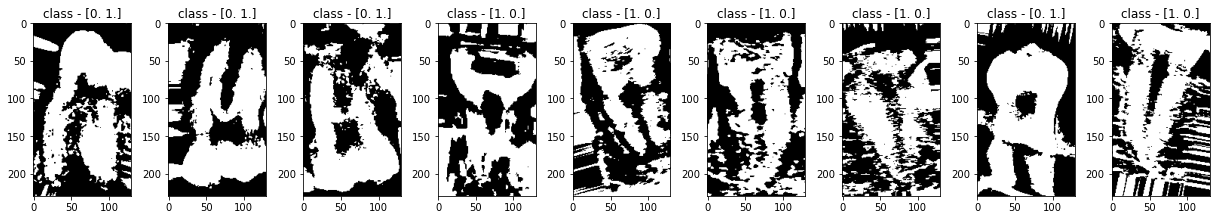

In [9]:
# test data loader

make_gen = get_generator(datafiles_df.sample(20), aug=True)
generator = make_gen()
x, y = generator.next()

n_samples = 9
fig, ax = plt.subplots(1,n_samples, figsize=(17,6))
for xi,yi,axi in zip(x[:n_samples],y[:n_samples], ax):
    axi.set_title(f"class - {yi}")
    axi.imshow(xi[:,:,0].astype("float32"), "gray")
plt.tight_layout()
plt.show()

# Train Test split & CV folds

In [10]:
# train, test = train_test_split(datafiles_df, test_size=0.2)

skf = StratifiedKFold(n_splits=5, shuffle=True)
for f, (t_idx, v_idx) in enumerate(skf.split(datafiles_df, datafiles_df["class"])):
    train, test = datafiles_df.iloc[t_idx], datafiles_df.iloc[v_idx]
    if f==1:
        break

In [11]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [12]:
train["class"].value_counts(), test["class"].value_counts()

(0-class-1root           52
 1-class-2ormoreroots    40
 Name: class, dtype: int64,
 0-class-1root           13
 1-class-2ormoreroots    10
 Name: class, dtype: int64)

In [13]:
folds = train.copy()
folds['kfold'] = 0

skf = StratifiedKFold(n_splits=NFOLDS, shuffle=True)

for f, (t_idx, v_idx) in enumerate(skf.split(X=folds["filename"], y=folds["class"])):
    folds['kfold'].iloc[v_idx] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds = pd.concat([folds,pd.get_dummies(folds["class"])],1)

#folds.sample(5)
folds.groupby("kfold").agg({"kfold":"count", "0-class-1root":sum, "1-class-2ormoreroots":sum}).head()

,kfold,0-class-1root,1-class-2ormoreroots
kfold,,,
0,14,8,6
1,13,8,5
2,13,8,5
3,13,7,6
4,13,7,6


# Model Design

In [14]:
def get_model():
    K.clear_session()
    
    inputs = keras.layers.Input(shape=(230, 130, 1))
    x = keras.layers.Conv2D(64, (27,27), strides=(3,3))(inputs)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(32, (3,3),strides=(1, 1), activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Conv2D(16, (3,3),strides=(1, 1), activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.MaxPool2D((2,2))(x)
    
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(32, activation="relu", kernel_regularizer=kr)(x)
    x = keras.layers.Dropout(0.2)(x)
    x = keras.layers.Dense(2, activation="softmax")(x)
    
    
    
    model = keras.models.Model(inputs,x)
    
    metrics=['accuracy', AUC()] 
             # Precision(), Recall(), TruePositives(), TrueNegatives(), FalsePositives(), FalseNegatives()]
    adam = keras.optimizers.Adam(lr=0.01)
    model.compile(loss='categorical_crossentropy',
                  optimizer=adam,
                  metrics=metrics)
    
    return model

model = get_model()
model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 230, 130, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 68, 35, 64)        46720     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 34, 17, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 34, 17, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 15, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 7, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 7, 32)        

# Model Fitting

In [15]:
def get_callbacks(name="default"):
    callbacks=[
            keras.callbacks.EarlyStopping(monitor="val_loss", #val_loss 
                                             patience=cfg["early_stopping"], 
                                             mode="min",
                                             min_delta=1e-5,
                                             verbose=1, 
                                             restore_best_weights=True),

            keras.callbacks.ModelCheckpoint(filepath=f"{name}_best_model.hdf5", 
                                               verbose=1, 
                                               save_best_only=True),

            keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.7,
                                                 patience=5,
                                                 verbose=1,
                                                 mode='min',
                                                 min_delta=1e-4,
                                                 cooldown=0,
                                                 min_lr=1e-5)
        ]
    return callbacks

In [16]:
def plot_lcurve(model, name="default.jpg"):
    metrics = ["loss", "auc", "accuracy"]

    fig, ax = plt.subplots(len(metrics),1, figsize=(8,6))
    for metric, axi in zip(metrics, ax):
        axi.set_title(metric)
        axi.plot(model.history.history[metric], ".--", label="tr")
        axi.plot(model.history.history[f'val_{metric}'], ".--", label="val")
        axi.legend()
    plt.tight_layout()
    plt.savefig(name)
    plt.show()

In [17]:
def run_training(fold, seed):
    print(f"\n fold: {fold}/{NFOLDS}, seed: {seed}/{len(SEEDS)} \n")

    seed_everything(seed)

    train = folds
    trn_idx = np.where(train['kfold'] != fold)[0]
    val_idx = np.where(train['kfold'] == fold)[0]

    print( "\n Train", trn_idx, "\n Valid", val_idx, "\n\n")
    # np.intersect1d()
    
    train_gen = get_generator(train.iloc[trn_idx], aug=True)
    valid_gen = get_generator(train.iloc[val_idx], aug=False)
    test_gen = get_generator(test, aug=False)

    train_dataset = tf.data.Dataset.from_generator(train_gen,(np.float16,np.float16), output_shapes=output_shapes) # , args=("df", datafiles_df)
    validation_dataset = tf.data.Dataset.from_generator(valid_gen,(np.float16,np.float16), output_shapes=output_shapes)
    test_dataset = tf.data.Dataset.from_generator(test_gen,(np.float16,np.float16), output_shapes=output_shapes)
    
    callbacks = get_callbacks(name=f"fold_{fold}")
    model = get_model()
    model.fit(
            train_dataset,
            steps_per_epoch=steps_per_epoch,
            epochs=epochs,
            verbose=1,
            validation_data=validation_dataset,
            validation_steps=800 // BATCH_SIZE,
            callbacks=callbacks
    )
    learning_history[(fold, seed)] = model.history
    plot_lcurve(model, name=f"{fold}_{seed}.jpg")
    
    #--------------------- PREDICTION---------------------
    model = keras.models.load_model(filepath=f"fold_{fold}_best_model.hdf5", compile=False)
    
    predictions = np.zeros((len(test), 2))
    predictions = model.predict(test_gen(), verbose=0)
    
    valid_preds = model.predict(valid_gen(), verbose=0)
    oof[val_idx] = valid_preds
    
    return oof, predictions

In [18]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train),2))
    predictions = np.zeros((len(test),2))
    
    for fold in range(NFOLDS):
        
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions


 fold: 0/7, seed: 0/1 


 Train [ 3  4  5  6  7  8  9 11 12 13 14 16 17 18 19 20 22 23 24 26 27 28 29 30
 31 32 33 34 35 36 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55
 57 58 59 60 61 63 65 66 67 68 69 71 73 74 75 76 77 78 79 80 81 82 83 85
 86 87 88 89 90 91] 
 Valid [ 0  1  2 10 15 21 25 37 56 62 64 70 72 84] 


Epoch 1/25


Found 78 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4872 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6923 - accuracy: 0.5064 - auc: 0.5411

 3/46 [>.............................] - ETA: 15s - loss: 0.7273 - accuracy: 0.5256 - auc: 0.5539

 4/46 [=>............................] - ETA: 16s - loss: 0.7175 - accuracy: 0.5353 - auc: 0.5583

 5/46 [==>...........................] - ETA: 17s - loss: 0.7121 - accuracy: 0.5410 - auc: 0.5602

 6/46 [==>...........................] - ETA: 17s - loss: 0.7088 - accuracy: 0.5470 - auc: 0.5582

 7/46 [===>..........................] - ETA: 17s - loss: 0.7062 - accuracy: 0.5495 - auc: 0.5597

 8/46 [====>.........................] - ETA: 17s - loss: 0.7045 - accuracy: 0.5513 - auc: 0.5561

 9/46 [====>.........................] - ETA: 17s - loss: 0.7018 - accuracy: 0.5527 - auc: 0.5604

10/46 [=====>........................] - ETA: 17s - loss: 0.7007 - accuracy: 0.5538 - auc: 0.5611

11/46 [======>.......................] - ETA: 16s - loss: 0.6990 - accuracy: 0.5571 - auc: 0.5651

12/46 [======>.......................] - ETA: 16s - loss: 0.6969 - accuracy: 0.5588 - auc: 0.5685

13/46 [=======>......................] - ETA: 16s - loss: 0.6959 - accuracy: 0.5572 - auc: 0.5667

14/46 [========>.....................] - ETA: 15s - loss: 0.6961 - accuracy: 0.5549 - auc: 0.5619

15/46 [========>.....................] - ETA: 15s - loss: 0.6942 - accuracy: 0.5564 - auc: 0.5669

16/46 [=========>....................] - ETA: 15s - loss: 0.6929 - accuracy: 0.5593 - auc: 0.5719

17/46 [==========>...................] - ETA: 14s - loss: 0.6918 - accuracy: 0.5618 - auc: 0.5741

18/46 [==========>...................] - ETA: 14s - loss: 0.6896 - accuracy: 0.5641 - auc: 0.5790

19/46 [===========>..................] - ETA: 13s - loss: 0.6894 - accuracy: 0.5648 - auc: 0.5788

20/46 [============>.................] - ETA: 13s - loss: 0.6877 - accuracy: 0.5686 - auc: 0.5843

21/46 [============>.................] - ETA: 12s - loss: 0.6867 - accuracy: 0.5678 - auc: 0.5852

22/46 [=============>................] - ETA: 12s - loss: 0.6860 - accuracy: 0.5705 - auc: 0.5883

23/46 [==============>...............] - ETA: 11s - loss: 0.6854 - accuracy: 0.5730 - auc: 0.5903

24/46 [==============>...............] - ETA: 11s - loss: 0.6844 - accuracy: 0.5748 - auc: 0.5927

25/46 [===============>..............] - ETA: 10s - loss: 0.6829 - accuracy: 0.5769 - auc: 0.5975

26/46 [===============>..............] - ETA: 10s - loss: 0.6803 - accuracy: 0.5804 - auc: 0.6041

27/46 [================>.............] - ETA: 9s - loss: 0.6789 - accuracy: 0.5821 - auc: 0.6074 

28/46 [=================>............] - ETA: 9s - loss: 0.6764 - accuracy: 0.5879 - auc: 0.6140

29/46 [=================>............] - ETA: 8s - loss: 0.6756 - accuracy: 0.5902 - auc: 0.6176

30/46 [==================>...........] - ETA: 8s - loss: 0.6750 - accuracy: 0.5915 - auc: 0.6189

31/46 [===================>..........] - ETA: 7s - loss: 0.6704 - accuracy: 0.5968 - auc: 0.6285

32/46 [===================>..........] - ETA: 7s - loss: 0.6684 - accuracy: 0.5998 - auc: 0.6337

33/46 [====================>.........] - ETA: 6s - loss: 0.6680 - accuracy: 0.6006 - auc: 0.6351

34/46 [=====================>........] - ETA: 6s - loss: 0.6687 - accuracy: 0.5992 - auc: 0.6333

35/46 [=====================>........] - ETA: 5s - loss: 0.6660 - accuracy: 0.6026 - auc: 0.6384

36/46 [======================>.......] - ETA: 5s - loss: 0.6629 - accuracy: 0.6075 - auc: 0.6454

37/46 [=======================>......] - ETA: 4s - loss: 0.6610 - accuracy: 0.6081 - auc: 0.6478

38/46 [=======================>......] - ETA: 4s - loss: 0.6589 - accuracy: 0.6113 - auc: 0.6517

39/46 [========================>.....] - ETA: 3s - loss: 0.6561 - accuracy: 0.6137 - auc: 0.6556

40/46 [=========================>....] - ETA: 3s - loss: 0.6528 - accuracy: 0.6173 - auc: 0.6608

41/46 [=========================>....] - ETA: 2s - loss: 0.6502 - accuracy: 0.6198 - auc: 0.6645

42/46 [==========================>...] - ETA: 2s - loss: 0.6478 - accuracy: 0.6218 - auc: 0.6686

43/46 [===========================>..] - ETA: 1s - loss: 0.6467 - accuracy: 0.6237 - auc: 0.6711

44/46 [===========================>..] - ETA: 1s - loss: 0.6454 - accuracy: 0.6256 - auc: 0.6735

45/46 [============================>.] - ETA: 0s - loss: 0.6434 - accuracy: 0.6274 - auc: 0.6765

46/46 [==============================] - ETA: 0s - loss: 0.6403 - accuracy: 0.6302 - auc: 0.6811

Found 14 validated image filenames belonging to 2 classes.



Epoch 00001: val_loss improved from inf to 0.50395, saving model to fold_0_best_model.hdf5
46/46 [==============================] - 25s 538ms/step - loss: 0.6403 - accuracy: 0.6302 - auc: 0.6811 - val_loss: 0.5039 - val_accuracy: 0.7143 - val_auc: 0.8469


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.4709 - accuracy: 0.8205 - auc: 0.8659

 2/46 [>.............................] - ETA: 13s - loss: 0.4966 - accuracy: 0.7885 - auc: 0.8436

 3/46 [>.............................] - ETA: 16s - loss: 0.5457 - accuracy: 0.7650 - auc: 0.8178

 4/46 [=>............................] - ETA: 17s - loss: 0.5410 - accuracy: 0.7468 - auc: 0.8154

 5/46 [==>...........................] - ETA: 18s - loss: 0.5401 - accuracy: 0.7462 - auc: 0.8143

 6/46 [==>...........................] - ETA: 18s - loss: 0.5360 - accuracy: 0.7500 - auc: 0.8179

 7/46 [===>..........................] - ETA: 18s - loss: 0.5365 - accuracy: 0.7399 - auc: 0.8133

 8/46 [====>.........................] - ETA: 18s - loss: 0.5348 - accuracy: 0.7340 - auc: 0.8128

 9/46 [====>.........................] - ETA: 17s - loss: 0.5255 - accuracy: 0.7422 - auc: 0.8202

10/46 [=====>........................] - ETA: 17s - loss: 0.5206 - accuracy: 0.7436 - auc: 0.8238

11/46 [======>.......................] - ETA: 17s - loss: 0.5073 - accuracy: 0.7459 - auc: 0.8324

12/46 [======>.......................] - ETA: 16s - loss: 0.5042 - accuracy: 0.7543 - auc: 0.8373

13/46 [=======>......................] - ETA: 16s - loss: 0.4966 - accuracy: 0.7594 - auc: 0.8425

14/46 [========>.....................] - ETA: 16s - loss: 0.4930 - accuracy: 0.7610 - auc: 0.8445

15/46 [========>.....................] - ETA: 15s - loss: 0.4851 - accuracy: 0.7650 - auc: 0.8495

16/46 [=========>....................] - ETA: 15s - loss: 0.4829 - accuracy: 0.7652 - auc: 0.8506

17/46 [==========>...................] - ETA: 14s - loss: 0.4835 - accuracy: 0.7632 - auc: 0.8495

18/46 [==========>...................] - ETA: 14s - loss: 0.4826 - accuracy: 0.7664 - auc: 0.8501

19/46 [===========>..................] - ETA: 13s - loss: 0.4819 - accuracy: 0.7659 - auc: 0.8505

20/46 [============>.................] - ETA: 13s - loss: 0.4779 - accuracy: 0.7686 - auc: 0.8534

21/46 [============>.................] - ETA: 12s - loss: 0.4765 - accuracy: 0.7711 - auc: 0.8544

22/46 [=============>................] - ETA: 12s - loss: 0.4739 - accuracy: 0.7716 - auc: 0.8559

23/46 [==============>...............] - ETA: 11s - loss: 0.4717 - accuracy: 0.7731 - auc: 0.8575

24/46 [==============>...............] - ETA: 11s - loss: 0.4709 - accuracy: 0.7735 - auc: 0.8577

25/46 [===============>..............] - ETA: 10s - loss: 0.4684 - accuracy: 0.7759 - auc: 0.8594

26/46 [===============>..............] - ETA: 10s - loss: 0.4694 - accuracy: 0.7751 - auc: 0.8597

27/46 [================>.............] - ETA: 9s - loss: 0.4699 - accuracy: 0.7754 - auc: 0.8595 

28/46 [=================>............] - ETA: 9s - loss: 0.4687 - accuracy: 0.7743 - auc: 0.8598

29/46 [=================>............] - ETA: 8s - loss: 0.4649 - accuracy: 0.7781 - auc: 0.8622

30/46 [==================>...........] - ETA: 8s - loss: 0.4655 - accuracy: 0.7782 - auc: 0.8621

31/46 [===================>..........] - ETA: 7s - loss: 0.4635 - accuracy: 0.7771 - auc: 0.8630

32/46 [===================>..........] - ETA: 7s - loss: 0.4615 - accuracy: 0.7772 - auc: 0.8638

33/46 [====================>.........] - ETA: 6s - loss: 0.4627 - accuracy: 0.7758 - auc: 0.8629

34/46 [=====================>........] - ETA: 6s - loss: 0.4609 - accuracy: 0.7768 - auc: 0.8640

35/46 [=====================>........] - ETA: 5s - loss: 0.4622 - accuracy: 0.7747 - auc: 0.8630

36/46 [======================>.......] - ETA: 5s - loss: 0.4621 - accuracy: 0.7742 - auc: 0.8629

37/46 [=======================>......] - ETA: 4s - loss: 0.4601 - accuracy: 0.7762 - auc: 0.8643

38/46 [=======================>......] - ETA: 4s - loss: 0.4593 - accuracy: 0.7773 - auc: 0.8648

39/46 [========================>.....] - ETA: 3s - loss: 0.4595 - accuracy: 0.7774 - auc: 0.8649

40/46 [=========================>....] - ETA: 3s - loss: 0.4588 - accuracy: 0.7779 - auc: 0.8654

41/46 [=========================>....] - ETA: 2s - loss: 0.4575 - accuracy: 0.7777 - auc: 0.8659

42/46 [==========================>...] - ETA: 2s - loss: 0.4556 - accuracy: 0.7796 - auc: 0.8673

43/46 [===========================>..] - ETA: 1s - loss: 0.4566 - accuracy: 0.7791 - auc: 0.8668

44/46 [===========================>..] - ETA: 1s - loss: 0.4557 - accuracy: 0.7783 - auc: 0.8671

45/46 [============================>.] - ETA: 0s - loss: 0.4546 - accuracy: 0.7786 - auc: 0.8677

46/46 [==============================] - ETA: 0s - loss: 0.4546 - accuracy: 0.7781 - auc: 0.8676

Found 14 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss improved from 0.50395 to 0.39093, saving model to fold_0_best_model.hdf5


46/46 [==============================] - 25s 533ms/step - loss: 0.4546 - accuracy: 0.7781 - auc: 0.8676 - val_loss: 0.3909 - val_accuracy: 0.7857 - val_auc: 0.8929


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.4203 - accuracy: 0.7949 - auc: 0.8881

 2/46 [>.............................] - ETA: 11s - loss: 0.3847 - accuracy: 0.8013 - auc: 0.9068

 3/46 [>.............................] - ETA: 15s - loss: 0.3972 - accuracy: 0.8120 - auc: 0.9023

 4/46 [=>............................] - ETA: 16s - loss: 0.3949 - accuracy: 0.8013 - auc: 0.9018

 5/46 [==>...........................] - ETA: 17s - loss: 0.3986 - accuracy: 0.8077 - auc: 0.9008

 6/46 [==>...........................] - ETA: 17s - loss: 0.3944 - accuracy: 0.8056 - auc: 0.9019

 7/46 [===>..........................] - ETA: 17s - loss: 0.3881 - accuracy: 0.8077 - auc: 0.9046

 8/46 [====>.........................] - ETA: 17s - loss: 0.3893 - accuracy: 0.8061 - auc: 0.9037

 9/46 [====>.........................] - ETA: 17s - loss: 0.3876 - accuracy: 0.8105 - auc: 0.9049

10/46 [=====>........................] - ETA: 17s - loss: 0.3814 - accuracy: 0.8154 - auc: 0.9082

11/46 [======>.......................] - ETA: 16s - loss: 0.3799 - accuracy: 0.8182 - auc: 0.9098

12/46 [======>.......................] - ETA: 16s - loss: 0.3792 - accuracy: 0.8173 - auc: 0.9095

13/46 [=======>......................] - ETA: 16s - loss: 0.3786 - accuracy: 0.8176 - auc: 0.9095

14/46 [========>.....................] - ETA: 15s - loss: 0.3826 - accuracy: 0.8168 - auc: 0.9079

15/46 [========>.....................] - ETA: 15s - loss: 0.3858 - accuracy: 0.8154 - auc: 0.9065

16/46 [=========>....................] - ETA: 14s - loss: 0.3852 - accuracy: 0.8173 - auc: 0.9068

17/46 [==========>...................] - ETA: 14s - loss: 0.3853 - accuracy: 0.8190 - auc: 0.9068

18/46 [==========>...................] - ETA: 14s - loss: 0.3851 - accuracy: 0.8198 - auc: 0.9071

19/46 [===========>..................] - ETA: 13s - loss: 0.3857 - accuracy: 0.8212 - auc: 0.9073

20/46 [============>.................] - ETA: 13s - loss: 0.3859 - accuracy: 0.8224 - auc: 0.9073

21/46 [============>.................] - ETA: 12s - loss: 0.3852 - accuracy: 0.8230 - auc: 0.9076

22/46 [=============>................] - ETA: 12s - loss: 0.3874 - accuracy: 0.8217 - auc: 0.9062

23/46 [==============>...............] - ETA: 11s - loss: 0.3851 - accuracy: 0.8216 - auc: 0.9072

24/46 [==============>...............] - ETA: 11s - loss: 0.3835 - accuracy: 0.8216 - auc: 0.9077

25/46 [===============>..............] - ETA: 10s - loss: 0.3800 - accuracy: 0.8221 - auc: 0.9091

26/46 [===============>..............] - ETA: 10s - loss: 0.3792 - accuracy: 0.8225 - auc: 0.9095

27/46 [================>.............] - ETA: 9s - loss: 0.3816 - accuracy: 0.8215 - auc: 0.9086 

28/46 [=================>............] - ETA: 9s - loss: 0.3807 - accuracy: 0.8219 - auc: 0.9090

29/46 [=================>............] - ETA: 8s - loss: 0.3835 - accuracy: 0.8223 - auc: 0.9082

30/46 [==================>...........] - ETA: 8s - loss: 0.3818 - accuracy: 0.8244 - auc: 0.9093

31/46 [===================>..........] - ETA: 7s - loss: 0.3795 - accuracy: 0.8246 - auc: 0.9105

32/46 [===================>..........] - ETA: 7s - loss: 0.3801 - accuracy: 0.8245 - auc: 0.9101

33/46 [====================>.........] - ETA: 6s - loss: 0.3799 - accuracy: 0.8244 - auc: 0.9103

34/46 [=====================>........] - ETA: 6s - loss: 0.3812 - accuracy: 0.8243 - auc: 0.9097

35/46 [=====================>........] - ETA: 5s - loss: 0.3794 - accuracy: 0.8245 - auc: 0.9107

36/46 [======================>.......] - ETA: 5s - loss: 0.3799 - accuracy: 0.8230 - auc: 0.9103

37/46 [=======================>......] - ETA: 4s - loss: 0.3792 - accuracy: 0.8229 - auc: 0.9106

38/46 [=======================>......] - ETA: 4s - loss: 0.3798 - accuracy: 0.8219 - auc: 0.9102

39/46 [========================>.....] - ETA: 3s - loss: 0.3792 - accuracy: 0.8215 - auc: 0.9104

40/46 [=========================>....] - ETA: 3s - loss: 0.3771 - accuracy: 0.8231 - auc: 0.9114

41/46 [=========================>....] - ETA: 2s - loss: 0.3770 - accuracy: 0.8240 - auc: 0.9116

42/46 [==========================>...] - ETA: 2s - loss: 0.3773 - accuracy: 0.8233 - auc: 0.9113

43/46 [===========================>..] - ETA: 1s - loss: 0.3782 - accuracy: 0.8217 - auc: 0.9106

44/46 [===========================>..] - ETA: 1s - loss: 0.3769 - accuracy: 0.8220 - auc: 0.9113

45/46 [============================>.] - ETA: 0s - loss: 0.3771 - accuracy: 0.8219 - auc: 0.9112

46/46 [==============================] - ETA: 0s - loss: 0.3764 - accuracy: 0.8230 - auc: 0.9116

Found 14 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss improved from 0.39093 to 0.30661, saving model to fold_0_best_model.hdf5
46/46 [==============================] - 27s 576ms/step - loss: 0.3764 - accuracy: 0.8230 - auc: 0.9116 - val_loss: 0.3066 - val_accuracy: 0.8571 - val_auc: 0.9388


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.4468 - accuracy: 0.7821 - auc: 0.8714

 2/46 [>.............................] - ETA: 11s - loss: 0.4078 - accuracy: 0.8141 - auc: 0.8907

 3/46 [>.............................] - ETA: 14s - loss: 0.3825 - accuracy: 0.8376 - auc: 0.9086

 4/46 [=>............................] - ETA: 16s - loss: 0.3922 - accuracy: 0.8269 - auc: 0.9029

 5/46 [==>...........................] - ETA: 17s - loss: 0.3989 - accuracy: 0.8308 - auc: 0.9010

 6/46 [==>...........................] - ETA: 17s - loss: 0.3871 - accuracy: 0.8333 - auc: 0.9068

 7/46 [===>..........................] - ETA: 17s - loss: 0.3680 - accuracy: 0.8425 - auc: 0.9168

 8/46 [====>.........................] - ETA: 17s - loss: 0.3837 - accuracy: 0.8333 - auc: 0.9082

 9/46 [====>.........................] - ETA: 17s - loss: 0.3850 - accuracy: 0.8305 - auc: 0.9067

10/46 [=====>........................] - ETA: 17s - loss: 0.3790 - accuracy: 0.8346 - auc: 0.9101

11/46 [======>.......................] - ETA: 16s - loss: 0.3719 - accuracy: 0.8368 - auc: 0.9135

12/46 [======>.......................] - ETA: 16s - loss: 0.3729 - accuracy: 0.8365 - auc: 0.9134

13/46 [=======>......................] - ETA: 15s - loss: 0.3703 - accuracy: 0.8383 - auc: 0.9147

14/46 [========>.....................] - ETA: 15s - loss: 0.3680 - accuracy: 0.8379 - auc: 0.9156

15/46 [========>.....................] - ETA: 15s - loss: 0.3698 - accuracy: 0.8385 - auc: 0.9149

16/46 [=========>....................] - ETA: 14s - loss: 0.3677 - accuracy: 0.8397 - auc: 0.9158

17/46 [==========>...................] - ETA: 14s - loss: 0.3644 - accuracy: 0.8416 - auc: 0.9173

18/46 [==========>...................] - ETA: 13s - loss: 0.3613 - accuracy: 0.8426 - auc: 0.9188

19/46 [===========>..................] - ETA: 13s - loss: 0.3589 - accuracy: 0.8441 - auc: 0.9199

20/46 [============>.................] - ETA: 13s - loss: 0.3563 - accuracy: 0.8429 - auc: 0.9210

21/46 [============>.................] - ETA: 12s - loss: 0.3566 - accuracy: 0.8413 - auc: 0.9206

22/46 [=============>................] - ETA: 12s - loss: 0.3580 - accuracy: 0.8415 - auc: 0.9202

23/46 [==============>...............] - ETA: 11s - loss: 0.3584 - accuracy: 0.8406 - auc: 0.9200

24/46 [==============>...............] - ETA: 11s - loss: 0.3551 - accuracy: 0.8413 - auc: 0.9215

25/46 [===============>..............] - ETA: 10s - loss: 0.3558 - accuracy: 0.8426 - auc: 0.9214

26/46 [===============>..............] - ETA: 10s - loss: 0.3540 - accuracy: 0.8432 - auc: 0.9222

27/46 [================>.............] - ETA: 9s - loss: 0.3513 - accuracy: 0.8428 - auc: 0.9234 

28/46 [=================>............] - ETA: 9s - loss: 0.3531 - accuracy: 0.8420 - auc: 0.9229

29/46 [=================>............] - ETA: 8s - loss: 0.3498 - accuracy: 0.8444 - auc: 0.9247

30/46 [==================>...........] - ETA: 8s - loss: 0.3486 - accuracy: 0.8453 - auc: 0.9252

31/46 [===================>..........] - ETA: 7s - loss: 0.3482 - accuracy: 0.8445 - auc: 0.9252

32/46 [===================>..........] - ETA: 7s - loss: 0.3453 - accuracy: 0.8458 - auc: 0.9265

33/46 [====================>.........] - ETA: 6s - loss: 0.3469 - accuracy: 0.8434 - auc: 0.9256

34/46 [=====================>........] - ETA: 6s - loss: 0.3431 - accuracy: 0.8462 - auc: 0.9273

35/46 [=====================>........] - ETA: 5s - loss: 0.3410 - accuracy: 0.8462 - auc: 0.9282

36/46 [======================>.......] - ETA: 5s - loss: 0.3420 - accuracy: 0.8469 - auc: 0.9281

37/46 [=======================>......] - ETA: 4s - loss: 0.3425 - accuracy: 0.8465 - auc: 0.9278

38/46 [=======================>......] - ETA: 4s - loss: 0.3415 - accuracy: 0.8468 - auc: 0.9283

39/46 [========================>.....] - ETA: 3s - loss: 0.3420 - accuracy: 0.8462 - auc: 0.9280

40/46 [=========================>....] - ETA: 3s - loss: 0.3421 - accuracy: 0.8458 - auc: 0.9280

41/46 [=========================>....] - ETA: 2s - loss: 0.3397 - accuracy: 0.8477 - auc: 0.9290

42/46 [==========================>...] - ETA: 2s - loss: 0.3381 - accuracy: 0.8492 - auc: 0.9297

43/46 [===========================>..] - ETA: 1s - loss: 0.3355 - accuracy: 0.8506 - auc: 0.9309

44/46 [===========================>..] - ETA: 1s - loss: 0.3378 - accuracy: 0.8505 - auc: 0.9303

45/46 [============================>.] - ETA: 0s - loss: 0.3342 - accuracy: 0.8527 - auc: 0.9319

46/46 [==============================] - ETA: 0s - loss: 0.3360 - accuracy: 0.8531 - auc: 0.9313

Found 14 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss did not improve from 0.30661
46/46 [==============================] - 25s 534ms/step - loss: 0.3360 - accuracy: 0.8531 - auc: 0.9313 - val_loss: 0.5112 - val_accuracy: 0.7857 - val_auc: 0.9031


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.3102 - accuracy: 0.8462 - auc: 0.9398

 2/46 [>.............................] - ETA: 12s - loss: 0.3168 - accuracy: 0.8590 - auc: 0.9386

 3/46 [>.............................] - ETA: 15s - loss: 0.3160 - accuracy: 0.8632 - auc: 0.9429

 4/46 [=>............................] - ETA: 17s - loss: 0.2848 - accuracy: 0.8750 - auc: 0.9528

 5/46 [==>...........................] - ETA: 18s - loss: 0.2777 - accuracy: 0.8744 - auc: 0.9543

 6/46 [==>...........................] - ETA: 18s - loss: 0.2927 - accuracy: 0.8675 - auc: 0.9494

 7/46 [===>..........................] - ETA: 18s - loss: 0.2917 - accuracy: 0.8645 - auc: 0.9492

 8/46 [====>.........................] - ETA: 18s - loss: 0.2989 - accuracy: 0.8638 - auc: 0.9466

 9/46 [====>.........................] - ETA: 17s - loss: 0.2997 - accuracy: 0.8590 - auc: 0.9456

10/46 [=====>........................] - ETA: 17s - loss: 0.2985 - accuracy: 0.8641 - auc: 0.9464

11/46 [======>.......................] - ETA: 17s - loss: 0.3028 - accuracy: 0.8590 - auc: 0.9446

12/46 [======>.......................] - ETA: 16s - loss: 0.3035 - accuracy: 0.8568 - auc: 0.9443

13/46 [=======>......................] - ETA: 16s - loss: 0.3082 - accuracy: 0.8550 - auc: 0.9424

14/46 [========>.....................] - ETA: 16s - loss: 0.3104 - accuracy: 0.8571 - auc: 0.9421

15/46 [========>.....................] - ETA: 15s - loss: 0.3120 - accuracy: 0.8573 - auc: 0.9416

16/46 [=========>....................] - ETA: 15s - loss: 0.3146 - accuracy: 0.8558 - auc: 0.9406

17/46 [==========>...................] - ETA: 14s - loss: 0.3214 - accuracy: 0.8507 - auc: 0.9374

18/46 [==========>...................] - ETA: 14s - loss: 0.3201 - accuracy: 0.8497 - auc: 0.9376

19/46 [===========>..................] - ETA: 13s - loss: 0.3189 - accuracy: 0.8495 - auc: 0.9379

20/46 [============>.................] - ETA: 13s - loss: 0.3182 - accuracy: 0.8513 - auc: 0.9383

21/46 [============>.................] - ETA: 12s - loss: 0.3208 - accuracy: 0.8498 - auc: 0.9375

22/46 [=============>................] - ETA: 12s - loss: 0.3214 - accuracy: 0.8508 - auc: 0.9374

23/46 [==============>...............] - ETA: 12s - loss: 0.3190 - accuracy: 0.8528 - auc: 0.9384

24/46 [==============>...............] - ETA: 11s - loss: 0.3220 - accuracy: 0.8520 - auc: 0.9373

25/46 [===============>..............] - ETA: 11s - loss: 0.3225 - accuracy: 0.8523 - auc: 0.9371

26/46 [===============>..............] - ETA: 10s - loss: 0.3262 - accuracy: 0.8506 - auc: 0.9355

27/46 [================>.............] - ETA: 10s - loss: 0.3274 - accuracy: 0.8500 - auc: 0.9352

28/46 [=================>............] - ETA: 9s - loss: 0.3263 - accuracy: 0.8512 - auc: 0.9356 

29/46 [=================>............] - ETA: 9s - loss: 0.3246 - accuracy: 0.8528 - auc: 0.9363

30/46 [==================>...........] - ETA: 8s - loss: 0.3237 - accuracy: 0.8530 - auc: 0.9366

31/46 [===================>..........] - ETA: 7s - loss: 0.3218 - accuracy: 0.8528 - auc: 0.9373

32/46 [===================>..........] - ETA: 7s - loss: 0.3250 - accuracy: 0.8530 - auc: 0.9362

33/46 [====================>.........] - ETA: 6s - loss: 0.3248 - accuracy: 0.8539 - auc: 0.9363

34/46 [=====================>........] - ETA: 6s - loss: 0.3235 - accuracy: 0.8552 - auc: 0.9368

35/46 [=====================>........] - ETA: 5s - loss: 0.3252 - accuracy: 0.8538 - auc: 0.9360

36/46 [======================>.......] - ETA: 5s - loss: 0.3262 - accuracy: 0.8543 - auc: 0.9357

37/46 [=======================>......] - ETA: 4s - loss: 0.3236 - accuracy: 0.8562 - auc: 0.9368

38/46 [=======================>......] - ETA: 4s - loss: 0.3226 - accuracy: 0.8566 - auc: 0.9371

39/46 [========================>.....] - ETA: 3s - loss: 0.3202 - accuracy: 0.8577 - auc: 0.9381

40/46 [=========================>....] - ETA: 3s - loss: 0.3213 - accuracy: 0.8577 - auc: 0.9379

41/46 [=========================>....] - ETA: 2s - loss: 0.3203 - accuracy: 0.8587 - auc: 0.9383

42/46 [==========================>...] - ETA: 2s - loss: 0.3209 - accuracy: 0.8587 - auc: 0.9383

43/46 [===========================>..] - ETA: 1s - loss: 0.3215 - accuracy: 0.8584 - auc: 0.9380

44/46 [===========================>..] - ETA: 1s - loss: 0.3208 - accuracy: 0.8587 - auc: 0.9382

45/46 [============================>.] - ETA: 0s - loss: 0.3199 - accuracy: 0.8584 - auc: 0.9385

46/46 [==============================] - ETA: 0s - loss: 0.3190 - accuracy: 0.8581 - auc: 0.9388

Found 14 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss did not improve from 0.30661
46/46 [==============================] - 25s 533ms/step - loss: 0.3190 - accuracy: 0.8581 - auc: 0.9388 - val_loss: 0.7954 - val_accuracy: 0.7857 - val_auc: 0.8571


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2730 - accuracy: 0.8846 - auc: 0.9606

 2/46 [>.............................] - ETA: 11s - loss: 0.2893 - accuracy: 0.8718 - auc: 0.9511

 3/46 [>.............................] - ETA: 14s - loss: 0.2947 - accuracy: 0.8846 - auc: 0.9490

 4/46 [=>............................] - ETA: 16s - loss: 0.3535 - accuracy: 0.8782 - auc: 0.9367

 5/46 [==>...........................] - ETA: 16s - loss: 0.3472 - accuracy: 0.8718 - auc: 0.9369

 6/46 [==>...........................] - ETA: 17s - loss: 0.3505 - accuracy: 0.8590 - auc: 0.9337

 7/46 [===>..........................] - ETA: 17s - loss: 0.3481 - accuracy: 0.8645 - auc: 0.9339

 8/46 [====>.........................] - ETA: 17s - loss: 0.3414 - accuracy: 0.8638 - auc: 0.9357

 9/46 [====>.........................] - ETA: 17s - loss: 0.3432 - accuracy: 0.8604 - auc: 0.9341

10/46 [=====>........................] - ETA: 16s - loss: 0.3456 - accuracy: 0.8590 - auc: 0.9337

11/46 [======>.......................] - ETA: 16s - loss: 0.3373 - accuracy: 0.8625 - auc: 0.9366

12/46 [======>.......................] - ETA: 16s - loss: 0.3343 - accuracy: 0.8632 - auc: 0.9372

13/46 [=======>......................] - ETA: 15s - loss: 0.3397 - accuracy: 0.8580 - auc: 0.9344

14/46 [========>.....................] - ETA: 15s - loss: 0.3336 - accuracy: 0.8608 - auc: 0.9364

15/46 [========>.....................] - ETA: 15s - loss: 0.3315 - accuracy: 0.8615 - auc: 0.9369

16/46 [=========>....................] - ETA: 14s - loss: 0.3276 - accuracy: 0.8606 - auc: 0.9380

17/46 [==========>...................] - ETA: 14s - loss: 0.3258 - accuracy: 0.8627 - auc: 0.9387

18/46 [==========>...................] - ETA: 13s - loss: 0.3267 - accuracy: 0.8604 - auc: 0.9378

19/46 [===========>..................] - ETA: 13s - loss: 0.3228 - accuracy: 0.8623 - auc: 0.9391

20/46 [============>.................] - ETA: 12s - loss: 0.3216 - accuracy: 0.8603 - auc: 0.9391

21/46 [============>.................] - ETA: 12s - loss: 0.3204 - accuracy: 0.8608 - auc: 0.9394

22/46 [=============>................] - ETA: 12s - loss: 0.3166 - accuracy: 0.8636 - auc: 0.9412

23/46 [==============>...............] - ETA: 11s - loss: 0.3270 - accuracy: 0.8595 - auc: 0.9380

24/46 [==============>...............] - ETA: 11s - loss: 0.3273 - accuracy: 0.8579 - auc: 0.9377

25/46 [===============>..............] - ETA: 10s - loss: 0.3277 - accuracy: 0.8574 - auc: 0.9374

26/46 [===============>..............] - ETA: 10s - loss: 0.3280 - accuracy: 0.8575 - auc: 0.9373

27/46 [================>.............] - ETA: 9s - loss: 0.3252 - accuracy: 0.8585 - auc: 0.9383 

28/46 [=================>............] - ETA: 9s - loss: 0.3255 - accuracy: 0.8594 - auc: 0.9382

29/46 [=================>............] - ETA: 8s - loss: 0.3239 - accuracy: 0.8594 - auc: 0.9387

30/46 [==================>...........] - ETA: 8s - loss: 0.3276 - accuracy: 0.8598 - auc: 0.9376

31/46 [===================>..........] - ETA: 7s - loss: 0.3265 - accuracy: 0.8606 - auc: 0.9379

32/46 [===================>..........] - ETA: 7s - loss: 0.3265 - accuracy: 0.8614 - auc: 0.9380

33/46 [====================>.........] - ETA: 6s - loss: 0.3244 - accuracy: 0.8636 - auc: 0.9389

34/46 [=====================>........] - ETA: 6s - loss: 0.3218 - accuracy: 0.8658 - auc: 0.9399

35/46 [=====================>........] - ETA: 5s - loss: 0.3225 - accuracy: 0.8648 - auc: 0.9396

36/46 [======================>.......] - ETA: 5s - loss: 0.3202 - accuracy: 0.8661 - auc: 0.9405

37/46 [=======================>......] - ETA: 4s - loss: 0.3188 - accuracy: 0.8659 - auc: 0.9409

38/46 [=======================>......] - ETA: 4s - loss: 0.3179 - accuracy: 0.8664 - auc: 0.9412

39/46 [========================>.....] - ETA: 3s - loss: 0.3174 - accuracy: 0.8662 - auc: 0.9413

40/46 [=========================>....] - ETA: 3s - loss: 0.3155 - accuracy: 0.8667 - auc: 0.9420

41/46 [=========================>....] - ETA: 2s - loss: 0.3120 - accuracy: 0.8680 - auc: 0.9432

42/46 [==========================>...] - ETA: 2s - loss: 0.3096 - accuracy: 0.8694 - auc: 0.9441

43/46 [===========================>..] - ETA: 1s - loss: 0.3089 - accuracy: 0.8697 - auc: 0.9443

44/46 [===========================>..] - ETA: 1s - loss: 0.3066 - accuracy: 0.8715 - auc: 0.9452

45/46 [============================>.] - ETA: 0s - loss: 0.3051 - accuracy: 0.8718 - auc: 0.9457

46/46 [==============================] - ETA: 0s - loss: 0.3083 - accuracy: 0.8712 - auc: 0.9449

Found 14 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss did not improve from 0.30661
46/46 [==============================] - 24s 528ms/step - loss: 0.3083 - accuracy: 0.8712 - auc: 0.9449 - val_loss: 0.5161 - val_accuracy: 0.7857 - val_auc: 0.9337


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.2391 - accuracy: 0.8846 - auc: 0.9675

 2/46 [>.............................] - ETA: 11s - loss: 0.2427 - accuracy: 0.8910 - auc: 0.9647

 3/46 [>.............................] - ETA: 15s - loss: 0.2689 - accuracy: 0.8932 - auc: 0.9572

 4/46 [=>............................] - ETA: 16s - loss: 0.3010 - accuracy: 0.8686 - auc: 0.9465

 5/46 [==>...........................] - ETA: 17s - loss: 0.2934 - accuracy: 0.8667 - auc: 0.9489

 6/46 [==>...........................] - ETA: 17s - loss: 0.2859 - accuracy: 0.8761 - auc: 0.9516

 7/46 [===>..........................] - ETA: 17s - loss: 0.2753 - accuracy: 0.8846 - auc: 0.9558

 8/46 [====>.........................] - ETA: 17s - loss: 0.2671 - accuracy: 0.8878 - auc: 0.9586

 9/46 [====>.........................] - ETA: 17s - loss: 0.2619 - accuracy: 0.8917 - auc: 0.9602

10/46 [=====>........................] - ETA: 17s - loss: 0.2649 - accuracy: 0.8936 - auc: 0.9595

11/46 [======>.......................] - ETA: 16s - loss: 0.2645 - accuracy: 0.8928 - auc: 0.9594

12/46 [======>.......................] - ETA: 16s - loss: 0.2608 - accuracy: 0.8932 - auc: 0.9604

13/46 [=======>......................] - ETA: 16s - loss: 0.2659 - accuracy: 0.8915 - auc: 0.9586

14/46 [========>.....................] - ETA: 15s - loss: 0.2729 - accuracy: 0.8855 - auc: 0.9562

15/46 [========>.....................] - ETA: 15s - loss: 0.2783 - accuracy: 0.8829 - auc: 0.9546

16/46 [=========>....................] - ETA: 14s - loss: 0.2802 - accuracy: 0.8790 - auc: 0.9536

17/46 [==========>...................] - ETA: 14s - loss: 0.2838 - accuracy: 0.8771 - auc: 0.9524

18/46 [==========>...................] - ETA: 14s - loss: 0.2846 - accuracy: 0.8782 - auc: 0.9522

19/46 [===========>..................] - ETA: 13s - loss: 0.2829 - accuracy: 0.8799 - auc: 0.9528

20/46 [============>.................] - ETA: 13s - loss: 0.2828 - accuracy: 0.8801 - auc: 0.9529

21/46 [============>.................] - ETA: 12s - loss: 0.2794 - accuracy: 0.8816 - auc: 0.9541

22/46 [=============>................] - ETA: 12s - loss: 0.2772 - accuracy: 0.8834 - auc: 0.9550

23/46 [==============>...............] - ETA: 11s - loss: 0.2809 - accuracy: 0.8813 - auc: 0.9537

24/46 [==============>...............] - ETA: 11s - loss: 0.2845 - accuracy: 0.8814 - auc: 0.9530

25/46 [===============>..............] - ETA: 10s - loss: 0.2821 - accuracy: 0.8826 - auc: 0.9538

26/46 [===============>..............] - ETA: 10s - loss: 0.2796 - accuracy: 0.8836 - auc: 0.9546

27/46 [================>.............] - ETA: 9s - loss: 0.2780 - accuracy: 0.8846 - auc: 0.9551 

28/46 [=================>............] - ETA: 9s - loss: 0.2785 - accuracy: 0.8842 - auc: 0.9548

29/46 [=================>............] - ETA: 8s - loss: 0.2804 - accuracy: 0.8846 - auc: 0.9542

30/46 [==================>...........] - ETA: 8s - loss: 0.2837 - accuracy: 0.8821 - auc: 0.9530

31/46 [===================>..........] - ETA: 7s - loss: 0.2799 - accuracy: 0.8846 - auc: 0.9543

32/46 [===================>..........] - ETA: 7s - loss: 0.2789 - accuracy: 0.8846 - auc: 0.9546

33/46 [====================>.........] - ETA: 6s - loss: 0.2771 - accuracy: 0.8858 - auc: 0.9552

34/46 [=====================>........] - ETA: 6s - loss: 0.2764 - accuracy: 0.8869 - auc: 0.9556

35/46 [=====================>........] - ETA: 5s - loss: 0.2756 - accuracy: 0.8872 - auc: 0.9558

36/46 [======================>.......] - ETA: 5s - loss: 0.2761 - accuracy: 0.8871 - auc: 0.9556

37/46 [=======================>......] - ETA: 4s - loss: 0.2768 - accuracy: 0.8888 - auc: 0.9555

38/46 [=======================>......] - ETA: 4s - loss: 0.2741 - accuracy: 0.8900 - auc: 0.9564

39/46 [========================>.....] - ETA: 3s - loss: 0.2730 - accuracy: 0.8912 - auc: 0.9568

40/46 [=========================>....] - ETA: 3s - loss: 0.2727 - accuracy: 0.8917 - auc: 0.9568

41/46 [=========================>....] - ETA: 2s - loss: 0.2753 - accuracy: 0.8909 - auc: 0.9564

42/46 [==========================>...] - ETA: 2s - loss: 0.2732 - accuracy: 0.8919 - auc: 0.9571

43/46 [===========================>..] - ETA: 1s - loss: 0.2745 - accuracy: 0.8918 - auc: 0.9567

44/46 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.8916 - auc: 0.9566

45/46 [============================>.] - ETA: 0s - loss: 0.2743 - accuracy: 0.8923 - auc: 0.9567

46/46 [==============================] - ETA: 0s - loss: 0.2721 - accuracy: 0.8930 - auc: 0.9574

Found 14 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss did not improve from 0.30661
46/46 [==============================] - 24s 523ms/step - loss: 0.2721 - accuracy: 0.8930 - auc: 0.9574 - val_loss: 0.3959 - val_accuracy: 0.8571 - val_auc: 0.9388


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.2897 - accuracy: 0.8718 - auc: 0.9527

 2/46 [>.............................] - ETA: 11s - loss: 0.2836 - accuracy: 0.8782 - auc: 0.9536

 3/46 [>.............................] - ETA: 14s - loss: 0.2854 - accuracy: 0.8675 - auc: 0.9530

 4/46 [=>............................] - ETA: 16s - loss: 0.2892 - accuracy: 0.8750 - auc: 0.9519

 5/46 [==>...........................] - ETA: 18s - loss: 0.2939 - accuracy: 0.8769 - auc: 0.9497

 6/46 [==>...........................] - ETA: 18s - loss: 0.2890 - accuracy: 0.8803 - auc: 0.9504

 7/46 [===>..........................] - ETA: 18s - loss: 0.2878 - accuracy: 0.8755 - auc: 0.9503

 8/46 [====>.........................] - ETA: 17s - loss: 0.2886 - accuracy: 0.8734 - auc: 0.9500

 9/46 [====>.........................] - ETA: 17s - loss: 0.2813 - accuracy: 0.8803 - auc: 0.9529

10/46 [=====>........................] - ETA: 17s - loss: 0.2790 - accuracy: 0.8795 - auc: 0.9539

11/46 [======>.......................] - ETA: 17s - loss: 0.2755 - accuracy: 0.8834 - auc: 0.9553

12/46 [======>.......................] - ETA: 16s - loss: 0.2728 - accuracy: 0.8835 - auc: 0.9563

13/46 [=======>......................] - ETA: 16s - loss: 0.2687 - accuracy: 0.8846 - auc: 0.9577

14/46 [========>.....................] - ETA: 15s - loss: 0.2611 - accuracy: 0.8883 - auc: 0.9600

15/46 [========>.....................] - ETA: 15s - loss: 0.2578 - accuracy: 0.8889 - auc: 0.9609

16/46 [=========>....................] - ETA: 15s - loss: 0.2537 - accuracy: 0.8902 - auc: 0.9620

17/46 [==========>...................] - ETA: 14s - loss: 0.2479 - accuracy: 0.8929 - auc: 0.9637

18/46 [==========>...................] - ETA: 14s - loss: 0.2539 - accuracy: 0.8925 - auc: 0.9620

19/46 [===========>..................] - ETA: 13s - loss: 0.2609 - accuracy: 0.8914 - auc: 0.9600

20/46 [============>.................] - ETA: 13s - loss: 0.2630 - accuracy: 0.8904 - auc: 0.9597

21/46 [============>.................] - ETA: 12s - loss: 0.2635 - accuracy: 0.8913 - auc: 0.9596

22/46 [=============>................] - ETA: 12s - loss: 0.2625 - accuracy: 0.8904 - auc: 0.9598

23/46 [==============>...............] - ETA: 11s - loss: 0.2586 - accuracy: 0.8924 - auc: 0.9611

24/46 [==============>...............] - ETA: 11s - loss: 0.2573 - accuracy: 0.8921 - auc: 0.9615

25/46 [===============>..............] - ETA: 11s - loss: 0.2579 - accuracy: 0.8918 - auc: 0.9613

26/46 [===============>..............] - ETA: 10s - loss: 0.2570 - accuracy: 0.8925 - auc: 0.9616

27/46 [================>.............] - ETA: 10s - loss: 0.2569 - accuracy: 0.8936 - auc: 0.9617

28/46 [=================>............] - ETA: 9s - loss: 0.2622 - accuracy: 0.8910 - auc: 0.9601 

29/46 [=================>............] - ETA: 8s - loss: 0.2599 - accuracy: 0.8926 - auc: 0.9609

30/46 [==================>...........] - ETA: 8s - loss: 0.2583 - accuracy: 0.8932 - auc: 0.9614

31/46 [===================>..........] - ETA: 7s - loss: 0.2577 - accuracy: 0.8937 - auc: 0.9615

32/46 [===================>..........] - ETA: 7s - loss: 0.2582 - accuracy: 0.8946 - auc: 0.9614

33/46 [====================>.........] - ETA: 6s - loss: 0.2572 - accuracy: 0.8951 - auc: 0.9617

34/46 [=====================>........] - ETA: 6s - loss: 0.2590 - accuracy: 0.8944 - auc: 0.9611

35/46 [=====================>........] - ETA: 5s - loss: 0.2585 - accuracy: 0.8945 - auc: 0.9612

36/46 [======================>.......] - ETA: 5s - loss: 0.2588 - accuracy: 0.8946 - auc: 0.9611

37/46 [=======================>......] - ETA: 4s - loss: 0.2588 - accuracy: 0.8929 - auc: 0.9610

38/46 [=======================>......] - ETA: 4s - loss: 0.2595 - accuracy: 0.8934 - auc: 0.9609

39/46 [========================>.....] - ETA: 3s - loss: 0.2597 - accuracy: 0.8932 - auc: 0.9607

40/46 [=========================>....] - ETA: 3s - loss: 0.2588 - accuracy: 0.8939 - auc: 0.9611

41/46 [=========================>....] - ETA: 2s - loss: 0.2602 - accuracy: 0.8937 - auc: 0.9606

42/46 [==========================>...] - ETA: 2s - loss: 0.2605 - accuracy: 0.8932 - auc: 0.9605

43/46 [===========================>..] - ETA: 1s - loss: 0.2617 - accuracy: 0.8924 - auc: 0.9601

44/46 [===========================>..] - ETA: 1s - loss: 0.2624 - accuracy: 0.8916 - auc: 0.9598

45/46 [============================>.] - ETA: 0s - loss: 0.2637 - accuracy: 0.8897 - auc: 0.9593

46/46 [==============================] - ETA: 0s - loss: 0.2637 - accuracy: 0.8896 - auc: 0.9593

Found 14 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss improved from 0.30661 to 0.29705, saving model to fold_0_best_model.hdf5


46/46 [==============================] - 25s 534ms/step - loss: 0.2637 - accuracy: 0.8896 - auc: 0.9593 - val_loss: 0.2970 - val_accuracy: 0.8571 - val_auc: 0.9694


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.2467 - accuracy: 0.8846 - auc: 0.9683

 2/46 [>.............................] - ETA: 11s - loss: 0.2377 - accuracy: 0.9103 - auc: 0.9738

 3/46 [>.............................] - ETA: 15s - loss: 0.2384 - accuracy: 0.9145 - auc: 0.9740

 4/46 [=>............................] - ETA: 16s - loss: 0.2320 - accuracy: 0.9199 - auc: 0.9772

 5/46 [==>...........................] - ETA: 17s - loss: 0.2397 - accuracy: 0.9077 - auc: 0.9710

 6/46 [==>...........................] - ETA: 17s - loss: 0.2350 - accuracy: 0.9081 - auc: 0.9709

 7/46 [===>..........................] - ETA: 17s - loss: 0.2289 - accuracy: 0.9084 - auc: 0.9721

 8/46 [====>.........................] - ETA: 17s - loss: 0.2542 - accuracy: 0.9006 - auc: 0.9633

 9/46 [====>.........................] - ETA: 17s - loss: 0.2599 - accuracy: 0.8989 - auc: 0.9609

10/46 [=====>........................] - ETA: 17s - loss: 0.2567 - accuracy: 0.8974 - auc: 0.9615

11/46 [======>.......................] - ETA: 16s - loss: 0.2594 - accuracy: 0.8974 - auc: 0.9608

12/46 [======>.......................] - ETA: 16s - loss: 0.2559 - accuracy: 0.9028 - auc: 0.9625

13/46 [=======>......................] - ETA: 16s - loss: 0.2577 - accuracy: 0.9034 - auc: 0.9619

14/46 [========>.....................] - ETA: 15s - loss: 0.2569 - accuracy: 0.9002 - auc: 0.9620

15/46 [========>.....................] - ETA: 15s - loss: 0.2524 - accuracy: 0.9043 - auc: 0.9634

16/46 [=========>....................] - ETA: 14s - loss: 0.2477 - accuracy: 0.9071 - auc: 0.9647

17/46 [==========>...................] - ETA: 14s - loss: 0.2492 - accuracy: 0.9072 - auc: 0.9641

18/46 [==========>...................] - ETA: 14s - loss: 0.2459 - accuracy: 0.9074 - auc: 0.9650

19/46 [===========>..................] - ETA: 13s - loss: 0.2441 - accuracy: 0.9082 - auc: 0.9656

20/46 [============>.................] - ETA: 13s - loss: 0.2433 - accuracy: 0.9083 - auc: 0.9659

21/46 [============>.................] - ETA: 12s - loss: 0.2399 - accuracy: 0.9096 - auc: 0.9669

22/46 [=============>................] - ETA: 12s - loss: 0.2370 - accuracy: 0.9114 - auc: 0.9677

23/46 [==============>...............] - ETA: 11s - loss: 0.2354 - accuracy: 0.9130 - auc: 0.9682

24/46 [==============>...............] - ETA: 11s - loss: 0.2339 - accuracy: 0.9129 - auc: 0.9684

25/46 [===============>..............] - ETA: 11s - loss: 0.2327 - accuracy: 0.9138 - auc: 0.9688

26/46 [===============>..............] - ETA: 10s - loss: 0.2336 - accuracy: 0.9122 - auc: 0.9685

27/46 [================>.............] - ETA: 10s - loss: 0.2325 - accuracy: 0.9141 - auc: 0.9687

28/46 [=================>............] - ETA: 9s - loss: 0.2324 - accuracy: 0.9144 - auc: 0.9688 

29/46 [=================>............] - ETA: 9s - loss: 0.2321 - accuracy: 0.9147 - auc: 0.9688

30/46 [==================>...........] - ETA: 8s - loss: 0.2321 - accuracy: 0.9154 - auc: 0.9689

31/46 [===================>..........] - ETA: 7s - loss: 0.2340 - accuracy: 0.9156 - auc: 0.9682

32/46 [===================>..........] - ETA: 7s - loss: 0.2371 - accuracy: 0.9135 - auc: 0.9674

33/46 [====================>.........] - ETA: 6s - loss: 0.2398 - accuracy: 0.9141 - auc: 0.9670

34/46 [=====================>........] - ETA: 6s - loss: 0.2368 - accuracy: 0.9148 - auc: 0.9678

35/46 [=====================>........] - ETA: 5s - loss: 0.2386 - accuracy: 0.9125 - auc: 0.9672

36/46 [======================>.......] - ETA: 5s - loss: 0.2415 - accuracy: 0.9113 - auc: 0.9664

37/46 [=======================>......] - ETA: 4s - loss: 0.2417 - accuracy: 0.9113 - auc: 0.9663

38/46 [=======================>......] - ETA: 4s - loss: 0.2438 - accuracy: 0.9092 - auc: 0.9657

39/46 [========================>.....] - ETA: 3s - loss: 0.2459 - accuracy: 0.9089 - auc: 0.9652

40/46 [=========================>....] - ETA: 3s - loss: 0.2478 - accuracy: 0.9090 - auc: 0.9648

41/46 [=========================>....] - ETA: 2s - loss: 0.2491 - accuracy: 0.9099 - auc: 0.9646

42/46 [==========================>...] - ETA: 2s - loss: 0.2510 - accuracy: 0.9096 - auc: 0.9642

43/46 [===========================>..] - ETA: 1s - loss: 0.2531 - accuracy: 0.9088 - auc: 0.9636

44/46 [===========================>..] - ETA: 1s - loss: 0.2529 - accuracy: 0.9097 - auc: 0.9638

45/46 [============================>.] - ETA: 0s - loss: 0.2524 - accuracy: 0.9108 - auc: 0.9640

46/46 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9094 - auc: 0.9638

Found 14 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss did not improve from 0.29705
46/46 [==============================] - 25s 540ms/step - loss: 0.2529 - accuracy: 0.9094 - auc: 0.9638 - val_loss: 0.5431 - val_accuracy: 0.8571 - val_auc: 0.9592


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.2976 - accuracy: 0.9103 - auc: 0.9532

 2/46 [>.............................] - ETA: 12s - loss: 0.3354 - accuracy: 0.8718 - auc: 0.9425

 3/46 [>.............................] - ETA: 16s - loss: 0.3089 - accuracy: 0.8889 - auc: 0.9493

 4/46 [=>............................] - ETA: 17s - loss: 0.2836 - accuracy: 0.8910 - auc: 0.9554

 5/46 [==>...........................] - ETA: 17s - loss: 0.3013 - accuracy: 0.8846 - auc: 0.9502

 6/46 [==>...........................] - ETA: 18s - loss: 0.3081 - accuracy: 0.8868 - auc: 0.9492

 7/46 [===>..........................] - ETA: 18s - loss: 0.2976 - accuracy: 0.8883 - auc: 0.9519

 8/46 [====>.........................] - ETA: 17s - loss: 0.2844 - accuracy: 0.8926 - auc: 0.9554

 9/46 [====>.........................] - ETA: 17s - loss: 0.2849 - accuracy: 0.8917 - auc: 0.9551

10/46 [=====>........................] - ETA: 17s - loss: 0.2852 - accuracy: 0.8923 - auc: 0.9548

11/46 [======>.......................] - ETA: 17s - loss: 0.2776 - accuracy: 0.8951 - auc: 0.9567

12/46 [======>.......................] - ETA: 16s - loss: 0.2890 - accuracy: 0.8932 - auc: 0.9542

13/46 [=======>......................] - ETA: 16s - loss: 0.2891 - accuracy: 0.8925 - auc: 0.9542

14/46 [========>.....................] - ETA: 15s - loss: 0.2841 - accuracy: 0.8919 - auc: 0.9553

15/46 [========>.....................] - ETA: 15s - loss: 0.2887 - accuracy: 0.8906 - auc: 0.9538

16/46 [=========>....................] - ETA: 14s - loss: 0.2922 - accuracy: 0.8902 - auc: 0.9531

17/46 [==========>...................] - ETA: 14s - loss: 0.2959 - accuracy: 0.8884 - auc: 0.9518

18/46 [==========>...................] - ETA: 14s - loss: 0.2925 - accuracy: 0.8889 - auc: 0.9525

19/46 [===========>..................] - ETA: 13s - loss: 0.2884 - accuracy: 0.8880 - auc: 0.9535

20/46 [============>.................] - ETA: 13s - loss: 0.2860 - accuracy: 0.8872 - auc: 0.9541

21/46 [============>.................] - ETA: 12s - loss: 0.2878 - accuracy: 0.8846 - auc: 0.9532

22/46 [=============>................] - ETA: 12s - loss: 0.2875 - accuracy: 0.8817 - auc: 0.9531

23/46 [==============>...............] - ETA: 11s - loss: 0.2842 - accuracy: 0.8841 - auc: 0.9541

24/46 [==============>...............] - ETA: 11s - loss: 0.2827 - accuracy: 0.8846 - auc: 0.9545

25/46 [===============>..............] - ETA: 10s - loss: 0.2849 - accuracy: 0.8851 - auc: 0.9540

26/46 [===============>..............] - ETA: 10s - loss: 0.2813 - accuracy: 0.8866 - auc: 0.9550

27/46 [================>.............] - ETA: 9s - loss: 0.2783 - accuracy: 0.8879 - auc: 0.9559 

28/46 [=================>............] - ETA: 9s - loss: 0.2772 - accuracy: 0.8874 - auc: 0.9563

29/46 [=================>............] - ETA: 8s - loss: 0.2771 - accuracy: 0.8842 - auc: 0.9562

30/46 [==================>...........] - ETA: 8s - loss: 0.2753 - accuracy: 0.8859 - auc: 0.9569

31/46 [===================>..........] - ETA: 7s - loss: 0.2721 - accuracy: 0.8867 - auc: 0.9578

32/46 [===================>..........] - ETA: 7s - loss: 0.2747 - accuracy: 0.8858 - auc: 0.9569

33/46 [====================>.........] - ETA: 6s - loss: 0.2755 - accuracy: 0.8862 - auc: 0.9566

34/46 [=====================>........] - ETA: 6s - loss: 0.2735 - accuracy: 0.8869 - auc: 0.9572

35/46 [=====================>........] - ETA: 5s - loss: 0.2727 - accuracy: 0.8864 - auc: 0.9573

36/46 [======================>.......] - ETA: 5s - loss: 0.2714 - accuracy: 0.8875 - auc: 0.9577

37/46 [=======================>......] - ETA: 4s - loss: 0.2720 - accuracy: 0.8877 - auc: 0.9575

38/46 [=======================>......] - ETA: 4s - loss: 0.2713 - accuracy: 0.8883 - auc: 0.9577

39/46 [========================>.....] - ETA: 3s - loss: 0.2689 - accuracy: 0.8895 - auc: 0.9584

40/46 [=========================>....] - ETA: 3s - loss: 0.2691 - accuracy: 0.8894 - auc: 0.9584

41/46 [=========================>....] - ETA: 2s - loss: 0.2690 - accuracy: 0.8906 - auc: 0.9585

42/46 [==========================>...] - ETA: 2s - loss: 0.2670 - accuracy: 0.8910 - auc: 0.9592

43/46 [===========================>..] - ETA: 1s - loss: 0.2665 - accuracy: 0.8909 - auc: 0.9593

44/46 [===========================>..] - ETA: 1s - loss: 0.2640 - accuracy: 0.8907 - auc: 0.9600

45/46 [============================>.] - ETA: 0s - loss: 0.2639 - accuracy: 0.8895 - auc: 0.9599

46/46 [==============================] - ETA: 0s - loss: 0.2626 - accuracy: 0.8905 - auc: 0.9603

Found 14 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.29705
46/46 [==============================] - 24s 527ms/step - loss: 0.2626 - accuracy: 0.8905 - auc: 0.9603 - val_loss: 0.3947 - val_accuracy: 0.8571 - val_auc: 0.9592


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2133 - accuracy: 0.9231 - auc: 0.9740

 2/46 [>.............................] - ETA: 11s - loss: 0.1903 - accuracy: 0.9359 - auc: 0.9802

 3/46 [>.............................] - ETA: 15s - loss: 0.2092 - accuracy: 0.9188 - auc: 0.9753

 4/46 [=>............................] - ETA: 16s - loss: 0.2090 - accuracy: 0.9103 - auc: 0.9752

 5/46 [==>...........................] - ETA: 17s - loss: 0.2220 - accuracy: 0.9077 - auc: 0.9714

 6/46 [==>...........................] - ETA: 17s - loss: 0.2288 - accuracy: 0.9081 - auc: 0.9695

 7/46 [===>..........................] - ETA: 17s - loss: 0.2198 - accuracy: 0.9103 - auc: 0.9719

 8/46 [====>.........................] - ETA: 17s - loss: 0.2115 - accuracy: 0.9119 - auc: 0.9739

 9/46 [====>.........................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9145 - auc: 0.9742

10/46 [=====>........................] - ETA: 17s - loss: 0.2240 - accuracy: 0.9128 - auc: 0.9706

11/46 [======>.......................] - ETA: 16s - loss: 0.2279 - accuracy: 0.9114 - auc: 0.9699

12/46 [======>.......................] - ETA: 16s - loss: 0.2350 - accuracy: 0.9081 - auc: 0.9682

13/46 [=======>......................] - ETA: 16s - loss: 0.2374 - accuracy: 0.9053 - auc: 0.9676

14/46 [========>.....................] - ETA: 15s - loss: 0.2375 - accuracy: 0.9057 - auc: 0.9677

15/46 [========>.....................] - ETA: 15s - loss: 0.2386 - accuracy: 0.9068 - auc: 0.9676

16/46 [=========>....................] - ETA: 14s - loss: 0.2394 - accuracy: 0.9054 - auc: 0.9674

17/46 [==========>...................] - ETA: 14s - loss: 0.2436 - accuracy: 0.9035 - auc: 0.9664

18/46 [==========>...................] - ETA: 14s - loss: 0.2410 - accuracy: 0.9060 - auc: 0.9671

19/46 [===========>..................] - ETA: 13s - loss: 0.2414 - accuracy: 0.9049 - auc: 0.9669

20/46 [============>.................] - ETA: 13s - loss: 0.2434 - accuracy: 0.9058 - auc: 0.9664

21/46 [============>.................] - ETA: 12s - loss: 0.2411 - accuracy: 0.9066 - auc: 0.9670

22/46 [=============>................] - ETA: 12s - loss: 0.2403 - accuracy: 0.9044 - auc: 0.9671

23/46 [==============>...............] - ETA: 11s - loss: 0.2365 - accuracy: 0.9052 - auc: 0.9681

24/46 [==============>...............] - ETA: 11s - loss: 0.2333 - accuracy: 0.9065 - auc: 0.9690

25/46 [===============>..............] - ETA: 10s - loss: 0.2345 - accuracy: 0.9062 - auc: 0.9687

26/46 [===============>..............] - ETA: 10s - loss: 0.2343 - accuracy: 0.9058 - auc: 0.9686

27/46 [================>.............] - ETA: 9s - loss: 0.2357 - accuracy: 0.9060 - auc: 0.9683 

28/46 [=================>............] - ETA: 9s - loss: 0.2335 - accuracy: 0.9080 - auc: 0.9690

29/46 [=================>............] - ETA: 8s - loss: 0.2302 - accuracy: 0.9098 - auc: 0.9699

30/46 [==================>...........] - ETA: 8s - loss: 0.2312 - accuracy: 0.9094 - auc: 0.9696

31/46 [===================>..........] - ETA: 7s - loss: 0.2302 - accuracy: 0.9098 - auc: 0.9699

32/46 [===================>..........] - ETA: 7s - loss: 0.2277 - accuracy: 0.9111 - auc: 0.9705

33/46 [====================>.........] - ETA: 6s - loss: 0.2287 - accuracy: 0.9114 - auc: 0.9704

34/46 [=====================>........] - ETA: 6s - loss: 0.2266 - accuracy: 0.9121 - auc: 0.9709

35/46 [=====================>........] - ETA: 5s - loss: 0.2263 - accuracy: 0.9117 - auc: 0.9709

36/46 [======================>.......] - ETA: 5s - loss: 0.2260 - accuracy: 0.9110 - auc: 0.9709

37/46 [=======================>......] - ETA: 4s - loss: 0.2278 - accuracy: 0.9099 - auc: 0.9704

38/46 [=======================>......] - ETA: 4s - loss: 0.2271 - accuracy: 0.9103 - auc: 0.9706

39/46 [========================>.....] - ETA: 3s - loss: 0.2247 - accuracy: 0.9109 - auc: 0.9712

40/46 [=========================>....] - ETA: 3s - loss: 0.2250 - accuracy: 0.9106 - auc: 0.9710

41/46 [=========================>....] - ETA: 2s - loss: 0.2264 - accuracy: 0.9109 - auc: 0.9706

42/46 [==========================>...] - ETA: 2s - loss: 0.2260 - accuracy: 0.9112 - auc: 0.9707

43/46 [===========================>..] - ETA: 1s - loss: 0.2241 - accuracy: 0.9120 - auc: 0.9712

44/46 [===========================>..] - ETA: 1s - loss: 0.2252 - accuracy: 0.9111 - auc: 0.9709

45/46 [============================>.] - ETA: 0s - loss: 0.2287 - accuracy: 0.9091 - auc: 0.9702

46/46 [==============================] - ETA: 0s - loss: 0.2292 - accuracy: 0.9089 - auc: 0.9700

Found 14 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss improved from 0.29705 to 0.24952, saving model to fold_0_best_model.hdf5


46/46 [==============================] - 25s 540ms/step - loss: 0.2292 - accuracy: 0.9089 - auc: 0.9700 - val_loss: 0.2495 - val_accuracy: 0.9286 - val_auc: 0.9745


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.2591 - accuracy: 0.8718 - auc: 0.9665

 2/46 [>.............................] - ETA: 11s - loss: 0.3029 - accuracy: 0.8654 - auc: 0.9523

 3/46 [>.............................] - ETA: 15s - loss: 0.3059 - accuracy: 0.8547 - auc: 0.9474

 4/46 [=>............................] - ETA: 16s - loss: 0.2764 - accuracy: 0.8782 - auc: 0.9582

 5/46 [==>...........................] - ETA: 17s - loss: 0.2626 - accuracy: 0.8821 - auc: 0.9622

 6/46 [==>...........................] - ETA: 18s - loss: 0.2682 - accuracy: 0.8825 - auc: 0.9607

 7/46 [===>..........................] - ETA: 18s - loss: 0.2685 - accuracy: 0.8810 - auc: 0.9602

 8/46 [====>.........................] - ETA: 17s - loss: 0.2597 - accuracy: 0.8878 - auc: 0.9626

 9/46 [====>.........................] - ETA: 17s - loss: 0.2480 - accuracy: 0.8946 - auc: 0.9658

10/46 [=====>........................] - ETA: 17s - loss: 0.2446 - accuracy: 0.8974 - auc: 0.9664

11/46 [======>.......................] - ETA: 16s - loss: 0.2384 - accuracy: 0.9021 - auc: 0.9681

12/46 [======>.......................] - ETA: 16s - loss: 0.2371 - accuracy: 0.9038 - auc: 0.9685

13/46 [=======>......................] - ETA: 16s - loss: 0.2356 - accuracy: 0.9043 - auc: 0.9688

14/46 [========>.....................] - ETA: 15s - loss: 0.2500 - accuracy: 0.9029 - auc: 0.9657

15/46 [========>.....................] - ETA: 15s - loss: 0.2515 - accuracy: 0.9009 - auc: 0.9649

16/46 [=========>....................] - ETA: 15s - loss: 0.2483 - accuracy: 0.9030 - auc: 0.9658

17/46 [==========>...................] - ETA: 14s - loss: 0.2484 - accuracy: 0.9065 - auc: 0.9667

18/46 [==========>...................] - ETA: 14s - loss: 0.2516 - accuracy: 0.9053 - auc: 0.9657

19/46 [===========>..................] - ETA: 13s - loss: 0.2508 - accuracy: 0.9076 - auc: 0.9660

20/46 [============>.................] - ETA: 13s - loss: 0.2538 - accuracy: 0.9038 - auc: 0.9649

21/46 [============>.................] - ETA: 12s - loss: 0.2544 - accuracy: 0.9042 - auc: 0.9646

22/46 [=============>................] - ETA: 12s - loss: 0.2556 - accuracy: 0.9033 - auc: 0.9642

23/46 [==============>...............] - ETA: 11s - loss: 0.2522 - accuracy: 0.9047 - auc: 0.9650

24/46 [==============>...............] - ETA: 11s - loss: 0.2528 - accuracy: 0.9033 - auc: 0.9647

25/46 [===============>..............] - ETA: 10s - loss: 0.2553 - accuracy: 0.9015 - auc: 0.9639

26/46 [===============>..............] - ETA: 10s - loss: 0.2539 - accuracy: 0.9024 - auc: 0.9642

27/46 [================>.............] - ETA: 9s - loss: 0.2527 - accuracy: 0.9012 - auc: 0.9644 

28/46 [=================>............] - ETA: 9s - loss: 0.2511 - accuracy: 0.9002 - auc: 0.9648

29/46 [=================>............] - ETA: 8s - loss: 0.2524 - accuracy: 0.8979 - auc: 0.9643

30/46 [==================>...........] - ETA: 8s - loss: 0.2519 - accuracy: 0.8974 - auc: 0.9643

31/46 [===================>..........] - ETA: 7s - loss: 0.2500 - accuracy: 0.8978 - auc: 0.9648

32/46 [===================>..........] - ETA: 7s - loss: 0.2498 - accuracy: 0.8978 - auc: 0.9648

33/46 [====================>.........] - ETA: 6s - loss: 0.2484 - accuracy: 0.8974 - auc: 0.9651

34/46 [=====================>........] - ETA: 6s - loss: 0.2475 - accuracy: 0.8989 - auc: 0.9654

35/46 [=====================>........] - ETA: 5s - loss: 0.2464 - accuracy: 0.9000 - auc: 0.9657

36/46 [======================>.......] - ETA: 5s - loss: 0.2451 - accuracy: 0.8999 - auc: 0.9661

37/46 [=======================>......] - ETA: 4s - loss: 0.2438 - accuracy: 0.9009 - auc: 0.9665

38/46 [=======================>......] - ETA: 4s - loss: 0.2420 - accuracy: 0.9011 - auc: 0.9669

39/46 [========================>.....] - ETA: 3s - loss: 0.2414 - accuracy: 0.9020 - auc: 0.9672

40/46 [=========================>....] - ETA: 3s - loss: 0.2388 - accuracy: 0.9032 - auc: 0.9679

41/46 [=========================>....] - ETA: 2s - loss: 0.2371 - accuracy: 0.9040 - auc: 0.9683

42/46 [==========================>...] - ETA: 2s - loss: 0.2356 - accuracy: 0.9048 - auc: 0.9687

43/46 [===========================>..] - ETA: 1s - loss: 0.2358 - accuracy: 0.9043 - auc: 0.9686

44/46 [===========================>..] - ETA: 1s - loss: 0.2348 - accuracy: 0.9038 - auc: 0.9688

45/46 [============================>.] - ETA: 0s - loss: 0.2334 - accuracy: 0.9040 - auc: 0.9691

46/46 [==============================] - ETA: 0s - loss: 0.2324 - accuracy: 0.9044 - auc: 0.9693

Found 14 validated image filenames belonging to 2 classes.



Epoch 00012: val_loss did not improve from 0.24952


46/46 [==============================] - 24s 529ms/step - loss: 0.2324 - accuracy: 0.9044 - auc: 0.9693 - val_loss: 0.6627 - val_accuracy: 0.8571 - val_auc: 0.8980


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.1498 - accuracy: 0.9359 - auc: 0.9878

 2/46 [>.............................] - ETA: 11s - loss: 0.1601 - accuracy: 0.9359 - auc: 0.9855

 3/46 [>.............................] - ETA: 15s - loss: 0.1521 - accuracy: 0.9359 - auc: 0.9872

 4/46 [=>............................] - ETA: 16s - loss: 0.1614 - accuracy: 0.9359 - auc: 0.9851

 5/46 [==>...........................] - ETA: 17s - loss: 0.1570 - accuracy: 0.9359 - auc: 0.9861

 6/46 [==>...........................] - ETA: 17s - loss: 0.1713 - accuracy: 0.9338 - auc: 0.9833

 7/46 [===>..........................] - ETA: 17s - loss: 0.1711 - accuracy: 0.9359 - auc: 0.9832

 8/46 [====>.........................] - ETA: 17s - loss: 0.1887 - accuracy: 0.9295 - auc: 0.9797

 9/46 [====>.........................] - ETA: 17s - loss: 0.1872 - accuracy: 0.9302 - auc: 0.9801

10/46 [=====>........................] - ETA: 17s - loss: 0.1886 - accuracy: 0.9308 - auc: 0.9798

11/46 [======>.......................] - ETA: 16s - loss: 0.1892 - accuracy: 0.9301 - auc: 0.9795

12/46 [======>.......................] - ETA: 16s - loss: 0.1847 - accuracy: 0.9327 - auc: 0.9805

13/46 [=======>......................] - ETA: 16s - loss: 0.1873 - accuracy: 0.9310 - auc: 0.9800

14/46 [========>.....................] - ETA: 15s - loss: 0.1853 - accuracy: 0.9295 - auc: 0.9804

15/46 [========>.....................] - ETA: 15s - loss: 0.1835 - accuracy: 0.9308 - auc: 0.9808

16/46 [=========>....................] - ETA: 14s - loss: 0.1819 - accuracy: 0.9303 - auc: 0.9811

17/46 [==========>...................] - ETA: 14s - loss: 0.1847 - accuracy: 0.9268 - auc: 0.9805

18/46 [==========>...................] - ETA: 14s - loss: 0.1866 - accuracy: 0.9245 - auc: 0.9800

19/46 [===========>..................] - ETA: 13s - loss: 0.1924 - accuracy: 0.9238 - auc: 0.9788

20/46 [============>.................] - ETA: 13s - loss: 0.1922 - accuracy: 0.9244 - auc: 0.9789

21/46 [============>.................] - ETA: 12s - loss: 0.1933 - accuracy: 0.9249 - auc: 0.9787

22/46 [=============>................] - ETA: 12s - loss: 0.1901 - accuracy: 0.9272 - auc: 0.9795

23/46 [==============>...............] - ETA: 11s - loss: 0.1887 - accuracy: 0.9281 - auc: 0.9798

24/46 [==============>...............] - ETA: 11s - loss: 0.1892 - accuracy: 0.9279 - auc: 0.9797

25/46 [===============>..............] - ETA: 10s - loss: 0.1877 - accuracy: 0.9282 - auc: 0.9800

26/46 [===============>..............] - ETA: 10s - loss: 0.1885 - accuracy: 0.9280 - auc: 0.9798

27/46 [================>.............] - ETA: 9s - loss: 0.1877 - accuracy: 0.9283 - auc: 0.9800 

28/46 [=================>............] - ETA: 9s - loss: 0.1877 - accuracy: 0.9290 - auc: 0.9800

29/46 [=================>............] - ETA: 8s - loss: 0.1906 - accuracy: 0.9262 - auc: 0.9793

30/46 [==================>...........] - ETA: 8s - loss: 0.1905 - accuracy: 0.9265 - auc: 0.9793

31/46 [===================>..........] - ETA: 7s - loss: 0.1935 - accuracy: 0.9264 - auc: 0.9786

32/46 [===================>..........] - ETA: 7s - loss: 0.1961 - accuracy: 0.9263 - auc: 0.9782

33/46 [====================>.........] - ETA: 6s - loss: 0.1943 - accuracy: 0.9274 - auc: 0.9785

34/46 [=====================>........] - ETA: 6s - loss: 0.1925 - accuracy: 0.9272 - auc: 0.9789

35/46 [=====================>........] - ETA: 5s - loss: 0.1974 - accuracy: 0.9260 - auc: 0.9778

36/46 [======================>.......] - ETA: 5s - loss: 0.2021 - accuracy: 0.9238 - auc: 0.9768

37/46 [=======================>......] - ETA: 4s - loss: 0.2019 - accuracy: 0.9234 - auc: 0.9768

38/46 [=======================>......] - ETA: 4s - loss: 0.2030 - accuracy: 0.9227 - auc: 0.9766

39/46 [========================>.....] - ETA: 3s - loss: 0.2078 - accuracy: 0.9208 - auc: 0.9755

40/46 [=========================>....] - ETA: 3s - loss: 0.2112 - accuracy: 0.9186 - auc: 0.9747

41/46 [=========================>....] - ETA: 2s - loss: 0.2122 - accuracy: 0.9190 - auc: 0.9745

42/46 [==========================>...] - ETA: 2s - loss: 0.2127 - accuracy: 0.9182 - auc: 0.9743

43/46 [===========================>..] - ETA: 1s - loss: 0.2137 - accuracy: 0.9183 - auc: 0.9741

44/46 [===========================>..] - ETA: 1s - loss: 0.2140 - accuracy: 0.9181 - auc: 0.9740

45/46 [============================>.] - ETA: 0s - loss: 0.2141 - accuracy: 0.9182 - auc: 0.9740

46/46 [==============================] - ETA: 0s - loss: 0.2143 - accuracy: 0.9178 - auc: 0.9739

Found 14 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss did not improve from 0.24952
46/46 [==============================] - 24s 524ms/step - loss: 0.2143 - accuracy: 0.9178 - auc: 0.9739 - val_loss: 0.4182 - val_accuracy: 0.8571 - val_auc: 0.9592


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.1515 - accuracy: 0.9359 - auc: 0.9857

 2/46 [>.............................] - ETA: 11s - loss: 0.1917 - accuracy: 0.9295 - auc: 0.9787

 3/46 [>.............................] - ETA: 15s - loss: 0.2183 - accuracy: 0.9274 - auc: 0.9724

 4/46 [=>............................] - ETA: 16s - loss: 0.2137 - accuracy: 0.9199 - auc: 0.9736

 5/46 [==>...........................] - ETA: 17s - loss: 0.2269 - accuracy: 0.9179 - auc: 0.9710

 6/46 [==>...........................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9188 - auc: 0.9721

 7/46 [===>..........................] - ETA: 17s - loss: 0.2224 - accuracy: 0.9176 - auc: 0.9723

 8/46 [====>.........................] - ETA: 17s - loss: 0.2136 - accuracy: 0.9183 - auc: 0.9742

 9/46 [====>.........................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9188 - auc: 0.9755

10/46 [=====>........................] - ETA: 17s - loss: 0.2021 - accuracy: 0.9231 - auc: 0.9768

11/46 [======>.......................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9184 - auc: 0.9754

12/46 [======>.......................] - ETA: 16s - loss: 0.2147 - accuracy: 0.9135 - auc: 0.9739

13/46 [=======>......................] - ETA: 16s - loss: 0.2187 - accuracy: 0.9122 - auc: 0.9731

14/46 [========>.....................] - ETA: 16s - loss: 0.2131 - accuracy: 0.9148 - auc: 0.9743

15/46 [========>.....................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9145 - auc: 0.9751

16/46 [=========>....................] - ETA: 15s - loss: 0.2099 - accuracy: 0.9135 - auc: 0.9750

17/46 [==========>...................] - ETA: 15s - loss: 0.2087 - accuracy: 0.9133 - auc: 0.9752

18/46 [==========>...................] - ETA: 14s - loss: 0.2071 - accuracy: 0.9131 - auc: 0.9756

19/46 [===========>..................] - ETA: 14s - loss: 0.2031 - accuracy: 0.9150 - auc: 0.9765

20/46 [============>.................] - ETA: 13s - loss: 0.2057 - accuracy: 0.9128 - auc: 0.9758

21/46 [============>.................] - ETA: 13s - loss: 0.2109 - accuracy: 0.9096 - auc: 0.9747

22/46 [=============>................] - ETA: 12s - loss: 0.2105 - accuracy: 0.9114 - auc: 0.9746

23/46 [==============>...............] - ETA: 12s - loss: 0.2077 - accuracy: 0.9119 - auc: 0.9753

24/46 [==============>...............] - ETA: 11s - loss: 0.2102 - accuracy: 0.9103 - auc: 0.9746

25/46 [===============>..............] - ETA: 11s - loss: 0.2089 - accuracy: 0.9108 - auc: 0.9749

26/46 [===============>..............] - ETA: 10s - loss: 0.2112 - accuracy: 0.9098 - auc: 0.9744

27/46 [================>.............] - ETA: 10s - loss: 0.2108 - accuracy: 0.9098 - auc: 0.9745

28/46 [=================>............] - ETA: 9s - loss: 0.2081 - accuracy: 0.9112 - auc: 0.9752 

29/46 [=================>............] - ETA: 9s - loss: 0.2070 - accuracy: 0.9120 - auc: 0.9754

30/46 [==================>...........] - ETA: 8s - loss: 0.2050 - accuracy: 0.9115 - auc: 0.9759

31/46 [===================>..........] - ETA: 8s - loss: 0.2049 - accuracy: 0.9115 - auc: 0.9759

32/46 [===================>..........] - ETA: 7s - loss: 0.2045 - accuracy: 0.9115 - auc: 0.9760

33/46 [====================>.........] - ETA: 6s - loss: 0.2031 - accuracy: 0.9130 - auc: 0.9763

34/46 [=====================>........] - ETA: 6s - loss: 0.2054 - accuracy: 0.9121 - auc: 0.9759

35/46 [=====================>........] - ETA: 5s - loss: 0.2053 - accuracy: 0.9128 - auc: 0.9759

36/46 [======================>.......] - ETA: 5s - loss: 0.2050 - accuracy: 0.9131 - auc: 0.9760

37/46 [=======================>......] - ETA: 4s - loss: 0.2063 - accuracy: 0.9127 - auc: 0.9757

38/46 [=======================>......] - ETA: 4s - loss: 0.2074 - accuracy: 0.9123 - auc: 0.9754

39/46 [========================>.....] - ETA: 3s - loss: 0.2054 - accuracy: 0.9139 - auc: 0.9759

40/46 [=========================>....] - ETA: 3s - loss: 0.2066 - accuracy: 0.9131 - auc: 0.9756

41/46 [=========================>....] - ETA: 2s - loss: 0.2067 - accuracy: 0.9137 - auc: 0.9756

42/46 [==========================>...] - ETA: 2s - loss: 0.2058 - accuracy: 0.9139 - auc: 0.9758

43/46 [===========================>..] - ETA: 1s - loss: 0.2059 - accuracy: 0.9138 - auc: 0.9757

44/46 [===========================>..] - ETA: 1s - loss: 0.2063 - accuracy: 0.9140 - auc: 0.9755

45/46 [============================>.] - ETA: 0s - loss: 0.2063 - accuracy: 0.9140 - auc: 0.9755

46/46 [==============================] - ETA: 0s - loss: 0.2051 - accuracy: 0.9147 - auc: 0.9758

Found 14 validated image filenames belonging to 2 classes.



Epoch 00014: val_loss did not improve from 0.24952
46/46 [==============================] - 25s 539ms/step - loss: 0.2051 - accuracy: 0.9147 - auc: 0.9758 - val_loss: 0.4713 - val_accuracy: 0.8571 - val_auc: 0.9592


Epoch 15/25


 1/46 [..............................] - ETA: 0s - loss: 0.2097 - accuracy: 0.9103 - auc: 0.9754

 2/46 [>.............................] - ETA: 11s - loss: 0.1850 - accuracy: 0.9231 - auc: 0.9806

 3/46 [>.............................] - ETA: 15s - loss: 0.1872 - accuracy: 0.9231 - auc: 0.9798

 4/46 [=>............................] - ETA: 16s - loss: 0.1671 - accuracy: 0.9391 - auc: 0.9844

 5/46 [==>...........................] - ETA: 17s - loss: 0.1573 - accuracy: 0.9410 - auc: 0.9862

 6/46 [==>...........................] - ETA: 17s - loss: 0.1961 - accuracy: 0.9359 - auc: 0.9783

 7/46 [===>..........................] - ETA: 17s - loss: 0.1958 - accuracy: 0.9322 - auc: 0.9784

 8/46 [====>.........................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9327 - auc: 0.9773

 9/46 [====>.........................] - ETA: 17s - loss: 0.2048 - accuracy: 0.9316 - auc: 0.9765

10/46 [=====>........................] - ETA: 17s - loss: 0.2075 - accuracy: 0.9321 - auc: 0.9758

11/46 [======>.......................] - ETA: 16s - loss: 0.2086 - accuracy: 0.9289 - auc: 0.9757

12/46 [======>.......................] - ETA: 16s - loss: 0.2075 - accuracy: 0.9284 - auc: 0.9759

13/46 [=======>......................] - ETA: 16s - loss: 0.2086 - accuracy: 0.9270 - auc: 0.9756

14/46 [========>.....................] - ETA: 15s - loss: 0.2061 - accuracy: 0.9267 - auc: 0.9762

15/46 [========>.....................] - ETA: 15s - loss: 0.2073 - accuracy: 0.9248 - auc: 0.9758

16/46 [=========>....................] - ETA: 14s - loss: 0.2125 - accuracy: 0.9223 - auc: 0.9745

17/46 [==========>...................] - ETA: 14s - loss: 0.2192 - accuracy: 0.9216 - auc: 0.9729

18/46 [==========>...................] - ETA: 14s - loss: 0.2156 - accuracy: 0.9231 - auc: 0.9737

19/46 [===========>..................] - ETA: 13s - loss: 0.2170 - accuracy: 0.9244 - auc: 0.9734

20/46 [============>.................] - ETA: 13s - loss: 0.2169 - accuracy: 0.9244 - auc: 0.9734

21/46 [============>.................] - ETA: 12s - loss: 0.2147 - accuracy: 0.9249 - auc: 0.9740

22/46 [=============>................] - ETA: 12s - loss: 0.2139 - accuracy: 0.9225 - auc: 0.9741

23/46 [==============>...............] - ETA: 11s - loss: 0.2124 - accuracy: 0.9208 - auc: 0.9744

24/46 [==============>...............] - ETA: 11s - loss: 0.2116 - accuracy: 0.9204 - auc: 0.9746

25/46 [===============>..............] - ETA: 10s - loss: 0.2107 - accuracy: 0.9205 - auc: 0.9748

26/46 [===============>..............] - ETA: 10s - loss: 0.2123 - accuracy: 0.9211 - auc: 0.9745

27/46 [================>.............] - ETA: 9s - loss: 0.2130 - accuracy: 0.9202 - auc: 0.9743 

28/46 [=================>............] - ETA: 9s - loss: 0.2151 - accuracy: 0.9199 - auc: 0.9738

29/46 [=================>............] - ETA: 8s - loss: 0.2136 - accuracy: 0.9200 - auc: 0.9742

30/46 [==================>...........] - ETA: 8s - loss: 0.2148 - accuracy: 0.9188 - auc: 0.9739

31/46 [===================>..........] - ETA: 7s - loss: 0.2166 - accuracy: 0.9177 - auc: 0.9734

32/46 [===================>..........] - ETA: 7s - loss: 0.2146 - accuracy: 0.9191 - auc: 0.9739

33/46 [====================>.........] - ETA: 6s - loss: 0.2157 - accuracy: 0.9200 - auc: 0.9736

34/46 [=====================>........] - ETA: 6s - loss: 0.2146 - accuracy: 0.9201 - auc: 0.9739

35/46 [=====================>........] - ETA: 5s - loss: 0.2132 - accuracy: 0.9205 - auc: 0.9742

36/46 [======================>.......] - ETA: 5s - loss: 0.2124 - accuracy: 0.9209 - auc: 0.9745

37/46 [=======================>......] - ETA: 4s - loss: 0.2128 - accuracy: 0.9200 - auc: 0.9743

38/46 [=======================>......] - ETA: 4s - loss: 0.2125 - accuracy: 0.9197 - auc: 0.9744

39/46 [========================>.....] - ETA: 3s - loss: 0.2113 - accuracy: 0.9208 - auc: 0.9747

40/46 [=========================>....] - ETA: 3s - loss: 0.2099 - accuracy: 0.9208 - auc: 0.9751

41/46 [=========================>....] - ETA: 2s - loss: 0.2095 - accuracy: 0.9215 - auc: 0.9752

42/46 [==========================>...] - ETA: 2s - loss: 0.2078 - accuracy: 0.9219 - auc: 0.9756

43/46 [===========================>..] - ETA: 1s - loss: 0.2067 - accuracy: 0.9219 - auc: 0.9758

44/46 [===========================>..] - ETA: 1s - loss: 0.2082 - accuracy: 0.9219 - auc: 0.9754

45/46 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9222 - auc: 0.9756

46/46 [==============================] - ETA: 0s - loss: 0.2075 - accuracy: 0.9228 - auc: 0.9757

Found 14 validated image filenames belonging to 2 classes.



Epoch 00015: val_loss did not improve from 0.24952
46/46 [==============================] - 24s 525ms/step - loss: 0.2075 - accuracy: 0.9228 - auc: 0.9757 - val_loss: 0.6713 - val_accuracy: 0.8571 - val_auc: 0.9031


Epoch 16/25


 1/46 [..............................] - ETA: 0s - loss: 0.1968 - accuracy: 0.9231 - auc: 0.9793

 2/46 [>.............................] - ETA: 11s - loss: 0.1810 - accuracy: 0.9487 - auc: 0.9814

 3/46 [>.............................] - ETA: 15s - loss: 0.1917 - accuracy: 0.9359 - auc: 0.9789

 4/46 [=>............................] - ETA: 16s - loss: 0.1941 - accuracy: 0.9295 - auc: 0.9789

 5/46 [==>...........................] - ETA: 17s - loss: 0.1936 - accuracy: 0.9256 - auc: 0.9789

 6/46 [==>...........................] - ETA: 17s - loss: 0.1888 - accuracy: 0.9252 - auc: 0.9799

 7/46 [===>..........................] - ETA: 17s - loss: 0.1846 - accuracy: 0.9231 - auc: 0.9807

 8/46 [====>.........................] - ETA: 17s - loss: 0.1809 - accuracy: 0.9279 - auc: 0.9815

 9/46 [====>.........................] - ETA: 17s - loss: 0.1824 - accuracy: 0.9302 - auc: 0.9813

10/46 [=====>........................] - ETA: 17s - loss: 0.1795 - accuracy: 0.9321 - auc: 0.9819

11/46 [======>.......................] - ETA: 16s - loss: 0.1758 - accuracy: 0.9347 - auc: 0.9826

12/46 [======>.......................] - ETA: 16s - loss: 0.1795 - accuracy: 0.9306 - auc: 0.9818

13/46 [=======>......................] - ETA: 16s - loss: 0.1802 - accuracy: 0.9290 - auc: 0.9817

14/46 [========>.....................] - ETA: 15s - loss: 0.1814 - accuracy: 0.9286 - auc: 0.9815

15/46 [========>.....................] - ETA: 15s - loss: 0.1760 - accuracy: 0.9316 - auc: 0.9826

16/46 [=========>....................] - ETA: 14s - loss: 0.1801 - accuracy: 0.9303 - auc: 0.9818

17/46 [==========>...................] - ETA: 14s - loss: 0.1760 - accuracy: 0.9329 - auc: 0.9828

18/46 [==========>...................] - ETA: 14s - loss: 0.1780 - accuracy: 0.9330 - auc: 0.9821

19/46 [===========>..................] - ETA: 13s - loss: 0.1755 - accuracy: 0.9332 - auc: 0.9826

20/46 [============>.................] - ETA: 13s - loss: 0.1759 - accuracy: 0.9333 - auc: 0.9825

21/46 [============>.................] - ETA: 12s - loss: 0.1791 - accuracy: 0.9322 - auc: 0.9818

22/46 [=============>................] - ETA: 12s - loss: 0.1778 - accuracy: 0.9330 - auc: 0.9821

23/46 [==============>...............] - ETA: 11s - loss: 0.1804 - accuracy: 0.9314 - auc: 0.9817

24/46 [==============>...............] - ETA: 11s - loss: 0.1796 - accuracy: 0.9306 - auc: 0.9818

25/46 [===============>..............] - ETA: 10s - loss: 0.1787 - accuracy: 0.9313 - auc: 0.9821

26/46 [===============>..............] - ETA: 10s - loss: 0.1777 - accuracy: 0.9310 - auc: 0.9822

27/46 [================>.............] - ETA: 9s - loss: 0.1776 - accuracy: 0.9311 - auc: 0.9823 

28/46 [=================>............] - ETA: 9s - loss: 0.1795 - accuracy: 0.9313 - auc: 0.9818

29/46 [=================>............] - ETA: 8s - loss: 0.1841 - accuracy: 0.9293 - auc: 0.9809

30/46 [==================>...........] - ETA: 8s - loss: 0.1844 - accuracy: 0.9286 - auc: 0.9809

31/46 [===================>..........] - ETA: 7s - loss: 0.1874 - accuracy: 0.9285 - auc: 0.9803

32/46 [===================>..........] - ETA: 7s - loss: 0.1888 - accuracy: 0.9279 - auc: 0.9800

33/46 [====================>.........] - ETA: 6s - loss: 0.1902 - accuracy: 0.9274 - auc: 0.9798

34/46 [=====================>........] - ETA: 6s - loss: 0.1918 - accuracy: 0.9268 - auc: 0.9795

35/46 [=====================>........] - ETA: 5s - loss: 0.1944 - accuracy: 0.9260 - auc: 0.9789

36/46 [======================>.......] - ETA: 5s - loss: 0.1965 - accuracy: 0.9249 - auc: 0.9785

37/46 [=======================>......] - ETA: 4s - loss: 0.1969 - accuracy: 0.9255 - auc: 0.9784

38/46 [=======================>......] - ETA: 4s - loss: 0.1982 - accuracy: 0.9258 - auc: 0.9781

39/46 [========================>.....] - ETA: 3s - loss: 0.2002 - accuracy: 0.9247 - auc: 0.9776

40/46 [=========================>....] - ETA: 3s - loss: 0.2013 - accuracy: 0.9240 - auc: 0.9774

41/46 [=========================>....] - ETA: 2s - loss: 0.2008 - accuracy: 0.9243 - auc: 0.9776

42/46 [==========================>...] - ETA: 2s - loss: 0.2003 - accuracy: 0.9246 - auc: 0.9777

43/46 [===========================>..] - ETA: 1s - loss: 0.1993 - accuracy: 0.9249 - auc: 0.9779

44/46 [===========================>..] - ETA: 1s - loss: 0.1986 - accuracy: 0.9254 - auc: 0.9780

45/46 [============================>.] - ETA: 0s - loss: 0.1970 - accuracy: 0.9259 - auc: 0.9784

46/46 [==============================] - ETA: 0s - loss: 0.1956 - accuracy: 0.9264 - auc: 0.9787

Found 14 validated image filenames belonging to 2 classes.



Epoch 00016: val_loss did not improve from 0.24952

Epoch 00016: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 25s 533ms/step - loss: 0.1956 - accuracy: 0.9264 - auc: 0.9787 - val_loss: 1.2322 - val_accuracy: 0.8571 - val_auc: 0.8980


Epoch 17/25


 1/46 [..............................] - ETA: 0s - loss: 0.2433 - accuracy: 0.8846 - auc: 0.9702

 2/46 [>.............................] - ETA: 12s - loss: 0.2951 - accuracy: 0.8910 - auc: 0.9659

 3/46 [>.............................] - ETA: 15s - loss: 0.2758 - accuracy: 0.8974 - auc: 0.9683

 4/46 [=>............................] - ETA: 16s - loss: 0.2423 - accuracy: 0.9038 - auc: 0.9722

 5/46 [==>...........................] - ETA: 17s - loss: 0.2290 - accuracy: 0.9077 - auc: 0.9744

 6/46 [==>...........................] - ETA: 17s - loss: 0.2266 - accuracy: 0.9081 - auc: 0.9751

 7/46 [===>..........................] - ETA: 17s - loss: 0.2112 - accuracy: 0.9158 - auc: 0.9777

 8/46 [====>.........................] - ETA: 17s - loss: 0.2167 - accuracy: 0.9103 - auc: 0.9768

 9/46 [====>.........................] - ETA: 17s - loss: 0.2171 - accuracy: 0.9131 - auc: 0.9767

10/46 [=====>........................] - ETA: 17s - loss: 0.2116 - accuracy: 0.9179 - auc: 0.9776

11/46 [======>.......................] - ETA: 16s - loss: 0.2114 - accuracy: 0.9172 - auc: 0.9773

12/46 [======>.......................] - ETA: 16s - loss: 0.2179 - accuracy: 0.9177 - auc: 0.9758

13/46 [=======>......................] - ETA: 16s - loss: 0.2118 - accuracy: 0.9191 - auc: 0.9766

14/46 [========>.....................] - ETA: 15s - loss: 0.2131 - accuracy: 0.9212 - auc: 0.9763

15/46 [========>.....................] - ETA: 15s - loss: 0.2113 - accuracy: 0.9197 - auc: 0.9764

16/46 [=========>....................] - ETA: 14s - loss: 0.2104 - accuracy: 0.9183 - auc: 0.9764

17/46 [==========>...................] - ETA: 14s - loss: 0.2047 - accuracy: 0.9208 - auc: 0.9775

18/46 [==========>...................] - ETA: 14s - loss: 0.2055 - accuracy: 0.9195 - auc: 0.9771

19/46 [===========>..................] - ETA: 13s - loss: 0.2037 - accuracy: 0.9204 - auc: 0.9774

20/46 [============>.................] - ETA: 13s - loss: 0.2020 - accuracy: 0.9218 - auc: 0.9777

21/46 [============>.................] - ETA: 12s - loss: 0.2013 - accuracy: 0.9225 - auc: 0.9778

22/46 [=============>................] - ETA: 12s - loss: 0.1995 - accuracy: 0.9231 - auc: 0.9782

23/46 [==============>...............] - ETA: 11s - loss: 0.1958 - accuracy: 0.9236 - auc: 0.9789

24/46 [==============>...............] - ETA: 11s - loss: 0.1943 - accuracy: 0.9236 - auc: 0.9792

25/46 [===============>..............] - ETA: 10s - loss: 0.1910 - accuracy: 0.9256 - auc: 0.9799

26/46 [===============>..............] - ETA: 10s - loss: 0.1902 - accuracy: 0.9255 - auc: 0.9801

27/46 [================>.............] - ETA: 9s - loss: 0.1899 - accuracy: 0.9250 - auc: 0.9801 

28/46 [=================>............] - ETA: 9s - loss: 0.1895 - accuracy: 0.9258 - auc: 0.9802

29/46 [=================>............] - ETA: 8s - loss: 0.1881 - accuracy: 0.9262 - auc: 0.9805

30/46 [==================>...........] - ETA: 8s - loss: 0.1864 - accuracy: 0.9274 - auc: 0.9809

31/46 [===================>..........] - ETA: 7s - loss: 0.1840 - accuracy: 0.9285 - auc: 0.9813

32/46 [===================>..........] - ETA: 7s - loss: 0.1835 - accuracy: 0.9287 - auc: 0.9814

33/46 [====================>.........] - ETA: 6s - loss: 0.1846 - accuracy: 0.9289 - auc: 0.9812

34/46 [=====================>........] - ETA: 6s - loss: 0.1837 - accuracy: 0.9295 - auc: 0.9814

35/46 [=====================>........] - ETA: 5s - loss: 0.1813 - accuracy: 0.9297 - auc: 0.9818

36/46 [======================>.......] - ETA: 5s - loss: 0.1817 - accuracy: 0.9295 - auc: 0.9818

37/46 [=======================>......] - ETA: 4s - loss: 0.1810 - accuracy: 0.9300 - auc: 0.9819

38/46 [=======================>......] - ETA: 4s - loss: 0.1818 - accuracy: 0.9298 - auc: 0.9818

39/46 [========================>.....] - ETA: 3s - loss: 0.1808 - accuracy: 0.9300 - auc: 0.9820

40/46 [=========================>....] - ETA: 3s - loss: 0.1836 - accuracy: 0.9295 - auc: 0.9815

41/46 [=========================>....] - ETA: 2s - loss: 0.1823 - accuracy: 0.9300 - auc: 0.9817

42/46 [==========================>...] - ETA: 2s - loss: 0.1815 - accuracy: 0.9301 - auc: 0.9819

43/46 [===========================>..] - ETA: 1s - loss: 0.1818 - accuracy: 0.9296 - auc: 0.9818

44/46 [===========================>..] - ETA: 1s - loss: 0.1821 - accuracy: 0.9286 - auc: 0.9817

45/46 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9293 - auc: 0.9821

46/46 [==============================] - ETA: 0s - loss: 0.1795 - accuracy: 0.9298 - auc: 0.9823

Found 14 validated image filenames belonging to 2 classes.



Epoch 00017: val_loss did not improve from 0.24952
46/46 [==============================]

 - 24s 531ms/step - loss: 0.1795 - accuracy: 0.9298 - auc: 0.9823 - val_loss: 0.5247 - val_accuracy: 0.8571 - val_auc: 0.9592


Epoch 18/25


 1/46 [..............................] - ETA: 0s - loss: 0.1257 - accuracy: 0.9487 - auc: 0.9916

 2/46 [>.............................] - ETA: 12s - loss: 0.1506 - accuracy: 0.9423 - auc: 0.9877

 3/46 [>.............................] - ETA: 15s - loss: 0.1485 - accuracy: 0.9444 - auc: 0.9886

 4/46 [=>............................] - ETA: 17s - loss: 0.1505 - accuracy: 0.9391 - auc: 0.9876

 5/46 [==>...........................] - ETA: 17s - loss: 0.1609 - accuracy: 0.9359 - auc: 0.9854

 6/46 [==>...........................] - ETA: 18s - loss: 0.1608 - accuracy: 0.9338 - auc: 0.9851

 7/46 [===>..........................] - ETA: 17s - loss: 0.1555 - accuracy: 0.9359 - auc: 0.9864

 8/46 [====>.........................] - ETA: 17s - loss: 0.1574 - accuracy: 0.9343 - auc: 0.9860

 9/46 [====>.........................] - ETA: 17s - loss: 0.1663 - accuracy: 0.9330 - auc: 0.9845

10/46 [=====>........................] - ETA: 17s - loss: 0.1691 - accuracy: 0.9308 - auc: 0.9839

11/46 [======>.......................] - ETA: 17s - loss: 0.1666 - accuracy: 0.9324 - auc: 0.9845

12/46 [======>.......................] - ETA: 16s - loss: 0.1735 - accuracy: 0.9316 - auc: 0.9828

13/46 [=======>......................] - ETA: 16s - loss: 0.1750 - accuracy: 0.9329 - auc: 0.9826

14/46 [========>.....................] - ETA: 15s - loss: 0.1754 - accuracy: 0.9350 - auc: 0.9827

15/46 [========>.....................] - ETA: 15s - loss: 0.1713 - accuracy: 0.9376 - auc: 0.9836

16/46 [=========>....................] - ETA: 15s - loss: 0.1700 - accuracy: 0.9375 - auc: 0.9838

17/46 [==========>...................] - ETA: 14s - loss: 0.1646 - accuracy: 0.9397 - auc: 0.9849

18/46 [==========>...................] - ETA: 14s - loss: 0.1645 - accuracy: 0.9395 - auc: 0.9849

19/46 [===========>..................] - ETA: 13s - loss: 0.1630 - accuracy: 0.9406 - auc: 0.9853

20/46 [============>.................] - ETA: 13s - loss: 0.1670 - accuracy: 0.9391 - auc: 0.9845

21/46 [============>.................] - ETA: 12s - loss: 0.1654 - accuracy: 0.9389 - auc: 0.9848

22/46 [=============>................] - ETA: 12s - loss: 0.1638 - accuracy: 0.9388 - auc: 0.9851

23/46 [==============>...............] - ETA: 11s - loss: 0.1645 - accuracy: 0.9376 - auc: 0.9849

24/46 [==============>...............] - ETA: 11s - loss: 0.1700 - accuracy: 0.9370 - auc: 0.9843

25/46 [===============>..............] - ETA: 10s - loss: 0.1720 - accuracy: 0.9364 - auc: 0.9837

26/46 [===============>..............] - ETA: 10s - loss: 0.1738 - accuracy: 0.9364 - auc: 0.9835

27/46 [================>.............] - ETA: 9s - loss: 0.1791 - accuracy: 0.9354 - auc: 0.9821 

28/46 [=================>............] - ETA: 9s - loss: 0.1769 - accuracy: 0.9354 - auc: 0.9825

29/46 [=================>............] - ETA: 8s - loss: 0.1770 - accuracy: 0.9346 - auc: 0.9825

30/46 [==================>...........] - ETA: 8s - loss: 0.1759 - accuracy: 0.9350 - auc: 0.9827

31/46 [===================>..........] - ETA: 7s - loss: 0.1750 - accuracy: 0.9355 - auc: 0.9828

32/46 [===================>..........] - ETA: 7s - loss: 0.1744 - accuracy: 0.9359 - auc: 0.9829

33/46 [====================>.........] - ETA: 6s - loss: 0.1753 - accuracy: 0.9343 - auc: 0.9827

34/46 [=====================>........] - ETA: 6s - loss: 0.1757 - accuracy: 0.9348 - auc: 0.9827

35/46 [=====================>........] - ETA: 5s - loss: 0.1751 - accuracy: 0.9355 - auc: 0.9828

36/46 [======================>.......] - ETA: 5s - loss: 0.1749 - accuracy: 0.9352 - auc: 0.9828

37/46 [=======================>......] - ETA: 4s - loss: 0.1742 - accuracy: 0.9352 - auc: 0.9830

38/46 [=======================>......] - ETA: 4s - loss: 0.1729 - accuracy: 0.9352 - auc: 0.9833

39/46 [========================>.....] - ETA: 3s - loss: 0.1728 - accuracy: 0.9349 - auc: 0.9833

40/46 [=========================>....] - ETA: 3s - loss: 0.1748 - accuracy: 0.9340 - auc: 0.9829

41/46 [=========================>....] - ETA: 2s - loss: 0.1739 - accuracy: 0.9337 - auc: 0.9831

42/46 [==========================>...] - ETA: 2s - loss: 0.1742 - accuracy: 0.9341 - auc: 0.9831

43/46 [===========================>..] - ETA: 1s - loss: 0.1724 - accuracy: 0.9353 - auc: 0.9834

44/46 [===========================>..] - ETA: 1s - loss: 0.1704 - accuracy: 0.9365 - auc: 0.9838

45/46 [============================>.] - ETA: 0s - loss: 0.1725 - accuracy: 0.9350 - auc: 0.9834

46/46 [==============================] - ETA: 0s - loss: 0.1744 - accuracy: 0.9334 - auc: 0.9829

Found 14 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.



Epoch 00018: val_loss did not improve from 0.24952
46/46 [==============================] - 24s 526ms/step - loss: 0.1744 - accuracy: 0.9334 - auc: 0.9829 - val_loss: 1.0908 - val_accuracy: 0.8571 - val_auc: 0.8469


Epoch 00018: early stopping


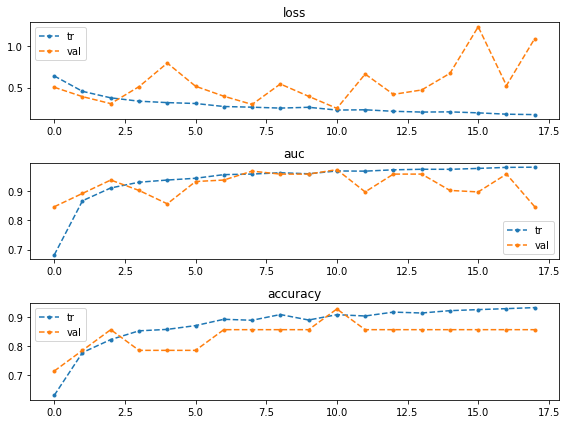

Found 23 validated image filenames belonging to 2 classes.


Found 14 validated image filenames belonging to 2 classes.

 fold: 1/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25
 27 29 30 32 33 34 35 36 37 39 40 42 43 44 45 46 47 48 49 51 52 53 54 55
 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72 75 76 78 79 80 81 83 84
 85 86 87 88 89 90 91] 
 Valid [ 7 17 26 28 31 38 41 50 71 73 74 77 82] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4810 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6942 - accuracy: 0.5127 - auc: 0.5208

 3/46 [>.............................] - ETA: 14s - loss: 0.6960 - accuracy: 0.5274 - auc: 0.5396

 4/46 [=>............................] - ETA: 16s - loss: 0.6945 - accuracy: 0.5348 - auc: 0.5434

 5/46 [==>...........................] - ETA: 17s - loss: 0.6927 - accuracy: 0.5392 - auc: 0.5489

 6/46 [==>...........................] - ETA: 17s - loss: 0.6929 - accuracy: 0.5422 - auc: 0.5507

 7/46 [===>..........................] - ETA: 17s - loss: 0.6927 - accuracy: 0.5443 - auc: 0.5514

 8/46 [====>.........................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5459 - auc: 0.5518

 9/46 [====>.........................] - ETA: 17s - loss: 0.6912 - accuracy: 0.5471 - auc: 0.5560

10/46 [=====>........................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5481 - auc: 0.5551

11/46 [======>.......................] - ETA: 17s - loss: 0.6901 - accuracy: 0.5489 - auc: 0.5576

12/46 [======>.......................] - ETA: 17s - loss: 0.6900 - accuracy: 0.5496 - auc: 0.5580

13/46 [=======>......................] - ETA: 16s - loss: 0.6897 - accuracy: 0.5492 - auc: 0.5591

14/46 [========>.....................] - ETA: 16s - loss: 0.6891 - accuracy: 0.5506 - auc: 0.5618

15/46 [========>.....................] - ETA: 15s - loss: 0.6894 - accuracy: 0.5494 - auc: 0.5605

16/46 [=========>....................] - ETA: 15s - loss: 0.6893 - accuracy: 0.5491 - auc: 0.5608

17/46 [==========>...................] - ETA: 14s - loss: 0.6889 - accuracy: 0.5488 - auc: 0.5625

18/46 [==========>...................] - ETA: 14s - loss: 0.6882 - accuracy: 0.5492 - auc: 0.5652

19/46 [===========>..................] - ETA: 14s - loss: 0.6874 - accuracy: 0.5530 - auc: 0.5683

20/46 [============>.................] - ETA: 13s - loss: 0.6865 - accuracy: 0.5538 - auc: 0.5707

21/46 [============>.................] - ETA: 13s - loss: 0.6849 - accuracy: 0.5570 - auc: 0.5763

22/46 [=============>................] - ETA: 12s - loss: 0.6842 - accuracy: 0.5575 - auc: 0.5773

23/46 [==============>...............] - ETA: 12s - loss: 0.6820 - accuracy: 0.5614 - auc: 0.5836

24/46 [==============>...............] - ETA: 11s - loss: 0.6809 - accuracy: 0.5638 - auc: 0.5856

25/46 [===============>..............] - ETA: 11s - loss: 0.6791 - accuracy: 0.5681 - auc: 0.5931

26/46 [===============>..............] - ETA: 10s - loss: 0.6760 - accuracy: 0.5721 - auc: 0.6011

27/46 [================>.............] - ETA: 9s - loss: 0.6736 - accuracy: 0.5771 - auc: 0.6083 

28/46 [=================>............] - ETA: 9s - loss: 0.6722 - accuracy: 0.5791 - auc: 0.6119

29/46 [=================>............] - ETA: 8s - loss: 0.6723 - accuracy: 0.5784 - auc: 0.6114

30/46 [==================>...........] - ETA: 8s - loss: 0.6689 - accuracy: 0.5810 - auc: 0.6175

31/46 [===================>..........] - ETA: 7s - loss: 0.6651 - accuracy: 0.5860 - auc: 0.6248

32/46 [===================>..........] - ETA: 7s - loss: 0.6616 - accuracy: 0.5914 - auc: 0.6326

33/46 [====================>.........] - ETA: 6s - loss: 0.6600 - accuracy: 0.5934 - auc: 0.6354

34/46 [=====================>........] - ETA: 6s - loss: 0.6572 - accuracy: 0.5968 - auc: 0.6397

35/46 [=====================>........] - ETA: 5s - loss: 0.6534 - accuracy: 0.5996 - auc: 0.6453

36/46 [======================>.......] - ETA: 5s - loss: 0.6490 - accuracy: 0.6041 - auc: 0.6520

37/46 [=======================>......] - ETA: 4s - loss: 0.6454 - accuracy: 0.6073 - auc: 0.6577

38/46 [=======================>......] - ETA: 4s - loss: 0.6408 - accuracy: 0.6113 - auc: 0.6637

39/46 [========================>.....] - ETA: 3s - loss: 0.6387 - accuracy: 0.6131 - auc: 0.6668

40/46 [=========================>....] - ETA: 3s - loss: 0.6366 - accuracy: 0.6161 - auc: 0.6714

41/46 [=========================>....] - ETA: 2s - loss: 0.6334 - accuracy: 0.6193 - auc: 0.6768

42/46 [==========================>...] - ETA: 2s - loss: 0.6306 - accuracy: 0.6224 - auc: 0.6811

43/46 [===========================>..] - ETA: 1s - loss: 0.6302 - accuracy: 0.6241 - auc: 0.6834

44/46 [===========================>..] - ETA: 1s - loss: 0.6276 - accuracy: 0.6269 - auc: 0.6873

45/46 [============================>.] - ETA: 0s - loss: 0.6244 - accuracy: 0.6298 - auc: 0.6920

46/46 [==============================] - ETA: 0s - loss: 0.6207 - accuracy: 0.6335 - auc: 0.6973

Found 13 validated image filenames belonging to 2 classes.



Epoch 00001: val_loss improved from inf to 0.33959, saving model to fold_1_best_model.hdf5
46/46 [==============================] - 25s 543ms/step - loss: 0.6207 - accuracy: 0.6335 - auc: 0.6973 - val_loss: 0.3396 - val_accuracy: 0.8462 - val_auc: 0.9290


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.4592 - accuracy: 0.8101 - auc: 0.8709

 2/46 [>.............................] - ETA: 12s - loss: 0.4504 - accuracy: 0.8291 - auc: 0.8762

 3/46 [>.............................] - ETA: 15s - loss: 0.4384 - accuracy: 0.8312 - auc: 0.8830

 4/46 [=>............................] - ETA: 17s - loss: 0.4509 - accuracy: 0.8133 - auc: 0.8715

 5/46 [==>...........................] - ETA: 17s - loss: 0.4463 - accuracy: 0.8152 - auc: 0.8759

 6/46 [==>...........................] - ETA: 18s - loss: 0.4531 - accuracy: 0.8038 - auc: 0.8717

 7/46 [===>..........................] - ETA: 18s - loss: 0.4500 - accuracy: 0.8047 - auc: 0.8727

 8/46 [====>.........................] - ETA: 18s - loss: 0.4585 - accuracy: 0.7991 - auc: 0.8680

 9/46 [====>.........................] - ETA: 18s - loss: 0.4552 - accuracy: 0.7961 - auc: 0.8699

10/46 [=====>........................] - ETA: 18s - loss: 0.4538 - accuracy: 0.7924 - auc: 0.8704

11/46 [======>.......................] - ETA: 17s - loss: 0.4462 - accuracy: 0.7929 - auc: 0.8743

12/46 [======>.......................] - ETA: 17s - loss: 0.4510 - accuracy: 0.7890 - auc: 0.8708

13/46 [=======>......................] - ETA: 16s - loss: 0.4511 - accuracy: 0.7887 - auc: 0.8704

14/46 [========>.....................] - ETA: 16s - loss: 0.4488 - accuracy: 0.7939 - auc: 0.8724

15/46 [========>.....................] - ETA: 16s - loss: 0.4483 - accuracy: 0.7932 - auc: 0.8728

16/46 [=========>....................] - ETA: 15s - loss: 0.4487 - accuracy: 0.7927 - auc: 0.8724

17/46 [==========>...................] - ETA: 15s - loss: 0.4467 - accuracy: 0.7937 - auc: 0.8735

18/46 [==========>...................] - ETA: 14s - loss: 0.4473 - accuracy: 0.7932 - auc: 0.8728

19/46 [===========>..................] - ETA: 14s - loss: 0.4431 - accuracy: 0.7961 - auc: 0.8753

20/46 [============>.................] - ETA: 13s - loss: 0.4380 - accuracy: 0.8006 - auc: 0.8785

21/46 [============>.................] - ETA: 13s - loss: 0.4410 - accuracy: 0.7993 - auc: 0.8770

22/46 [=============>................] - ETA: 12s - loss: 0.4407 - accuracy: 0.8009 - auc: 0.8779

23/46 [==============>...............] - ETA: 12s - loss: 0.4404 - accuracy: 0.8035 - auc: 0.8781

24/46 [==============>...............] - ETA: 11s - loss: 0.4381 - accuracy: 0.8038 - auc: 0.8793

25/46 [===============>..............] - ETA: 11s - loss: 0.4355 - accuracy: 0.8066 - auc: 0.8809

26/46 [===============>..............] - ETA: 10s - loss: 0.4337 - accuracy: 0.8043 - auc: 0.8816

27/46 [================>.............] - ETA: 10s - loss: 0.4344 - accuracy: 0.8045 - auc: 0.8815

28/46 [=================>............] - ETA: 9s - loss: 0.4372 - accuracy: 0.8020 - auc: 0.8798 

29/46 [=================>............] - ETA: 8s - loss: 0.4347 - accuracy: 0.8027 - auc: 0.8810

30/46 [==================>...........] - ETA: 8s - loss: 0.4331 - accuracy: 0.8042 - auc: 0.8821

31/46 [===================>..........] - ETA: 7s - loss: 0.4310 - accuracy: 0.8060 - auc: 0.8833

32/46 [===================>..........] - ETA: 7s - loss: 0.4311 - accuracy: 0.8046 - auc: 0.8831

33/46 [====================>.........] - ETA: 6s - loss: 0.4309 - accuracy: 0.8051 - auc: 0.8832

34/46 [=====================>........] - ETA: 6s - loss: 0.4321 - accuracy: 0.8049 - auc: 0.8827

35/46 [=====================>........] - ETA: 5s - loss: 0.4309 - accuracy: 0.8058 - auc: 0.8833

36/46 [======================>.......] - ETA: 5s - loss: 0.4270 - accuracy: 0.8087 - auc: 0.8857

37/46 [=======================>......] - ETA: 4s - loss: 0.4283 - accuracy: 0.8084 - auc: 0.8854

38/46 [=======================>......] - ETA: 4s - loss: 0.4264 - accuracy: 0.8091 - auc: 0.8864

39/46 [========================>.....] - ETA: 3s - loss: 0.4260 - accuracy: 0.8105 - auc: 0.8869

40/46 [=========================>....] - ETA: 3s - loss: 0.4249 - accuracy: 0.8095 - auc: 0.8874

41/46 [=========================>....] - ETA: 2s - loss: 0.4251 - accuracy: 0.8104 - auc: 0.8873

42/46 [==========================>...] - ETA: 2s - loss: 0.4247 - accuracy: 0.8101 - auc: 0.8876

43/46 [===========================>..] - ETA: 1s - loss: 0.4222 - accuracy: 0.8113 - auc: 0.8889

44/46 [===========================>..] - ETA: 1s - loss: 0.4207 - accuracy: 0.8116 - auc: 0.8896

45/46 [============================>.] - ETA: 0s - loss: 0.4204 - accuracy: 0.8113 - auc: 0.8899

46/46 [==============================] - ETA: 0s - loss: 0.4198 - accuracy: 0.8112 - auc: 0.8902

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss improved from 0.33959 to 0.19761, saving model to fold_1_best_model.hdf5


46/46 [==============================] - 25s 539ms/step - loss: 0.4198 - accuracy: 0.8112 - auc: 0.8902 - val_loss: 0.1976 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.4019 - accuracy: 0.8228 - auc: 0.9087

 2/46 [>.............................] - ETA: 11s - loss: 0.3546 - accuracy: 0.8418 - auc: 0.9264

 3/46 [>.............................] - ETA: 15s - loss: 0.3472 - accuracy: 0.8523 - auc: 0.9292

 4/46 [=>............................] - ETA: 17s - loss: 0.3885 - accuracy: 0.8228 - auc: 0.9109

 5/46 [==>...........................] - ETA: 17s - loss: 0.3849 - accuracy: 0.8304 - auc: 0.9128

 6/46 [==>...........................] - ETA: 18s - loss: 0.3890 - accuracy: 0.8291 - auc: 0.9103

 7/46 [===>..........................] - ETA: 18s - loss: 0.3906 - accuracy: 0.8354 - auc: 0.9113

 8/46 [====>.........................] - ETA: 18s - loss: 0.3766 - accuracy: 0.8402 - auc: 0.9175

 9/46 [====>.........................] - ETA: 17s - loss: 0.3673 - accuracy: 0.8495 - auc: 0.9220

10/46 [=====>........................] - ETA: 17s - loss: 0.3647 - accuracy: 0.8519 - auc: 0.9228

11/46 [======>.......................] - ETA: 17s - loss: 0.3674 - accuracy: 0.8481 - auc: 0.9210

12/46 [======>.......................] - ETA: 16s - loss: 0.3620 - accuracy: 0.8513 - auc: 0.9231

13/46 [=======>......................] - ETA: 16s - loss: 0.3562 - accuracy: 0.8539 - auc: 0.9254

14/46 [========>.....................] - ETA: 16s - loss: 0.3554 - accuracy: 0.8544 - auc: 0.9253

15/46 [========>.....................] - ETA: 15s - loss: 0.3519 - accuracy: 0.8549 - auc: 0.9269

16/46 [=========>....................] - ETA: 15s - loss: 0.3521 - accuracy: 0.8513 - auc: 0.9269

17/46 [==========>...................] - ETA: 14s - loss: 0.3462 - accuracy: 0.8548 - auc: 0.9293

18/46 [==========>...................] - ETA: 14s - loss: 0.3473 - accuracy: 0.8509 - auc: 0.9282

19/46 [===========>..................] - ETA: 14s - loss: 0.3534 - accuracy: 0.8488 - auc: 0.9255

20/46 [============>.................] - ETA: 13s - loss: 0.3485 - accuracy: 0.8519 - auc: 0.9275

21/46 [============>.................] - ETA: 13s - loss: 0.3441 - accuracy: 0.8547 - auc: 0.9294

22/46 [=============>................] - ETA: 12s - loss: 0.3378 - accuracy: 0.8573 - auc: 0.9320

23/46 [==============>...............] - ETA: 12s - loss: 0.3396 - accuracy: 0.8569 - auc: 0.9317

24/46 [==============>...............] - ETA: 11s - loss: 0.3362 - accuracy: 0.8597 - auc: 0.9334

25/46 [===============>..............] - ETA: 11s - loss: 0.3345 - accuracy: 0.8608 - auc: 0.9340

26/46 [===============>..............] - ETA: 10s - loss: 0.3311 - accuracy: 0.8622 - auc: 0.9352

27/46 [================>.............] - ETA: 10s - loss: 0.3295 - accuracy: 0.8636 - auc: 0.9358

28/46 [=================>............] - ETA: 9s - loss: 0.3294 - accuracy: 0.8635 - auc: 0.9358 

29/46 [=================>............] - ETA: 9s - loss: 0.3304 - accuracy: 0.8629 - auc: 0.9351

30/46 [==================>...........] - ETA: 8s - loss: 0.3298 - accuracy: 0.8629 - auc: 0.9353

31/46 [===================>..........] - ETA: 8s - loss: 0.3281 - accuracy: 0.8636 - auc: 0.9360

32/46 [===================>..........] - ETA: 7s - loss: 0.3282 - accuracy: 0.8647 - auc: 0.9361

33/46 [====================>.........] - ETA: 6s - loss: 0.3285 - accuracy: 0.8638 - auc: 0.9360

34/46 [=====================>........] - ETA: 6s - loss: 0.3297 - accuracy: 0.8626 - auc: 0.9354

35/46 [=====================>........] - ETA: 5s - loss: 0.3278 - accuracy: 0.8633 - auc: 0.9361

36/46 [======================>.......] - ETA: 5s - loss: 0.3290 - accuracy: 0.8629 - auc: 0.9356

37/46 [=======================>......] - ETA: 4s - loss: 0.3278 - accuracy: 0.8632 - auc: 0.9361

38/46 [=======================>......] - ETA: 4s - loss: 0.3250 - accuracy: 0.8641 - auc: 0.9373

39/46 [========================>.....] - ETA: 3s - loss: 0.3235 - accuracy: 0.8650 - auc: 0.9378

40/46 [=========================>....] - ETA: 3s - loss: 0.3278 - accuracy: 0.8636 - auc: 0.9363

41/46 [=========================>....] - ETA: 2s - loss: 0.3284 - accuracy: 0.8626 - auc: 0.9359

42/46 [==========================>...] - ETA: 2s - loss: 0.3278 - accuracy: 0.8623 - auc: 0.9361

43/46 [===========================>..] - ETA: 1s - loss: 0.3280 - accuracy: 0.8608 - auc: 0.9359

44/46 [===========================>..] - ETA: 1s - loss: 0.3281 - accuracy: 0.8605 - auc: 0.9358

45/46 [============================>.] - ETA: 0s - loss: 0.3321 - accuracy: 0.8594 - auc: 0.9343

46/46 [==============================] - ETA: 0s - loss: 0.3318 - accuracy: 0.8602 - auc: 0.9345

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss improved from 0.19761 to 0.12196, saving model to fold_1_best_model.hdf5


46/46 [==============================] - 25s 544ms/step - loss: 0.3318 - accuracy: 0.8602 - auc: 0.9345 - val_loss: 0.1220 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3159 - accuracy: 0.8481 - auc: 0.9399

 2/46 [>.............................] - ETA: 11s - loss: 0.2932 - accuracy: 0.8797 - auc: 0.9484

 3/46 [>.............................] - ETA: 15s - loss: 0.2720 - accuracy: 0.8903 - auc: 0.9603

 4/46 [=>............................] - ETA: 17s - loss: 0.2806 - accuracy: 0.8829 - auc: 0.9552

 5/46 [==>...........................] - ETA: 17s - loss: 0.2841 - accuracy: 0.8810 - auc: 0.9537

 6/46 [==>...........................] - ETA: 18s - loss: 0.2871 - accuracy: 0.8861 - auc: 0.9524

 7/46 [===>..........................] - ETA: 18s - loss: 0.2898 - accuracy: 0.8770 - auc: 0.9507

 8/46 [====>.........................] - ETA: 17s - loss: 0.2833 - accuracy: 0.8797 - auc: 0.9527

 9/46 [====>.........................] - ETA: 17s - loss: 0.2852 - accuracy: 0.8748 - auc: 0.9514

10/46 [=====>........................] - ETA: 17s - loss: 0.2808 - accuracy: 0.8772 - auc: 0.9529

11/46 [======>.......................] - ETA: 17s - loss: 0.2833 - accuracy: 0.8734 - auc: 0.9515

12/46 [======>.......................] - ETA: 16s - loss: 0.2907 - accuracy: 0.8681 - auc: 0.9484

13/46 [=======>......................] - ETA: 16s - loss: 0.2822 - accuracy: 0.8734 - auc: 0.9516

14/46 [========>.....................] - ETA: 15s - loss: 0.2848 - accuracy: 0.8707 - auc: 0.9505

15/46 [========>.....................] - ETA: 15s - loss: 0.2892 - accuracy: 0.8692 - auc: 0.9489

16/46 [=========>....................] - ETA: 15s - loss: 0.2908 - accuracy: 0.8695 - auc: 0.9485

17/46 [==========>...................] - ETA: 14s - loss: 0.2887 - accuracy: 0.8719 - auc: 0.9493

18/46 [==========>...................] - ETA: 14s - loss: 0.2872 - accuracy: 0.8727 - auc: 0.9499

19/46 [===========>..................] - ETA: 13s - loss: 0.2885 - accuracy: 0.8721 - auc: 0.9493

20/46 [============>.................] - ETA: 13s - loss: 0.2928 - accuracy: 0.8703 - auc: 0.9479

21/46 [============>.................] - ETA: 12s - loss: 0.2937 - accuracy: 0.8722 - auc: 0.9476

22/46 [=============>................] - ETA: 12s - loss: 0.2939 - accuracy: 0.8728 - auc: 0.9476

23/46 [==============>...............] - ETA: 11s - loss: 0.2952 - accuracy: 0.8718 - auc: 0.9471

24/46 [==============>...............] - ETA: 11s - loss: 0.3009 - accuracy: 0.8708 - auc: 0.9451

25/46 [===============>..............] - ETA: 10s - loss: 0.3008 - accuracy: 0.8704 - auc: 0.9452

26/46 [===============>..............] - ETA: 10s - loss: 0.3014 - accuracy: 0.8700 - auc: 0.9450

27/46 [================>.............] - ETA: 9s - loss: 0.3023 - accuracy: 0.8683 - auc: 0.9446 

28/46 [=================>............] - ETA: 9s - loss: 0.2998 - accuracy: 0.8689 - auc: 0.9455

29/46 [=================>............] - ETA: 8s - loss: 0.2970 - accuracy: 0.8699 - auc: 0.9466

30/46 [==================>...........] - ETA: 8s - loss: 0.2946 - accuracy: 0.8705 - auc: 0.9475

31/46 [===================>..........] - ETA: 7s - loss: 0.3033 - accuracy: 0.8689 - auc: 0.9447

32/46 [===================>..........] - ETA: 7s - loss: 0.3031 - accuracy: 0.8695 - auc: 0.9448

33/46 [====================>.........] - ETA: 6s - loss: 0.3042 - accuracy: 0.8700 - auc: 0.9445

34/46 [=====================>........] - ETA: 6s - loss: 0.3018 - accuracy: 0.8712 - auc: 0.9454

35/46 [=====================>........] - ETA: 5s - loss: 0.3025 - accuracy: 0.8698 - auc: 0.9452

36/46 [======================>.......] - ETA: 5s - loss: 0.3007 - accuracy: 0.8710 - auc: 0.9458

37/46 [=======================>......] - ETA: 4s - loss: 0.3028 - accuracy: 0.8707 - auc: 0.9451

38/46 [=======================>......] - ETA: 4s - loss: 0.3039 - accuracy: 0.8694 - auc: 0.9446

39/46 [========================>.....] - ETA: 3s - loss: 0.3037 - accuracy: 0.8695 - auc: 0.9447

40/46 [=========================>....] - ETA: 3s - loss: 0.3047 - accuracy: 0.8687 - auc: 0.9443

41/46 [=========================>....] - ETA: 2s - loss: 0.3041 - accuracy: 0.8694 - auc: 0.9445

42/46 [==========================>...] - ETA: 2s - loss: 0.3053 - accuracy: 0.8689 - auc: 0.9441

43/46 [===========================>..] - ETA: 1s - loss: 0.3037 - accuracy: 0.8696 - auc: 0.9447

44/46 [===========================>..] - ETA: 1s - loss: 0.3039 - accuracy: 0.8697 - auc: 0.9447

45/46 [============================>.] - ETA: 0s - loss: 0.3015 - accuracy: 0.8703 - auc: 0.9455

46/46 [==============================] - ETA: 0s - loss: 0.3043 - accuracy: 0.8698 - auc: 0.9445

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss improved from 0.12196 to 0.09310, saving model to fold_1_best_model.hdf5


46/46 [==============================] - 25s 538ms/step - loss: 0.3043 - accuracy: 0.8698 - auc: 0.9445 - val_loss: 0.0931 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.2785 - accuracy: 0.9241 - auc: 0.9577

 2/46 [>.............................] - ETA: 12s - loss: 0.2590 - accuracy: 0.9051 - auc: 0.9609

 3/46 [>.............................] - ETA: 15s - loss: 0.2640 - accuracy: 0.8819 - auc: 0.9594

 4/46 [=>............................] - ETA: 17s - loss: 0.2497 - accuracy: 0.8829 - auc: 0.9644

 5/46 [==>...........................] - ETA: 17s - loss: 0.2411 - accuracy: 0.8861 - auc: 0.9667

 6/46 [==>...........................] - ETA: 17s - loss: 0.2345 - accuracy: 0.8924 - auc: 0.9686

 7/46 [===>..........................] - ETA: 17s - loss: 0.2455 - accuracy: 0.8897 - auc: 0.9646

 8/46 [====>.........................] - ETA: 17s - loss: 0.2522 - accuracy: 0.8956 - auc: 0.9623

 9/46 [====>.........................] - ETA: 17s - loss: 0.2604 - accuracy: 0.8917 - auc: 0.9595

10/46 [=====>........................] - ETA: 17s - loss: 0.2603 - accuracy: 0.8924 - auc: 0.9594

11/46 [======>.......................] - ETA: 17s - loss: 0.2588 - accuracy: 0.8918 - auc: 0.9598

12/46 [======>.......................] - ETA: 16s - loss: 0.2671 - accuracy: 0.8903 - auc: 0.9574

13/46 [=======>......................] - ETA: 16s - loss: 0.2700 - accuracy: 0.8880 - auc: 0.9565

14/46 [========>.....................] - ETA: 15s - loss: 0.2666 - accuracy: 0.8906 - auc: 0.9576

15/46 [========>.....................] - ETA: 15s - loss: 0.2660 - accuracy: 0.8903 - auc: 0.9578

16/46 [=========>....................] - ETA: 15s - loss: 0.2690 - accuracy: 0.8892 - auc: 0.9568

17/46 [==========>...................] - ETA: 14s - loss: 0.2632 - accuracy: 0.8928 - auc: 0.9588

18/46 [==========>...................] - ETA: 14s - loss: 0.2675 - accuracy: 0.8924 - auc: 0.9577

19/46 [===========>..................] - ETA: 13s - loss: 0.2697 - accuracy: 0.8901 - auc: 0.9569

20/46 [============>.................] - ETA: 13s - loss: 0.2734 - accuracy: 0.8867 - auc: 0.9556

21/46 [============>.................] - ETA: 12s - loss: 0.2722 - accuracy: 0.8861 - auc: 0.9560

22/46 [=============>................] - ETA: 12s - loss: 0.2688 - accuracy: 0.8867 - auc: 0.9571

23/46 [==============>...............] - ETA: 11s - loss: 0.2800 - accuracy: 0.8828 - auc: 0.9537

24/46 [==============>...............] - ETA: 11s - loss: 0.2770 - accuracy: 0.8845 - auc: 0.9548

25/46 [===============>..............] - ETA: 10s - loss: 0.2765 - accuracy: 0.8856 - auc: 0.9550

26/46 [===============>..............] - ETA: 10s - loss: 0.2748 - accuracy: 0.8866 - auc: 0.9555

27/46 [================>.............] - ETA: 9s - loss: 0.2746 - accuracy: 0.8865 - auc: 0.9556 

28/46 [=================>............] - ETA: 9s - loss: 0.2743 - accuracy: 0.8861 - auc: 0.9558

29/46 [=================>............] - ETA: 8s - loss: 0.2760 - accuracy: 0.8865 - auc: 0.9552

30/46 [==================>...........] - ETA: 8s - loss: 0.2749 - accuracy: 0.8865 - auc: 0.9555

31/46 [===================>..........] - ETA: 7s - loss: 0.2807 - accuracy: 0.8853 - auc: 0.9537

32/46 [===================>..........] - ETA: 7s - loss: 0.2820 - accuracy: 0.8849 - auc: 0.9532

33/46 [====================>.........] - ETA: 6s - loss: 0.2787 - accuracy: 0.8857 - auc: 0.9544

34/46 [=====================>........] - ETA: 6s - loss: 0.2796 - accuracy: 0.8861 - auc: 0.9541

35/46 [=====================>........] - ETA: 5s - loss: 0.2782 - accuracy: 0.8857 - auc: 0.9545

36/46 [======================>.......] - ETA: 5s - loss: 0.2774 - accuracy: 0.8847 - auc: 0.9547

37/46 [=======================>......] - ETA: 4s - loss: 0.2764 - accuracy: 0.8844 - auc: 0.9550

38/46 [=======================>......] - ETA: 4s - loss: 0.2752 - accuracy: 0.8851 - auc: 0.9553

39/46 [========================>.....] - ETA: 3s - loss: 0.2745 - accuracy: 0.8854 - auc: 0.9555

40/46 [=========================>....] - ETA: 3s - loss: 0.2743 - accuracy: 0.8848 - auc: 0.9555

41/46 [=========================>....] - ETA: 2s - loss: 0.2733 - accuracy: 0.8848 - auc: 0.9558

42/46 [==========================>...] - ETA: 2s - loss: 0.2736 - accuracy: 0.8858 - auc: 0.9558

43/46 [===========================>..] - ETA: 1s - loss: 0.2747 - accuracy: 0.8846 - auc: 0.9554

44/46 [===========================>..] - ETA: 1s - loss: 0.2741 - accuracy: 0.8849 - auc: 0.9556

45/46 [============================>.] - ETA: 0s - loss: 0.2716 - accuracy: 0.8869 - auc: 0.9565

46/46 [==============================] - ETA: 0s - loss: 0.2705 - accuracy: 0.8877 - auc: 0.9569

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss improved from 0.09310 to 0.06868, saving model to fold_1_best_model.hdf5


46/46 [==============================] - 25s 535ms/step - loss: 0.2705 - accuracy: 0.8877 - auc: 0.9569 - val_loss: 0.0687 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2484 - accuracy: 0.8861 - auc: 0.9644

 2/46 [>.............................] - ETA: 11s - loss: 0.2885 - accuracy: 0.8608 - auc: 0.9498

 3/46 [>.............................] - ETA: 15s - loss: 0.3131 - accuracy: 0.8481 - auc: 0.9420

 4/46 [=>............................] - ETA: 16s - loss: 0.2889 - accuracy: 0.8671 - auc: 0.9510

 5/46 [==>...........................] - ETA: 18s - loss: 0.2791 - accuracy: 0.8684 - auc: 0.9539

 6/46 [==>...........................] - ETA: 19s - loss: 0.2753 - accuracy: 0.8713 - auc: 0.9550

 7/46 [===>..........................] - ETA: 19s - loss: 0.2660 - accuracy: 0.8807 - auc: 0.9579

 8/46 [====>.........................] - ETA: 18s - loss: 0.2599 - accuracy: 0.8845 - auc: 0.9600

 9/46 [====>.........................] - ETA: 18s - loss: 0.2588 - accuracy: 0.8861 - auc: 0.9603

10/46 [=====>........................] - ETA: 18s - loss: 0.2571 - accuracy: 0.8899 - auc: 0.9610

11/46 [======>.......................] - ETA: 17s - loss: 0.2524 - accuracy: 0.8884 - auc: 0.9622

12/46 [======>.......................] - ETA: 17s - loss: 0.2458 - accuracy: 0.8935 - auc: 0.9645

13/46 [=======>......................] - ETA: 16s - loss: 0.2443 - accuracy: 0.8909 - auc: 0.9646

14/46 [========>.....................] - ETA: 16s - loss: 0.2433 - accuracy: 0.8924 - auc: 0.9650

15/46 [========>.....................] - ETA: 15s - loss: 0.2411 - accuracy: 0.8945 - auc: 0.9656

16/46 [=========>....................] - ETA: 15s - loss: 0.2546 - accuracy: 0.8932 - auc: 0.9625

17/46 [==========>...................] - ETA: 14s - loss: 0.2666 - accuracy: 0.8905 - auc: 0.9597

18/46 [==========>...................] - ETA: 14s - loss: 0.2660 - accuracy: 0.8896 - auc: 0.9598

19/46 [===========>..................] - ETA: 13s - loss: 0.2643 - accuracy: 0.8921 - auc: 0.9603

20/46 [============>.................] - ETA: 13s - loss: 0.2674 - accuracy: 0.8924 - auc: 0.9594

21/46 [============>.................] - ETA: 12s - loss: 0.2665 - accuracy: 0.8939 - auc: 0.9596

22/46 [=============>................] - ETA: 12s - loss: 0.2664 - accuracy: 0.8930 - auc: 0.9595

23/46 [==============>...............] - ETA: 12s - loss: 0.2672 - accuracy: 0.8921 - auc: 0.9591

24/46 [==============>...............] - ETA: 11s - loss: 0.2676 - accuracy: 0.8914 - auc: 0.9590

25/46 [===============>..............] - ETA: 10s - loss: 0.2697 - accuracy: 0.8901 - auc: 0.9583

26/46 [===============>..............] - ETA: 10s - loss: 0.2684 - accuracy: 0.8905 - auc: 0.9586

27/46 [================>.............] - ETA: 9s - loss: 0.2703 - accuracy: 0.8889 - auc: 0.9580 

28/46 [=================>............] - ETA: 9s - loss: 0.2709 - accuracy: 0.8879 - auc: 0.9577

29/46 [=================>............] - ETA: 8s - loss: 0.2707 - accuracy: 0.8874 - auc: 0.9576

30/46 [==================>...........] - ETA: 8s - loss: 0.2717 - accuracy: 0.8873 - auc: 0.9573

31/46 [===================>..........] - ETA: 7s - loss: 0.2709 - accuracy: 0.8881 - auc: 0.9575

32/46 [===================>..........] - ETA: 7s - loss: 0.2704 - accuracy: 0.8888 - auc: 0.9577

33/46 [====================>.........] - ETA: 6s - loss: 0.2708 - accuracy: 0.8888 - auc: 0.9575

34/46 [=====================>........] - ETA: 6s - loss: 0.2711 - accuracy: 0.8883 - auc: 0.9573

35/46 [=====================>........] - ETA: 5s - loss: 0.2697 - accuracy: 0.8886 - auc: 0.9577

36/46 [======================>.......] - ETA: 5s - loss: 0.2669 - accuracy: 0.8896 - auc: 0.9586

37/46 [=======================>......] - ETA: 4s - loss: 0.2691 - accuracy: 0.8885 - auc: 0.9579

38/46 [=======================>......] - ETA: 4s - loss: 0.2673 - accuracy: 0.8891 - auc: 0.9584

39/46 [========================>.....] - ETA: 3s - loss: 0.2675 - accuracy: 0.8893 - auc: 0.9584

40/46 [=========================>....] - ETA: 3s - loss: 0.2674 - accuracy: 0.8896 - auc: 0.9584

41/46 [=========================>....] - ETA: 2s - loss: 0.2672 - accuracy: 0.8901 - auc: 0.9587

42/46 [==========================>...] - ETA: 2s - loss: 0.2677 - accuracy: 0.8903 - auc: 0.9586

43/46 [===========================>..] - ETA: 1s - loss: 0.2666 - accuracy: 0.8905 - auc: 0.9589

44/46 [===========================>..] - ETA: 1s - loss: 0.2685 - accuracy: 0.8887 - auc: 0.9582

45/46 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.8886 - auc: 0.9582

46/46 [==============================] - ETA: 0s - loss: 0.2675 - accuracy: 0.8891 - auc: 0.9585

Found 13 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss did not improve from 0.06868
46/46 [==============================] - 25s 534ms/step - loss: 0.2675 - accuracy: 0.8891 - auc: 0.9585 - val_loss: 0.0936 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.2400 - accuracy: 0.9114 - auc: 0.9692

 2/46 [>.............................] - ETA: 12s - loss: 0.2707 - accuracy: 0.9114 - auc: 0.9620

 3/46 [>.............................] - ETA: 18s - loss: 0.2422 - accuracy: 0.9156 - auc: 0.9713

 4/46 [=>............................] - ETA: 19s - loss: 0.2402 - accuracy: 0.9051 - auc: 0.9698

 5/46 [==>...........................] - ETA: 19s - loss: 0.2348 - accuracy: 0.9114 - auc: 0.9715

 6/46 [==>...........................] - ETA: 19s - loss: 0.2425 - accuracy: 0.9051 - auc: 0.9689

 7/46 [===>..........................] - ETA: 19s - loss: 0.2458 - accuracy: 0.9042 - auc: 0.9670

 8/46 [====>.........................] - ETA: 19s - loss: 0.2401 - accuracy: 0.9098 - auc: 0.9691

 9/46 [====>.........................] - ETA: 18s - loss: 0.2334 - accuracy: 0.9142 - auc: 0.9712

10/46 [=====>........................] - ETA: 18s - loss: 0.2322 - accuracy: 0.9139 - auc: 0.9711

11/46 [======>.......................] - ETA: 17s - loss: 0.2385 - accuracy: 0.9102 - auc: 0.9685

12/46 [======>.......................] - ETA: 17s - loss: 0.2421 - accuracy: 0.9040 - auc: 0.9669

13/46 [=======>......................] - ETA: 16s - loss: 0.2496 - accuracy: 0.8987 - auc: 0.9643

14/46 [========>.....................] - ETA: 16s - loss: 0.2646 - accuracy: 0.8933 - auc: 0.9599

15/46 [========>.....................] - ETA: 16s - loss: 0.2606 - accuracy: 0.8945 - auc: 0.9612

16/46 [=========>....................] - ETA: 15s - loss: 0.2554 - accuracy: 0.8979 - auc: 0.9627

17/46 [==========>...................] - ETA: 15s - loss: 0.2555 - accuracy: 0.8980 - auc: 0.9626

18/46 [==========>...................] - ETA: 14s - loss: 0.2548 - accuracy: 0.8980 - auc: 0.9627

19/46 [===========>..................] - ETA: 14s - loss: 0.2523 - accuracy: 0.8987 - auc: 0.9633

20/46 [============>.................] - ETA: 13s - loss: 0.2515 - accuracy: 0.8981 - auc: 0.9635

21/46 [============>.................] - ETA: 13s - loss: 0.2564 - accuracy: 0.8951 - auc: 0.9619

22/46 [=============>................] - ETA: 12s - loss: 0.2592 - accuracy: 0.8924 - auc: 0.9609

23/46 [==============>...............] - ETA: 12s - loss: 0.2582 - accuracy: 0.8938 - auc: 0.9612

24/46 [==============>...............] - ETA: 11s - loss: 0.2598 - accuracy: 0.8919 - auc: 0.9606

25/46 [===============>..............] - ETA: 11s - loss: 0.2572 - accuracy: 0.8927 - auc: 0.9614

26/46 [===============>..............] - ETA: 10s - loss: 0.2558 - accuracy: 0.8934 - auc: 0.9618

27/46 [================>.............] - ETA: 10s - loss: 0.2538 - accuracy: 0.8945 - auc: 0.9624

28/46 [=================>............] - ETA: 9s - loss: 0.2550 - accuracy: 0.8956 - auc: 0.9622 

29/46 [=================>............] - ETA: 8s - loss: 0.2589 - accuracy: 0.8952 - auc: 0.9615

30/46 [==================>...........] - ETA: 8s - loss: 0.2600 - accuracy: 0.8958 - auc: 0.9614

31/46 [===================>..........] - ETA: 7s - loss: 0.2584 - accuracy: 0.8971 - auc: 0.9619

32/46 [===================>..........] - ETA: 7s - loss: 0.2602 - accuracy: 0.8972 - auc: 0.9614

33/46 [====================>.........] - ETA: 6s - loss: 0.2592 - accuracy: 0.8984 - auc: 0.9617

34/46 [=====================>........] - ETA: 6s - loss: 0.2594 - accuracy: 0.8991 - auc: 0.9617

35/46 [=====================>........] - ETA: 5s - loss: 0.2613 - accuracy: 0.8987 - auc: 0.9611

36/46 [======================>.......] - ETA: 5s - loss: 0.2619 - accuracy: 0.8980 - auc: 0.9609

37/46 [=======================>......] - ETA: 4s - loss: 0.2613 - accuracy: 0.8984 - auc: 0.9611

38/46 [=======================>......] - ETA: 4s - loss: 0.2592 - accuracy: 0.8997 - auc: 0.9617

39/46 [========================>.....] - ETA: 3s - loss: 0.2585 - accuracy: 0.9000 - auc: 0.9620

40/46 [=========================>....] - ETA: 3s - loss: 0.2607 - accuracy: 0.9000 - auc: 0.9614

41/46 [=========================>....] - ETA: 2s - loss: 0.2602 - accuracy: 0.8994 - auc: 0.9615

42/46 [==========================>...] - ETA: 2s - loss: 0.2589 - accuracy: 0.8999 - auc: 0.9619

43/46 [===========================>..] - ETA: 1s - loss: 0.2571 - accuracy: 0.9002 - auc: 0.9624

44/46 [===========================>..] - ETA: 1s - loss: 0.2549 - accuracy: 0.9010 - auc: 0.9630

45/46 [============================>.] - ETA: 0s - loss: 0.2532 - accuracy: 0.9010 - auc: 0.9635

46/46 [==============================] - ETA: 0s - loss: 0.2563 - accuracy: 0.9001 - auc: 0.9627

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss improved from 0.06868 to 0.03943, saving model to fold_1_best_model.hdf5


46/46 [==============================] - 25s 539ms/step - loss: 0.2563 - accuracy: 0.9001 - auc: 0.9627 - val_loss: 0.0394 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.2182 - accuracy: 0.9241 - auc: 0.9680

 2/46 [>.............................] - ETA: 11s - loss: 0.2220 - accuracy: 0.9241 - auc: 0.9716

 3/46 [>.............................] - ETA: 15s - loss: 0.2490 - accuracy: 0.9114 - auc: 0.9639

 4/46 [=>............................] - ETA: 17s - loss: 0.2652 - accuracy: 0.8987 - auc: 0.9592

 5/46 [==>...........................] - ETA: 17s - loss: 0.2554 - accuracy: 0.9038 - auc: 0.9621

 6/46 [==>...........................] - ETA: 18s - loss: 0.2387 - accuracy: 0.9072 - auc: 0.9667

 7/46 [===>..........................] - ETA: 18s - loss: 0.2306 - accuracy: 0.9060 - auc: 0.9690

 8/46 [====>.........................] - ETA: 18s - loss: 0.2512 - accuracy: 0.8924 - auc: 0.9634

 9/46 [====>.........................] - ETA: 17s - loss: 0.2456 - accuracy: 0.8959 - auc: 0.9648

10/46 [=====>........................] - ETA: 17s - loss: 0.2419 - accuracy: 0.8937 - auc: 0.9657

11/46 [======>.......................] - ETA: 17s - loss: 0.2431 - accuracy: 0.8930 - auc: 0.9653

12/46 [======>.......................] - ETA: 17s - loss: 0.2444 - accuracy: 0.8914 - auc: 0.9648

13/46 [=======>......................] - ETA: 17s - loss: 0.2460 - accuracy: 0.8929 - auc: 0.9645

14/46 [========>.....................] - ETA: 16s - loss: 0.2434 - accuracy: 0.8960 - auc: 0.9654

15/46 [========>.....................] - ETA: 16s - loss: 0.2376 - accuracy: 0.8987 - auc: 0.9671

16/46 [=========>....................] - ETA: 15s - loss: 0.2470 - accuracy: 0.8979 - auc: 0.9645

17/46 [==========>...................] - ETA: 15s - loss: 0.2515 - accuracy: 0.8987 - auc: 0.9639

18/46 [==========>...................] - ETA: 14s - loss: 0.2492 - accuracy: 0.8994 - auc: 0.9645

19/46 [===========>..................] - ETA: 14s - loss: 0.2538 - accuracy: 0.8974 - auc: 0.9631

20/46 [============>.................] - ETA: 13s - loss: 0.2568 - accuracy: 0.8956 - auc: 0.9622

21/46 [============>.................] - ETA: 13s - loss: 0.2557 - accuracy: 0.8969 - auc: 0.9625

22/46 [=============>................] - ETA: 12s - loss: 0.2522 - accuracy: 0.8993 - auc: 0.9635

23/46 [==============>...............] - ETA: 12s - loss: 0.2536 - accuracy: 0.9004 - auc: 0.9631

24/46 [==============>...............] - ETA: 11s - loss: 0.2539 - accuracy: 0.8987 - auc: 0.9630

25/46 [===============>..............] - ETA: 11s - loss: 0.2520 - accuracy: 0.8987 - auc: 0.9635

26/46 [===============>..............] - ETA: 10s - loss: 0.2506 - accuracy: 0.9002 - auc: 0.9640

27/46 [================>.............] - ETA: 10s - loss: 0.2476 - accuracy: 0.9020 - auc: 0.9648

28/46 [=================>............] - ETA: 9s - loss: 0.2459 - accuracy: 0.9033 - auc: 0.9653 

29/46 [=================>............] - ETA: 9s - loss: 0.2449 - accuracy: 0.9035 - auc: 0.9655

30/46 [==================>...........] - ETA: 8s - loss: 0.2451 - accuracy: 0.9017 - auc: 0.9653

31/46 [===================>..........] - ETA: 8s - loss: 0.2437 - accuracy: 0.9020 - auc: 0.9657

32/46 [===================>..........] - ETA: 7s - loss: 0.2431 - accuracy: 0.9035 - auc: 0.9662

33/46 [====================>.........] - ETA: 6s - loss: 0.2424 - accuracy: 0.9045 - auc: 0.9663

34/46 [=====================>........] - ETA: 6s - loss: 0.2404 - accuracy: 0.9047 - auc: 0.9669

35/46 [=====================>........] - ETA: 5s - loss: 0.2410 - accuracy: 0.9038 - auc: 0.9667

36/46 [======================>.......] - ETA: 5s - loss: 0.2430 - accuracy: 0.9019 - auc: 0.9661

37/46 [=======================>......] - ETA: 4s - loss: 0.2405 - accuracy: 0.9025 - auc: 0.9667

38/46 [=======================>......] - ETA: 4s - loss: 0.2395 - accuracy: 0.9034 - auc: 0.9670

39/46 [========================>.....] - ETA: 3s - loss: 0.2372 - accuracy: 0.9046 - auc: 0.9676

40/46 [=========================>....] - ETA: 3s - loss: 0.2381 - accuracy: 0.9035 - auc: 0.9673

41/46 [=========================>....] - ETA: 2s - loss: 0.2378 - accuracy: 0.9034 - auc: 0.9673

42/46 [==========================>...] - ETA: 2s - loss: 0.2371 - accuracy: 0.9036 - auc: 0.9675

43/46 [===========================>..] - ETA: 1s - loss: 0.2372 - accuracy: 0.9040 - auc: 0.9675

44/46 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9030 - auc: 0.9674

45/46 [============================>.] - ETA: 0s - loss: 0.2398 - accuracy: 0.9027 - auc: 0.9668

46/46 [==============================] - ETA: 0s - loss: 0.2389 - accuracy: 0.9037 - auc: 0.9671

Found 13 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 543ms/step - loss: 0.2389 - accuracy: 0.9037 - auc: 0.9671 - val_loss: 0.0544 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.1536 - accuracy: 0.9494 - auc: 0.9921

 2/46 [>.............................] - ETA: 12s - loss: 0.2115 - accuracy: 0.9177 - auc: 0.9753

 3/46 [>.............................] - ETA: 15s - loss: 0.2232 - accuracy: 0.9030 - auc: 0.9705

 4/46 [=>............................] - ETA: 17s - loss: 0.2669 - accuracy: 0.8956 - auc: 0.9623

 5/46 [==>...........................] - ETA: 17s - loss: 0.2601 - accuracy: 0.8937 - auc: 0.9634

 6/46 [==>...........................] - ETA: 18s - loss: 0.2459 - accuracy: 0.8966 - auc: 0.9669

 7/46 [===>..........................] - ETA: 18s - loss: 0.2353 - accuracy: 0.9024 - auc: 0.9699

 8/46 [====>.........................] - ETA: 17s - loss: 0.2300 - accuracy: 0.9066 - auc: 0.9712

 9/46 [====>.........................] - ETA: 17s - loss: 0.2197 - accuracy: 0.9114 - auc: 0.9738

10/46 [=====>........................] - ETA: 17s - loss: 0.2257 - accuracy: 0.9038 - auc: 0.9716

11/46 [======>.......................] - ETA: 17s - loss: 0.2278 - accuracy: 0.9022 - auc: 0.9710

12/46 [======>.......................] - ETA: 16s - loss: 0.2336 - accuracy: 0.9030 - auc: 0.9695

13/46 [=======>......................] - ETA: 16s - loss: 0.2399 - accuracy: 0.8978 - auc: 0.9675

14/46 [========>.....................] - ETA: 15s - loss: 0.2345 - accuracy: 0.9024 - auc: 0.9689

15/46 [========>.....................] - ETA: 15s - loss: 0.2279 - accuracy: 0.9063 - auc: 0.9708

16/46 [=========>....................] - ETA: 15s - loss: 0.2262 - accuracy: 0.9066 - auc: 0.9713

17/46 [==========>...................] - ETA: 14s - loss: 0.2251 - accuracy: 0.9092 - auc: 0.9716

18/46 [==========>...................] - ETA: 14s - loss: 0.2289 - accuracy: 0.9079 - auc: 0.9704

19/46 [===========>..................] - ETA: 13s - loss: 0.2279 - accuracy: 0.9074 - auc: 0.9706

20/46 [============>.................] - ETA: 13s - loss: 0.2269 - accuracy: 0.9070 - auc: 0.9708

21/46 [============>.................] - ETA: 12s - loss: 0.2238 - accuracy: 0.9078 - auc: 0.9716

22/46 [=============>................] - ETA: 12s - loss: 0.2240 - accuracy: 0.9068 - auc: 0.9715

23/46 [==============>...............] - ETA: 12s - loss: 0.2219 - accuracy: 0.9086 - auc: 0.9721

24/46 [==============>...............] - ETA: 11s - loss: 0.2189 - accuracy: 0.9109 - auc: 0.9729

25/46 [===============>..............] - ETA: 11s - loss: 0.2198 - accuracy: 0.9109 - auc: 0.9725

26/46 [===============>..............] - ETA: 10s - loss: 0.2167 - accuracy: 0.9124 - auc: 0.9733

27/46 [================>.............] - ETA: 10s - loss: 0.2203 - accuracy: 0.9100 - auc: 0.9723

28/46 [=================>............] - ETA: 9s - loss: 0.2206 - accuracy: 0.9091 - auc: 0.9721 

29/46 [=================>............] - ETA: 8s - loss: 0.2203 - accuracy: 0.9092 - auc: 0.9722

30/46 [==================>...........] - ETA: 8s - loss: 0.2243 - accuracy: 0.9089 - auc: 0.9713

31/46 [===================>..........] - ETA: 7s - loss: 0.2240 - accuracy: 0.9094 - auc: 0.9714

32/46 [===================>..........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9086 - auc: 0.9713

33/46 [====================>.........] - ETA: 6s - loss: 0.2242 - accuracy: 0.9079 - auc: 0.9713

34/46 [=====================>........] - ETA: 6s - loss: 0.2230 - accuracy: 0.9088 - auc: 0.9716

35/46 [=====================>........] - ETA: 5s - loss: 0.2259 - accuracy: 0.9081 - auc: 0.9708

36/46 [======================>.......] - ETA: 5s - loss: 0.2279 - accuracy: 0.9082 - auc: 0.9702

37/46 [=======================>......] - ETA: 4s - loss: 0.2313 - accuracy: 0.9083 - auc: 0.9695

38/46 [=======================>......] - ETA: 4s - loss: 0.2299 - accuracy: 0.9084 - auc: 0.9698

39/46 [========================>.....] - ETA: 3s - loss: 0.2311 - accuracy: 0.9065 - auc: 0.9694

40/46 [=========================>....] - ETA: 3s - loss: 0.2312 - accuracy: 0.9057 - auc: 0.9694

41/46 [=========================>....] - ETA: 2s - loss: 0.2304 - accuracy: 0.9065 - auc: 0.9696

42/46 [==========================>...] - ETA: 2s - loss: 0.2294 - accuracy: 0.9063 - auc: 0.9699

43/46 [===========================>..] - ETA: 1s - loss: 0.2283 - accuracy: 0.9070 - auc: 0.9702

44/46 [===========================>..] - ETA: 1s - loss: 0.2298 - accuracy: 0.9062 - auc: 0.9697

45/46 [============================>.] - ETA: 0s - loss: 0.2288 - accuracy: 0.9066 - auc: 0.9700

46/46 [==============================] - ETA: 0s - loss: 0.2280 - accuracy: 0.9070 - auc: 0.9702

Found 13 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 537ms/step - loss: 0.2280 - accuracy: 0.9070 - auc: 0.9702 - val_loss: 0.0625 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.1499 - accuracy: 0.9494 - auc: 0.9904

 2/46 [>.............................] - ETA: 11s - loss: 0.1422 - accuracy: 0.9494 - auc: 0.9911

 3/46 [>.............................] - ETA: 15s - loss: 0.1486 - accuracy: 0.9451 - auc: 0.9896

 4/46 [=>............................] - ETA: 16s - loss: 0.1690 - accuracy: 0.9367 - auc: 0.9846

 5/46 [==>...........................] - ETA: 17s - loss: 0.1698 - accuracy: 0.9342 - auc: 0.9839

 6/46 [==>...........................] - ETA: 17s - loss: 0.1634 - accuracy: 0.9367 - auc: 0.9854

 7/46 [===>..........................] - ETA: 17s - loss: 0.1732 - accuracy: 0.9367 - auc: 0.9833

 8/46 [====>.........................] - ETA: 17s - loss: 0.1842 - accuracy: 0.9272 - auc: 0.9807

 9/46 [====>.........................] - ETA: 17s - loss: 0.1776 - accuracy: 0.9311 - auc: 0.9821

10/46 [=====>........................] - ETA: 17s - loss: 0.2022 - accuracy: 0.9241 - auc: 0.9765

11/46 [======>.......................] - ETA: 17s - loss: 0.1971 - accuracy: 0.9275 - auc: 0.9776

12/46 [======>.......................] - ETA: 16s - loss: 0.1966 - accuracy: 0.9251 - auc: 0.9778

13/46 [=======>......................] - ETA: 16s - loss: 0.1970 - accuracy: 0.9221 - auc: 0.9776

14/46 [========>.....................] - ETA: 16s - loss: 0.1982 - accuracy: 0.9213 - auc: 0.9773

15/46 [========>.....................] - ETA: 15s - loss: 0.1953 - accuracy: 0.9224 - auc: 0.9780

16/46 [=========>....................] - ETA: 15s - loss: 0.1935 - accuracy: 0.9241 - auc: 0.9784

17/46 [==========>...................] - ETA: 14s - loss: 0.1913 - accuracy: 0.9263 - auc: 0.9790

18/46 [==========>...................] - ETA: 14s - loss: 0.1906 - accuracy: 0.9269 - auc: 0.9791

19/46 [===========>..................] - ETA: 13s - loss: 0.1940 - accuracy: 0.9234 - auc: 0.9784

20/46 [============>.................] - ETA: 13s - loss: 0.1937 - accuracy: 0.9228 - auc: 0.9785

21/46 [============>.................] - ETA: 12s - loss: 0.1936 - accuracy: 0.9222 - auc: 0.9785

22/46 [=============>................] - ETA: 12s - loss: 0.1928 - accuracy: 0.9223 - auc: 0.9786

23/46 [==============>...............] - ETA: 11s - loss: 0.1953 - accuracy: 0.9196 - auc: 0.9780

24/46 [==============>...............] - ETA: 11s - loss: 0.1960 - accuracy: 0.9193 - auc: 0.9779

25/46 [===============>..............] - ETA: 10s - loss: 0.2011 - accuracy: 0.9170 - auc: 0.9767

26/46 [===============>..............] - ETA: 10s - loss: 0.2012 - accuracy: 0.9167 - auc: 0.9767

27/46 [================>.............] - ETA: 9s - loss: 0.2008 - accuracy: 0.9180 - auc: 0.9767 

28/46 [=================>............] - ETA: 9s - loss: 0.2008 - accuracy: 0.9173 - auc: 0.9767

29/46 [=================>............] - ETA: 8s - loss: 0.1991 - accuracy: 0.9175 - auc: 0.9771

30/46 [==================>...........] - ETA: 8s - loss: 0.1980 - accuracy: 0.9186 - auc: 0.9774

31/46 [===================>..........] - ETA: 7s - loss: 0.1965 - accuracy: 0.9200 - auc: 0.9778

32/46 [===================>..........] - ETA: 7s - loss: 0.1967 - accuracy: 0.9193 - auc: 0.9777

33/46 [====================>.........] - ETA: 6s - loss: 0.1980 - accuracy: 0.9183 - auc: 0.9774

34/46 [=====================>........] - ETA: 6s - loss: 0.1954 - accuracy: 0.9196 - auc: 0.9780

35/46 [=====================>........] - ETA: 5s - loss: 0.1946 - accuracy: 0.9197 - auc: 0.9782

36/46 [======================>.......] - ETA: 5s - loss: 0.1955 - accuracy: 0.9198 - auc: 0.9780

37/46 [=======================>......] - ETA: 4s - loss: 0.1963 - accuracy: 0.9206 - auc: 0.9777

38/46 [=======================>......] - ETA: 4s - loss: 0.1972 - accuracy: 0.9204 - auc: 0.9776

39/46 [========================>.....] - ETA: 3s - loss: 0.1954 - accuracy: 0.9208 - auc: 0.9779

40/46 [=========================>....] - ETA: 3s - loss: 0.1947 - accuracy: 0.9209 - auc: 0.9781

41/46 [=========================>....] - ETA: 2s - loss: 0.1938 - accuracy: 0.9219 - auc: 0.9783

42/46 [==========================>...] - ETA: 2s - loss: 0.1928 - accuracy: 0.9222 - auc: 0.9786

43/46 [===========================>..] - ETA: 1s - loss: 0.1925 - accuracy: 0.9223 - auc: 0.9786

44/46 [===========================>..] - ETA: 1s - loss: 0.1921 - accuracy: 0.9226 - auc: 0.9787

45/46 [============================>.] - ETA: 0s - loss: 0.1931 - accuracy: 0.9224 - auc: 0.9785

46/46 [==============================] - ETA: 0s - loss: 0.1923 - accuracy: 0.9224 - auc: 0.9787

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 537ms/step - loss: 0.1923 - accuracy: 0.9224 - auc: 0.9787 - val_loss: 0.0847 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2204 - accuracy: 0.8861 - auc: 0.9712

 2/46 [>.............................] - ETA: 13s - loss: 0.2109 - accuracy: 0.9051 - auc: 0.9746

 3/46 [>.............................] - ETA: 16s - loss: 0.1980 - accuracy: 0.9030 - auc: 0.9774

 4/46 [=>............................] - ETA: 17s - loss: 0.1943 - accuracy: 0.9082 - auc: 0.9781

 5/46 [==>...........................] - ETA: 18s - loss: 0.1908 - accuracy: 0.9165 - auc: 0.9790

 6/46 [==>...........................] - ETA: 18s - loss: 0.1925 - accuracy: 0.9156 - auc: 0.9789

 7/46 [===>..........................] - ETA: 18s - loss: 0.2029 - accuracy: 0.9114 - auc: 0.9764

 8/46 [====>.........................] - ETA: 18s - loss: 0.2060 - accuracy: 0.9114 - auc: 0.9759

 9/46 [====>.........................] - ETA: 18s - loss: 0.2126 - accuracy: 0.9114 - auc: 0.9740

10/46 [=====>........................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9127 - auc: 0.9746

11/46 [======>.......................] - ETA: 17s - loss: 0.2251 - accuracy: 0.9102 - auc: 0.9715

12/46 [======>.......................] - ETA: 17s - loss: 0.2367 - accuracy: 0.9072 - auc: 0.9690

13/46 [=======>......................] - ETA: 16s - loss: 0.2379 - accuracy: 0.9065 - auc: 0.9687

14/46 [========>.....................] - ETA: 16s - loss: 0.2332 - accuracy: 0.9069 - auc: 0.9696

15/46 [========>.....................] - ETA: 15s - loss: 0.2281 - accuracy: 0.9097 - auc: 0.9708

16/46 [=========>....................] - ETA: 15s - loss: 0.2264 - accuracy: 0.9082 - auc: 0.9710

17/46 [==========>...................] - ETA: 14s - loss: 0.2302 - accuracy: 0.9054 - auc: 0.9701

18/46 [==========>...................] - ETA: 14s - loss: 0.2257 - accuracy: 0.9065 - auc: 0.9711

19/46 [===========>..................] - ETA: 13s - loss: 0.2236 - accuracy: 0.9074 - auc: 0.9715

20/46 [============>.................] - ETA: 13s - loss: 0.2210 - accuracy: 0.9057 - auc: 0.9720

21/46 [============>.................] - ETA: 12s - loss: 0.2202 - accuracy: 0.9072 - auc: 0.9723

22/46 [=============>................] - ETA: 12s - loss: 0.2161 - accuracy: 0.9102 - auc: 0.9733

23/46 [==============>...............] - ETA: 11s - loss: 0.2125 - accuracy: 0.9108 - auc: 0.9741

24/46 [==============>...............] - ETA: 11s - loss: 0.2130 - accuracy: 0.9103 - auc: 0.9741

25/46 [===============>..............] - ETA: 10s - loss: 0.2192 - accuracy: 0.9094 - auc: 0.9732

26/46 [===============>..............] - ETA: 10s - loss: 0.2238 - accuracy: 0.9090 - auc: 0.9723

27/46 [================>.............] - ETA: 9s - loss: 0.2246 - accuracy: 0.9100 - auc: 0.9720 

28/46 [=================>............] - ETA: 9s - loss: 0.2215 - accuracy: 0.9109 - auc: 0.9727

29/46 [=================>............] - ETA: 8s - loss: 0.2220 - accuracy: 0.9092 - auc: 0.9725

30/46 [==================>...........] - ETA: 8s - loss: 0.2216 - accuracy: 0.9093 - auc: 0.9726

31/46 [===================>..........] - ETA: 7s - loss: 0.2234 - accuracy: 0.9094 - auc: 0.9722

32/46 [===================>..........] - ETA: 7s - loss: 0.2252 - accuracy: 0.9090 - auc: 0.9719

33/46 [====================>.........] - ETA: 6s - loss: 0.2246 - accuracy: 0.9099 - auc: 0.9719

34/46 [=====================>........] - ETA: 6s - loss: 0.2263 - accuracy: 0.9088 - auc: 0.9714

35/46 [=====================>........] - ETA: 5s - loss: 0.2253 - accuracy: 0.9099 - auc: 0.9716

36/46 [======================>.......] - ETA: 5s - loss: 0.2256 - accuracy: 0.9096 - auc: 0.9715

37/46 [=======================>......] - ETA: 4s - loss: 0.2252 - accuracy: 0.9100 - auc: 0.9716

38/46 [=======================>......] - ETA: 4s - loss: 0.2267 - accuracy: 0.9091 - auc: 0.9712

39/46 [========================>.....] - ETA: 3s - loss: 0.2264 - accuracy: 0.9091 - auc: 0.9712

40/46 [=========================>....] - ETA: 3s - loss: 0.2251 - accuracy: 0.9089 - auc: 0.9715

41/46 [=========================>....] - ETA: 2s - loss: 0.2250 - accuracy: 0.9080 - auc: 0.9715

42/46 [==========================>...] - ETA: 2s - loss: 0.2254 - accuracy: 0.9090 - auc: 0.9715

43/46 [===========================>..] - ETA: 1s - loss: 0.2256 - accuracy: 0.9093 - auc: 0.9715

44/46 [===========================>..] - ETA: 1s - loss: 0.2234 - accuracy: 0.9105 - auc: 0.9720

45/46 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9094 - auc: 0.9712

46/46 [==============================] - ETA: 0s - loss: 0.2276 - accuracy: 0.9092 - auc: 0.9711

Found 13 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 538ms/step - loss: 0.2276 - accuracy: 0.9092 - auc: 0.9711 - val_loss: 0.1576 - val_accuracy: 0.9231 - val_auc: 0.9882


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.1257 - accuracy: 0.9620 - auc: 0.9915

 2/46 [>.............................] - ETA: 11s - loss: 0.1409 - accuracy: 0.9494 - auc: 0.9891

 3/46 [>.............................] - ETA: 15s - loss: 0.1482 - accuracy: 0.9536 - auc: 0.9878

 4/46 [=>............................] - ETA: 17s - loss: 0.1656 - accuracy: 0.9399 - auc: 0.9851

 5/46 [==>...........................] - ETA: 17s - loss: 0.1886 - accuracy: 0.9316 - auc: 0.9806

 6/46 [==>...........................] - ETA: 18s - loss: 0.1918 - accuracy: 0.9262 - auc: 0.9797

 7/46 [===>..........................] - ETA: 18s - loss: 0.2061 - accuracy: 0.9204 - auc: 0.9765

 8/46 [====>.........................] - ETA: 17s - loss: 0.2009 - accuracy: 0.9209 - auc: 0.9774

 9/46 [====>.........................] - ETA: 17s - loss: 0.2012 - accuracy: 0.9212 - auc: 0.9767

10/46 [=====>........................] - ETA: 17s - loss: 0.1911 - accuracy: 0.9266 - auc: 0.9790

11/46 [======>.......................] - ETA: 17s - loss: 0.1925 - accuracy: 0.9275 - auc: 0.9790

12/46 [======>.......................] - ETA: 16s - loss: 0.2002 - accuracy: 0.9251 - auc: 0.9774

13/46 [=======>......................] - ETA: 16s - loss: 0.2008 - accuracy: 0.9231 - auc: 0.9771

14/46 [========>.....................] - ETA: 16s - loss: 0.2069 - accuracy: 0.9195 - auc: 0.9757

15/46 [========>.....................] - ETA: 15s - loss: 0.2052 - accuracy: 0.9198 - auc: 0.9761

16/46 [=========>....................] - ETA: 15s - loss: 0.2026 - accuracy: 0.9217 - auc: 0.9768

17/46 [==========>...................] - ETA: 14s - loss: 0.2028 - accuracy: 0.9233 - auc: 0.9769

18/46 [==========>...................] - ETA: 14s - loss: 0.2069 - accuracy: 0.9212 - auc: 0.9760

19/46 [===========>..................] - ETA: 13s - loss: 0.2070 - accuracy: 0.9201 - auc: 0.9759

20/46 [============>.................] - ETA: 13s - loss: 0.2083 - accuracy: 0.9190 - auc: 0.9755

21/46 [============>.................] - ETA: 12s - loss: 0.2126 - accuracy: 0.9180 - auc: 0.9747

22/46 [=============>................] - ETA: 12s - loss: 0.2120 - accuracy: 0.9171 - auc: 0.9747

23/46 [==============>...............] - ETA: 11s - loss: 0.2106 - accuracy: 0.9180 - auc: 0.9751

24/46 [==============>...............] - ETA: 11s - loss: 0.2104 - accuracy: 0.9182 - auc: 0.9751

25/46 [===============>..............] - ETA: 10s - loss: 0.2121 - accuracy: 0.9175 - auc: 0.9747

26/46 [===============>..............] - ETA: 10s - loss: 0.2144 - accuracy: 0.9172 - auc: 0.9742

27/46 [================>.............] - ETA: 9s - loss: 0.2138 - accuracy: 0.9184 - auc: 0.9744 

28/46 [=================>............] - ETA: 9s - loss: 0.2133 - accuracy: 0.9182 - auc: 0.9745

29/46 [=================>............] - ETA: 8s - loss: 0.2120 - accuracy: 0.9188 - auc: 0.9748

30/46 [==================>...........] - ETA: 8s - loss: 0.2098 - accuracy: 0.9190 - auc: 0.9754

31/46 [===================>..........] - ETA: 7s - loss: 0.2111 - accuracy: 0.9192 - auc: 0.9751

32/46 [===================>..........] - ETA: 7s - loss: 0.2110 - accuracy: 0.9173 - auc: 0.9750

33/46 [====================>.........] - ETA: 6s - loss: 0.2113 - accuracy: 0.9183 - auc: 0.9751

34/46 [=====================>........] - ETA: 6s - loss: 0.2101 - accuracy: 0.9181 - auc: 0.9753

35/46 [=====================>........] - ETA: 5s - loss: 0.2082 - accuracy: 0.9190 - auc: 0.9758

36/46 [======================>.......] - ETA: 5s - loss: 0.2096 - accuracy: 0.9177 - auc: 0.9754

37/46 [=======================>......] - ETA: 4s - loss: 0.2082 - accuracy: 0.9182 - auc: 0.9757

38/46 [=======================>......] - ETA: 4s - loss: 0.2073 - accuracy: 0.9184 - auc: 0.9759

39/46 [========================>.....] - ETA: 3s - loss: 0.2109 - accuracy: 0.9179 - auc: 0.9751

40/46 [=========================>....] - ETA: 3s - loss: 0.2094 - accuracy: 0.9180 - auc: 0.9754

41/46 [=========================>....] - ETA: 2s - loss: 0.2088 - accuracy: 0.9179 - auc: 0.9755

42/46 [==========================>...] - ETA: 2s - loss: 0.2083 - accuracy: 0.9177 - auc: 0.9756

43/46 [===========================>..] - ETA: 1s - loss: 0.2079 - accuracy: 0.9173 - auc: 0.9757

44/46 [===========================>..] - ETA: 1s - loss: 0.2069 - accuracy: 0.9177 - auc: 0.9759

45/46 [============================>.] - ETA: 0s - loss: 0.2075 - accuracy: 0.9176 - auc: 0.9758

46/46 [==============================] - ETA: 0s - loss: 0.2066 - accuracy: 0.9177 - auc: 0.9760

Found 13 validated image filenames belonging to 2 classes.



Epoch 00012: val_loss did not improve from 0.03943

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 24s 531ms/step - loss: 0.2066 - accuracy: 0.9177 - auc: 0.9760 - val_loss: 0.1985 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.1922 - accuracy: 0.9241 - auc: 0.9787

 2/46 [>.............................] - ETA: 11s - loss: 0.1712 - accuracy: 0.9367 - auc: 0.9835

 3/46 [>.............................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9198 - auc: 0.9814

 4/46 [=>............................] - ETA: 17s - loss: 0.1779 - accuracy: 0.9209 - auc: 0.9823

 5/46 [==>...........................] - ETA: 17s - loss: 0.1702 - accuracy: 0.9241 - auc: 0.9842

 6/46 [==>...........................] - ETA: 18s - loss: 0.1829 - accuracy: 0.9262 - auc: 0.9817

 7/46 [===>..........................] - ETA: 19s - loss: 0.1833 - accuracy: 0.9259 - auc: 0.9818

 8/46 [====>.........................] - ETA: 19s - loss: 0.1785 - accuracy: 0.9304 - auc: 0.9827

 9/46 [====>.........................] - ETA: 18s - loss: 0.1713 - accuracy: 0.9339 - auc: 0.9841

10/46 [=====>........................] - ETA: 18s - loss: 0.1657 - accuracy: 0.9329 - auc: 0.9851

11/46 [======>.......................] - ETA: 17s - loss: 0.1836 - accuracy: 0.9310 - auc: 0.9814

12/46 [======>.......................] - ETA: 17s - loss: 0.1831 - accuracy: 0.9314 - auc: 0.9814

13/46 [=======>......................] - ETA: 17s - loss: 0.1814 - accuracy: 0.9338 - auc: 0.9817

14/46 [========>.....................] - ETA: 16s - loss: 0.1785 - accuracy: 0.9349 - auc: 0.9823

15/46 [========>.....................] - ETA: 16s - loss: 0.1790 - accuracy: 0.9342 - auc: 0.9822

16/46 [=========>....................] - ETA: 15s - loss: 0.1769 - accuracy: 0.9335 - auc: 0.9826

17/46 [==========>...................] - ETA: 15s - loss: 0.1729 - accuracy: 0.9337 - auc: 0.9833

18/46 [==========>...................] - ETA: 14s - loss: 0.1726 - accuracy: 0.9332 - auc: 0.9833

19/46 [===========>..................] - ETA: 14s - loss: 0.1714 - accuracy: 0.9334 - auc: 0.9836

20/46 [============>.................] - ETA: 13s - loss: 0.1699 - accuracy: 0.9342 - auc: 0.9839

21/46 [============>.................] - ETA: 13s - loss: 0.1722 - accuracy: 0.9319 - auc: 0.9834

22/46 [=============>................] - ETA: 12s - loss: 0.1706 - accuracy: 0.9333 - auc: 0.9838

23/46 [==============>...............] - ETA: 12s - loss: 0.1689 - accuracy: 0.9345 - auc: 0.9842

24/46 [==============>...............] - ETA: 11s - loss: 0.1656 - accuracy: 0.9362 - auc: 0.9848

25/46 [===============>..............] - ETA: 11s - loss: 0.1651 - accuracy: 0.9362 - auc: 0.9849

26/46 [===============>..............] - ETA: 10s - loss: 0.1645 - accuracy: 0.9362 - auc: 0.9851

27/46 [================>.............] - ETA: 10s - loss: 0.1664 - accuracy: 0.9348 - auc: 0.9847

28/46 [=================>............] - ETA: 9s - loss: 0.1661 - accuracy: 0.9349 - auc: 0.9848 

29/46 [=================>............] - ETA: 9s - loss: 0.1687 - accuracy: 0.9341 - auc: 0.9843

30/46 [==================>...........] - ETA: 8s - loss: 0.1663 - accuracy: 0.9350 - auc: 0.9848

31/46 [===================>..........] - ETA: 8s - loss: 0.1661 - accuracy: 0.9355 - auc: 0.9848

32/46 [===================>..........] - ETA: 7s - loss: 0.1691 - accuracy: 0.9343 - auc: 0.9840

33/46 [====================>.........] - ETA: 6s - loss: 0.1671 - accuracy: 0.9348 - auc: 0.9844

34/46 [=====================>........] - ETA: 6s - loss: 0.1696 - accuracy: 0.9334 - auc: 0.9838

35/46 [=====================>........] - ETA: 5s - loss: 0.1699 - accuracy: 0.9338 - auc: 0.9836

36/46 [======================>.......] - ETA: 5s - loss: 0.1681 - accuracy: 0.9342 - auc: 0.9840

37/46 [=======================>......] - ETA: 4s - loss: 0.1671 - accuracy: 0.9343 - auc: 0.9842

38/46 [=======================>......] - ETA: 4s - loss: 0.1671 - accuracy: 0.9334 - auc: 0.9842

39/46 [========================>.....] - ETA: 3s - loss: 0.1668 - accuracy: 0.9331 - auc: 0.9842

40/46 [=========================>....] - ETA: 3s - loss: 0.1671 - accuracy: 0.9335 - auc: 0.9842

41/46 [=========================>....] - ETA: 2s - loss: 0.1659 - accuracy: 0.9349 - auc: 0.9844

42/46 [==========================>...] - ETA: 2s - loss: 0.1674 - accuracy: 0.9340 - auc: 0.9842

43/46 [===========================>..] - ETA: 1s - loss: 0.1679 - accuracy: 0.9329 - auc: 0.9841

44/46 [===========================>..] - ETA: 1s - loss: 0.1684 - accuracy: 0.9321 - auc: 0.9840

45/46 [============================>.] - ETA: 0s - loss: 0.1687 - accuracy: 0.9316 - auc: 0.9839

46/46 [==============================] - ETA: 0s - loss: 0.1676 - accuracy: 0.9323 - auc: 0.9841

Found 13 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 539ms/step - loss: 0.1676 - accuracy: 0.9323 - auc: 0.9841 - val_loss: 0.0776 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.1586 - accuracy: 0.9494 - auc: 0.9859

 2/46 [>.............................] - ETA: 11s - loss: 0.1756 - accuracy: 0.9241 - auc: 0.9807

 3/46 [>.............................] - ETA: 15s - loss: 0.1667 - accuracy: 0.9198 - auc: 0.9827

 4/46 [=>............................] - ETA: 17s - loss: 0.1677 - accuracy: 0.9082 - auc: 0.9825

 5/46 [==>...........................] - ETA: 17s - loss: 0.1679 - accuracy: 0.9165 - auc: 0.9832

 6/46 [==>...........................] - ETA: 17s - loss: 0.1616 - accuracy: 0.9219 - auc: 0.9847

 7/46 [===>..........................] - ETA: 17s - loss: 0.1515 - accuracy: 0.9277 - auc: 0.9869

 8/46 [====>.........................] - ETA: 17s - loss: 0.1494 - accuracy: 0.9304 - auc: 0.9876

 9/46 [====>.........................] - ETA: 17s - loss: 0.1459 - accuracy: 0.9339 - auc: 0.9881

10/46 [=====>........................] - ETA: 17s - loss: 0.1495 - accuracy: 0.9316 - auc: 0.9875

11/46 [======>.......................] - ETA: 17s - loss: 0.1485 - accuracy: 0.9333 - auc: 0.9876

12/46 [======>.......................] - ETA: 16s - loss: 0.1557 - accuracy: 0.9325 - auc: 0.9859

13/46 [=======>......................] - ETA: 16s - loss: 0.1554 - accuracy: 0.9348 - auc: 0.9860

14/46 [========>.....................] - ETA: 15s - loss: 0.1548 - accuracy: 0.9367 - auc: 0.9857

15/46 [========>.....................] - ETA: 15s - loss: 0.1559 - accuracy: 0.9359 - auc: 0.9855

16/46 [=========>....................] - ETA: 15s - loss: 0.1659 - accuracy: 0.9359 - auc: 0.9838

17/46 [==========>...................] - ETA: 15s - loss: 0.1636 - accuracy: 0.9367 - auc: 0.9843

18/46 [==========>...................] - ETA: 14s - loss: 0.1602 - accuracy: 0.9367 - auc: 0.9849

19/46 [===========>..................] - ETA: 14s - loss: 0.1570 - accuracy: 0.9380 - auc: 0.9855

20/46 [============>.................] - ETA: 13s - loss: 0.1559 - accuracy: 0.9380 - auc: 0.9857

21/46 [============>.................] - ETA: 13s - loss: 0.1573 - accuracy: 0.9367 - auc: 0.9855

22/46 [=============>................] - ETA: 12s - loss: 0.1568 - accuracy: 0.9373 - auc: 0.9856

23/46 [==============>...............] - ETA: 12s - loss: 0.1547 - accuracy: 0.9384 - auc: 0.9860

24/46 [==============>...............] - ETA: 11s - loss: 0.1567 - accuracy: 0.9378 - auc: 0.9857

25/46 [===============>..............] - ETA: 11s - loss: 0.1550 - accuracy: 0.9382 - auc: 0.9860

26/46 [===============>..............] - ETA: 10s - loss: 0.1534 - accuracy: 0.9387 - auc: 0.9863

27/46 [================>.............] - ETA: 10s - loss: 0.1527 - accuracy: 0.9395 - auc: 0.9865

28/46 [=================>............] - ETA: 9s - loss: 0.1519 - accuracy: 0.9403 - auc: 0.9866 

29/46 [=================>............] - ETA: 8s - loss: 0.1515 - accuracy: 0.9406 - auc: 0.9868

30/46 [==================>...........] - ETA: 8s - loss: 0.1543 - accuracy: 0.9388 - auc: 0.9863

31/46 [===================>..........] - ETA: 7s - loss: 0.1538 - accuracy: 0.9392 - auc: 0.9864

32/46 [===================>..........] - ETA: 7s - loss: 0.1529 - accuracy: 0.9399 - auc: 0.9866

33/46 [====================>.........] - ETA: 6s - loss: 0.1521 - accuracy: 0.9394 - auc: 0.9868

34/46 [=====================>........] - ETA: 6s - loss: 0.1525 - accuracy: 0.9386 - auc: 0.9867

35/46 [=====================>........] - ETA: 5s - loss: 0.1506 - accuracy: 0.9400 - auc: 0.9870

36/46 [======================>.......] - ETA: 5s - loss: 0.1527 - accuracy: 0.9395 - auc: 0.9865

37/46 [=======================>......] - ETA: 4s - loss: 0.1546 - accuracy: 0.9398 - auc: 0.9862

38/46 [=======================>......] - ETA: 4s - loss: 0.1538 - accuracy: 0.9404 - auc: 0.9863

39/46 [========================>.....] - ETA: 3s - loss: 0.1549 - accuracy: 0.9400 - auc: 0.9860

40/46 [=========================>....] - ETA: 3s - loss: 0.1556 - accuracy: 0.9396 - auc: 0.9859

41/46 [=========================>....] - ETA: 2s - loss: 0.1569 - accuracy: 0.9389 - auc: 0.9858

42/46 [==========================>...] - ETA: 2s - loss: 0.1575 - accuracy: 0.9382 - auc: 0.9857

43/46 [===========================>..] - ETA: 1s - loss: 0.1566 - accuracy: 0.9388 - auc: 0.9858

44/46 [===========================>..] - ETA: 1s - loss: 0.1571 - accuracy: 0.9387 - auc: 0.9858

45/46 [============================>.] - ETA: 0s - loss: 0.1566 - accuracy: 0.9392 - auc: 0.9859

46/46 [==============================] - ETA: 0s - loss: 0.1574 - accuracy: 0.9389 - auc: 0.9858

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00014: val_loss did not improve from 0.03943
46/46 [==============================] - 25s 536ms/step - loss: 0.1574 - accuracy: 0.9389 - auc: 0.9858 - val_loss: 0.1399 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 00014: early stopping


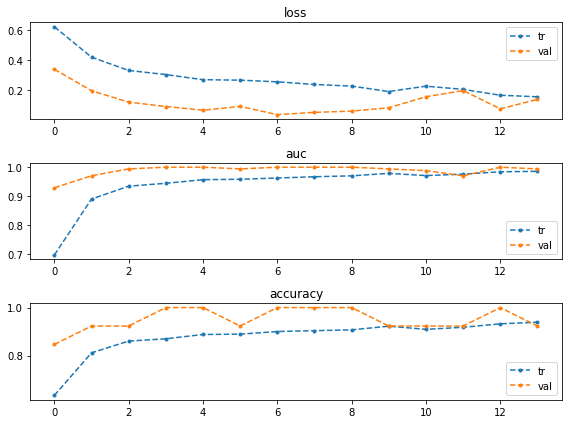

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.

 fold: 2/7, seed: 0/1 


 Train [ 0  1  2  3  4  7  8 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 31 33 34 35 36 37 38 39 40 41 42 43 44 45 47 49 50 52 53 54 56
 57 58 59 60 61 62 64 65 67 68 69 70 71 72 73 74 76 77 78 79 81 82 83 84
 85 86 87 88 89 90 91] 
 Valid [ 5  6  9 30 32 46 48 51 55 63 66 75 80] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4557 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6921 - accuracy: 0.5063 - auc: 0.5396

 3/46 [>.............................] - ETA: 15s - loss: 0.6981 - accuracy: 0.5232 - auc: 0.5528

 4/46 [=>............................] - ETA: 17s - loss: 0.6958 - accuracy: 0.5316 - auc: 0.5594

 5/46 [==>...........................] - ETA: 17s - loss: 0.6952 - accuracy: 0.5190 - auc: 0.5478

 6/46 [==>...........................] - ETA: 18s - loss: 0.6930 - accuracy: 0.5253 - auc: 0.5537

 7/46 [===>..........................] - ETA: 18s - loss: 0.6918 - accuracy: 0.5316 - auc: 0.5561

 8/46 [====>.........................] - ETA: 18s - loss: 0.6915 - accuracy: 0.5332 - auc: 0.5560

 9/46 [====>.........................] - ETA: 17s - loss: 0.6902 - accuracy: 0.5415 - auc: 0.5635

10/46 [=====>........................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5468 - auc: 0.5695

11/46 [======>.......................] - ETA: 17s - loss: 0.6882 - accuracy: 0.5443 - auc: 0.5670

12/46 [======>.......................] - ETA: 16s - loss: 0.6895 - accuracy: 0.5422 - auc: 0.5645

13/46 [=======>......................] - ETA: 16s - loss: 0.6884 - accuracy: 0.5463 - auc: 0.5703

14/46 [========>.....................] - ETA: 16s - loss: 0.6851 - accuracy: 0.5533 - auc: 0.5801

15/46 [========>.....................] - ETA: 15s - loss: 0.6830 - accuracy: 0.5578 - auc: 0.5856

16/46 [=========>....................] - ETA: 15s - loss: 0.6828 - accuracy: 0.5585 - auc: 0.5874

17/46 [==========>...................] - ETA: 14s - loss: 0.6805 - accuracy: 0.5622 - auc: 0.5936

18/46 [==========>...................] - ETA: 14s - loss: 0.6761 - accuracy: 0.5689 - auc: 0.6054

19/46 [===========>..................] - ETA: 13s - loss: 0.6728 - accuracy: 0.5730 - auc: 0.6125

20/46 [============>.................] - ETA: 13s - loss: 0.6687 - accuracy: 0.5778 - auc: 0.6206

21/46 [============>.................] - ETA: 12s - loss: 0.6703 - accuracy: 0.5787 - auc: 0.6210

22/46 [=============>................] - ETA: 12s - loss: 0.6672 - accuracy: 0.5840 - auc: 0.6284

23/46 [==============>...............] - ETA: 11s - loss: 0.6663 - accuracy: 0.5867 - auc: 0.6308

24/46 [==============>...............] - ETA: 11s - loss: 0.6668 - accuracy: 0.5839 - auc: 0.6282

25/46 [===============>..............] - ETA: 11s - loss: 0.6638 - accuracy: 0.5878 - auc: 0.6343

26/46 [===============>..............] - ETA: 10s - loss: 0.6616 - accuracy: 0.5930 - auc: 0.6401

27/46 [================>.............] - ETA: 10s - loss: 0.6597 - accuracy: 0.5959 - auc: 0.6443

28/46 [=================>............] - ETA: 9s - loss: 0.6578 - accuracy: 0.5995 - auc: 0.6485 

29/46 [=================>............] - ETA: 8s - loss: 0.6568 - accuracy: 0.6015 - auc: 0.6513

30/46 [==================>...........] - ETA: 8s - loss: 0.6542 - accuracy: 0.6030 - auc: 0.6547

31/46 [===================>..........] - ETA: 7s - loss: 0.6531 - accuracy: 0.6027 - auc: 0.6552

32/46 [===================>..........] - ETA: 7s - loss: 0.6502 - accuracy: 0.6056 - auc: 0.6595

33/46 [====================>.........] - ETA: 6s - loss: 0.6461 - accuracy: 0.6095 - auc: 0.6659

34/46 [=====================>........] - ETA: 6s - loss: 0.6433 - accuracy: 0.6121 - auc: 0.6699

35/46 [=====================>........] - ETA: 5s - loss: 0.6416 - accuracy: 0.6134 - auc: 0.6724

36/46 [======================>.......] - ETA: 5s - loss: 0.6388 - accuracy: 0.6164 - auc: 0.6768

37/46 [=======================>......] - ETA: 4s - loss: 0.6373 - accuracy: 0.6189 - auc: 0.6798

38/46 [=======================>......] - ETA: 4s - loss: 0.6340 - accuracy: 0.6239 - auc: 0.6857

39/46 [========================>.....] - ETA: 3s - loss: 0.6336 - accuracy: 0.6254 - auc: 0.6878

40/46 [=========================>....] - ETA: 3s - loss: 0.6312 - accuracy: 0.6269 - auc: 0.6906

41/46 [=========================>....] - ETA: 2s - loss: 0.6277 - accuracy: 0.6304 - auc: 0.6953

42/46 [==========================>...] - ETA: 2s - loss: 0.6261 - accuracy: 0.6326 - auc: 0.6985

43/46 [===========================>..] - ETA: 1s - loss: 0.6223 - accuracy: 0.6361 - auc: 0.7033

44/46 [===========================>..] - ETA: 1s - loss: 0.6186 - accuracy: 0.6401 - auc: 0.7085

45/46 [============================>.] - ETA: 0s - loss: 0.6159 - accuracy: 0.6430 - auc: 0.7122

46/46 [==============================] - ETA: 0s - loss: 0.6124 - accuracy: 0.6461 - auc: 0.7166

Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.33198, saving model to fold_2_best_model.hdf5


46/46 [==============================] - 25s 548ms/step - loss: 0.6124 - accuracy: 0.6461 - auc: 0.7166 - val_loss: 0.3320 - val_accuracy: 0.7692 - val_auc: 0.9112


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.4894 - accuracy: 0.7975 - auc: 0.8568

 2/46 [>.............................] - ETA: 11s - loss: 0.4597 - accuracy: 0.8165 - auc: 0.8723

 3/46 [>.............................] - ETA: 15s - loss: 0.4795 - accuracy: 0.7806 - auc: 0.8563

 4/46 [=>............................] - ETA: 16s - loss: 0.4766 - accuracy: 0.7848 - auc: 0.8568

 5/46 [==>...........................] - ETA: 17s - loss: 0.4788 - accuracy: 0.7772 - auc: 0.8535

 6/46 [==>...........................] - ETA: 17s - loss: 0.4847 - accuracy: 0.7700 - auc: 0.8492

 7/46 [===>..........................] - ETA: 17s - loss: 0.4816 - accuracy: 0.7703 - auc: 0.8519

 8/46 [====>.........................] - ETA: 17s - loss: 0.4856 - accuracy: 0.7658 - auc: 0.8494

 9/46 [====>.........................] - ETA: 17s - loss: 0.4963 - accuracy: 0.7623 - auc: 0.8424

10/46 [=====>........................] - ETA: 17s - loss: 0.4965 - accuracy: 0.7646 - auc: 0.8419

11/46 [======>.......................] - ETA: 17s - loss: 0.4927 - accuracy: 0.7687 - auc: 0.8442

12/46 [======>.......................] - ETA: 16s - loss: 0.4969 - accuracy: 0.7648 - auc: 0.8409

13/46 [=======>......................] - ETA: 16s - loss: 0.5009 - accuracy: 0.7673 - auc: 0.8396

14/46 [========>.....................] - ETA: 15s - loss: 0.5017 - accuracy: 0.7667 - auc: 0.8384

15/46 [========>.....................] - ETA: 15s - loss: 0.5004 - accuracy: 0.7654 - auc: 0.8389

16/46 [=========>....................] - ETA: 15s - loss: 0.4989 - accuracy: 0.7658 - auc: 0.8397

17/46 [==========>...................] - ETA: 14s - loss: 0.5016 - accuracy: 0.7632 - auc: 0.8373

18/46 [==========>...................] - ETA: 14s - loss: 0.4985 - accuracy: 0.7630 - auc: 0.8397

19/46 [===========>..................] - ETA: 13s - loss: 0.4958 - accuracy: 0.7655 - auc: 0.8418

20/46 [============>.................] - ETA: 13s - loss: 0.4945 - accuracy: 0.7658 - auc: 0.8422

21/46 [============>.................] - ETA: 12s - loss: 0.4928 - accuracy: 0.7661 - auc: 0.8435

22/46 [=============>................] - ETA: 12s - loss: 0.4929 - accuracy: 0.7652 - auc: 0.8438

23/46 [==============>...............] - ETA: 11s - loss: 0.4911 - accuracy: 0.7639 - auc: 0.8445

24/46 [==============>...............] - ETA: 11s - loss: 0.4870 - accuracy: 0.7669 - auc: 0.8475

25/46 [===============>..............] - ETA: 10s - loss: 0.4800 - accuracy: 0.7716 - auc: 0.8521

26/46 [===============>..............] - ETA: 10s - loss: 0.4799 - accuracy: 0.7726 - auc: 0.8521

27/46 [================>.............] - ETA: 9s - loss: 0.4757 - accuracy: 0.7745 - auc: 0.8548 

28/46 [=================>............] - ETA: 9s - loss: 0.4760 - accuracy: 0.7758 - auc: 0.8550

29/46 [=================>............] - ETA: 8s - loss: 0.4732 - accuracy: 0.7770 - auc: 0.8566

30/46 [==================>...........] - ETA: 8s - loss: 0.4710 - accuracy: 0.7781 - auc: 0.8579

31/46 [===================>..........] - ETA: 7s - loss: 0.4712 - accuracy: 0.7762 - auc: 0.8576

32/46 [===================>..........] - ETA: 7s - loss: 0.4690 - accuracy: 0.7777 - auc: 0.8590

33/46 [====================>.........] - ETA: 6s - loss: 0.4690 - accuracy: 0.7783 - auc: 0.8589

34/46 [=====================>........] - ETA: 6s - loss: 0.4728 - accuracy: 0.7770 - auc: 0.8570

35/46 [=====================>........] - ETA: 5s - loss: 0.4703 - accuracy: 0.7790 - auc: 0.8587

36/46 [======================>.......] - ETA: 5s - loss: 0.4672 - accuracy: 0.7802 - auc: 0.8606

37/46 [=======================>......] - ETA: 4s - loss: 0.4637 - accuracy: 0.7824 - auc: 0.8630

38/46 [=======================>......] - ETA: 4s - loss: 0.4639 - accuracy: 0.7831 - auc: 0.8631

39/46 [========================>.....] - ETA: 3s - loss: 0.4621 - accuracy: 0.7838 - auc: 0.8642

40/46 [=========================>....] - ETA: 3s - loss: 0.4613 - accuracy: 0.7858 - auc: 0.8650

41/46 [=========================>....] - ETA: 2s - loss: 0.4603 - accuracy: 0.7873 - auc: 0.8657

42/46 [==========================>...] - ETA: 2s - loss: 0.4596 - accuracy: 0.7866 - auc: 0.8660

43/46 [===========================>..] - ETA: 1s - loss: 0.4582 - accuracy: 0.7880 - auc: 0.8672

44/46 [===========================>..] - ETA: 1s - loss: 0.4574 - accuracy: 0.7877 - auc: 0.8675

45/46 [============================>.] - ETA: 0s - loss: 0.4543 - accuracy: 0.7896 - auc: 0.8694

46/46 [==============================] - ETA: 0s - loss: 0.4545 - accuracy: 0.7892 - auc: 0.8693

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss improved from 0.33198 to 0.13664, saving model to fold_2_best_model.hdf5


46/46 [==============================] - 25s 536ms/step - loss: 0.4545 - accuracy: 0.7892 - auc: 0.8693 - val_loss: 0.1366 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.3897 - accuracy: 0.8228 - auc: 0.9142

 2/46 [>.............................] - ETA: 11s - loss: 0.3775 - accuracy: 0.8291 - auc: 0.9139

 3/46 [>.............................] - ETA: 15s - loss: 0.3612 - accuracy: 0.8312 - auc: 0.9192

 4/46 [=>............................] - ETA: 17s - loss: 0.3787 - accuracy: 0.8259 - auc: 0.9124

 5/46 [==>...........................] - ETA: 17s - loss: 0.3661 - accuracy: 0.8329 - auc: 0.9189

 6/46 [==>...........................] - ETA: 17s - loss: 0.3749 - accuracy: 0.8291 - auc: 0.9148

 7/46 [===>..........................] - ETA: 17s - loss: 0.3733 - accuracy: 0.8336 - auc: 0.9157

 8/46 [====>.........................] - ETA: 17s - loss: 0.3672 - accuracy: 0.8402 - auc: 0.9191

 9/46 [====>.........................] - ETA: 17s - loss: 0.3707 - accuracy: 0.8383 - auc: 0.9171

10/46 [=====>........................] - ETA: 17s - loss: 0.3683 - accuracy: 0.8380 - auc: 0.9186

11/46 [======>.......................] - ETA: 17s - loss: 0.3711 - accuracy: 0.8377 - auc: 0.9170

12/46 [======>.......................] - ETA: 16s - loss: 0.3774 - accuracy: 0.8354 - auc: 0.9134

13/46 [=======>......................] - ETA: 16s - loss: 0.3763 - accuracy: 0.8354 - auc: 0.9141

14/46 [========>.....................] - ETA: 15s - loss: 0.3722 - accuracy: 0.8382 - auc: 0.9165

15/46 [========>.....................] - ETA: 15s - loss: 0.3760 - accuracy: 0.8363 - auc: 0.9147

16/46 [=========>....................] - ETA: 15s - loss: 0.3749 - accuracy: 0.8378 - auc: 0.9155

17/46 [==========>...................] - ETA: 14s - loss: 0.3718 - accuracy: 0.8392 - auc: 0.9168

18/46 [==========>...................] - ETA: 14s - loss: 0.3733 - accuracy: 0.8376 - auc: 0.9161

19/46 [===========>..................] - ETA: 13s - loss: 0.3735 - accuracy: 0.8368 - auc: 0.9157

20/46 [============>.................] - ETA: 13s - loss: 0.3686 - accuracy: 0.8411 - auc: 0.9185

21/46 [============>.................] - ETA: 12s - loss: 0.3646 - accuracy: 0.8415 - auc: 0.9202

22/46 [=============>................] - ETA: 12s - loss: 0.3637 - accuracy: 0.8400 - auc: 0.9203

23/46 [==============>...............] - ETA: 11s - loss: 0.3655 - accuracy: 0.8382 - auc: 0.9193

24/46 [==============>...............] - ETA: 11s - loss: 0.3626 - accuracy: 0.8397 - auc: 0.9206

25/46 [===============>..............] - ETA: 10s - loss: 0.3665 - accuracy: 0.8385 - auc: 0.9186

26/46 [===============>..............] - ETA: 10s - loss: 0.3625 - accuracy: 0.8408 - auc: 0.9204

27/46 [================>.............] - ETA: 9s - loss: 0.3654 - accuracy: 0.8406 - auc: 0.9193 

28/46 [=================>............] - ETA: 9s - loss: 0.3650 - accuracy: 0.8409 - auc: 0.9194

29/46 [=================>............] - ETA: 8s - loss: 0.3634 - accuracy: 0.8407 - auc: 0.9202

30/46 [==================>...........] - ETA: 8s - loss: 0.3626 - accuracy: 0.8397 - auc: 0.9205

31/46 [===================>..........] - ETA: 7s - loss: 0.3608 - accuracy: 0.8420 - auc: 0.9215

32/46 [===================>..........] - ETA: 7s - loss: 0.3592 - accuracy: 0.8414 - auc: 0.9221

33/46 [====================>.........] - ETA: 6s - loss: 0.3552 - accuracy: 0.8443 - auc: 0.9241

34/46 [=====================>........] - ETA: 6s - loss: 0.3598 - accuracy: 0.8436 - auc: 0.9223

35/46 [=====================>........] - ETA: 5s - loss: 0.3567 - accuracy: 0.8456 - auc: 0.9236

36/46 [======================>.......] - ETA: 5s - loss: 0.3553 - accuracy: 0.8470 - auc: 0.9243

37/46 [=======================>......] - ETA: 4s - loss: 0.3562 - accuracy: 0.8471 - auc: 0.9239

38/46 [=======================>......] - ETA: 4s - loss: 0.3563 - accuracy: 0.8464 - auc: 0.9238

39/46 [========================>.....] - ETA: 3s - loss: 0.3566 - accuracy: 0.8455 - auc: 0.9237

40/46 [=========================>....] - ETA: 3s - loss: 0.3556 - accuracy: 0.8456 - auc: 0.9241

41/46 [=========================>....] - ETA: 2s - loss: 0.3544 - accuracy: 0.8462 - auc: 0.9246

42/46 [==========================>...] - ETA: 2s - loss: 0.3531 - accuracy: 0.8463 - auc: 0.9251

43/46 [===========================>..] - ETA: 1s - loss: 0.3536 - accuracy: 0.8457 - auc: 0.9250

44/46 [===========================>..] - ETA: 1s - loss: 0.3504 - accuracy: 0.8472 - auc: 0.9263

45/46 [============================>.] - ETA: 0s - loss: 0.3500 - accuracy: 0.8467 - auc: 0.9264

46/46 [==============================] - ETA: 0s - loss: 0.3488 - accuracy: 0.8465 - auc: 0.9267

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss did not improve from 0.13664
46/46 [==============================] - 25s 538ms/step - loss: 0.3488 - accuracy: 0.8465 - auc: 0.9267 - val_loss: 0.1542 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3280 - accuracy: 0.8481 - auc: 0.9352

 2/46 [>.............................] - ETA: 12s - loss: 0.3339 - accuracy: 0.8228 - auc: 0.9305

 3/46 [>.............................] - ETA: 15s - loss: 0.3373 - accuracy: 0.8354 - auc: 0.9296

 4/46 [=>............................] - ETA: 17s - loss: 0.3468 - accuracy: 0.8386 - auc: 0.9255

 5/46 [==>...........................] - ETA: 18s - loss: 0.3334 - accuracy: 0.8430 - auc: 0.9314

 6/46 [==>...........................] - ETA: 18s - loss: 0.3251 - accuracy: 0.8481 - auc: 0.9354

 7/46 [===>..........................] - ETA: 18s - loss: 0.3292 - accuracy: 0.8463 - auc: 0.9335

 8/46 [====>.........................] - ETA: 18s - loss: 0.3209 - accuracy: 0.8528 - auc: 0.9370

 9/46 [====>.........................] - ETA: 17s - loss: 0.3155 - accuracy: 0.8622 - auc: 0.9403

10/46 [=====>........................] - ETA: 17s - loss: 0.3151 - accuracy: 0.8608 - auc: 0.9399

11/46 [======>.......................] - ETA: 17s - loss: 0.3164 - accuracy: 0.8631 - auc: 0.9402

12/46 [======>.......................] - ETA: 16s - loss: 0.3161 - accuracy: 0.8639 - auc: 0.9403

13/46 [=======>......................] - ETA: 16s - loss: 0.3100 - accuracy: 0.8627 - auc: 0.9423

14/46 [========>.....................] - ETA: 16s - loss: 0.3098 - accuracy: 0.8626 - auc: 0.9423

15/46 [========>.....................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8565 - auc: 0.9394

16/46 [=========>....................] - ETA: 15s - loss: 0.3142 - accuracy: 0.8616 - auc: 0.9407

17/46 [==========>...................] - ETA: 15s - loss: 0.3115 - accuracy: 0.8615 - auc: 0.9416

18/46 [==========>...................] - ETA: 14s - loss: 0.3111 - accuracy: 0.8657 - auc: 0.9420

19/46 [===========>..................] - ETA: 14s - loss: 0.3110 - accuracy: 0.8661 - auc: 0.9423

20/46 [============>.................] - ETA: 13s - loss: 0.3120 - accuracy: 0.8646 - auc: 0.9417

21/46 [============>.................] - ETA: 13s - loss: 0.3119 - accuracy: 0.8632 - auc: 0.9417

22/46 [=============>................] - ETA: 12s - loss: 0.3106 - accuracy: 0.8636 - auc: 0.9421

23/46 [==============>...............] - ETA: 12s - loss: 0.3160 - accuracy: 0.8646 - auc: 0.9411

24/46 [==============>...............] - ETA: 11s - loss: 0.3152 - accuracy: 0.8671 - auc: 0.9415

25/46 [===============>..............] - ETA: 11s - loss: 0.3122 - accuracy: 0.8684 - auc: 0.9425

26/46 [===============>..............] - ETA: 10s - loss: 0.3097 - accuracy: 0.8705 - auc: 0.9435

27/46 [================>.............] - ETA: 9s - loss: 0.3082 - accuracy: 0.8706 - auc: 0.9439 

28/46 [=================>............] - ETA: 9s - loss: 0.3058 - accuracy: 0.8725 - auc: 0.9448

29/46 [=================>............] - ETA: 8s - loss: 0.3042 - accuracy: 0.8734 - auc: 0.9454

30/46 [==================>...........] - ETA: 8s - loss: 0.3032 - accuracy: 0.8747 - auc: 0.9458

31/46 [===================>..........] - ETA: 7s - loss: 0.3039 - accuracy: 0.8746 - auc: 0.9456

32/46 [===================>..........] - ETA: 7s - loss: 0.3018 - accuracy: 0.8770 - auc: 0.9465

33/46 [====================>.........] - ETA: 6s - loss: 0.3015 - accuracy: 0.8769 - auc: 0.9465

34/46 [=====================>........] - ETA: 6s - loss: 0.2998 - accuracy: 0.8768 - auc: 0.9471

35/46 [=====================>........] - ETA: 5s - loss: 0.3009 - accuracy: 0.8770 - auc: 0.9466

36/46 [======================>.......] - ETA: 5s - loss: 0.2976 - accuracy: 0.8787 - auc: 0.9479

37/46 [=======================>......] - ETA: 4s - loss: 0.2959 - accuracy: 0.8789 - auc: 0.9485

38/46 [=======================>......] - ETA: 4s - loss: 0.2966 - accuracy: 0.8781 - auc: 0.9482

39/46 [========================>.....] - ETA: 3s - loss: 0.2959 - accuracy: 0.8786 - auc: 0.9484

40/46 [=========================>....] - ETA: 3s - loss: 0.2965 - accuracy: 0.8791 - auc: 0.9483

41/46 [=========================>....] - ETA: 2s - loss: 0.2980 - accuracy: 0.8787 - auc: 0.9478

42/46 [==========================>...] - ETA: 2s - loss: 0.2990 - accuracy: 0.8779 - auc: 0.9474

43/46 [===========================>..] - ETA: 1s - loss: 0.2987 - accuracy: 0.8784 - auc: 0.9475

44/46 [===========================>..] - ETA: 1s - loss: 0.3003 - accuracy: 0.8780 - auc: 0.9469

45/46 [============================>.] - ETA: 0s - loss: 0.3002 - accuracy: 0.8776 - auc: 0.9469

46/46 [==============================] - ETA: 0s - loss: 0.3027 - accuracy: 0.8751 - auc: 0.9459

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss improved from 0.13664 to 0.11885, saving model to fold_2_best_model.hdf5


46/46 [==============================] - 25s 535ms/step - loss: 0.3027 - accuracy: 0.8751 - auc: 0.9459 - val_loss: 0.1188 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.3023 - accuracy: 0.8608 - auc: 0.9470

 2/46 [>.............................] - ETA: 11s - loss: 0.3090 - accuracy: 0.8608 - auc: 0.9446

 3/46 [>.............................] - ETA: 15s - loss: 0.2910 - accuracy: 0.8776 - auc: 0.9522

 4/46 [=>............................] - ETA: 16s - loss: 0.3083 - accuracy: 0.8544 - auc: 0.9440

 5/46 [==>...........................] - ETA: 17s - loss: 0.2833 - accuracy: 0.8658 - auc: 0.9527

 6/46 [==>...........................] - ETA: 17s - loss: 0.2921 - accuracy: 0.8565 - auc: 0.9483

 7/46 [===>..........................] - ETA: 17s - loss: 0.2983 - accuracy: 0.8535 - auc: 0.9459

 8/46 [====>.........................] - ETA: 17s - loss: 0.3037 - accuracy: 0.8576 - auc: 0.9448

 9/46 [====>.........................] - ETA: 18s - loss: 0.2947 - accuracy: 0.8608 - auc: 0.9480

10/46 [=====>........................] - ETA: 18s - loss: 0.2925 - accuracy: 0.8671 - auc: 0.9498

11/46 [======>.......................] - ETA: 17s - loss: 0.2912 - accuracy: 0.8654 - auc: 0.9500

12/46 [======>.......................] - ETA: 17s - loss: 0.2926 - accuracy: 0.8650 - auc: 0.9495

13/46 [=======>......................] - ETA: 16s - loss: 0.2963 - accuracy: 0.8637 - auc: 0.9482

14/46 [========>.....................] - ETA: 16s - loss: 0.2978 - accuracy: 0.8635 - auc: 0.9475

15/46 [========>.....................] - ETA: 16s - loss: 0.2950 - accuracy: 0.8641 - auc: 0.9487

16/46 [=========>....................] - ETA: 15s - loss: 0.2965 - accuracy: 0.8647 - auc: 0.9478

17/46 [==========>...................] - ETA: 15s - loss: 0.2896 - accuracy: 0.8675 - auc: 0.9503

18/46 [==========>...................] - ETA: 14s - loss: 0.2888 - accuracy: 0.8678 - auc: 0.9505

19/46 [===========>..................] - ETA: 14s - loss: 0.2828 - accuracy: 0.8701 - auc: 0.9524

20/46 [============>.................] - ETA: 13s - loss: 0.2832 - accuracy: 0.8703 - auc: 0.9522

21/46 [============>.................] - ETA: 13s - loss: 0.2843 - accuracy: 0.8710 - auc: 0.9518

22/46 [=============>................] - ETA: 12s - loss: 0.2866 - accuracy: 0.8717 - auc: 0.9511

23/46 [==============>...............] - ETA: 12s - loss: 0.2869 - accuracy: 0.8701 - auc: 0.9508

24/46 [==============>...............] - ETA: 11s - loss: 0.2858 - accuracy: 0.8708 - auc: 0.9513

25/46 [===============>..............] - ETA: 11s - loss: 0.2843 - accuracy: 0.8709 - auc: 0.9519

26/46 [===============>..............] - ETA: 10s - loss: 0.2853 - accuracy: 0.8705 - auc: 0.9515

27/46 [================>.............] - ETA: 9s - loss: 0.2846 - accuracy: 0.8725 - auc: 0.9518 

28/46 [=================>............] - ETA: 9s - loss: 0.2806 - accuracy: 0.8757 - auc: 0.9533

29/46 [=================>............] - ETA: 8s - loss: 0.2782 - accuracy: 0.8773 - auc: 0.9541

30/46 [==================>...........] - ETA: 8s - loss: 0.2773 - accuracy: 0.8764 - auc: 0.9543

31/46 [===================>..........] - ETA: 7s - loss: 0.2791 - accuracy: 0.8759 - auc: 0.9536

32/46 [===================>..........] - ETA: 7s - loss: 0.2770 - accuracy: 0.8770 - auc: 0.9543

33/46 [====================>.........] - ETA: 6s - loss: 0.2760 - accuracy: 0.8773 - auc: 0.9546

34/46 [=====================>........] - ETA: 6s - loss: 0.2746 - accuracy: 0.8779 - auc: 0.9550

35/46 [=====================>........] - ETA: 5s - loss: 0.2721 - accuracy: 0.8792 - auc: 0.9558

36/46 [======================>.......] - ETA: 5s - loss: 0.2746 - accuracy: 0.8780 - auc: 0.9551

37/46 [=======================>......] - ETA: 4s - loss: 0.2728 - accuracy: 0.8789 - auc: 0.9556

38/46 [=======================>......] - ETA: 4s - loss: 0.2744 - accuracy: 0.8794 - auc: 0.9555

39/46 [========================>.....] - ETA: 3s - loss: 0.2735 - accuracy: 0.8793 - auc: 0.9558

40/46 [=========================>....] - ETA: 3s - loss: 0.2741 - accuracy: 0.8801 - auc: 0.9558

41/46 [=========================>....] - ETA: 2s - loss: 0.2742 - accuracy: 0.8802 - auc: 0.9557

42/46 [==========================>...] - ETA: 2s - loss: 0.2755 - accuracy: 0.8807 - auc: 0.9553

43/46 [===========================>..] - ETA: 1s - loss: 0.2754 - accuracy: 0.8808 - auc: 0.9553

44/46 [===========================>..] - ETA: 1s - loss: 0.2761 - accuracy: 0.8806 - auc: 0.9551

45/46 [============================>.] - ETA: 0s - loss: 0.2766 - accuracy: 0.8813 - auc: 0.9550

46/46 [==============================] - ETA: 0s - loss: 0.2764 - accuracy: 0.8814 - auc: 0.9550

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss did not improve from 0.11885
46/46 [==============================] - 25s 534ms/step - loss: 0.2764 - accuracy: 0.8814 - auc: 0.9550 - val_loss: 0.1298 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2048 - accuracy: 0.9241 - auc: 0.9790

 2/46 [>.............................] - ETA: 11s - loss: 0.2315 - accuracy: 0.9114 - auc: 0.9703

 3/46 [>.............................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9198 - auc: 0.9763

 4/46 [=>............................] - ETA: 16s - loss: 0.2142 - accuracy: 0.9177 - auc: 0.9738

 5/46 [==>...........................] - ETA: 17s - loss: 0.2255 - accuracy: 0.9089 - auc: 0.9703

 6/46 [==>...........................] - ETA: 17s - loss: 0.2432 - accuracy: 0.9008 - auc: 0.9653

 7/46 [===>..........................] - ETA: 17s - loss: 0.2277 - accuracy: 0.9096 - auc: 0.9694

 8/46 [====>.........................] - ETA: 17s - loss: 0.2229 - accuracy: 0.9114 - auc: 0.9707

 9/46 [====>.........................] - ETA: 17s - loss: 0.2280 - accuracy: 0.9086 - auc: 0.9695

10/46 [=====>........................] - ETA: 17s - loss: 0.2307 - accuracy: 0.9076 - auc: 0.9689

11/46 [======>.......................] - ETA: 17s - loss: 0.2381 - accuracy: 0.9056 - auc: 0.9671

12/46 [======>.......................] - ETA: 16s - loss: 0.2363 - accuracy: 0.9072 - auc: 0.9675

13/46 [=======>......................] - ETA: 16s - loss: 0.2353 - accuracy: 0.9075 - auc: 0.9678

14/46 [========>.....................] - ETA: 15s - loss: 0.2355 - accuracy: 0.9060 - auc: 0.9678

15/46 [========>.....................] - ETA: 15s - loss: 0.2360 - accuracy: 0.9080 - auc: 0.9676

16/46 [=========>....................] - ETA: 15s - loss: 0.2393 - accuracy: 0.9090 - auc: 0.9669

17/46 [==========>...................] - ETA: 14s - loss: 0.2432 - accuracy: 0.9054 - auc: 0.9656

18/46 [==========>...................] - ETA: 14s - loss: 0.2426 - accuracy: 0.9051 - auc: 0.9658

19/46 [===========>..................] - ETA: 13s - loss: 0.2414 - accuracy: 0.9041 - auc: 0.9661

20/46 [============>.................] - ETA: 13s - loss: 0.2390 - accuracy: 0.9051 - auc: 0.9668

21/46 [============>.................] - ETA: 13s - loss: 0.2380 - accuracy: 0.9048 - auc: 0.9671

22/46 [=============>................] - ETA: 12s - loss: 0.2347 - accuracy: 0.9068 - auc: 0.9680

23/46 [==============>...............] - ETA: 12s - loss: 0.2364 - accuracy: 0.9064 - auc: 0.9675

24/46 [==============>...............] - ETA: 11s - loss: 0.2351 - accuracy: 0.9082 - auc: 0.9680

25/46 [===============>..............] - ETA: 11s - loss: 0.2389 - accuracy: 0.9089 - auc: 0.9671

26/46 [===============>..............] - ETA: 10s - loss: 0.2389 - accuracy: 0.9090 - auc: 0.9670

27/46 [================>.............] - ETA: 10s - loss: 0.2382 - accuracy: 0.9090 - auc: 0.9671

28/46 [=================>............] - ETA: 9s - loss: 0.2472 - accuracy: 0.9073 - auc: 0.9652 

29/46 [=================>............] - ETA: 8s - loss: 0.2450 - accuracy: 0.9075 - auc: 0.9658

30/46 [==================>...........] - ETA: 8s - loss: 0.2470 - accuracy: 0.9072 - auc: 0.9652

31/46 [===================>..........] - ETA: 7s - loss: 0.2480 - accuracy: 0.9065 - auc: 0.9649

32/46 [===================>..........] - ETA: 7s - loss: 0.2464 - accuracy: 0.9070 - auc: 0.9653

33/46 [====================>.........] - ETA: 6s - loss: 0.2446 - accuracy: 0.9083 - auc: 0.9658

34/46 [=====================>........] - ETA: 6s - loss: 0.2466 - accuracy: 0.9058 - auc: 0.9652

35/46 [=====================>........] - ETA: 5s - loss: 0.2469 - accuracy: 0.9042 - auc: 0.9650

36/46 [======================>.......] - ETA: 5s - loss: 0.2462 - accuracy: 0.9037 - auc: 0.9652

37/46 [=======================>......] - ETA: 4s - loss: 0.2443 - accuracy: 0.9049 - auc: 0.9657

38/46 [=======================>......] - ETA: 4s - loss: 0.2442 - accuracy: 0.9041 - auc: 0.9657

39/46 [========================>.....] - ETA: 3s - loss: 0.2455 - accuracy: 0.9039 - auc: 0.9653

40/46 [=========================>....] - ETA: 3s - loss: 0.2458 - accuracy: 0.9032 - auc: 0.9652

41/46 [=========================>....] - ETA: 2s - loss: 0.2461 - accuracy: 0.9031 - auc: 0.9652

42/46 [==========================>...] - ETA: 2s - loss: 0.2433 - accuracy: 0.9042 - auc: 0.9659

43/46 [===========================>..] - ETA: 1s - loss: 0.2424 - accuracy: 0.9046 - auc: 0.9662

44/46 [===========================>..] - ETA: 1s - loss: 0.2421 - accuracy: 0.9048 - auc: 0.9663

45/46 [============================>.] - ETA: 0s - loss: 0.2416 - accuracy: 0.9041 - auc: 0.9664

46/46 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.9040 - auc: 0.9662

Found 13 validated image filenames belonging to 2 classes.

Epoch 00006: val_loss did not improve from 0.11885
46/46 [==============================] - 25s 538ms/step - loss: 0.2423 - accuracy: 0.9040 - auc: 0.9662 - val_loss: 0.1930 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.2268 - accuracy: 0.8987 - auc: 0.9752

 2/46 [>.............................] - ETA: 11s - loss: 0.1892 - accuracy: 0.9177 - auc: 0.9806

 3/46 [>.............................] - ETA: 15s - loss: 0.2285 - accuracy: 0.9030 - auc: 0.9698

 4/46 [=>............................] - ETA: 16s - loss: 0.2375 - accuracy: 0.8861 - auc: 0.9675

 5/46 [==>...........................] - ETA: 17s - loss: 0.2612 - accuracy: 0.8734 - auc: 0.9603

 6/46 [==>...........................] - ETA: 17s - loss: 0.2815 - accuracy: 0.8713 - auc: 0.9556

 7/46 [===>..........................] - ETA: 17s - loss: 0.2689 - accuracy: 0.8788 - auc: 0.9594

 8/46 [====>.........................] - ETA: 17s - loss: 0.2686 - accuracy: 0.8797 - auc: 0.9597

 9/46 [====>.........................] - ETA: 17s - loss: 0.2610 - accuracy: 0.8847 - auc: 0.9614

10/46 [=====>........................] - ETA: 16s - loss: 0.2643 - accuracy: 0.8823 - auc: 0.9607

11/46 [======>.......................] - ETA: 16s - loss: 0.2577 - accuracy: 0.8849 - auc: 0.9620

12/46 [======>.......................] - ETA: 16s - loss: 0.2533 - accuracy: 0.8882 - auc: 0.9632

13/46 [=======>......................] - ETA: 15s - loss: 0.2519 - accuracy: 0.8900 - auc: 0.9632

14/46 [========>.....................] - ETA: 15s - loss: 0.2540 - accuracy: 0.8888 - auc: 0.9627

15/46 [========>.....................] - ETA: 15s - loss: 0.2557 - accuracy: 0.8895 - auc: 0.9623

16/46 [=========>....................] - ETA: 14s - loss: 0.2538 - accuracy: 0.8892 - auc: 0.9625

17/46 [==========>...................] - ETA: 14s - loss: 0.2532 - accuracy: 0.8920 - auc: 0.9626

18/46 [==========>...................] - ETA: 13s - loss: 0.2497 - accuracy: 0.8945 - auc: 0.9635

19/46 [===========>..................] - ETA: 13s - loss: 0.2477 - accuracy: 0.8974 - auc: 0.9640

20/46 [============>.................] - ETA: 12s - loss: 0.2518 - accuracy: 0.8962 - auc: 0.9629

21/46 [============>.................] - ETA: 12s - loss: 0.2560 - accuracy: 0.8957 - auc: 0.9619

22/46 [=============>................] - ETA: 11s - loss: 0.2556 - accuracy: 0.8959 - auc: 0.9621

23/46 [==============>...............] - ETA: 11s - loss: 0.2536 - accuracy: 0.8960 - auc: 0.9626

24/46 [==============>...............] - ETA: 11s - loss: 0.2527 - accuracy: 0.8972 - auc: 0.9629

25/46 [===============>..............] - ETA: 10s - loss: 0.2516 - accuracy: 0.8977 - auc: 0.9632

26/46 [===============>..............] - ETA: 10s - loss: 0.2503 - accuracy: 0.8982 - auc: 0.9635

27/46 [================>.............] - ETA: 9s - loss: 0.2501 - accuracy: 0.8983 - auc: 0.9635 

28/46 [=================>............] - ETA: 9s - loss: 0.2495 - accuracy: 0.8987 - auc: 0.9637

29/46 [=================>............] - ETA: 8s - loss: 0.2493 - accuracy: 0.8974 - auc: 0.9637

30/46 [==================>...........] - ETA: 8s - loss: 0.2478 - accuracy: 0.8970 - auc: 0.9640

31/46 [===================>..........] - ETA: 7s - loss: 0.2461 - accuracy: 0.8979 - auc: 0.9645

32/46 [===================>..........] - ETA: 7s - loss: 0.2473 - accuracy: 0.8987 - auc: 0.9643

33/46 [====================>.........] - ETA: 6s - loss: 0.2458 - accuracy: 0.8991 - auc: 0.9647

34/46 [=====================>........] - ETA: 6s - loss: 0.2471 - accuracy: 0.8991 - auc: 0.9644

35/46 [=====================>........] - ETA: 5s - loss: 0.2487 - accuracy: 0.8987 - auc: 0.9639

36/46 [======================>.......] - ETA: 5s - loss: 0.2503 - accuracy: 0.8973 - auc: 0.9635

37/46 [=======================>......] - ETA: 4s - loss: 0.2510 - accuracy: 0.8984 - auc: 0.9634

38/46 [=======================>......] - ETA: 4s - loss: 0.2503 - accuracy: 0.8987 - auc: 0.9636

39/46 [========================>.....] - ETA: 3s - loss: 0.2490 - accuracy: 0.9000 - auc: 0.9640

40/46 [=========================>....] - ETA: 3s - loss: 0.2503 - accuracy: 0.8997 - auc: 0.9637

41/46 [=========================>....] - ETA: 2s - loss: 0.2501 - accuracy: 0.9000 - auc: 0.9638

42/46 [==========================>...] - ETA: 2s - loss: 0.2512 - accuracy: 0.8990 - auc: 0.9634

43/46 [===========================>..] - ETA: 1s - loss: 0.2501 - accuracy: 0.8999 - auc: 0.9638

44/46 [===========================>..] - ETA: 1s - loss: 0.2492 - accuracy: 0.8999 - auc: 0.9640

45/46 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.9010 - auc: 0.9645

46/46 [==============================] - ETA: 0s - loss: 0.2473 - accuracy: 0.9012 - auc: 0.9646

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss did not improve from 0.11885
46/46 [==============================] - 24s 528ms/step - loss: 0.2473 - accuracy: 0.9012 - auc: 0.9646 - val_loss: 0.2680 - val_accuracy: 0.8462 - val_auc: 0.9408


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.3025 - accuracy: 0.8734 - auc: 0.9494

 2/46 [>.............................] - ETA: 11s - loss: 0.2628 - accuracy: 0.8797 - auc: 0.9613

 3/46 [>.............................] - ETA: 15s - loss: 0.2391 - accuracy: 0.9030 - auc: 0.9669

 4/46 [=>............................] - ETA: 16s - loss: 0.2451 - accuracy: 0.9019 - auc: 0.9658

 5/46 [==>...........................] - ETA: 17s - loss: 0.2586 - accuracy: 0.8987 - auc: 0.9616

 6/46 [==>...........................] - ETA: 18s - loss: 0.2639 - accuracy: 0.8924 - auc: 0.9596

 7/46 [===>..........................] - ETA: 18s - loss: 0.2621 - accuracy: 0.8969 - auc: 0.9602

 8/46 [====>.........................] - ETA: 17s - loss: 0.2640 - accuracy: 0.8908 - auc: 0.9593

 9/46 [====>.........................] - ETA: 17s - loss: 0.2585 - accuracy: 0.8931 - auc: 0.9608

10/46 [=====>........................] - ETA: 17s - loss: 0.2513 - accuracy: 0.8949 - auc: 0.9630

11/46 [======>.......................] - ETA: 17s - loss: 0.2613 - accuracy: 0.8907 - auc: 0.9601

12/46 [======>.......................] - ETA: 16s - loss: 0.2624 - accuracy: 0.8903 - auc: 0.9597

13/46 [=======>......................] - ETA: 16s - loss: 0.2628 - accuracy: 0.8900 - auc: 0.9596

14/46 [========>.....................] - ETA: 15s - loss: 0.2648 - accuracy: 0.8888 - auc: 0.9590

15/46 [========>.....................] - ETA: 15s - loss: 0.2628 - accuracy: 0.8895 - auc: 0.9596

16/46 [=========>....................] - ETA: 15s - loss: 0.2627 - accuracy: 0.8892 - auc: 0.9597

17/46 [==========>...................] - ETA: 14s - loss: 0.2600 - accuracy: 0.8928 - auc: 0.9606

18/46 [==========>...................] - ETA: 14s - loss: 0.2588 - accuracy: 0.8945 - auc: 0.9611

19/46 [===========>..................] - ETA: 13s - loss: 0.2566 - accuracy: 0.8961 - auc: 0.9619

20/46 [============>.................] - ETA: 13s - loss: 0.2516 - accuracy: 0.9013 - auc: 0.9636

21/46 [============>.................] - ETA: 12s - loss: 0.2519 - accuracy: 0.8999 - auc: 0.9634

22/46 [=============>................] - ETA: 12s - loss: 0.2481 - accuracy: 0.9022 - auc: 0.9645

23/46 [==============>...............] - ETA: 11s - loss: 0.2475 - accuracy: 0.9009 - auc: 0.9646

24/46 [==============>...............] - ETA: 11s - loss: 0.2491 - accuracy: 0.9003 - auc: 0.9640

25/46 [===============>..............] - ETA: 10s - loss: 0.2474 - accuracy: 0.8997 - auc: 0.9644

26/46 [===============>..............] - ETA: 10s - loss: 0.2462 - accuracy: 0.8992 - auc: 0.9647

27/46 [================>.............] - ETA: 9s - loss: 0.2428 - accuracy: 0.9006 - auc: 0.9657 

28/46 [=================>............] - ETA: 9s - loss: 0.2415 - accuracy: 0.9019 - auc: 0.9662

29/46 [=================>............] - ETA: 8s - loss: 0.2389 - accuracy: 0.9027 - auc: 0.9668

30/46 [==================>...........] - ETA: 8s - loss: 0.2396 - accuracy: 0.9034 - auc: 0.9666

31/46 [===================>..........] - ETA: 7s - loss: 0.2385 - accuracy: 0.9032 - auc: 0.9669

32/46 [===================>..........] - ETA: 7s - loss: 0.2350 - accuracy: 0.9051 - auc: 0.9679

33/46 [====================>.........] - ETA: 6s - loss: 0.2335 - accuracy: 0.9064 - auc: 0.9683

34/46 [=====================>........] - ETA: 6s - loss: 0.2350 - accuracy: 0.9062 - auc: 0.9678

35/46 [=====================>........] - ETA: 5s - loss: 0.2316 - accuracy: 0.9078 - auc: 0.9688

36/46 [======================>.......] - ETA: 5s - loss: 0.2300 - accuracy: 0.9086 - auc: 0.9692

37/46 [=======================>......] - ETA: 4s - loss: 0.2282 - accuracy: 0.9093 - auc: 0.9697

38/46 [=======================>......] - ETA: 4s - loss: 0.2267 - accuracy: 0.9087 - auc: 0.9701

39/46 [========================>.....] - ETA: 3s - loss: 0.2247 - accuracy: 0.9094 - auc: 0.9706

40/46 [=========================>....] - ETA: 3s - loss: 0.2241 - accuracy: 0.9092 - auc: 0.9707

41/46 [=========================>....] - ETA: 2s - loss: 0.2235 - accuracy: 0.9092 - auc: 0.9708

42/46 [==========================>...] - ETA: 2s - loss: 0.2223 - accuracy: 0.9087 - auc: 0.9711

43/46 [===========================>..] - ETA: 1s - loss: 0.2216 - accuracy: 0.9093 - auc: 0.9713

44/46 [===========================>..] - ETA: 1s - loss: 0.2209 - accuracy: 0.9094 - auc: 0.9715

45/46 [============================>.] - ETA: 0s - loss: 0.2209 - accuracy: 0.9091 - auc: 0.9714

46/46 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9089 - auc: 0.9715

Found 13 validated image filenames belonging to 2 classes.

Epoch 00008: val_loss did not improve from 0.11885


46/46 [==============================] - 24s 532ms/step - loss: 0.2206 - accuracy: 0.9089 - auc: 0.9715 - val_loss: 0.2305 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.2185 - accuracy: 0.9114 - auc: 0.9710

 2/46 [>.............................] - ETA: 11s - loss: 0.1746 - accuracy: 0.9177 - auc: 0.9804

 3/46 [>.............................] - ETA: 15s - loss: 0.1808 - accuracy: 0.9156 - auc: 0.9806

 4/46 [=>............................] - ETA: 16s - loss: 0.2003 - accuracy: 0.9114 - auc: 0.9765

 5/46 [==>...........................] - ETA: 17s - loss: 0.1844 - accuracy: 0.9241 - auc: 0.9800

 6/46 [==>...........................] - ETA: 17s - loss: 0.1982 - accuracy: 0.9135 - auc: 0.9770

 7/46 [===>..........................] - ETA: 17s - loss: 0.1917 - accuracy: 0.9204 - auc: 0.9787

 8/46 [====>.........................] - ETA: 17s - loss: 0.1880 - accuracy: 0.9209 - auc: 0.9796

 9/46 [====>.........................] - ETA: 17s - loss: 0.1881 - accuracy: 0.9212 - auc: 0.9796

10/46 [=====>........................] - ETA: 17s - loss: 0.1935 - accuracy: 0.9203 - auc: 0.9785

11/46 [======>.......................] - ETA: 16s - loss: 0.2012 - accuracy: 0.9183 - auc: 0.9768

12/46 [======>.......................] - ETA: 17s - loss: 0.1968 - accuracy: 0.9188 - auc: 0.9777

13/46 [=======>......................] - ETA: 16s - loss: 0.1928 - accuracy: 0.9202 - auc: 0.9786

14/46 [========>.....................] - ETA: 16s - loss: 0.1935 - accuracy: 0.9222 - auc: 0.9786

15/46 [========>.....................] - ETA: 15s - loss: 0.1907 - accuracy: 0.9215 - auc: 0.9791

16/46 [=========>....................] - ETA: 15s - loss: 0.1906 - accuracy: 0.9209 - auc: 0.9791

17/46 [==========>...................] - ETA: 14s - loss: 0.1869 - accuracy: 0.9241 - auc: 0.9800

18/46 [==========>...................] - ETA: 14s - loss: 0.1910 - accuracy: 0.9226 - auc: 0.9788

19/46 [===========>..................] - ETA: 13s - loss: 0.1961 - accuracy: 0.9214 - auc: 0.9777

20/46 [============>.................] - ETA: 13s - loss: 0.1953 - accuracy: 0.9209 - auc: 0.9779

21/46 [============>.................] - ETA: 12s - loss: 0.1915 - accuracy: 0.9228 - auc: 0.9787

22/46 [=============>................] - ETA: 12s - loss: 0.1934 - accuracy: 0.9241 - auc: 0.9782

23/46 [==============>...............] - ETA: 11s - loss: 0.1936 - accuracy: 0.9241 - auc: 0.9782

24/46 [==============>...............] - ETA: 11s - loss: 0.1942 - accuracy: 0.9225 - auc: 0.9780

25/46 [===============>..............] - ETA: 10s - loss: 0.1901 - accuracy: 0.9241 - auc: 0.9790

26/46 [===============>..............] - ETA: 10s - loss: 0.1881 - accuracy: 0.9245 - auc: 0.9794

27/46 [================>.............] - ETA: 9s - loss: 0.1964 - accuracy: 0.9222 - auc: 0.9774 

28/46 [=================>............] - ETA: 9s - loss: 0.1984 - accuracy: 0.9222 - auc: 0.9769

29/46 [=================>............] - ETA: 8s - loss: 0.1967 - accuracy: 0.9232 - auc: 0.9773

30/46 [==================>...........] - ETA: 8s - loss: 0.1948 - accuracy: 0.9236 - auc: 0.9777

31/46 [===================>..........] - ETA: 7s - loss: 0.1957 - accuracy: 0.9220 - auc: 0.9775

32/46 [===================>..........] - ETA: 7s - loss: 0.1985 - accuracy: 0.9205 - auc: 0.9769

33/46 [====================>.........] - ETA: 6s - loss: 0.1990 - accuracy: 0.9198 - auc: 0.9768

34/46 [=====================>........] - ETA: 6s - loss: 0.1968 - accuracy: 0.9214 - auc: 0.9773

35/46 [=====================>........] - ETA: 5s - loss: 0.2000 - accuracy: 0.9193 - auc: 0.9765

36/46 [======================>.......] - ETA: 5s - loss: 0.2038 - accuracy: 0.9188 - auc: 0.9758

37/46 [=======================>......] - ETA: 4s - loss: 0.2064 - accuracy: 0.9172 - auc: 0.9752

38/46 [=======================>......] - ETA: 4s - loss: 0.2061 - accuracy: 0.9174 - auc: 0.9753

39/46 [========================>.....] - ETA: 3s - loss: 0.2068 - accuracy: 0.9182 - auc: 0.9751

40/46 [=========================>....] - ETA: 3s - loss: 0.2066 - accuracy: 0.9177 - auc: 0.9751

41/46 [=========================>....] - ETA: 2s - loss: 0.2074 - accuracy: 0.9166 - auc: 0.9750

42/46 [==========================>...] - ETA: 2s - loss: 0.2093 - accuracy: 0.9165 - auc: 0.9746

43/46 [===========================>..] - ETA: 1s - loss: 0.2079 - accuracy: 0.9167 - auc: 0.9749

44/46 [===========================>..] - ETA: 1s - loss: 0.2096 - accuracy: 0.9163 - auc: 0.9745

45/46 [============================>.] - ETA: 0s - loss: 0.2109 - accuracy: 0.9156 - auc: 0.9742

46/46 [==============================] - ETA: 0s - loss: 0.2103 - accuracy: 0.9158 - auc: 0.9743

Found 13 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss improved from 0.11885 to 0.03572, saving model to fold_2_best_model.hdf5


46/46 [==============================] - 25s 534ms/step - loss: 0.2103 - accuracy: 0.9158 - auc: 0.9743 - val_loss: 0.0357 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.2016 - accuracy: 0.9114 - auc: 0.9788

 2/46 [>.............................] - ETA: 11s - loss: 0.1415 - accuracy: 0.9430 - auc: 0.9891

 3/46 [>.............................] - ETA: 15s - loss: 0.2173 - accuracy: 0.9114 - auc: 0.9751

 4/46 [=>............................] - ETA: 16s - loss: 0.2129 - accuracy: 0.9019 - auc: 0.9750

 5/46 [==>...........................] - ETA: 17s - loss: 0.1983 - accuracy: 0.9089 - auc: 0.9778

 6/46 [==>...........................] - ETA: 20s - loss: 0.2091 - accuracy: 0.9051 - auc: 0.9747

 7/46 [===>..........................] - ETA: 20s - loss: 0.2068 - accuracy: 0.9078 - auc: 0.9752

 8/46 [====>.........................] - ETA: 19s - loss: 0.2125 - accuracy: 0.9082 - auc: 0.9740

 9/46 [====>.........................] - ETA: 19s - loss: 0.2163 - accuracy: 0.9072 - auc: 0.9730

10/46 [=====>........................] - ETA: 18s - loss: 0.2153 - accuracy: 0.9076 - auc: 0.9733

11/46 [======>.......................] - ETA: 18s - loss: 0.2137 - accuracy: 0.9079 - auc: 0.9735

12/46 [======>.......................] - ETA: 17s - loss: 0.2120 - accuracy: 0.9103 - auc: 0.9741

13/46 [=======>......................] - ETA: 17s - loss: 0.2102 - accuracy: 0.9094 - auc: 0.9744

14/46 [========>.....................] - ETA: 16s - loss: 0.2045 - accuracy: 0.9141 - auc: 0.9759

15/46 [========>.....................] - ETA: 16s - loss: 0.1986 - accuracy: 0.9190 - auc: 0.9775

16/46 [=========>....................] - ETA: 15s - loss: 0.1968 - accuracy: 0.9193 - auc: 0.9779

17/46 [==========>...................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9196 - auc: 0.9781

18/46 [==========>...................] - ETA: 14s - loss: 0.1986 - accuracy: 0.9184 - auc: 0.9775

19/46 [===========>..................] - ETA: 14s - loss: 0.1941 - accuracy: 0.9201 - auc: 0.9786

20/46 [============>.................] - ETA: 13s - loss: 0.1948 - accuracy: 0.9190 - auc: 0.9783

21/46 [============>.................] - ETA: 13s - loss: 0.1983 - accuracy: 0.9198 - auc: 0.9776

22/46 [=============>................] - ETA: 12s - loss: 0.1982 - accuracy: 0.9212 - auc: 0.9776

23/46 [==============>...............] - ETA: 12s - loss: 0.1947 - accuracy: 0.9235 - auc: 0.9784

24/46 [==============>...............] - ETA: 11s - loss: 0.1996 - accuracy: 0.9230 - auc: 0.9774

25/46 [===============>..............] - ETA: 11s - loss: 0.1986 - accuracy: 0.9235 - auc: 0.9776

26/46 [===============>..............] - ETA: 10s - loss: 0.2008 - accuracy: 0.9231 - auc: 0.9770

27/46 [================>.............] - ETA: 10s - loss: 0.2016 - accuracy: 0.9226 - auc: 0.9769

28/46 [=================>............] - ETA: 9s - loss: 0.2015 - accuracy: 0.9231 - auc: 0.9769 

29/46 [=================>............] - ETA: 9s - loss: 0.2033 - accuracy: 0.9227 - auc: 0.9766

30/46 [==================>...........] - ETA: 8s - loss: 0.2023 - accuracy: 0.9232 - auc: 0.9768

31/46 [===================>..........] - ETA: 8s - loss: 0.2020 - accuracy: 0.9224 - auc: 0.9769

32/46 [===================>..........] - ETA: 7s - loss: 0.1991 - accuracy: 0.9244 - auc: 0.9776

33/46 [====================>.........] - ETA: 6s - loss: 0.1987 - accuracy: 0.9237 - auc: 0.9776

34/46 [=====================>........] - ETA: 6s - loss: 0.1975 - accuracy: 0.9241 - auc: 0.9779

35/46 [=====================>........] - ETA: 5s - loss: 0.1982 - accuracy: 0.9230 - auc: 0.9778

36/46 [======================>.......] - ETA: 5s - loss: 0.1968 - accuracy: 0.9233 - auc: 0.9781

37/46 [=======================>......] - ETA: 4s - loss: 0.1969 - accuracy: 0.9237 - auc: 0.9780

38/46 [=======================>......] - ETA: 4s - loss: 0.1982 - accuracy: 0.9237 - auc: 0.9776

39/46 [========================>.....] - ETA: 3s - loss: 0.1981 - accuracy: 0.9234 - auc: 0.9777

40/46 [=========================>....] - ETA: 3s - loss: 0.1979 - accuracy: 0.9237 - auc: 0.9777

41/46 [=========================>....] - ETA: 2s - loss: 0.1967 - accuracy: 0.9241 - auc: 0.9780

42/46 [==========================>...] - ETA: 2s - loss: 0.1970 - accuracy: 0.9237 - auc: 0.9779

43/46 [===========================>..] - ETA: 1s - loss: 0.1967 - accuracy: 0.9246 - auc: 0.9780

44/46 [===========================>..] - ETA: 1s - loss: 0.1977 - accuracy: 0.9243 - auc: 0.9778

45/46 [============================>.] - ETA: 0s - loss: 0.2004 - accuracy: 0.9238 - auc: 0.9772

46/46 [==============================] - ETA: 0s - loss: 0.2007 - accuracy: 0.9241 - auc: 0.9772

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 540ms/step - loss: 0.2007 - accuracy: 0.9241 - auc: 0.9772 - val_loss: 0.0972 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2171 - accuracy: 0.8987 - auc: 0.9723

 2/46 [>.............................] - ETA: 12s - loss: 0.2236 - accuracy: 0.9114 - auc: 0.9700

 3/46 [>.............................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9156 - auc: 0.9744

 4/46 [=>............................] - ETA: 16s - loss: 0.2042 - accuracy: 0.9177 - auc: 0.9773

 5/46 [==>...........................] - ETA: 17s - loss: 0.1988 - accuracy: 0.9215 - auc: 0.9790

 6/46 [==>...........................] - ETA: 17s - loss: 0.1957 - accuracy: 0.9283 - auc: 0.9797

 7/46 [===>..........................] - ETA: 17s - loss: 0.2000 - accuracy: 0.9277 - auc: 0.9790

 8/46 [====>.........................] - ETA: 17s - loss: 0.1990 - accuracy: 0.9272 - auc: 0.9791

 9/46 [====>.........................] - ETA: 17s - loss: 0.2041 - accuracy: 0.9241 - auc: 0.9773

10/46 [=====>........................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9215 - auc: 0.9774

11/46 [======>.......................] - ETA: 16s - loss: 0.2021 - accuracy: 0.9241 - auc: 0.9776

12/46 [======>.......................] - ETA: 16s - loss: 0.2017 - accuracy: 0.9272 - auc: 0.9777

13/46 [=======>......................] - ETA: 16s - loss: 0.2108 - accuracy: 0.9221 - auc: 0.9750

14/46 [========>.....................] - ETA: 15s - loss: 0.2064 - accuracy: 0.9222 - auc: 0.9760

15/46 [========>.....................] - ETA: 15s - loss: 0.2077 - accuracy: 0.9215 - auc: 0.9756

16/46 [=========>....................] - ETA: 15s - loss: 0.2039 - accuracy: 0.9233 - auc: 0.9766

17/46 [==========>...................] - ETA: 15s - loss: 0.2059 - accuracy: 0.9211 - auc: 0.9760

18/46 [==========>...................] - ETA: 14s - loss: 0.2058 - accuracy: 0.9205 - auc: 0.9760

19/46 [===========>..................] - ETA: 14s - loss: 0.2018 - accuracy: 0.9227 - auc: 0.9770

20/46 [============>.................] - ETA: 13s - loss: 0.2032 - accuracy: 0.9222 - auc: 0.9767

21/46 [============>.................] - ETA: 13s - loss: 0.2033 - accuracy: 0.9234 - auc: 0.9767

22/46 [=============>................] - ETA: 12s - loss: 0.2016 - accuracy: 0.9241 - auc: 0.9770

23/46 [==============>...............] - ETA: 12s - loss: 0.1993 - accuracy: 0.9241 - auc: 0.9775

24/46 [==============>...............] - ETA: 11s - loss: 0.1949 - accuracy: 0.9262 - auc: 0.9785

25/46 [===============>..............] - ETA: 11s - loss: 0.1959 - accuracy: 0.9266 - auc: 0.9782

26/46 [===============>..............] - ETA: 10s - loss: 0.1972 - accuracy: 0.9260 - auc: 0.9779

27/46 [================>.............] - ETA: 10s - loss: 0.1982 - accuracy: 0.9241 - auc: 0.9776

28/46 [=================>............] - ETA: 9s - loss: 0.1978 - accuracy: 0.9241 - auc: 0.9777 

29/46 [=================>............] - ETA: 8s - loss: 0.1966 - accuracy: 0.9241 - auc: 0.9780

30/46 [==================>...........] - ETA: 8s - loss: 0.1944 - accuracy: 0.9249 - auc: 0.9785

31/46 [===================>..........] - ETA: 7s - loss: 0.1946 - accuracy: 0.9236 - auc: 0.9784

32/46 [===================>..........] - ETA: 7s - loss: 0.1936 - accuracy: 0.9237 - auc: 0.9786

33/46 [====================>.........] - ETA: 6s - loss: 0.1927 - accuracy: 0.9237 - auc: 0.9789

34/46 [=====================>........] - ETA: 6s - loss: 0.1923 - accuracy: 0.9244 - auc: 0.9790

35/46 [=====================>........] - ETA: 5s - loss: 0.1920 - accuracy: 0.9251 - auc: 0.9791

36/46 [======================>.......] - ETA: 5s - loss: 0.1910 - accuracy: 0.9255 - auc: 0.9793

37/46 [=======================>......] - ETA: 4s - loss: 0.1900 - accuracy: 0.9261 - auc: 0.9795

38/46 [=======================>......] - ETA: 4s - loss: 0.1890 - accuracy: 0.9257 - auc: 0.9798

39/46 [========================>.....] - ETA: 3s - loss: 0.1873 - accuracy: 0.9266 - auc: 0.9802

40/46 [=========================>....] - ETA: 3s - loss: 0.1852 - accuracy: 0.9272 - auc: 0.9806

41/46 [=========================>....] - ETA: 2s - loss: 0.1852 - accuracy: 0.9274 - auc: 0.9807

42/46 [==========================>...] - ETA: 2s - loss: 0.1868 - accuracy: 0.9274 - auc: 0.9803

43/46 [===========================>..] - ETA: 1s - loss: 0.1868 - accuracy: 0.9270 - auc: 0.9803

44/46 [===========================>..] - ETA: 1s - loss: 0.1849 - accuracy: 0.9278 - auc: 0.9807

45/46 [============================>.] - ETA: 0s - loss: 0.1848 - accuracy: 0.9277 - auc: 0.9807

46/46 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9276 - auc: 0.9805

Found 13 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 538ms/step - loss: 0.1852 - accuracy: 0.9276 - auc: 0.9805 - val_loss: 0.2332 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.1443 - accuracy: 0.9494 - auc: 0.9881

 2/46 [>.............................] - ETA: 11s - loss: 0.1329 - accuracy: 0.9557 - auc: 0.9901

 3/46 [>.............................] - ETA: 15s - loss: 0.1808 - accuracy: 0.9451 - auc: 0.9814

 4/46 [=>............................] - ETA: 16s - loss: 0.1928 - accuracy: 0.9430 - auc: 0.9795

 5/46 [==>...........................] - ETA: 17s - loss: 0.1875 - accuracy: 0.9392 - auc: 0.9807

 6/46 [==>...........................] - ETA: 17s - loss: 0.1810 - accuracy: 0.9367 - auc: 0.9819

 7/46 [===>..........................] - ETA: 17s - loss: 0.1743 - accuracy: 0.9385 - auc: 0.9830

 8/46 [====>.........................] - ETA: 17s - loss: 0.1863 - accuracy: 0.9288 - auc: 0.9808

 9/46 [====>.........................] - ETA: 17s - loss: 0.1875 - accuracy: 0.9241 - auc: 0.9804

10/46 [=====>........................] - ETA: 17s - loss: 0.1938 - accuracy: 0.9165 - auc: 0.9792

11/46 [======>.......................] - ETA: 16s - loss: 0.1882 - accuracy: 0.9206 - auc: 0.9802

12/46 [======>.......................] - ETA: 16s - loss: 0.1938 - accuracy: 0.9209 - auc: 0.9791

13/46 [=======>......................] - ETA: 16s - loss: 0.1947 - accuracy: 0.9211 - auc: 0.9788

14/46 [========>.....................] - ETA: 15s - loss: 0.2227 - accuracy: 0.9159 - auc: 0.9730

15/46 [========>.....................] - ETA: 15s - loss: 0.2179 - accuracy: 0.9190 - auc: 0.9739

16/46 [=========>....................] - ETA: 14s - loss: 0.2163 - accuracy: 0.9193 - auc: 0.9742

17/46 [==========>...................] - ETA: 14s - loss: 0.2210 - accuracy: 0.9173 - auc: 0.9732

18/46 [==========>...................] - ETA: 13s - loss: 0.2225 - accuracy: 0.9163 - auc: 0.9728

19/46 [===========>..................] - ETA: 13s - loss: 0.2210 - accuracy: 0.9161 - auc: 0.9730

20/46 [============>.................] - ETA: 13s - loss: 0.2192 - accuracy: 0.9177 - auc: 0.9734

21/46 [============>.................] - ETA: 12s - loss: 0.2183 - accuracy: 0.9180 - auc: 0.9736

22/46 [=============>................] - ETA: 12s - loss: 0.2195 - accuracy: 0.9177 - auc: 0.9732

23/46 [==============>...............] - ETA: 11s - loss: 0.2176 - accuracy: 0.9185 - auc: 0.9736

24/46 [==============>...............] - ETA: 11s - loss: 0.2170 - accuracy: 0.9188 - auc: 0.9737

25/46 [===============>..............] - ETA: 10s - loss: 0.2182 - accuracy: 0.9175 - auc: 0.9734

26/46 [===============>..............] - ETA: 10s - loss: 0.2145 - accuracy: 0.9192 - auc: 0.9742

27/46 [================>.............] - ETA: 9s - loss: 0.2145 - accuracy: 0.9189 - auc: 0.9742 

28/46 [=================>............] - ETA: 9s - loss: 0.2120 - accuracy: 0.9209 - auc: 0.9748

29/46 [=================>............] - ETA: 8s - loss: 0.2111 - accuracy: 0.9214 - auc: 0.9750

30/46 [==================>...........] - ETA: 8s - loss: 0.2085 - accuracy: 0.9224 - auc: 0.9756

31/46 [===================>..........] - ETA: 7s - loss: 0.2083 - accuracy: 0.9216 - auc: 0.9756

32/46 [===================>..........] - ETA: 7s - loss: 0.2058 - accuracy: 0.9225 - auc: 0.9762

33/46 [====================>.........] - ETA: 6s - loss: 0.2033 - accuracy: 0.9229 - auc: 0.9767

34/46 [=====================>........] - ETA: 6s - loss: 0.2036 - accuracy: 0.9237 - auc: 0.9767

35/46 [=====================>........] - ETA: 5s - loss: 0.2012 - accuracy: 0.9248 - auc: 0.9773

36/46 [======================>.......] - ETA: 5s - loss: 0.2043 - accuracy: 0.9241 - auc: 0.9765

37/46 [=======================>......] - ETA: 4s - loss: 0.2041 - accuracy: 0.9244 - auc: 0.9765

38/46 [=======================>......] - ETA: 4s - loss: 0.2018 - accuracy: 0.9250 - auc: 0.9770

39/46 [========================>.....] - ETA: 3s - loss: 0.2034 - accuracy: 0.9244 - auc: 0.9766

40/46 [=========================>....] - ETA: 3s - loss: 0.2020 - accuracy: 0.9253 - auc: 0.9770

41/46 [=========================>....] - ETA: 2s - loss: 0.2024 - accuracy: 0.9250 - auc: 0.9769

42/46 [==========================>...] - ETA: 2s - loss: 0.2018 - accuracy: 0.9247 - auc: 0.9770

43/46 [===========================>..] - ETA: 1s - loss: 0.1998 - accuracy: 0.9258 - auc: 0.9774

44/46 [===========================>..] - ETA: 1s - loss: 0.2008 - accuracy: 0.9261 - auc: 0.9772

45/46 [============================>.] - ETA: 0s - loss: 0.2001 - accuracy: 0.9271 - auc: 0.9774

46/46 [==============================] - ETA: 0s - loss: 0.2017 - accuracy: 0.9252 - auc: 0.9770

Found 13 validated image filenames belonging to 2 classes.



Epoch 00012: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 536ms/step - loss: 0.2017 - accuracy: 0.9252 - auc: 0.9770 - val_loss: 0.2447 - val_accuracy: 0.8462 - val_auc: 0.9645


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.1628 - accuracy: 0.9494 - auc: 0.9854

 2/46 [>.............................] - ETA: 12s - loss: 0.1400 - accuracy: 0.9620 - auc: 0.9898

 3/46 [>.............................] - ETA: 15s - loss: 0.1300 - accuracy: 0.9620 - auc: 0.9911

 4/46 [=>............................] - ETA: 17s - loss: 0.1496 - accuracy: 0.9525 - auc: 0.9866

 5/46 [==>...........................] - ETA: 17s - loss: 0.1512 - accuracy: 0.9443 - auc: 0.9866

 6/46 [==>...........................] - ETA: 18s - loss: 0.1497 - accuracy: 0.9409 - auc: 0.9869

 7/46 [===>..........................] - ETA: 18s - loss: 0.1569 - accuracy: 0.9403 - auc: 0.9855

 8/46 [====>.........................] - ETA: 17s - loss: 0.1799 - accuracy: 0.9304 - auc: 0.9810

 9/46 [====>.........................] - ETA: 17s - loss: 0.1805 - accuracy: 0.9325 - auc: 0.9811

10/46 [=====>........................] - ETA: 17s - loss: 0.1752 - accuracy: 0.9342 - auc: 0.9821

11/46 [======>.......................] - ETA: 17s - loss: 0.1760 - accuracy: 0.9356 - auc: 0.9820

12/46 [======>.......................] - ETA: 16s - loss: 0.1707 - accuracy: 0.9378 - auc: 0.9831

13/46 [=======>......................] - ETA: 16s - loss: 0.1779 - accuracy: 0.9377 - auc: 0.9819

14/46 [========>.....................] - ETA: 16s - loss: 0.1858 - accuracy: 0.9340 - auc: 0.9804

15/46 [========>.....................] - ETA: 15s - loss: 0.1822 - accuracy: 0.9342 - auc: 0.9812

16/46 [=========>....................] - ETA: 15s - loss: 0.1806 - accuracy: 0.9343 - auc: 0.9814

17/46 [==========>...................] - ETA: 14s - loss: 0.1776 - accuracy: 0.9367 - auc: 0.9820

18/46 [==========>...................] - ETA: 14s - loss: 0.1741 - accuracy: 0.9381 - auc: 0.9828

19/46 [===========>..................] - ETA: 13s - loss: 0.1778 - accuracy: 0.9374 - auc: 0.9821

20/46 [============>.................] - ETA: 13s - loss: 0.1757 - accuracy: 0.9367 - auc: 0.9825

21/46 [============>.................] - ETA: 12s - loss: 0.1771 - accuracy: 0.9367 - auc: 0.9823

22/46 [=============>................] - ETA: 12s - loss: 0.1754 - accuracy: 0.9373 - auc: 0.9826

23/46 [==============>...............] - ETA: 11s - loss: 0.1765 - accuracy: 0.9384 - auc: 0.9824

24/46 [==============>...............] - ETA: 11s - loss: 0.1759 - accuracy: 0.9388 - auc: 0.9825

25/46 [===============>..............] - ETA: 10s - loss: 0.1717 - accuracy: 0.9413 - auc: 0.9833

26/46 [===============>..............] - ETA: 10s - loss: 0.1692 - accuracy: 0.9421 - auc: 0.9838

27/46 [================>.............] - ETA: 9s - loss: 0.1686 - accuracy: 0.9409 - auc: 0.9839 

28/46 [=================>............] - ETA: 9s - loss: 0.1705 - accuracy: 0.9408 - auc: 0.9834

29/46 [=================>............] - ETA: 8s - loss: 0.1696 - accuracy: 0.9402 - auc: 0.9836

30/46 [==================>...........] - ETA: 8s - loss: 0.1684 - accuracy: 0.9409 - auc: 0.9838

31/46 [===================>..........] - ETA: 7s - loss: 0.1684 - accuracy: 0.9404 - auc: 0.9839

32/46 [===================>..........] - ETA: 7s - loss: 0.1696 - accuracy: 0.9411 - auc: 0.9837

33/46 [====================>.........] - ETA: 6s - loss: 0.1676 - accuracy: 0.9417 - auc: 0.9841

34/46 [=====================>........] - ETA: 6s - loss: 0.1678 - accuracy: 0.9404 - auc: 0.9840

35/46 [=====================>........] - ETA: 5s - loss: 0.1688 - accuracy: 0.9392 - auc: 0.9839

36/46 [======================>.......] - ETA: 5s - loss: 0.1697 - accuracy: 0.9388 - auc: 0.9837

37/46 [=======================>......] - ETA: 4s - loss: 0.1712 - accuracy: 0.9391 - auc: 0.9835

38/46 [=======================>......] - ETA: 4s - loss: 0.1719 - accuracy: 0.9387 - auc: 0.9833

39/46 [========================>.....] - ETA: 3s - loss: 0.1716 - accuracy: 0.9390 - auc: 0.9834

40/46 [=========================>....] - ETA: 3s - loss: 0.1703 - accuracy: 0.9396 - auc: 0.9836

41/46 [=========================>....] - ETA: 2s - loss: 0.1694 - accuracy: 0.9404 - auc: 0.9838

42/46 [==========================>...] - ETA: 2s - loss: 0.1691 - accuracy: 0.9403 - auc: 0.9839

43/46 [===========================>..] - ETA: 1s - loss: 0.1678 - accuracy: 0.9405 - auc: 0.9841

44/46 [===========================>..] - ETA: 1s - loss: 0.1666 - accuracy: 0.9410 - auc: 0.9844

45/46 [============================>.] - ETA: 0s - loss: 0.1648 - accuracy: 0.9418 - auc: 0.9847

46/46 [==============================] - ETA: 0s - loss: 0.1636 - accuracy: 0.9422 - auc: 0.9849

Found 13 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 537ms/step - loss: 0.1636 - accuracy: 0.9422 - auc: 0.9849 - val_loss: 0.2250 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.1525 - accuracy: 0.9620 - auc: 0.9883

 2/46 [>.............................] - ETA: 11s - loss: 0.1360 - accuracy: 0.9557 - auc: 0.9900

 3/46 [>.............................] - ETA: 15s - loss: 0.1697 - accuracy: 0.9494 - auc: 0.9850

 4/46 [=>............................] - ETA: 17s - loss: 0.1691 - accuracy: 0.9430 - auc: 0.9849

 5/46 [==>...........................] - ETA: 17s - loss: 0.1659 - accuracy: 0.9443 - auc: 0.9856

 6/46 [==>...........................] - ETA: 18s - loss: 0.1705 - accuracy: 0.9367 - auc: 0.9850

 7/46 [===>..........................] - ETA: 18s - loss: 0.1679 - accuracy: 0.9403 - auc: 0.9854

 8/46 [====>.........................] - ETA: 19s - loss: 0.1853 - accuracy: 0.9351 - auc: 0.9819

 9/46 [====>.........................] - ETA: 18s - loss: 0.1864 - accuracy: 0.9297 - auc: 0.9817

10/46 [=====>........................] - ETA: 18s - loss: 0.1824 - accuracy: 0.9316 - auc: 0.9822

11/46 [======>.......................] - ETA: 18s - loss: 0.1834 - accuracy: 0.9287 - auc: 0.9818

12/46 [======>.......................] - ETA: 17s - loss: 0.1840 - accuracy: 0.9293 - auc: 0.9816

13/46 [=======>......................] - ETA: 17s - loss: 0.1800 - accuracy: 0.9318 - auc: 0.9822

14/46 [========>.....................] - ETA: 16s - loss: 0.1765 - accuracy: 0.9340 - auc: 0.9828

15/46 [========>.....................] - ETA: 16s - loss: 0.1742 - accuracy: 0.9367 - auc: 0.9832

16/46 [=========>....................] - ETA: 15s - loss: 0.1733 - accuracy: 0.9351 - auc: 0.9833

17/46 [==========>...................] - ETA: 15s - loss: 0.1759 - accuracy: 0.9352 - auc: 0.9828

18/46 [==========>...................] - ETA: 14s - loss: 0.1744 - accuracy: 0.9360 - auc: 0.9831

19/46 [===========>..................] - ETA: 14s - loss: 0.1752 - accuracy: 0.9367 - auc: 0.9827

20/46 [============>.................] - ETA: 13s - loss: 0.1764 - accuracy: 0.9367 - auc: 0.9825

21/46 [============>.................] - ETA: 13s - loss: 0.1727 - accuracy: 0.9385 - auc: 0.9831

22/46 [=============>................] - ETA: 12s - loss: 0.1710 - accuracy: 0.9379 - auc: 0.9835

23/46 [==============>...............] - ETA: 12s - loss: 0.1703 - accuracy: 0.9384 - auc: 0.9836

24/46 [==============>...............] - ETA: 11s - loss: 0.1708 - accuracy: 0.9378 - auc: 0.9835

25/46 [===============>..............] - ETA: 11s - loss: 0.1693 - accuracy: 0.9392 - auc: 0.9838

26/46 [===============>..............] - ETA: 10s - loss: 0.1669 - accuracy: 0.9396 - auc: 0.9842

27/46 [================>.............] - ETA: 10s - loss: 0.1645 - accuracy: 0.9400 - auc: 0.9846

28/46 [=================>............] - ETA: 9s - loss: 0.1648 - accuracy: 0.9394 - auc: 0.9846 

29/46 [=================>............] - ETA: 9s - loss: 0.1642 - accuracy: 0.9402 - auc: 0.9847

30/46 [==================>...........] - ETA: 8s - loss: 0.1646 - accuracy: 0.9401 - auc: 0.9846

31/46 [===================>..........] - ETA: 7s - loss: 0.1624 - accuracy: 0.9404 - auc: 0.9850

32/46 [===================>..........] - ETA: 7s - loss: 0.1601 - accuracy: 0.9415 - auc: 0.9855

33/46 [====================>.........] - ETA: 6s - loss: 0.1595 - accuracy: 0.9413 - auc: 0.9856

34/46 [=====================>........] - ETA: 6s - loss: 0.1594 - accuracy: 0.9415 - auc: 0.9856

35/46 [=====================>........] - ETA: 5s - loss: 0.1602 - accuracy: 0.9418 - auc: 0.9855

36/46 [======================>.......] - ETA: 5s - loss: 0.1626 - accuracy: 0.9409 - auc: 0.9849

37/46 [=======================>......] - ETA: 4s - loss: 0.1642 - accuracy: 0.9398 - auc: 0.9847

38/46 [=======================>......] - ETA: 4s - loss: 0.1673 - accuracy: 0.9400 - auc: 0.9843

39/46 [========================>.....] - ETA: 3s - loss: 0.1708 - accuracy: 0.9393 - auc: 0.9834

40/46 [=========================>....] - ETA: 3s - loss: 0.1694 - accuracy: 0.9399 - auc: 0.9837

41/46 [=========================>....] - ETA: 2s - loss: 0.1676 - accuracy: 0.9404 - auc: 0.9841

42/46 [==========================>...] - ETA: 2s - loss: 0.1670 - accuracy: 0.9403 - auc: 0.9842

43/46 [===========================>..] - ETA: 1s - loss: 0.1661 - accuracy: 0.9408 - auc: 0.9844

44/46 [===========================>..] - ETA: 1s - loss: 0.1675 - accuracy: 0.9404 - auc: 0.9840

45/46 [============================>.] - ETA: 0s - loss: 0.1686 - accuracy: 0.9395 - auc: 0.9838

46/46 [==============================] - ETA: 0s - loss: 0.1694 - accuracy: 0.9392 - auc: 0.9837

Found 13 validated image filenames belonging to 2 classes.



Epoch 00014: val_loss did not improve from 0.03572

Epoch 00014: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 25s 540ms/step - loss: 0.1694 - accuracy: 0.9392 - auc: 0.9837 - val_loss: 0.0548 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 15/25


 1/46 [..............................] - ETA: 0s - loss: 0.1439 - accuracy: 0.9241 - auc: 0.9891

 2/46 [>.............................] - ETA: 11s - loss: 0.1637 - accuracy: 0.9430 - auc: 0.9857

 3/46 [>.............................] - ETA: 20s - loss: 0.1510 - accuracy: 0.9494 - auc: 0.9874

 4/46 [=>............................] - ETA: 20s - loss: 0.1416 - accuracy: 0.9557 - auc: 0.9889

 5/46 [==>...........................] - ETA: 20s - loss: 0.1718 - accuracy: 0.9494 - auc: 0.9827

 6/46 [==>...........................] - ETA: 20s - loss: 0.1667 - accuracy: 0.9473 - auc: 0.9837

 7/46 [===>..........................] - ETA: 19s - loss: 0.1630 - accuracy: 0.9476 - auc: 0.9845

 8/46 [====>.........................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9367 - auc: 0.9826

 9/46 [====>.........................] - ETA: 19s - loss: 0.1741 - accuracy: 0.9367 - auc: 0.9827

10/46 [=====>........................] - ETA: 18s - loss: 0.1692 - accuracy: 0.9392 - auc: 0.9837

11/46 [======>.......................] - ETA: 18s - loss: 0.1700 - accuracy: 0.9379 - auc: 0.9836

12/46 [======>.......................] - ETA: 17s - loss: 0.1739 - accuracy: 0.9346 - auc: 0.9828

13/46 [=======>......................] - ETA: 17s - loss: 0.1706 - accuracy: 0.9357 - auc: 0.9836

14/46 [========>.....................] - ETA: 16s - loss: 0.1663 - accuracy: 0.9367 - auc: 0.9845

15/46 [========>.....................] - ETA: 16s - loss: 0.1654 - accuracy: 0.9384 - auc: 0.9847

16/46 [=========>....................] - ETA: 15s - loss: 0.1672 - accuracy: 0.9391 - auc: 0.9844

17/46 [==========>...................] - ETA: 15s - loss: 0.1629 - accuracy: 0.9412 - auc: 0.9853

18/46 [==========>...................] - ETA: 14s - loss: 0.1699 - accuracy: 0.9402 - auc: 0.9837

19/46 [===========>..................] - ETA: 14s - loss: 0.1687 - accuracy: 0.9400 - auc: 0.9840

20/46 [============>.................] - ETA: 13s - loss: 0.1681 - accuracy: 0.9405 - auc: 0.9841

21/46 [============>.................] - ETA: 13s - loss: 0.1645 - accuracy: 0.9409 - auc: 0.9847

22/46 [=============>................] - ETA: 12s - loss: 0.1652 - accuracy: 0.9407 - auc: 0.9846

23/46 [==============>...............] - ETA: 12s - loss: 0.1623 - accuracy: 0.9411 - auc: 0.9852

24/46 [==============>...............] - ETA: 11s - loss: 0.1614 - accuracy: 0.9415 - auc: 0.9853

25/46 [===============>..............] - ETA: 11s - loss: 0.1617 - accuracy: 0.9423 - auc: 0.9853

26/46 [===============>..............] - ETA: 10s - loss: 0.1621 - accuracy: 0.9416 - auc: 0.9852

27/46 [================>.............] - ETA: 10s - loss: 0.1597 - accuracy: 0.9423 - auc: 0.9857

28/46 [=================>............] - ETA: 9s - loss: 0.1565 - accuracy: 0.9435 - auc: 0.9863 

29/46 [=================>............] - ETA: 9s - loss: 0.1545 - accuracy: 0.9437 - auc: 0.9866

30/46 [==================>...........] - ETA: 8s - loss: 0.1531 - accuracy: 0.9447 - auc: 0.9869

31/46 [===================>..........] - ETA: 8s - loss: 0.1535 - accuracy: 0.9445 - auc: 0.9869

32/46 [===================>..........] - ETA: 7s - loss: 0.1520 - accuracy: 0.9446 - auc: 0.9871

33/46 [====================>.........] - ETA: 6s - loss: 0.1514 - accuracy: 0.9451 - auc: 0.9872

34/46 [=====================>........] - ETA: 6s - loss: 0.1508 - accuracy: 0.9460 - auc: 0.9871

35/46 [=====================>........] - ETA: 5s - loss: 0.1514 - accuracy: 0.9458 - auc: 0.9871

36/46 [======================>.......] - ETA: 5s - loss: 0.1496 - accuracy: 0.9462 - auc: 0.9874

37/46 [=======================>......] - ETA: 4s - loss: 0.1487 - accuracy: 0.9466 - auc: 0.9875

38/46 [=======================>......] - ETA: 4s - loss: 0.1483 - accuracy: 0.9467 - auc: 0.9876

39/46 [========================>.....] - ETA: 3s - loss: 0.1460 - accuracy: 0.9477 - auc: 0.9880

40/46 [=========================>....] - ETA: 3s - loss: 0.1450 - accuracy: 0.9481 - auc: 0.9882

41/46 [=========================>....] - ETA: 2s - loss: 0.1444 - accuracy: 0.9478 - auc: 0.9883

42/46 [==========================>...] - ETA: 2s - loss: 0.1488 - accuracy: 0.9467 - auc: 0.9874

43/46 [===========================>..] - ETA: 1s - loss: 0.1483 - accuracy: 0.9464 - auc: 0.9875

44/46 [===========================>..] - ETA: 1s - loss: 0.1464 - accuracy: 0.9471 - auc: 0.9878

45/46 [============================>.] - ETA: 0s - loss: 0.1480 - accuracy: 0.9468 - auc: 0.9875

46/46 [==============================] - ETA: 0s - loss: 0.1485 - accuracy: 0.9469 - auc: 0.9874

Found 13 validated image filenames belonging to 2 classes.



Epoch 00015: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 540ms/step - loss: 0.1485 - accuracy: 0.9469 - auc: 0.9874 - val_loss: 0.4185 - val_accuracy: 0.8462 - val_auc: 0.9704


Epoch 16/25


 1/46 [..............................] - ETA: 0s - loss: 0.1581 - accuracy: 0.9494 - auc: 0.9800

 2/46 [>.............................] - ETA: 11s - loss: 0.1504 - accuracy: 0.9430 - auc: 0.9849

 3/46 [>.............................] - ETA: 15s - loss: 0.1530 - accuracy: 0.9451 - auc: 0.9857

 4/46 [=>............................] - ETA: 17s - loss: 0.1379 - accuracy: 0.9462 - auc: 0.9880

 5/46 [==>...........................] - ETA: 17s - loss: 0.1385 - accuracy: 0.9418 - auc: 0.9883

 6/46 [==>...........................] - ETA: 18s - loss: 0.1353 - accuracy: 0.9473 - auc: 0.9891

 7/46 [===>..........................] - ETA: 18s - loss: 0.1368 - accuracy: 0.9458 - auc: 0.9890

 8/46 [====>.........................] - ETA: 17s - loss: 0.1405 - accuracy: 0.9446 - auc: 0.9886

 9/46 [====>.........................] - ETA: 17s - loss: 0.1401 - accuracy: 0.9437 - auc: 0.9888

10/46 [=====>........................] - ETA: 17s - loss: 0.1355 - accuracy: 0.9443 - auc: 0.9895

11/46 [======>.......................] - ETA: 17s - loss: 0.1339 - accuracy: 0.9459 - auc: 0.9898

12/46 [======>.......................] - ETA: 16s - loss: 0.1301 - accuracy: 0.9473 - auc: 0.9904

13/46 [=======>......................] - ETA: 16s - loss: 0.1419 - accuracy: 0.9455 - auc: 0.9886

14/46 [========>.....................] - ETA: 16s - loss: 0.1382 - accuracy: 0.9467 - auc: 0.9892

15/46 [========>.....................] - ETA: 16s - loss: 0.1359 - accuracy: 0.9477 - auc: 0.9896

16/46 [=========>....................] - ETA: 15s - loss: 0.1336 - accuracy: 0.9494 - auc: 0.9901

17/46 [==========>...................] - ETA: 15s - loss: 0.1350 - accuracy: 0.9501 - auc: 0.9899

18/46 [==========>...................] - ETA: 14s - loss: 0.1359 - accuracy: 0.9480 - auc: 0.9898

19/46 [===========>..................] - ETA: 14s - loss: 0.1372 - accuracy: 0.9467 - auc: 0.9896

20/46 [============>.................] - ETA: 13s - loss: 0.1344 - accuracy: 0.9481 - auc: 0.9901

21/46 [============>.................] - ETA: 13s - loss: 0.1333 - accuracy: 0.9482 - auc: 0.9902

22/46 [=============>................] - ETA: 12s - loss: 0.1328 - accuracy: 0.9494 - auc: 0.9900

23/46 [==============>...............] - ETA: 12s - loss: 0.1309 - accuracy: 0.9499 - auc: 0.9903

24/46 [==============>...............] - ETA: 11s - loss: 0.1277 - accuracy: 0.9520 - auc: 0.9908

25/46 [===============>..............] - ETA: 11s - loss: 0.1319 - accuracy: 0.9514 - auc: 0.9896

26/46 [===============>..............] - ETA: 10s - loss: 0.1306 - accuracy: 0.9518 - auc: 0.9899

27/46 [================>.............] - ETA: 10s - loss: 0.1302 - accuracy: 0.9517 - auc: 0.9899

28/46 [=================>............] - ETA: 9s - loss: 0.1301 - accuracy: 0.9521 - auc: 0.9900 

29/46 [=================>............] - ETA: 9s - loss: 0.1317 - accuracy: 0.9524 - auc: 0.9896

30/46 [==================>...........] - ETA: 8s - loss: 0.1309 - accuracy: 0.9532 - auc: 0.9897

31/46 [===================>..........] - ETA: 8s - loss: 0.1319 - accuracy: 0.9514 - auc: 0.9896

32/46 [===================>..........] - ETA: 7s - loss: 0.1331 - accuracy: 0.9513 - auc: 0.9895

33/46 [====================>.........] - ETA: 6s - loss: 0.1346 - accuracy: 0.9505 - auc: 0.9893

34/46 [=====================>........] - ETA: 6s - loss: 0.1366 - accuracy: 0.9501 - auc: 0.9888

35/46 [=====================>........] - ETA: 5s - loss: 0.1386 - accuracy: 0.9501 - auc: 0.9884

36/46 [======================>.......] - ETA: 5s - loss: 0.1398 - accuracy: 0.9490 - auc: 0.9883

37/46 [=======================>......] - ETA: 4s - loss: 0.1409 - accuracy: 0.9480 - auc: 0.9881

38/46 [=======================>......] - ETA: 4s - loss: 0.1437 - accuracy: 0.9470 - auc: 0.9876

39/46 [========================>.....] - ETA: 3s - loss: 0.1428 - accuracy: 0.9471 - auc: 0.9877

40/46 [=========================>....] - ETA: 3s - loss: 0.1428 - accuracy: 0.9468 - auc: 0.9878

41/46 [=========================>....] - ETA: 2s - loss: 0.1416 - accuracy: 0.9475 - auc: 0.9880

42/46 [==========================>...] - ETA: 2s - loss: 0.1454 - accuracy: 0.9473 - auc: 0.9872

43/46 [===========================>..] - ETA: 1s - loss: 0.1477 - accuracy: 0.9461 - auc: 0.9869

44/46 [===========================>..] - ETA: 1s - loss: 0.1472 - accuracy: 0.9459 - auc: 0.9870

45/46 [============================>.] - ETA: 0s - loss: 0.1483 - accuracy: 0.9460 - auc: 0.9868

46/46 [==============================] - ETA: 0s - loss: 0.1476 - accuracy: 0.9466 - auc: 0.9870

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00016: val_loss did not improve from 0.03572
46/46 [==============================] - 25s 540ms/step - loss: 0.1476 - accuracy: 0.9466 - auc: 0.9870 - val_loss: 0.1205 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 00016: early stopping


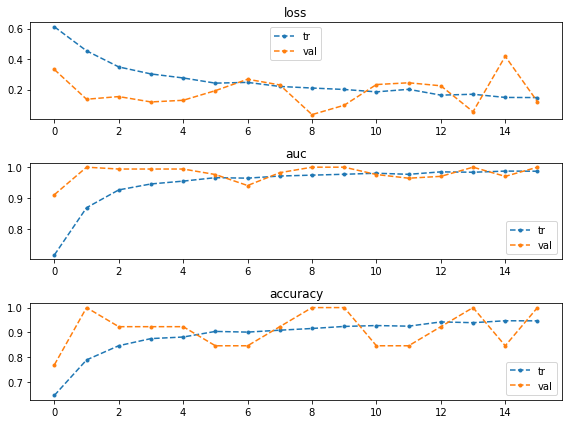

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.

 fold: 3/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  7  8  9 10 11 12 14 15 16 17 18 19 20 21 25 26 27
 28 29 30 31 32 33 34 35 37 38 39 40 41 42 44 45 46 48 49 50 51 52 55 56
 58 59 60 61 62 63 64 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82
 84 85 86 87 89 90 91] 
 Valid [13 22 23 24 36 43 47 53 54 57 65 83 88] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4430 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6924 - accuracy: 0.5063 - auc: 0.5542

 3/46 [>.............................] - ETA: 15s - loss: 0.6995 - accuracy: 0.5274 - auc: 0.5614

 4/46 [=>............................] - ETA: 16s - loss: 0.6967 - accuracy: 0.5411 - auc: 0.5672

 5/46 [==>...........................] - ETA: 17s - loss: 0.6941 - accuracy: 0.5468 - auc: 0.5703

 6/46 [==>...........................] - ETA: 17s - loss: 0.6935 - accuracy: 0.5506 - auc: 0.5693

 7/46 [===>..........................] - ETA: 17s - loss: 0.6926 - accuracy: 0.5533 - auc: 0.5680

 8/46 [====>.........................] - ETA: 17s - loss: 0.6921 - accuracy: 0.5554 - auc: 0.5672

 9/46 [====>.........................] - ETA: 17s - loss: 0.6911 - accuracy: 0.5570 - auc: 0.5689

10/46 [=====>........................] - ETA: 17s - loss: 0.6906 - accuracy: 0.5582 - auc: 0.5692

11/46 [======>.......................] - ETA: 17s - loss: 0.6893 - accuracy: 0.5593 - auc: 0.5720

12/46 [======>.......................] - ETA: 16s - loss: 0.6892 - accuracy: 0.5580 - auc: 0.5716

13/46 [=======>......................] - ETA: 16s - loss: 0.6880 - accuracy: 0.5589 - auc: 0.5751

14/46 [========>.....................] - ETA: 15s - loss: 0.6873 - accuracy: 0.5579 - auc: 0.5760

15/46 [========>.....................] - ETA: 15s - loss: 0.6878 - accuracy: 0.5586 - auc: 0.5757

16/46 [=========>....................] - ETA: 15s - loss: 0.6886 - accuracy: 0.5593 - auc: 0.5747

17/46 [==========>...................] - ETA: 14s - loss: 0.6875 - accuracy: 0.5622 - auc: 0.5789

18/46 [==========>...................] - ETA: 14s - loss: 0.6862 - accuracy: 0.5626 - auc: 0.5823

19/46 [===========>..................] - ETA: 13s - loss: 0.6842 - accuracy: 0.5656 - auc: 0.5886

20/46 [============>.................] - ETA: 13s - loss: 0.6829 - accuracy: 0.5665 - auc: 0.5907

21/46 [============>.................] - ETA: 13s - loss: 0.6818 - accuracy: 0.5678 - auc: 0.5948

22/46 [=============>................] - ETA: 12s - loss: 0.6809 - accuracy: 0.5696 - auc: 0.5992

23/46 [==============>...............] - ETA: 12s - loss: 0.6762 - accuracy: 0.5762 - auc: 0.6108

24/46 [==============>...............] - ETA: 11s - loss: 0.6729 - accuracy: 0.5796 - auc: 0.6162

25/46 [===============>..............] - ETA: 11s - loss: 0.6713 - accuracy: 0.5828 - auc: 0.6202

26/46 [===============>..............] - ETA: 10s - loss: 0.6670 - accuracy: 0.5891 - auc: 0.6287

27/46 [================>.............] - ETA: 10s - loss: 0.6662 - accuracy: 0.5902 - auc: 0.6312

28/46 [=================>............] - ETA: 9s - loss: 0.6651 - accuracy: 0.5927 - auc: 0.6336 

29/46 [=================>............] - ETA: 9s - loss: 0.6618 - accuracy: 0.5976 - auc: 0.6412

30/46 [==================>...........] - ETA: 8s - loss: 0.6601 - accuracy: 0.5992 - auc: 0.6453

31/46 [===================>..........] - ETA: 7s - loss: 0.6563 - accuracy: 0.6027 - auc: 0.6520

32/46 [===================>..........] - ETA: 7s - loss: 0.6541 - accuracy: 0.6040 - auc: 0.6550

33/46 [====================>.........] - ETA: 6s - loss: 0.6501 - accuracy: 0.6107 - auc: 0.6637

34/46 [=====================>........] - ETA: 6s - loss: 0.6467 - accuracy: 0.6139 - auc: 0.6694

35/46 [=====================>........] - ETA: 5s - loss: 0.6410 - accuracy: 0.6195 - auc: 0.6776

36/46 [======================>.......] - ETA: 5s - loss: 0.6394 - accuracy: 0.6220 - auc: 0.6814

37/46 [=======================>......] - ETA: 4s - loss: 0.6351 - accuracy: 0.6261 - auc: 0.6879

38/46 [=======================>......] - ETA: 4s - loss: 0.6341 - accuracy: 0.6279 - auc: 0.6898

39/46 [========================>.....] - ETA: 3s - loss: 0.6322 - accuracy: 0.6297 - auc: 0.6926

40/46 [=========================>....] - ETA: 3s - loss: 0.6299 - accuracy: 0.6323 - auc: 0.6961

41/46 [=========================>....] - ETA: 2s - loss: 0.6277 - accuracy: 0.6348 - auc: 0.6988

42/46 [==========================>...] - ETA: 2s - loss: 0.6255 - accuracy: 0.6362 - auc: 0.7015

43/46 [===========================>..] - ETA: 1s - loss: 0.6224 - accuracy: 0.6391 - auc: 0.7058

44/46 [===========================>..] - ETA: 1s - loss: 0.6200 - accuracy: 0.6413 - auc: 0.7089

45/46 [============================>.] - ETA: 0s - loss: 0.6163 - accuracy: 0.6442 - auc: 0.7130

46/46 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.6475 - auc: 0.7176

Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.23457, saving model to fold_3_best_model.hdf5


46/46 [==============================] - 25s 549ms/step - loss: 0.6131 - accuracy: 0.6475 - auc: 0.7176 - val_loss: 0.2346 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.5042 - accuracy: 0.7468 - auc: 0.8518

 2/46 [>.............................] - ETA: 12s - loss: 0.4793 - accuracy: 0.7468 - auc: 0.8556

 3/46 [>.............................] - ETA: 15s - loss: 0.5020 - accuracy: 0.7426 - auc: 0.8401

 4/46 [=>............................] - ETA: 16s - loss: 0.5025 - accuracy: 0.7500 - auc: 0.8369

 5/46 [==>...........................] - ETA: 17s - loss: 0.4969 - accuracy: 0.7544 - auc: 0.8386

 6/46 [==>...........................] - ETA: 17s - loss: 0.4958 - accuracy: 0.7595 - auc: 0.8414

 7/46 [===>..........................] - ETA: 17s - loss: 0.4914 - accuracy: 0.7595 - auc: 0.8437

 8/46 [====>.........................] - ETA: 17s - loss: 0.4897 - accuracy: 0.7642 - auc: 0.8446

 9/46 [====>.........................] - ETA: 17s - loss: 0.4861 - accuracy: 0.7665 - auc: 0.8470

10/46 [=====>........................] - ETA: 17s - loss: 0.4811 - accuracy: 0.7696 - auc: 0.8509

11/46 [======>.......................] - ETA: 16s - loss: 0.4732 - accuracy: 0.7722 - auc: 0.8553

12/46 [======>.......................] - ETA: 16s - loss: 0.4715 - accuracy: 0.7711 - auc: 0.8559

13/46 [=======>......................] - ETA: 16s - loss: 0.4743 - accuracy: 0.7702 - auc: 0.8555

14/46 [========>.....................] - ETA: 15s - loss: 0.4859 - accuracy: 0.7667 - auc: 0.8487

15/46 [========>.....................] - ETA: 15s - loss: 0.4839 - accuracy: 0.7671 - auc: 0.8495

16/46 [=========>....................] - ETA: 14s - loss: 0.4854 - accuracy: 0.7642 - auc: 0.8479

17/46 [==========>...................] - ETA: 14s - loss: 0.4871 - accuracy: 0.7647 - auc: 0.8466

18/46 [==========>...................] - ETA: 14s - loss: 0.4879 - accuracy: 0.7658 - auc: 0.8462

19/46 [===========>..................] - ETA: 13s - loss: 0.4866 - accuracy: 0.7668 - auc: 0.8475

20/46 [============>.................] - ETA: 13s - loss: 0.4838 - accuracy: 0.7677 - auc: 0.8490

21/46 [============>.................] - ETA: 12s - loss: 0.4766 - accuracy: 0.7703 - auc: 0.8535

22/46 [=============>................] - ETA: 12s - loss: 0.4755 - accuracy: 0.7699 - auc: 0.8538

23/46 [==============>...............] - ETA: 11s - loss: 0.4781 - accuracy: 0.7716 - auc: 0.8535

24/46 [==============>...............] - ETA: 11s - loss: 0.4749 - accuracy: 0.7737 - auc: 0.8556

25/46 [===============>..............] - ETA: 10s - loss: 0.4701 - accuracy: 0.7767 - auc: 0.8587

26/46 [===============>..............] - ETA: 10s - loss: 0.4692 - accuracy: 0.7756 - auc: 0.8593

27/46 [================>.............] - ETA: 9s - loss: 0.4673 - accuracy: 0.7773 - auc: 0.8603 

28/46 [=================>............] - ETA: 9s - loss: 0.4647 - accuracy: 0.7780 - auc: 0.8616

29/46 [=================>............] - ETA: 8s - loss: 0.4650 - accuracy: 0.7761 - auc: 0.8611

30/46 [==================>...........] - ETA: 8s - loss: 0.4621 - accuracy: 0.7751 - auc: 0.8626

31/46 [===================>..........] - ETA: 7s - loss: 0.4656 - accuracy: 0.7742 - auc: 0.8610

32/46 [===================>..........] - ETA: 7s - loss: 0.4637 - accuracy: 0.7769 - auc: 0.8624

33/46 [====================>.........] - ETA: 6s - loss: 0.4620 - accuracy: 0.7768 - auc: 0.8633

34/46 [=====================>........] - ETA: 6s - loss: 0.4621 - accuracy: 0.7762 - auc: 0.8632

35/46 [=====================>........] - ETA: 5s - loss: 0.4621 - accuracy: 0.7754 - auc: 0.8634

36/46 [======================>.......] - ETA: 5s - loss: 0.4597 - accuracy: 0.7774 - auc: 0.8649

37/46 [=======================>......] - ETA: 4s - loss: 0.4579 - accuracy: 0.7780 - auc: 0.8660

38/46 [=======================>......] - ETA: 4s - loss: 0.4591 - accuracy: 0.7768 - auc: 0.8654

39/46 [========================>.....] - ETA: 3s - loss: 0.4572 - accuracy: 0.7780 - auc: 0.8666

40/46 [=========================>....] - ETA: 3s - loss: 0.4551 - accuracy: 0.7791 - auc: 0.8681

41/46 [=========================>....] - ETA: 2s - loss: 0.4554 - accuracy: 0.7793 - auc: 0.8679

42/46 [==========================>...] - ETA: 2s - loss: 0.4551 - accuracy: 0.7794 - auc: 0.8678

43/46 [===========================>..] - ETA: 1s - loss: 0.4555 - accuracy: 0.7807 - auc: 0.8682

44/46 [===========================>..] - ETA: 1s - loss: 0.4528 - accuracy: 0.7822 - auc: 0.8698

45/46 [============================>.] - ETA: 0s - loss: 0.4520 - accuracy: 0.7823 - auc: 0.8701

46/46 [==============================] - ETA: 0s - loss: 0.4519 - accuracy: 0.7823 - auc: 0.8700

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss did not improve from 0.23457
46/46 [==============================] - 25s 541ms/step - loss: 0.4519 - accuracy: 0.7823 - auc: 0.8700 - val_loss: 0.2709 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.3814 - accuracy: 0.7975 - auc: 0.9172

 2/46 [>.............................] - ETA: 11s - loss: 0.3496 - accuracy: 0.8354 - auc: 0.9363

 3/46 [>.............................] - ETA: 15s - loss: 0.3758 - accuracy: 0.8059 - auc: 0.9157

 4/46 [=>............................] - ETA: 16s - loss: 0.3799 - accuracy: 0.8101 - auc: 0.9119

 5/46 [==>...........................] - ETA: 17s - loss: 0.3844 - accuracy: 0.8127 - auc: 0.9096

 6/46 [==>...........................] - ETA: 17s - loss: 0.3805 - accuracy: 0.8186 - auc: 0.9119

 7/46 [===>..........................] - ETA: 17s - loss: 0.3909 - accuracy: 0.8156 - auc: 0.9059

 8/46 [====>.........................] - ETA: 17s - loss: 0.3779 - accuracy: 0.8259 - auc: 0.9125

 9/46 [====>.........................] - ETA: 17s - loss: 0.3735 - accuracy: 0.8298 - auc: 0.9143

10/46 [=====>........................] - ETA: 17s - loss: 0.3789 - accuracy: 0.8304 - auc: 0.9150

11/46 [======>.......................] - ETA: 17s - loss: 0.3878 - accuracy: 0.8251 - auc: 0.9106

12/46 [======>.......................] - ETA: 16s - loss: 0.3827 - accuracy: 0.8281 - auc: 0.9132

13/46 [=======>......................] - ETA: 16s - loss: 0.3815 - accuracy: 0.8277 - auc: 0.9137

14/46 [========>.....................] - ETA: 15s - loss: 0.3807 - accuracy: 0.8282 - auc: 0.9136

15/46 [========>.....................] - ETA: 15s - loss: 0.3810 - accuracy: 0.8245 - auc: 0.9131

16/46 [=========>....................] - ETA: 15s - loss: 0.3799 - accuracy: 0.8259 - auc: 0.9133

17/46 [==========>...................] - ETA: 14s - loss: 0.3779 - accuracy: 0.8265 - auc: 0.9139

18/46 [==========>...................] - ETA: 14s - loss: 0.3721 - accuracy: 0.8298 - auc: 0.9165

19/46 [===========>..................] - ETA: 13s - loss: 0.3775 - accuracy: 0.8274 - auc: 0.9138

20/46 [============>.................] - ETA: 13s - loss: 0.3726 - accuracy: 0.8297 - auc: 0.9160

21/46 [============>.................] - ETA: 12s - loss: 0.3731 - accuracy: 0.8288 - auc: 0.9157

22/46 [=============>................] - ETA: 12s - loss: 0.3760 - accuracy: 0.8251 - auc: 0.9141

23/46 [==============>...............] - ETA: 11s - loss: 0.3731 - accuracy: 0.8255 - auc: 0.9153

24/46 [==============>...............] - ETA: 11s - loss: 0.3746 - accuracy: 0.8265 - auc: 0.9145

25/46 [===============>..............] - ETA: 10s - loss: 0.3715 - accuracy: 0.8278 - auc: 0.9161

26/46 [===============>..............] - ETA: 10s - loss: 0.3706 - accuracy: 0.8281 - auc: 0.9164

27/46 [================>.............] - ETA: 9s - loss: 0.3680 - accuracy: 0.8293 - auc: 0.9174 

28/46 [=================>............] - ETA: 9s - loss: 0.3729 - accuracy: 0.8291 - auc: 0.9158

29/46 [=================>............] - ETA: 8s - loss: 0.3733 - accuracy: 0.8276 - auc: 0.9153

30/46 [==================>...........] - ETA: 8s - loss: 0.3732 - accuracy: 0.8278 - auc: 0.9154

31/46 [===================>..........] - ETA: 7s - loss: 0.3753 - accuracy: 0.8261 - auc: 0.9144

32/46 [===================>..........] - ETA: 7s - loss: 0.3783 - accuracy: 0.8224 - auc: 0.9127

33/46 [====================>.........] - ETA: 6s - loss: 0.3772 - accuracy: 0.8251 - auc: 0.9135

34/46 [=====================>........] - ETA: 6s - loss: 0.3764 - accuracy: 0.8246 - auc: 0.9137

35/46 [=====================>........] - ETA: 5s - loss: 0.3783 - accuracy: 0.8235 - auc: 0.9128

36/46 [======================>.......] - ETA: 5s - loss: 0.3794 - accuracy: 0.8242 - auc: 0.9127

37/46 [=======================>......] - ETA: 4s - loss: 0.3777 - accuracy: 0.8265 - auc: 0.9136

38/46 [=======================>......] - ETA: 4s - loss: 0.3774 - accuracy: 0.8264 - auc: 0.9138

39/46 [========================>.....] - ETA: 3s - loss: 0.3772 - accuracy: 0.8273 - auc: 0.9140

40/46 [=========================>....] - ETA: 3s - loss: 0.3757 - accuracy: 0.8269 - auc: 0.9145

41/46 [=========================>....] - ETA: 2s - loss: 0.3739 - accuracy: 0.8271 - auc: 0.9152

42/46 [==========================>...] - ETA: 2s - loss: 0.3734 - accuracy: 0.8276 - auc: 0.9154

43/46 [===========================>..] - ETA: 1s - loss: 0.3745 - accuracy: 0.8266 - auc: 0.9148

44/46 [===========================>..] - ETA: 1s - loss: 0.3726 - accuracy: 0.8277 - auc: 0.9157

45/46 [============================>.] - ETA: 0s - loss: 0.3718 - accuracy: 0.8273 - auc: 0.9159

46/46 [==============================] - ETA: 0s - loss: 0.3698 - accuracy: 0.8283 - auc: 0.9168

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss improved from 0.23457 to 0.19295, saving model to fold_3_best_model.hdf5


46/46 [==============================] - 25s 539ms/step - loss: 0.3698 - accuracy: 0.8283 - auc: 0.9168 - val_loss: 0.1930 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3534 - accuracy: 0.8228 - auc: 0.9249

 2/46 [>.............................] - ETA: 12s - loss: 0.3771 - accuracy: 0.8165 - auc: 0.9170

 3/46 [>.............................] - ETA: 15s - loss: 0.3745 - accuracy: 0.8312 - auc: 0.9182

 4/46 [=>............................] - ETA: 16s - loss: 0.3594 - accuracy: 0.8354 - auc: 0.9218

 5/46 [==>...........................] - ETA: 17s - loss: 0.3521 - accuracy: 0.8304 - auc: 0.9243

 6/46 [==>...........................] - ETA: 18s - loss: 0.3437 - accuracy: 0.8439 - auc: 0.9294

 7/46 [===>..........................] - ETA: 17s - loss: 0.3387 - accuracy: 0.8535 - auc: 0.9322

 8/46 [====>.........................] - ETA: 17s - loss: 0.3343 - accuracy: 0.8544 - auc: 0.9329

 9/46 [====>.........................] - ETA: 17s - loss: 0.3529 - accuracy: 0.8467 - auc: 0.9256

10/46 [=====>........................] - ETA: 17s - loss: 0.3462 - accuracy: 0.8494 - auc: 0.9279

11/46 [======>.......................] - ETA: 17s - loss: 0.3359 - accuracy: 0.8550 - auc: 0.9323

12/46 [======>.......................] - ETA: 16s - loss: 0.3326 - accuracy: 0.8544 - auc: 0.9333

13/46 [=======>......................] - ETA: 16s - loss: 0.3289 - accuracy: 0.8569 - auc: 0.9347

14/46 [========>.....................] - ETA: 15s - loss: 0.3236 - accuracy: 0.8590 - auc: 0.9365

15/46 [========>.....................] - ETA: 15s - loss: 0.3239 - accuracy: 0.8557 - auc: 0.9364

16/46 [=========>....................] - ETA: 15s - loss: 0.3192 - accuracy: 0.8584 - auc: 0.9382

17/46 [==========>...................] - ETA: 14s - loss: 0.3197 - accuracy: 0.8578 - auc: 0.9379

18/46 [==========>...................] - ETA: 14s - loss: 0.3181 - accuracy: 0.8594 - auc: 0.9387

19/46 [===========>..................] - ETA: 13s - loss: 0.3162 - accuracy: 0.8588 - auc: 0.9394

20/46 [============>.................] - ETA: 13s - loss: 0.3146 - accuracy: 0.8595 - auc: 0.9399

21/46 [============>.................] - ETA: 12s - loss: 0.3129 - accuracy: 0.8608 - auc: 0.9406

22/46 [=============>................] - ETA: 12s - loss: 0.3159 - accuracy: 0.8602 - auc: 0.9394

23/46 [==============>...............] - ETA: 11s - loss: 0.3218 - accuracy: 0.8580 - auc: 0.9371

24/46 [==============>...............] - ETA: 11s - loss: 0.3223 - accuracy: 0.8586 - auc: 0.9372

25/46 [===============>..............] - ETA: 10s - loss: 0.3210 - accuracy: 0.8592 - auc: 0.9376

26/46 [===============>..............] - ETA: 10s - loss: 0.3196 - accuracy: 0.8588 - auc: 0.9380

27/46 [================>.............] - ETA: 9s - loss: 0.3184 - accuracy: 0.8608 - auc: 0.9386 

28/46 [=================>............] - ETA: 9s - loss: 0.3164 - accuracy: 0.8608 - auc: 0.9394

29/46 [=================>............] - ETA: 8s - loss: 0.3164 - accuracy: 0.8612 - auc: 0.9394

30/46 [==================>...........] - ETA: 8s - loss: 0.3200 - accuracy: 0.8599 - auc: 0.9380

31/46 [===================>..........] - ETA: 7s - loss: 0.3206 - accuracy: 0.8604 - auc: 0.9379

32/46 [===================>..........] - ETA: 7s - loss: 0.3195 - accuracy: 0.8627 - auc: 0.9386

33/46 [====================>.........] - ETA: 6s - loss: 0.3193 - accuracy: 0.8627 - auc: 0.9385

34/46 [=====================>........] - ETA: 6s - loss: 0.3195 - accuracy: 0.8619 - auc: 0.9383

35/46 [=====================>........] - ETA: 5s - loss: 0.3186 - accuracy: 0.8626 - auc: 0.9386

36/46 [======================>.......] - ETA: 5s - loss: 0.3177 - accuracy: 0.8629 - auc: 0.9389

37/46 [=======================>......] - ETA: 4s - loss: 0.3167 - accuracy: 0.8638 - auc: 0.9393

38/46 [=======================>......] - ETA: 4s - loss: 0.3161 - accuracy: 0.8638 - auc: 0.9395

39/46 [========================>.....] - ETA: 3s - loss: 0.3156 - accuracy: 0.8637 - auc: 0.9396

40/46 [=========================>....] - ETA: 3s - loss: 0.3158 - accuracy: 0.8630 - auc: 0.9394

41/46 [=========================>....] - ETA: 2s - loss: 0.3171 - accuracy: 0.8629 - auc: 0.9389

42/46 [==========================>...] - ETA: 2s - loss: 0.3165 - accuracy: 0.8632 - auc: 0.9392

43/46 [===========================>..] - ETA: 1s - loss: 0.3152 - accuracy: 0.8640 - auc: 0.9397

44/46 [===========================>..] - ETA: 1s - loss: 0.3133 - accuracy: 0.8651 - auc: 0.9405

45/46 [============================>.] - ETA: 0s - loss: 0.3121 - accuracy: 0.8661 - auc: 0.9409

46/46 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.8671 - auc: 0.9409

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss improved from 0.19295 to 0.13913, saving model to fold_3_best_model.hdf5


46/46 [==============================] - 24s 529ms/step - loss: 0.3123 - accuracy: 0.8671 - auc: 0.9409 - val_loss: 0.1391 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.2560 - accuracy: 0.8987 - auc: 0.9593

 2/46 [>.............................] - ETA: 11s - loss: 0.3057 - accuracy: 0.8734 - auc: 0.9428

 3/46 [>.............................] - ETA: 15s - loss: 0.3242 - accuracy: 0.8734 - auc: 0.9376

 4/46 [=>............................] - ETA: 16s - loss: 0.3051 - accuracy: 0.8703 - auc: 0.9441

 5/46 [==>...........................] - ETA: 17s - loss: 0.3092 - accuracy: 0.8658 - auc: 0.9420

 6/46 [==>...........................] - ETA: 17s - loss: 0.3089 - accuracy: 0.8692 - auc: 0.9420

 7/46 [===>..........................] - ETA: 19s - loss: 0.3118 - accuracy: 0.8716 - auc: 0.9410

 8/46 [====>.........................] - ETA: 19s - loss: 0.3087 - accuracy: 0.8734 - auc: 0.9426

 9/46 [====>.........................] - ETA: 19s - loss: 0.3005 - accuracy: 0.8790 - auc: 0.9454

10/46 [=====>........................] - ETA: 18s - loss: 0.2938 - accuracy: 0.8810 - auc: 0.9479

11/46 [======>.......................] - ETA: 18s - loss: 0.2893 - accuracy: 0.8826 - auc: 0.9497

12/46 [======>.......................] - ETA: 17s - loss: 0.2838 - accuracy: 0.8882 - auc: 0.9518

13/46 [=======>......................] - ETA: 17s - loss: 0.2839 - accuracy: 0.8890 - auc: 0.9519

14/46 [========>.....................] - ETA: 16s - loss: 0.2816 - accuracy: 0.8879 - auc: 0.9525

15/46 [========>.....................] - ETA: 16s - loss: 0.2798 - accuracy: 0.8869 - auc: 0.9530

16/46 [=========>....................] - ETA: 15s - loss: 0.2773 - accuracy: 0.8869 - auc: 0.9538

17/46 [==========>...................] - ETA: 15s - loss: 0.2835 - accuracy: 0.8853 - auc: 0.9519

18/46 [==========>...................] - ETA: 14s - loss: 0.2859 - accuracy: 0.8819 - auc: 0.9508

19/46 [===========>..................] - ETA: 14s - loss: 0.2917 - accuracy: 0.8774 - auc: 0.9488

20/46 [============>.................] - ETA: 13s - loss: 0.2900 - accuracy: 0.8797 - auc: 0.9496

21/46 [============>.................] - ETA: 13s - loss: 0.2898 - accuracy: 0.8782 - auc: 0.9496

22/46 [=============>................] - ETA: 12s - loss: 0.2878 - accuracy: 0.8774 - auc: 0.9502

23/46 [==============>...............] - ETA: 12s - loss: 0.2877 - accuracy: 0.8762 - auc: 0.9502

24/46 [==============>...............] - ETA: 11s - loss: 0.2877 - accuracy: 0.8761 - auc: 0.9502

25/46 [===============>..............] - ETA: 11s - loss: 0.2875 - accuracy: 0.8770 - auc: 0.9503

26/46 [===============>..............] - ETA: 10s - loss: 0.2884 - accuracy: 0.8759 - auc: 0.9499

27/46 [================>.............] - ETA: 10s - loss: 0.2869 - accuracy: 0.8762 - auc: 0.9504

28/46 [=================>............] - ETA: 9s - loss: 0.2846 - accuracy: 0.8784 - auc: 0.9512 

29/46 [=================>............] - ETA: 9s - loss: 0.2826 - accuracy: 0.8791 - auc: 0.9519

30/46 [==================>...........] - ETA: 8s - loss: 0.2843 - accuracy: 0.8797 - auc: 0.9514

31/46 [===================>..........] - ETA: 8s - loss: 0.2858 - accuracy: 0.8787 - auc: 0.9509

32/46 [===================>..........] - ETA: 7s - loss: 0.2836 - accuracy: 0.8805 - auc: 0.9517

33/46 [====================>.........] - ETA: 6s - loss: 0.2818 - accuracy: 0.8815 - auc: 0.9524

34/46 [=====================>........] - ETA: 6s - loss: 0.2787 - accuracy: 0.8835 - auc: 0.9535

35/46 [=====================>........] - ETA: 5s - loss: 0.2767 - accuracy: 0.8843 - auc: 0.9541

36/46 [======================>.......] - ETA: 5s - loss: 0.2759 - accuracy: 0.8854 - auc: 0.9544

37/46 [=======================>......] - ETA: 4s - loss: 0.2770 - accuracy: 0.8850 - auc: 0.9540

38/46 [=======================>......] - ETA: 4s - loss: 0.2776 - accuracy: 0.8847 - auc: 0.9539

39/46 [========================>.....] - ETA: 3s - loss: 0.2787 - accuracy: 0.8845 - auc: 0.9536

40/46 [=========================>....] - ETA: 3s - loss: 0.2785 - accuracy: 0.8842 - auc: 0.9536

41/46 [=========================>....] - ETA: 2s - loss: 0.2786 - accuracy: 0.8851 - auc: 0.9535

42/46 [==========================>...] - ETA: 2s - loss: 0.2798 - accuracy: 0.8846 - auc: 0.9531

43/46 [===========================>..] - ETA: 1s - loss: 0.2806 - accuracy: 0.8837 - auc: 0.9528

44/46 [===========================>..] - ETA: 1s - loss: 0.2804 - accuracy: 0.8835 - auc: 0.9529

45/46 [============================>.] - ETA: 0s - loss: 0.2816 - accuracy: 0.8827 - auc: 0.9525

46/46 [==============================] - ETA: 0s - loss: 0.2802 - accuracy: 0.8833 - auc: 0.9530

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 540ms/step - loss: 0.2802 - accuracy: 0.8833 - auc: 0.9530 - val_loss: 0.2066 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2740 - accuracy: 0.8987 - auc: 0.9553

 2/46 [>.............................] - ETA: 11s - loss: 0.3248 - accuracy: 0.8734 - auc: 0.9404

 3/46 [>.............................] - ETA: 15s - loss: 0.2905 - accuracy: 0.8861 - auc: 0.9509

 4/46 [=>............................] - ETA: 16s - loss: 0.2874 - accuracy: 0.8861 - auc: 0.9519

 5/46 [==>...........................] - ETA: 17s - loss: 0.3025 - accuracy: 0.8886 - auc: 0.9483

 6/46 [==>...........................] - ETA: 17s - loss: 0.2992 - accuracy: 0.8882 - auc: 0.9493

 7/46 [===>..........................] - ETA: 17s - loss: 0.2941 - accuracy: 0.8879 - auc: 0.9504

 8/46 [====>.........................] - ETA: 17s - loss: 0.2956 - accuracy: 0.8797 - auc: 0.9494

 9/46 [====>.........................] - ETA: 17s - loss: 0.3000 - accuracy: 0.8734 - auc: 0.9476

10/46 [=====>........................] - ETA: 17s - loss: 0.2965 - accuracy: 0.8785 - auc: 0.9487

11/46 [======>.......................] - ETA: 16s - loss: 0.3024 - accuracy: 0.8803 - auc: 0.9475

12/46 [======>.......................] - ETA: 16s - loss: 0.2975 - accuracy: 0.8819 - auc: 0.9490

13/46 [=======>......................] - ETA: 16s - loss: 0.2928 - accuracy: 0.8802 - auc: 0.9504

14/46 [========>.....................] - ETA: 15s - loss: 0.2863 - accuracy: 0.8816 - auc: 0.9526

15/46 [========>.....................] - ETA: 15s - loss: 0.2816 - accuracy: 0.8827 - auc: 0.9538

16/46 [=========>....................] - ETA: 15s - loss: 0.2782 - accuracy: 0.8813 - auc: 0.9549

17/46 [==========>...................] - ETA: 14s - loss: 0.2874 - accuracy: 0.8794 - auc: 0.9520

18/46 [==========>...................] - ETA: 14s - loss: 0.2906 - accuracy: 0.8776 - auc: 0.9510

19/46 [===========>..................] - ETA: 14s - loss: 0.2873 - accuracy: 0.8781 - auc: 0.9520

20/46 [============>.................] - ETA: 13s - loss: 0.2937 - accuracy: 0.8759 - auc: 0.9500

21/46 [============>.................] - ETA: 13s - loss: 0.2909 - accuracy: 0.8770 - auc: 0.9508

22/46 [=============>................] - ETA: 12s - loss: 0.2890 - accuracy: 0.8792 - auc: 0.9514

23/46 [==============>...............] - ETA: 12s - loss: 0.2899 - accuracy: 0.8778 - auc: 0.9509

24/46 [==============>...............] - ETA: 11s - loss: 0.2901 - accuracy: 0.8776 - auc: 0.9508

25/46 [===============>..............] - ETA: 11s - loss: 0.2900 - accuracy: 0.8775 - auc: 0.9507

26/46 [===============>..............] - ETA: 10s - loss: 0.2913 - accuracy: 0.8793 - auc: 0.9506

27/46 [================>.............] - ETA: 10s - loss: 0.2921 - accuracy: 0.8790 - auc: 0.9504

28/46 [=================>............] - ETA: 9s - loss: 0.2922 - accuracy: 0.8784 - auc: 0.9503 

29/46 [=================>............] - ETA: 9s - loss: 0.2911 - accuracy: 0.8782 - auc: 0.9506

30/46 [==================>...........] - ETA: 8s - loss: 0.2909 - accuracy: 0.8772 - auc: 0.9506

31/46 [===================>..........] - ETA: 8s - loss: 0.2877 - accuracy: 0.8795 - auc: 0.9517

32/46 [===================>..........] - ETA: 7s - loss: 0.2862 - accuracy: 0.8794 - auc: 0.9521

33/46 [====================>.........] - ETA: 7s - loss: 0.2853 - accuracy: 0.8792 - auc: 0.9522

34/46 [=====================>........] - ETA: 6s - loss: 0.2824 - accuracy: 0.8801 - auc: 0.9532

35/46 [=====================>........] - ETA: 5s - loss: 0.2817 - accuracy: 0.8807 - auc: 0.9535

36/46 [======================>.......] - ETA: 5s - loss: 0.2797 - accuracy: 0.8822 - auc: 0.9541

37/46 [=======================>......] - ETA: 4s - loss: 0.2769 - accuracy: 0.8837 - auc: 0.9550

38/46 [=======================>......] - ETA: 4s - loss: 0.2748 - accuracy: 0.8844 - auc: 0.9556

39/46 [========================>.....] - ETA: 3s - loss: 0.2737 - accuracy: 0.8848 - auc: 0.9560

40/46 [=========================>....] - ETA: 3s - loss: 0.2747 - accuracy: 0.8854 - auc: 0.9558

41/46 [=========================>....] - ETA: 2s - loss: 0.2729 - accuracy: 0.8870 - auc: 0.9564

42/46 [==========================>...] - ETA: 2s - loss: 0.2721 - accuracy: 0.8873 - auc: 0.9566

43/46 [===========================>..] - ETA: 1s - loss: 0.2723 - accuracy: 0.8873 - auc: 0.9566

44/46 [===========================>..] - ETA: 1s - loss: 0.2704 - accuracy: 0.8878 - auc: 0.9572

45/46 [============================>.] - ETA: 0s - loss: 0.2717 - accuracy: 0.8866 - auc: 0.9567

46/46 [==============================] - ETA: 0s - loss: 0.2695 - accuracy: 0.8880 - auc: 0.9574

Found 13 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 544ms/step - loss: 0.2695 - accuracy: 0.8880 - auc: 0.9574 - val_loss: 0.1652 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.2262 - accuracy: 0.8987 - auc: 0.9688

 2/46 [>.............................] - ETA: 11s - loss: 0.2035 - accuracy: 0.9241 - auc: 0.9758

 3/46 [>.............................] - ETA: 15s - loss: 0.2151 - accuracy: 0.9072 - auc: 0.9726

 4/46 [=>............................] - ETA: 17s - loss: 0.2213 - accuracy: 0.9051 - auc: 0.9711

 5/46 [==>...........................] - ETA: 17s - loss: 0.2331 - accuracy: 0.9038 - auc: 0.9680

 6/46 [==>...........................] - ETA: 18s - loss: 0.2328 - accuracy: 0.9072 - auc: 0.9684

 7/46 [===>..........................] - ETA: 18s - loss: 0.2267 - accuracy: 0.9096 - auc: 0.9701

 8/46 [====>.........................] - ETA: 17s - loss: 0.2252 - accuracy: 0.9098 - auc: 0.9705

 9/46 [====>.........................] - ETA: 17s - loss: 0.2235 - accuracy: 0.9100 - auc: 0.9710

10/46 [=====>........................] - ETA: 17s - loss: 0.2205 - accuracy: 0.9114 - auc: 0.9717

11/46 [======>.......................] - ETA: 17s - loss: 0.2215 - accuracy: 0.9091 - auc: 0.9711

12/46 [======>.......................] - ETA: 16s - loss: 0.2203 - accuracy: 0.9093 - auc: 0.9715

13/46 [=======>......................] - ETA: 16s - loss: 0.2336 - accuracy: 0.9017 - auc: 0.9677

14/46 [========>.....................] - ETA: 16s - loss: 0.2316 - accuracy: 0.9051 - auc: 0.9683

15/46 [========>.....................] - ETA: 15s - loss: 0.2268 - accuracy: 0.9097 - auc: 0.9698

16/46 [=========>....................] - ETA: 15s - loss: 0.2342 - accuracy: 0.9059 - auc: 0.9676

17/46 [==========>...................] - ETA: 14s - loss: 0.2396 - accuracy: 0.9017 - auc: 0.9660

18/46 [==========>...................] - ETA: 14s - loss: 0.2350 - accuracy: 0.9037 - auc: 0.9673

19/46 [===========>..................] - ETA: 13s - loss: 0.2408 - accuracy: 0.9034 - auc: 0.9656

20/46 [============>.................] - ETA: 13s - loss: 0.2468 - accuracy: 0.9025 - auc: 0.9645

21/46 [============>.................] - ETA: 12s - loss: 0.2521 - accuracy: 0.9011 - auc: 0.9628

22/46 [=============>................] - ETA: 12s - loss: 0.2535 - accuracy: 0.9010 - auc: 0.9623

23/46 [==============>...............] - ETA: 11s - loss: 0.2552 - accuracy: 0.8993 - auc: 0.9618

24/46 [==============>...............] - ETA: 11s - loss: 0.2571 - accuracy: 0.8993 - auc: 0.9612

25/46 [===============>..............] - ETA: 10s - loss: 0.2587 - accuracy: 0.8997 - auc: 0.9608

26/46 [===============>..............] - ETA: 10s - loss: 0.2575 - accuracy: 0.9007 - auc: 0.9612

27/46 [================>.............] - ETA: 9s - loss: 0.2583 - accuracy: 0.9006 - auc: 0.9610 

28/46 [=================>............] - ETA: 9s - loss: 0.2594 - accuracy: 0.9010 - auc: 0.9607

29/46 [=================>............] - ETA: 9s - loss: 0.2566 - accuracy: 0.9035 - auc: 0.9616

30/46 [==================>...........] - ETA: 8s - loss: 0.2547 - accuracy: 0.9046 - auc: 0.9621

31/46 [===================>..........] - ETA: 8s - loss: 0.2532 - accuracy: 0.9049 - auc: 0.9626

32/46 [===================>..........] - ETA: 7s - loss: 0.2534 - accuracy: 0.9039 - auc: 0.9624

33/46 [====================>.........] - ETA: 6s - loss: 0.2522 - accuracy: 0.9045 - auc: 0.9628

34/46 [=====================>........] - ETA: 6s - loss: 0.2522 - accuracy: 0.9047 - auc: 0.9628

35/46 [=====================>........] - ETA: 5s - loss: 0.2526 - accuracy: 0.9042 - auc: 0.9626

36/46 [======================>.......] - ETA: 5s - loss: 0.2529 - accuracy: 0.9033 - auc: 0.9624

37/46 [=======================>......] - ETA: 4s - loss: 0.2532 - accuracy: 0.9032 - auc: 0.9623

38/46 [=======================>......] - ETA: 4s - loss: 0.2544 - accuracy: 0.9021 - auc: 0.9620

39/46 [========================>.....] - ETA: 3s - loss: 0.2561 - accuracy: 0.9020 - auc: 0.9615

40/46 [=========================>....] - ETA: 3s - loss: 0.2544 - accuracy: 0.9022 - auc: 0.9620

41/46 [=========================>....] - ETA: 2s - loss: 0.2542 - accuracy: 0.9021 - auc: 0.9621

42/46 [==========================>...] - ETA: 2s - loss: 0.2546 - accuracy: 0.9011 - auc: 0.9620

43/46 [===========================>..] - ETA: 1s - loss: 0.2551 - accuracy: 0.9005 - auc: 0.9618

44/46 [===========================>..] - ETA: 1s - loss: 0.2543 - accuracy: 0.9007 - auc: 0.9621

45/46 [============================>.] - ETA: 0s - loss: 0.2533 - accuracy: 0.9015 - auc: 0.9624

46/46 [==============================] - ETA: 0s - loss: 0.2529 - accuracy: 0.9012 - auc: 0.9625

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 545ms/step - loss: 0.2529 - accuracy: 0.9012 - auc: 0.9625 - val_loss: 0.2524 - val_accuracy: 0.8462 - val_auc: 0.9645


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.2063 - accuracy: 0.9241 - auc: 0.9744

 2/46 [>.............................] - ETA: 11s - loss: 0.2405 - accuracy: 0.9051 - auc: 0.9651

 3/46 [>.............................] - ETA: 15s - loss: 0.2159 - accuracy: 0.9114 - auc: 0.9722

 4/46 [=>............................] - ETA: 17s - loss: 0.2448 - accuracy: 0.9082 - auc: 0.9647

 5/46 [==>...........................] - ETA: 17s - loss: 0.2624 - accuracy: 0.9038 - auc: 0.9604

 6/46 [==>...........................] - ETA: 17s - loss: 0.2737 - accuracy: 0.8924 - auc: 0.9568

 7/46 [===>..........................] - ETA: 17s - loss: 0.2744 - accuracy: 0.8861 - auc: 0.9564

 8/46 [====>.........................] - ETA: 17s - loss: 0.2671 - accuracy: 0.8908 - auc: 0.9584

 9/46 [====>.........................] - ETA: 17s - loss: 0.2629 - accuracy: 0.8903 - auc: 0.9595

10/46 [=====>........................] - ETA: 17s - loss: 0.2518 - accuracy: 0.8975 - auc: 0.9628

11/46 [======>.......................] - ETA: 17s - loss: 0.2476 - accuracy: 0.8987 - auc: 0.9641

12/46 [======>.......................] - ETA: 16s - loss: 0.2397 - accuracy: 0.9019 - auc: 0.9663

13/46 [=======>......................] - ETA: 16s - loss: 0.2423 - accuracy: 0.8978 - auc: 0.9655

14/46 [========>.....................] - ETA: 16s - loss: 0.2416 - accuracy: 0.8978 - auc: 0.9657

15/46 [========>.....................] - ETA: 15s - loss: 0.2469 - accuracy: 0.8996 - auc: 0.9641

16/46 [=========>....................] - ETA: 15s - loss: 0.2459 - accuracy: 0.8995 - auc: 0.9643

17/46 [==========>...................] - ETA: 14s - loss: 0.2468 - accuracy: 0.9017 - auc: 0.9642

18/46 [==========>...................] - ETA: 14s - loss: 0.2445 - accuracy: 0.9030 - auc: 0.9649

19/46 [===========>..................] - ETA: 13s - loss: 0.2448 - accuracy: 0.9034 - auc: 0.9648

20/46 [============>.................] - ETA: 13s - loss: 0.2401 - accuracy: 0.9057 - auc: 0.9661

21/46 [============>.................] - ETA: 12s - loss: 0.2385 - accuracy: 0.9060 - auc: 0.9665

22/46 [=============>................] - ETA: 12s - loss: 0.2347 - accuracy: 0.9074 - auc: 0.9676

23/46 [==============>...............] - ETA: 11s - loss: 0.2352 - accuracy: 0.9064 - auc: 0.9674

24/46 [==============>...............] - ETA: 11s - loss: 0.2342 - accuracy: 0.9077 - auc: 0.9677

25/46 [===============>..............] - ETA: 10s - loss: 0.2316 - accuracy: 0.9089 - auc: 0.9684

26/46 [===============>..............] - ETA: 10s - loss: 0.2317 - accuracy: 0.9080 - auc: 0.9684

27/46 [================>.............] - ETA: 9s - loss: 0.2293 - accuracy: 0.9086 - auc: 0.9690 

28/46 [=================>............] - ETA: 9s - loss: 0.2282 - accuracy: 0.9096 - auc: 0.9693

29/46 [=================>............] - ETA: 8s - loss: 0.2295 - accuracy: 0.9092 - auc: 0.9689

30/46 [==================>...........] - ETA: 8s - loss: 0.2296 - accuracy: 0.9089 - auc: 0.9689

31/46 [===================>..........] - ETA: 7s - loss: 0.2362 - accuracy: 0.9085 - auc: 0.9670

32/46 [===================>..........] - ETA: 7s - loss: 0.2357 - accuracy: 0.9082 - auc: 0.9672

33/46 [====================>.........] - ETA: 6s - loss: 0.2344 - accuracy: 0.9091 - auc: 0.9676

34/46 [=====================>........] - ETA: 6s - loss: 0.2342 - accuracy: 0.9084 - auc: 0.9676

35/46 [=====================>........] - ETA: 5s - loss: 0.2312 - accuracy: 0.9099 - auc: 0.9684

36/46 [======================>.......] - ETA: 5s - loss: 0.2312 - accuracy: 0.9093 - auc: 0.9684

37/46 [=======================>......] - ETA: 4s - loss: 0.2320 - accuracy: 0.9087 - auc: 0.9682

38/46 [=======================>......] - ETA: 4s - loss: 0.2303 - accuracy: 0.9094 - auc: 0.9687

39/46 [========================>.....] - ETA: 3s - loss: 0.2298 - accuracy: 0.9098 - auc: 0.9689

40/46 [=========================>....] - ETA: 3s - loss: 0.2292 - accuracy: 0.9098 - auc: 0.9690

41/46 [=========================>....] - ETA: 2s - loss: 0.2301 - accuracy: 0.9095 - auc: 0.9688

42/46 [==========================>...] - ETA: 2s - loss: 0.2294 - accuracy: 0.9099 - auc: 0.9689

43/46 [===========================>..] - ETA: 1s - loss: 0.2277 - accuracy: 0.9111 - auc: 0.9694

44/46 [===========================>..] - ETA: 1s - loss: 0.2279 - accuracy: 0.9111 - auc: 0.9694

45/46 [============================>.] - ETA: 0s - loss: 0.2274 - accuracy: 0.9108 - auc: 0.9695

46/46 [==============================] - ETA: 0s - loss: 0.2273 - accuracy: 0.9108 - auc: 0.9696

Found 13 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 542ms/step - loss: 0.2273 - accuracy: 0.9108 - auc: 0.9696 - val_loss: 0.2211 - val_accuracy: 0.8462 - val_auc: 0.9645


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.2648 - accuracy: 0.8987 - auc: 0.9583

 2/46 [>.............................] - ETA: 12s - loss: 0.2508 - accuracy: 0.8924 - auc: 0.9635

 3/46 [>.............................] - ETA: 15s - loss: 0.2197 - accuracy: 0.9072 - auc: 0.9708

 4/46 [=>............................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9114 - auc: 0.9712

 5/46 [==>...........................] - ETA: 17s - loss: 0.1946 - accuracy: 0.9266 - auc: 0.9773

 6/46 [==>...........................] - ETA: 18s - loss: 0.1984 - accuracy: 0.9219 - auc: 0.9766

 7/46 [===>..........................] - ETA: 18s - loss: 0.1902 - accuracy: 0.9222 - auc: 0.9787

 8/46 [====>.........................] - ETA: 18s - loss: 0.1976 - accuracy: 0.9193 - auc: 0.9768

 9/46 [====>.........................] - ETA: 17s - loss: 0.1995 - accuracy: 0.9184 - auc: 0.9765

10/46 [=====>........................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9177 - auc: 0.9766

11/46 [======>.......................] - ETA: 17s - loss: 0.2075 - accuracy: 0.9114 - auc: 0.9745

12/46 [======>.......................] - ETA: 16s - loss: 0.2062 - accuracy: 0.9135 - auc: 0.9749

13/46 [=======>......................] - ETA: 16s - loss: 0.2015 - accuracy: 0.9163 - auc: 0.9761

14/46 [========>.....................] - ETA: 16s - loss: 0.2043 - accuracy: 0.9141 - auc: 0.9754

15/46 [========>.....................] - ETA: 15s - loss: 0.2074 - accuracy: 0.9131 - auc: 0.9747

16/46 [=========>....................] - ETA: 15s - loss: 0.2118 - accuracy: 0.9122 - auc: 0.9735

17/46 [==========>...................] - ETA: 14s - loss: 0.2204 - accuracy: 0.9121 - auc: 0.9716

18/46 [==========>...................] - ETA: 14s - loss: 0.2235 - accuracy: 0.9114 - auc: 0.9708

19/46 [===========>..................] - ETA: 13s - loss: 0.2248 - accuracy: 0.9081 - auc: 0.9704

20/46 [============>.................] - ETA: 13s - loss: 0.2300 - accuracy: 0.9057 - auc: 0.9690

21/46 [============>.................] - ETA: 12s - loss: 0.2330 - accuracy: 0.9017 - auc: 0.9682

22/46 [=============>................] - ETA: 12s - loss: 0.2307 - accuracy: 0.9028 - auc: 0.9688

23/46 [==============>...............] - ETA: 11s - loss: 0.2302 - accuracy: 0.9026 - auc: 0.9690

24/46 [==============>...............] - ETA: 11s - loss: 0.2278 - accuracy: 0.9035 - auc: 0.9697

25/46 [===============>..............] - ETA: 10s - loss: 0.2262 - accuracy: 0.9038 - auc: 0.9701

26/46 [===============>..............] - ETA: 10s - loss: 0.2278 - accuracy: 0.9041 - auc: 0.9697

27/46 [================>.............] - ETA: 9s - loss: 0.2267 - accuracy: 0.9044 - auc: 0.9700 

28/46 [=================>............] - ETA: 9s - loss: 0.2247 - accuracy: 0.9046 - auc: 0.9705

29/46 [=================>............] - ETA: 8s - loss: 0.2238 - accuracy: 0.9044 - auc: 0.9707

30/46 [==================>...........] - ETA: 8s - loss: 0.2265 - accuracy: 0.9046 - auc: 0.9701

31/46 [===================>..........] - ETA: 7s - loss: 0.2262 - accuracy: 0.9049 - auc: 0.9701

32/46 [===================>..........] - ETA: 7s - loss: 0.2266 - accuracy: 0.9039 - auc: 0.9700

33/46 [====================>.........] - ETA: 6s - loss: 0.2281 - accuracy: 0.9033 - auc: 0.9696

34/46 [=====================>........] - ETA: 6s - loss: 0.2250 - accuracy: 0.9039 - auc: 0.9704

35/46 [=====================>........] - ETA: 5s - loss: 0.2259 - accuracy: 0.9045 - auc: 0.9703

36/46 [======================>.......] - ETA: 5s - loss: 0.2252 - accuracy: 0.9058 - auc: 0.9705

37/46 [=======================>......] - ETA: 4s - loss: 0.2256 - accuracy: 0.9066 - auc: 0.9707

38/46 [=======================>......] - ETA: 4s - loss: 0.2239 - accuracy: 0.9074 - auc: 0.9711

39/46 [========================>.....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9081 - auc: 0.9707

40/46 [=========================>....] - ETA: 3s - loss: 0.2252 - accuracy: 0.9085 - auc: 0.9708

41/46 [=========================>....] - ETA: 2s - loss: 0.2266 - accuracy: 0.9083 - auc: 0.9705

42/46 [==========================>...] - ETA: 2s - loss: 0.2258 - accuracy: 0.9081 - auc: 0.9707

43/46 [===========================>..] - ETA: 1s - loss: 0.2242 - accuracy: 0.9096 - auc: 0.9711

44/46 [===========================>..] - ETA: 1s - loss: 0.2239 - accuracy: 0.9097 - auc: 0.9712

45/46 [============================>.] - ETA: 0s - loss: 0.2233 - accuracy: 0.9100 - auc: 0.9713

46/46 [==============================] - ETA: 0s - loss: 0.2243 - accuracy: 0.9097 - auc: 0.9711

Found 13 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss did not improve from 0.13913

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 24s 532ms/step - loss: 0.2243 - accuracy: 0.9097 - auc: 0.9711 - val_loss: 0.2173 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.2063 - accuracy: 0.9114 - auc: 0.9746

 2/46 [>.............................] - ETA: 11s - loss: 0.2024 - accuracy: 0.9114 - auc: 0.9758

 3/46 [>.............................] - ETA: 15s - loss: 0.2178 - accuracy: 0.8987 - auc: 0.9717

 4/46 [=>............................] - ETA: 16s - loss: 0.2135 - accuracy: 0.9082 - auc: 0.9734

 5/46 [==>...........................] - ETA: 20s - loss: 0.2072 - accuracy: 0.9139 - auc: 0.9758

 6/46 [==>...........................] - ETA: 20s - loss: 0.2011 - accuracy: 0.9177 - auc: 0.9782

 7/46 [===>..........................] - ETA: 20s - loss: 0.1927 - accuracy: 0.9259 - auc: 0.9802

 8/46 [====>.........................] - ETA: 19s - loss: 0.1858 - accuracy: 0.9288 - auc: 0.9819

 9/46 [====>.........................] - ETA: 19s - loss: 0.1833 - accuracy: 0.9325 - auc: 0.9823

10/46 [=====>........................] - ETA: 18s - loss: 0.1855 - accuracy: 0.9329 - auc: 0.9812

11/46 [======>.......................] - ETA: 18s - loss: 0.1849 - accuracy: 0.9298 - auc: 0.9812

12/46 [======>.......................] - ETA: 17s - loss: 0.1823 - accuracy: 0.9304 - auc: 0.9818

13/46 [=======>......................] - ETA: 17s - loss: 0.1807 - accuracy: 0.9299 - auc: 0.9819

14/46 [========>.....................] - ETA: 17s - loss: 0.1795 - accuracy: 0.9286 - auc: 0.9821

15/46 [========>.....................] - ETA: 16s - loss: 0.1794 - accuracy: 0.9283 - auc: 0.9820

16/46 [=========>....................] - ETA: 16s - loss: 0.1770 - accuracy: 0.9288 - auc: 0.9825

17/46 [==========>...................] - ETA: 15s - loss: 0.1743 - accuracy: 0.9308 - auc: 0.9830

18/46 [==========>...................] - ETA: 15s - loss: 0.1709 - accuracy: 0.9318 - auc: 0.9837

19/46 [===========>..................] - ETA: 14s - loss: 0.1722 - accuracy: 0.9314 - auc: 0.9833

20/46 [============>.................] - ETA: 14s - loss: 0.1739 - accuracy: 0.9310 - auc: 0.9828

21/46 [============>.................] - ETA: 13s - loss: 0.1750 - accuracy: 0.9307 - auc: 0.9824

22/46 [=============>................] - ETA: 12s - loss: 0.1763 - accuracy: 0.9292 - auc: 0.9820

23/46 [==============>...............] - ETA: 12s - loss: 0.1801 - accuracy: 0.9285 - auc: 0.9812

24/46 [==============>...............] - ETA: 11s - loss: 0.1815 - accuracy: 0.9272 - auc: 0.9808

25/46 [===============>..............] - ETA: 11s - loss: 0.1917 - accuracy: 0.9256 - auc: 0.9789

26/46 [===============>..............] - ETA: 10s - loss: 0.1927 - accuracy: 0.9260 - auc: 0.9787

27/46 [================>.............] - ETA: 10s - loss: 0.1933 - accuracy: 0.9259 - auc: 0.9785

28/46 [=================>............] - ETA: 9s - loss: 0.1921 - accuracy: 0.9268 - auc: 0.9788 

29/46 [=================>............] - ETA: 9s - loss: 0.1928 - accuracy: 0.9249 - auc: 0.9786

30/46 [==================>...........] - ETA: 8s - loss: 0.2028 - accuracy: 0.9219 - auc: 0.9763

31/46 [===================>..........] - ETA: 8s - loss: 0.2028 - accuracy: 0.9224 - auc: 0.9763

32/46 [===================>..........] - ETA: 7s - loss: 0.2040 - accuracy: 0.9233 - auc: 0.9760

33/46 [====================>.........] - ETA: 7s - loss: 0.2042 - accuracy: 0.9233 - auc: 0.9760

34/46 [=====================>........] - ETA: 6s - loss: 0.2063 - accuracy: 0.9233 - auc: 0.9755

35/46 [=====================>........] - ETA: 5s - loss: 0.2078 - accuracy: 0.9237 - auc: 0.9751

36/46 [======================>.......] - ETA: 5s - loss: 0.2076 - accuracy: 0.9237 - auc: 0.9751

37/46 [=======================>......] - ETA: 4s - loss: 0.2089 - accuracy: 0.9230 - auc: 0.9748

38/46 [=======================>......] - ETA: 4s - loss: 0.2094 - accuracy: 0.9234 - auc: 0.9747

39/46 [========================>.....] - ETA: 3s - loss: 0.2114 - accuracy: 0.9221 - auc: 0.9743

40/46 [=========================>....] - ETA: 3s - loss: 0.2122 - accuracy: 0.9215 - auc: 0.9741

41/46 [=========================>....] - ETA: 2s - loss: 0.2114 - accuracy: 0.9222 - auc: 0.9743

42/46 [==========================>...] - ETA: 2s - loss: 0.2139 - accuracy: 0.9216 - auc: 0.9737

43/46 [===========================>..] - ETA: 1s - loss: 0.2120 - accuracy: 0.9223 - auc: 0.9741

44/46 [===========================>..] - ETA: 1s - loss: 0.2104 - accuracy: 0.9226 - auc: 0.9745

45/46 [============================>.] - ETA: 0s - loss: 0.2095 - accuracy: 0.9229 - auc: 0.9747

46/46 [==============================] - ETA: 0s - loss: 0.2091 - accuracy: 0.9229 - auc: 0.9749

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 543ms/step - loss: 0.2091 - accuracy: 0.9229 - auc: 0.9749 - val_loss: 0.1936 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.1937 - accuracy: 0.8861 - auc: 0.9766

 2/46 [>.............................] - ETA: 11s - loss: 0.1955 - accuracy: 0.9051 - auc: 0.9780

 3/46 [>.............................] - ETA: 15s - loss: 0.1988 - accuracy: 0.9114 - auc: 0.9772

 4/46 [=>............................] - ETA: 17s - loss: 0.2026 - accuracy: 0.9114 - auc: 0.9761

 5/46 [==>...........................] - ETA: 17s - loss: 0.1970 - accuracy: 0.9190 - auc: 0.9776

 6/46 [==>...........................] - ETA: 18s - loss: 0.1870 - accuracy: 0.9262 - auc: 0.9800

 7/46 [===>..........................] - ETA: 18s - loss: 0.1917 - accuracy: 0.9277 - auc: 0.9788

 8/46 [====>.........................] - ETA: 18s - loss: 0.1965 - accuracy: 0.9209 - auc: 0.9776

 9/46 [====>.........................] - ETA: 17s - loss: 0.1872 - accuracy: 0.9241 - auc: 0.9798

10/46 [=====>........................] - ETA: 17s - loss: 0.1793 - accuracy: 0.9253 - auc: 0.9816

11/46 [======>.......................] - ETA: 17s - loss: 0.1802 - accuracy: 0.9275 - auc: 0.9810

12/46 [======>.......................] - ETA: 16s - loss: 0.1855 - accuracy: 0.9241 - auc: 0.9798

13/46 [=======>......................] - ETA: 16s - loss: 0.1843 - accuracy: 0.9250 - auc: 0.9800

14/46 [========>.....................] - ETA: 16s - loss: 0.1839 - accuracy: 0.9259 - auc: 0.9802

15/46 [========>.....................] - ETA: 15s - loss: 0.1832 - accuracy: 0.9257 - auc: 0.9803

16/46 [=========>....................] - ETA: 15s - loss: 0.1835 - accuracy: 0.9256 - auc: 0.9803

17/46 [==========>...................] - ETA: 15s - loss: 0.1824 - accuracy: 0.9263 - auc: 0.9806

18/46 [==========>...................] - ETA: 14s - loss: 0.1929 - accuracy: 0.9226 - auc: 0.9784

19/46 [===========>..................] - ETA: 14s - loss: 0.1944 - accuracy: 0.9214 - auc: 0.9780

20/46 [============>.................] - ETA: 13s - loss: 0.1940 - accuracy: 0.9222 - auc: 0.9780

21/46 [============>.................] - ETA: 13s - loss: 0.1941 - accuracy: 0.9234 - auc: 0.9780

22/46 [=============>................] - ETA: 12s - loss: 0.1950 - accuracy: 0.9246 - auc: 0.9778

23/46 [==============>...............] - ETA: 12s - loss: 0.1931 - accuracy: 0.9252 - auc: 0.9782

24/46 [==============>...............] - ETA: 11s - loss: 0.1925 - accuracy: 0.9256 - auc: 0.9783

25/46 [===============>..............] - ETA: 11s - loss: 0.1934 - accuracy: 0.9246 - auc: 0.9782

26/46 [===============>..............] - ETA: 10s - loss: 0.1944 - accuracy: 0.9231 - auc: 0.9779

27/46 [================>.............] - ETA: 10s - loss: 0.1984 - accuracy: 0.9217 - auc: 0.9770

28/46 [=================>............] - ETA: 9s - loss: 0.1983 - accuracy: 0.9227 - auc: 0.9771 

29/46 [=================>............] - ETA: 9s - loss: 0.1970 - accuracy: 0.9223 - auc: 0.9774

30/46 [==================>...........] - ETA: 8s - loss: 0.1966 - accuracy: 0.9211 - auc: 0.9775

31/46 [===================>..........] - ETA: 8s - loss: 0.1963 - accuracy: 0.9204 - auc: 0.9775

32/46 [===================>..........] - ETA: 7s - loss: 0.1974 - accuracy: 0.9193 - auc: 0.9772

33/46 [====================>.........] - ETA: 6s - loss: 0.1980 - accuracy: 0.9191 - auc: 0.9771

34/46 [=====================>........] - ETA: 6s - loss: 0.1961 - accuracy: 0.9196 - auc: 0.9776

35/46 [=====================>........] - ETA: 5s - loss: 0.1967 - accuracy: 0.9197 - auc: 0.9774

36/46 [======================>.......] - ETA: 5s - loss: 0.1966 - accuracy: 0.9191 - auc: 0.9774

37/46 [=======================>......] - ETA: 4s - loss: 0.1963 - accuracy: 0.9189 - auc: 0.9775

38/46 [=======================>......] - ETA: 4s - loss: 0.1948 - accuracy: 0.9194 - auc: 0.9778

39/46 [========================>.....] - ETA: 3s - loss: 0.1939 - accuracy: 0.9198 - auc: 0.9780

40/46 [=========================>....] - ETA: 3s - loss: 0.1936 - accuracy: 0.9206 - auc: 0.9781

41/46 [=========================>....] - ETA: 2s - loss: 0.1928 - accuracy: 0.9207 - auc: 0.9783

42/46 [==========================>...] - ETA: 2s - loss: 0.1935 - accuracy: 0.9210 - auc: 0.9782

43/46 [===========================>..] - ETA: 1s - loss: 0.1941 - accuracy: 0.9214 - auc: 0.9780

44/46 [===========================>..] - ETA: 1s - loss: 0.1938 - accuracy: 0.9220 - auc: 0.9780

45/46 [============================>.] - ETA: 0s - loss: 0.1932 - accuracy: 0.9224 - auc: 0.9782

46/46 [==============================] - ETA: 0s - loss: 0.1950 - accuracy: 0.9216 - auc: 0.9778

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00011: val_loss did not improve from 0.13913
46/46 [==============================] - 25s 542ms/step - loss: 0.1950 - accuracy: 0.9216 - auc: 0.9778 - val_loss: 0.3380 - val_accuracy: 0.8462 - val_auc: 0.9527


Epoch 00011: early stopping


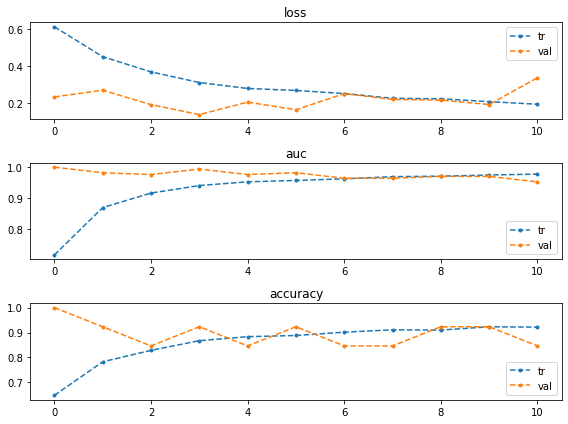

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.

 fold: 4/7, seed: 0/1 


 Train [ 0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 19 21 22 23 24 25 26
 27 28 30 31 32 34 35 36 37 38 39 40 41 43 44 45 46 47 48 50 51 52 53 54
 55 56 57 59 60 62 63 64 65 66 67 68 70 71 72 73 74 75 76 77 78 80 81 82
 83 84 85 86 88 90 91] 
 Valid [ 8 18 20 29 33 42 49 58 61 69 79 87 89] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4810 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6916 - accuracy: 0.5253 - auc: 0.5479

 3/46 [>.............................] - ETA: 15s - loss: 0.7231 - accuracy: 0.5401 - auc: 0.5603

 4/46 [=>............................] - ETA: 16s - loss: 0.7148 - accuracy: 0.5443 - auc: 0.5632

 5/46 [==>...........................] - ETA: 17s - loss: 0.7095 - accuracy: 0.5494 - auc: 0.5631

 6/46 [==>...........................] - ETA: 17s - loss: 0.7055 - accuracy: 0.5527 - auc: 0.5655

 7/46 [===>..........................] - ETA: 17s - loss: 0.7030 - accuracy: 0.5552 - auc: 0.5656

 8/46 [====>.........................] - ETA: 17s - loss: 0.7002 - accuracy: 0.5585 - auc: 0.5710

 9/46 [====>.........................] - ETA: 17s - loss: 0.6986 - accuracy: 0.5598 - auc: 0.5716

10/46 [=====>........................] - ETA: 17s - loss: 0.7100 - accuracy: 0.5468 - auc: 0.5481

11/46 [======>.......................] - ETA: 17s - loss: 0.7083 - accuracy: 0.5489 - auc: 0.5515

12/46 [======>.......................] - ETA: 16s - loss: 0.7088 - accuracy: 0.5506 - auc: 0.5539

13/46 [=======>......................] - ETA: 16s - loss: 0.7069 - accuracy: 0.5521 - auc: 0.5558

14/46 [========>.....................] - ETA: 15s - loss: 0.7053 - accuracy: 0.5533 - auc: 0.5567

15/46 [========>.....................] - ETA: 15s - loss: 0.7041 - accuracy: 0.5544 - auc: 0.5578

16/46 [=========>....................] - ETA: 15s - loss: 0.7033 - accuracy: 0.5546 - auc: 0.5581

17/46 [==========>...................] - ETA: 14s - loss: 0.7024 - accuracy: 0.5570 - auc: 0.5589

18/46 [==========>...................] - ETA: 14s - loss: 0.7009 - accuracy: 0.5584 - auc: 0.5611

19/46 [===========>..................] - ETA: 13s - loss: 0.6994 - accuracy: 0.5590 - auc: 0.5632

20/46 [============>.................] - ETA: 13s - loss: 0.6984 - accuracy: 0.5595 - auc: 0.5648

21/46 [============>.................] - ETA: 12s - loss: 0.6975 - accuracy: 0.5600 - auc: 0.5659

22/46 [=============>................] - ETA: 12s - loss: 0.6961 - accuracy: 0.5610 - auc: 0.5687

23/46 [==============>...............] - ETA: 11s - loss: 0.6954 - accuracy: 0.5619 - auc: 0.5696

24/46 [==============>...............] - ETA: 11s - loss: 0.6944 - accuracy: 0.5665 - auc: 0.5722

25/46 [===============>..............] - ETA: 11s - loss: 0.6929 - accuracy: 0.5691 - auc: 0.5765

26/46 [===============>..............] - ETA: 10s - loss: 0.6910 - accuracy: 0.5711 - auc: 0.5805

27/46 [================>.............] - ETA: 10s - loss: 0.6895 - accuracy: 0.5743 - auc: 0.5849

28/46 [=================>............] - ETA: 9s - loss: 0.6887 - accuracy: 0.5750 - auc: 0.5865 

29/46 [=================>............] - ETA: 9s - loss: 0.6881 - accuracy: 0.5779 - auc: 0.5892

30/46 [==================>...........] - ETA: 8s - loss: 0.6868 - accuracy: 0.5781 - auc: 0.5904

31/46 [===================>..........] - ETA: 8s - loss: 0.6859 - accuracy: 0.5802 - auc: 0.5920

32/46 [===================>..........] - ETA: 7s - loss: 0.6842 - accuracy: 0.5823 - auc: 0.5949

33/46 [====================>.........] - ETA: 7s - loss: 0.6817 - accuracy: 0.5850 - auc: 0.6001

34/46 [=====================>........] - ETA: 6s - loss: 0.6822 - accuracy: 0.5871 - auc: 0.6037

35/46 [=====================>........] - ETA: 5s - loss: 0.6809 - accuracy: 0.5873 - auc: 0.6054

36/46 [======================>.......] - ETA: 5s - loss: 0.6788 - accuracy: 0.5897 - auc: 0.6096

37/46 [=======================>......] - ETA: 4s - loss: 0.6783 - accuracy: 0.5884 - auc: 0.6096

38/46 [=======================>......] - ETA: 4s - loss: 0.6779 - accuracy: 0.5889 - auc: 0.6101

39/46 [========================>.....] - ETA: 3s - loss: 0.6778 - accuracy: 0.5891 - auc: 0.6107

40/46 [=========================>....] - ETA: 3s - loss: 0.6768 - accuracy: 0.5918 - auc: 0.6134

41/46 [=========================>....] - ETA: 2s - loss: 0.6756 - accuracy: 0.5931 - auc: 0.6159

42/46 [==========================>...] - ETA: 2s - loss: 0.6743 - accuracy: 0.5925 - auc: 0.6170

43/46 [===========================>..] - ETA: 1s - loss: 0.6701 - accuracy: 0.5973 - auc: 0.6248

44/46 [===========================>..] - ETA: 1s - loss: 0.6695 - accuracy: 0.5998 - auc: 0.6283

45/46 [============================>.] - ETA: 0s - loss: 0.6673 - accuracy: 0.6028 - auc: 0.6338

46/46 [==============================] - ETA: 0s - loss: 0.6648 - accuracy: 0.6051 - auc: 0.6382

Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.69919, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 25s 554ms/step - loss: 0.6648 - accuracy: 0.6051 - auc: 0.6382 - val_loss: 0.6992 - val_accuracy: 0.6154 - val_auc: 0.6627


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.5884 - accuracy: 0.6456 - auc: 0.7498

 2/46 [>.............................] - ETA: 11s - loss: 0.5790 - accuracy: 0.6709 - auc: 0.7548

 3/46 [>.............................] - ETA: 15s - loss: 0.5744 - accuracy: 0.6962 - auc: 0.7726

 4/46 [=>............................] - ETA: 16s - loss: 0.5794 - accuracy: 0.6962 - auc: 0.7710

 5/46 [==>...........................] - ETA: 17s - loss: 0.5699 - accuracy: 0.7038 - auc: 0.7806

 6/46 [==>...........................] - ETA: 17s - loss: 0.5572 - accuracy: 0.7131 - auc: 0.7907

 7/46 [===>..........................] - ETA: 17s - loss: 0.5529 - accuracy: 0.7125 - auc: 0.7942

 8/46 [====>.........................] - ETA: 17s - loss: 0.5565 - accuracy: 0.7073 - auc: 0.7898

 9/46 [====>.........................] - ETA: 17s - loss: 0.5663 - accuracy: 0.6962 - auc: 0.7802

10/46 [=====>........................] - ETA: 17s - loss: 0.5647 - accuracy: 0.7000 - auc: 0.7812

11/46 [======>.......................] - ETA: 16s - loss: 0.5602 - accuracy: 0.7066 - auc: 0.7860

12/46 [======>.......................] - ETA: 16s - loss: 0.5619 - accuracy: 0.7057 - auc: 0.7840

13/46 [=======>......................] - ETA: 16s - loss: 0.5600 - accuracy: 0.7089 - auc: 0.7859

14/46 [========>.....................] - ETA: 15s - loss: 0.5534 - accuracy: 0.7161 - auc: 0.7928

15/46 [========>.....................] - ETA: 15s - loss: 0.5530 - accuracy: 0.7173 - auc: 0.7930

16/46 [=========>....................] - ETA: 14s - loss: 0.5519 - accuracy: 0.7199 - auc: 0.7941

17/46 [==========>...................] - ETA: 14s - loss: 0.5499 - accuracy: 0.7230 - auc: 0.7965

18/46 [==========>...................] - ETA: 14s - loss: 0.5506 - accuracy: 0.7229 - auc: 0.7963

19/46 [===========>..................] - ETA: 13s - loss: 0.5468 - accuracy: 0.7249 - auc: 0.7993

20/46 [============>.................] - ETA: 13s - loss: 0.5465 - accuracy: 0.7278 - auc: 0.7999

21/46 [============>.................] - ETA: 12s - loss: 0.5452 - accuracy: 0.7269 - auc: 0.8003

22/46 [=============>................] - ETA: 12s - loss: 0.5403 - accuracy: 0.7296 - auc: 0.8044

23/46 [==============>...............] - ETA: 11s - loss: 0.5381 - accuracy: 0.7314 - auc: 0.8061

24/46 [==============>...............] - ETA: 11s - loss: 0.5366 - accuracy: 0.7315 - auc: 0.8066

25/46 [===============>..............] - ETA: 10s - loss: 0.5340 - accuracy: 0.7316 - auc: 0.8087

26/46 [===============>..............] - ETA: 10s - loss: 0.5343 - accuracy: 0.7313 - auc: 0.8088

27/46 [================>.............] - ETA: 9s - loss: 0.5332 - accuracy: 0.7318 - auc: 0.8097 

28/46 [=================>............] - ETA: 9s - loss: 0.5328 - accuracy: 0.7319 - auc: 0.8101

29/46 [=================>............] - ETA: 8s - loss: 0.5295 - accuracy: 0.7355 - auc: 0.8127

30/46 [==================>...........] - ETA: 8s - loss: 0.5289 - accuracy: 0.7363 - auc: 0.8132

31/46 [===================>..........] - ETA: 7s - loss: 0.5270 - accuracy: 0.7370 - auc: 0.8146

32/46 [===================>..........] - ETA: 7s - loss: 0.5261 - accuracy: 0.7373 - auc: 0.8154

33/46 [====================>.........] - ETA: 6s - loss: 0.5242 - accuracy: 0.7392 - auc: 0.8171

34/46 [=====================>........] - ETA: 6s - loss: 0.5206 - accuracy: 0.7416 - auc: 0.8201

35/46 [=====================>........] - ETA: 5s - loss: 0.5178 - accuracy: 0.7436 - auc: 0.8224

36/46 [======================>.......] - ETA: 5s - loss: 0.5156 - accuracy: 0.7458 - auc: 0.8243

37/46 [=======================>......] - ETA: 4s - loss: 0.5142 - accuracy: 0.7472 - auc: 0.8261

38/46 [=======================>......] - ETA: 4s - loss: 0.5102 - accuracy: 0.7502 - auc: 0.8292

39/46 [========================>.....] - ETA: 3s - loss: 0.5078 - accuracy: 0.7514 - auc: 0.8309

40/46 [=========================>....] - ETA: 3s - loss: 0.5074 - accuracy: 0.7528 - auc: 0.8315

41/46 [=========================>....] - ETA: 2s - loss: 0.5042 - accuracy: 0.7555 - auc: 0.8340

42/46 [==========================>...] - ETA: 2s - loss: 0.5059 - accuracy: 0.7550 - auc: 0.8330

43/46 [===========================>..] - ETA: 1s - loss: 0.5045 - accuracy: 0.7551 - auc: 0.8339

44/46 [===========================>..] - ETA: 1s - loss: 0.5039 - accuracy: 0.7546 - auc: 0.8340

45/46 [============================>.] - ETA: 0s - loss: 0.5028 - accuracy: 0.7544 - auc: 0.8347

46/46 [==============================] - ETA: 0s - loss: 0.5029 - accuracy: 0.7543 - auc: 0.8346

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss did not improve from 0.69919
46/46 [==============================] - 25s 533ms/step - loss: 0.5029 - accuracy: 0.7543 - auc: 0.8346 - val_loss: 0.7011 - val_accuracy: 0.6154 - val_auc: 0.6864


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.4975 - accuracy: 0.7722 - auc: 0.8459

 2/46 [>.............................] - ETA: 11s - loss: 0.4993 - accuracy: 0.7722 - auc: 0.8398

 3/46 [>.............................] - ETA: 15s - loss: 0.4944 - accuracy: 0.7679 - auc: 0.8425

 4/46 [=>............................] - ETA: 17s - loss: 0.5077 - accuracy: 0.7563 - auc: 0.8284

 5/46 [==>...........................] - ETA: 17s - loss: 0.5085 - accuracy: 0.7646 - auc: 0.8286

 6/46 [==>...........................] - ETA: 18s - loss: 0.4934 - accuracy: 0.7764 - auc: 0.8408

 7/46 [===>..........................] - ETA: 18s - loss: 0.4929 - accuracy: 0.7812 - auc: 0.8404

 8/46 [====>.........................] - ETA: 18s - loss: 0.4974 - accuracy: 0.7785 - auc: 0.8392

 9/46 [====>.........................] - ETA: 17s - loss: 0.4846 - accuracy: 0.7820 - auc: 0.8483

10/46 [=====>........................] - ETA: 17s - loss: 0.4793 - accuracy: 0.7899 - auc: 0.8520

11/46 [======>.......................] - ETA: 17s - loss: 0.4721 - accuracy: 0.7952 - auc: 0.8575

12/46 [======>.......................] - ETA: 16s - loss: 0.4743 - accuracy: 0.7911 - auc: 0.8560

13/46 [=======>......................] - ETA: 16s - loss: 0.4707 - accuracy: 0.7926 - auc: 0.8585

14/46 [========>.....................] - ETA: 16s - loss: 0.4722 - accuracy: 0.7911 - auc: 0.8587

15/46 [========>.....................] - ETA: 15s - loss: 0.4744 - accuracy: 0.7890 - auc: 0.8572

16/46 [=========>....................] - ETA: 15s - loss: 0.4718 - accuracy: 0.7919 - auc: 0.8590

17/46 [==========>...................] - ETA: 14s - loss: 0.4749 - accuracy: 0.7870 - auc: 0.8560

18/46 [==========>...................] - ETA: 14s - loss: 0.4769 - accuracy: 0.7855 - auc: 0.8551

19/46 [===========>..................] - ETA: 13s - loss: 0.4751 - accuracy: 0.7861 - auc: 0.8573

20/46 [============>.................] - ETA: 13s - loss: 0.4705 - accuracy: 0.7873 - auc: 0.8601

21/46 [============>.................] - ETA: 12s - loss: 0.4672 - accuracy: 0.7872 - auc: 0.8618

22/46 [=============>................] - ETA: 12s - loss: 0.4713 - accuracy: 0.7842 - auc: 0.8600

23/46 [==============>...............] - ETA: 11s - loss: 0.4700 - accuracy: 0.7843 - auc: 0.8609

24/46 [==============>...............] - ETA: 11s - loss: 0.4723 - accuracy: 0.7822 - auc: 0.8592

25/46 [===============>..............] - ETA: 10s - loss: 0.4756 - accuracy: 0.7792 - auc: 0.8569

26/46 [===============>..............] - ETA: 10s - loss: 0.4718 - accuracy: 0.7809 - auc: 0.8593

27/46 [================>.............] - ETA: 9s - loss: 0.4693 - accuracy: 0.7820 - auc: 0.8609 

28/46 [=================>............] - ETA: 9s - loss: 0.4669 - accuracy: 0.7835 - auc: 0.8624

29/46 [=================>............] - ETA: 8s - loss: 0.4650 - accuracy: 0.7839 - auc: 0.8634

30/46 [==================>...........] - ETA: 8s - loss: 0.4646 - accuracy: 0.7835 - auc: 0.8635

31/46 [===================>..........] - ETA: 7s - loss: 0.4624 - accuracy: 0.7836 - auc: 0.8649

32/46 [===================>..........] - ETA: 7s - loss: 0.4628 - accuracy: 0.7836 - auc: 0.8649

33/46 [====================>.........] - ETA: 6s - loss: 0.4629 - accuracy: 0.7840 - auc: 0.8649

34/46 [=====================>........] - ETA: 6s - loss: 0.4596 - accuracy: 0.7844 - auc: 0.8669

35/46 [=====================>........] - ETA: 5s - loss: 0.4573 - accuracy: 0.7855 - auc: 0.8684

36/46 [======================>.......] - ETA: 5s - loss: 0.4548 - accuracy: 0.7873 - auc: 0.8700

37/46 [=======================>......] - ETA: 4s - loss: 0.4536 - accuracy: 0.7875 - auc: 0.8706

38/46 [=======================>......] - ETA: 4s - loss: 0.4508 - accuracy: 0.7888 - auc: 0.8723

39/46 [========================>.....] - ETA: 3s - loss: 0.4475 - accuracy: 0.7910 - auc: 0.8742

40/46 [=========================>....] - ETA: 3s - loss: 0.4476 - accuracy: 0.7908 - auc: 0.8741

41/46 [=========================>....] - ETA: 2s - loss: 0.4457 - accuracy: 0.7919 - auc: 0.8752

42/46 [==========================>...] - ETA: 2s - loss: 0.4459 - accuracy: 0.7926 - auc: 0.8752

43/46 [===========================>..] - ETA: 1s - loss: 0.4430 - accuracy: 0.7948 - auc: 0.8771

44/46 [===========================>..] - ETA: 1s - loss: 0.4410 - accuracy: 0.7955 - auc: 0.8782

45/46 [============================>.] - ETA: 0s - loss: 0.4380 - accuracy: 0.7966 - auc: 0.8799

46/46 [==============================] - ETA: 0s - loss: 0.4344 - accuracy: 0.7988 - auc: 0.8821

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss did not improve from 0.69919
46/46 [==============================] - 24s 526ms/step - loss: 0.4344 - accuracy: 0.7988 - auc: 0.8821 - val_loss: 0.7092 - val_accuracy: 0.7692 - val_auc: 0.8166


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3573 - accuracy: 0.8101 - auc: 0.9273

 2/46 [>.............................] - ETA: 12s - loss: 0.3530 - accuracy: 0.8228 - auc: 0.9268

 3/46 [>.............................] - ETA: 15s - loss: 0.3528 - accuracy: 0.8270 - auc: 0.9266

 4/46 [=>............................] - ETA: 17s - loss: 0.3655 - accuracy: 0.8196 - auc: 0.9212

 5/46 [==>...........................] - ETA: 19s - loss: 0.3605 - accuracy: 0.8203 - auc: 0.9218

 6/46 [==>...........................] - ETA: 19s - loss: 0.3652 - accuracy: 0.8186 - auc: 0.9187

 7/46 [===>..........................] - ETA: 19s - loss: 0.3714 - accuracy: 0.8174 - auc: 0.9147

 8/46 [====>.........................] - ETA: 19s - loss: 0.3699 - accuracy: 0.8149 - auc: 0.9149

 9/46 [====>.........................] - ETA: 18s - loss: 0.3685 - accuracy: 0.8172 - auc: 0.9157

10/46 [=====>........................] - ETA: 18s - loss: 0.3804 - accuracy: 0.8127 - auc: 0.9102

11/46 [======>.......................] - ETA: 17s - loss: 0.3780 - accuracy: 0.8170 - auc: 0.9114

12/46 [======>.......................] - ETA: 17s - loss: 0.3795 - accuracy: 0.8154 - auc: 0.9106

13/46 [=======>......................] - ETA: 17s - loss: 0.3770 - accuracy: 0.8150 - auc: 0.9118

14/46 [========>.....................] - ETA: 16s - loss: 0.3770 - accuracy: 0.8165 - auc: 0.9119

15/46 [========>.....................] - ETA: 16s - loss: 0.3703 - accuracy: 0.8211 - auc: 0.9149

16/46 [=========>....................] - ETA: 15s - loss: 0.3658 - accuracy: 0.8220 - auc: 0.9170

17/46 [==========>...................] - ETA: 15s - loss: 0.3585 - accuracy: 0.8287 - auc: 0.9205

18/46 [==========>...................] - ETA: 14s - loss: 0.3609 - accuracy: 0.8277 - auc: 0.9196

19/46 [===========>..................] - ETA: 14s - loss: 0.3595 - accuracy: 0.8314 - auc: 0.9207

20/46 [============>.................] - ETA: 13s - loss: 0.3591 - accuracy: 0.8304 - auc: 0.9207

21/46 [============>.................] - ETA: 13s - loss: 0.3618 - accuracy: 0.8306 - auc: 0.9193

22/46 [=============>................] - ETA: 12s - loss: 0.3645 - accuracy: 0.8303 - auc: 0.9182

23/46 [==============>...............] - ETA: 12s - loss: 0.3667 - accuracy: 0.8288 - auc: 0.9170

24/46 [==============>...............] - ETA: 11s - loss: 0.3686 - accuracy: 0.8270 - auc: 0.9160

25/46 [===============>..............] - ETA: 11s - loss: 0.3682 - accuracy: 0.8284 - auc: 0.9166

26/46 [===============>..............] - ETA: 10s - loss: 0.3727 - accuracy: 0.8272 - auc: 0.9147

27/46 [================>.............] - ETA: 10s - loss: 0.3739 - accuracy: 0.8275 - auc: 0.9141

28/46 [=================>............] - ETA: 9s - loss: 0.3748 - accuracy: 0.8269 - auc: 0.9137 

29/46 [=================>............] - ETA: 9s - loss: 0.3744 - accuracy: 0.8271 - auc: 0.9138

30/46 [==================>...........] - ETA: 8s - loss: 0.3774 - accuracy: 0.8257 - auc: 0.9123

31/46 [===================>..........] - ETA: 7s - loss: 0.3834 - accuracy: 0.8228 - auc: 0.9093

32/46 [===================>..........] - ETA: 7s - loss: 0.3854 - accuracy: 0.8212 - auc: 0.9082

33/46 [====================>.........] - ETA: 6s - loss: 0.3843 - accuracy: 0.8232 - auc: 0.9089

34/46 [=====================>........] - ETA: 6s - loss: 0.3843 - accuracy: 0.8246 - auc: 0.9089

35/46 [=====================>........] - ETA: 5s - loss: 0.3821 - accuracy: 0.8271 - auc: 0.9099

36/46 [======================>.......] - ETA: 5s - loss: 0.3815 - accuracy: 0.8263 - auc: 0.9101

37/46 [=======================>......] - ETA: 4s - loss: 0.3832 - accuracy: 0.8248 - auc: 0.9093

38/46 [=======================>......] - ETA: 4s - loss: 0.3881 - accuracy: 0.8231 - auc: 0.9072

39/46 [========================>.....] - ETA: 3s - loss: 0.3867 - accuracy: 0.8234 - auc: 0.9078

40/46 [=========================>....] - ETA: 3s - loss: 0.3895 - accuracy: 0.8212 - auc: 0.9062

41/46 [=========================>....] - ETA: 2s - loss: 0.3927 - accuracy: 0.8182 - auc: 0.9045

42/46 [==========================>...] - ETA: 2s - loss: 0.3937 - accuracy: 0.8186 - auc: 0.9040

43/46 [===========================>..] - ETA: 1s - loss: 0.3932 - accuracy: 0.8195 - auc: 0.9043

44/46 [===========================>..] - ETA: 1s - loss: 0.3931 - accuracy: 0.8196 - auc: 0.9042

45/46 [============================>.] - ETA: 0s - loss: 0.3928 - accuracy: 0.8205 - auc: 0.9045

46/46 [==============================] - ETA: 0s - loss: 0.3917 - accuracy: 0.8222 - auc: 0.9051

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss improved from 0.69919 to 0.39316, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 25s 541ms/step - loss: 0.3917 - accuracy: 0.8222 - auc: 0.9051 - val_loss: 0.3932 - val_accuracy: 0.7692 - val_auc: 0.9112


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.3517 - accuracy: 0.8354 - auc: 0.9257

 2/46 [>.............................] - ETA: 13s - loss: 0.3430 - accuracy: 0.8291 - auc: 0.9270

 3/46 [>.............................] - ETA: 21s - loss: 0.3370 - accuracy: 0.8481 - auc: 0.9305

 4/46 [=>............................] - ETA: 24s - loss: 0.3487 - accuracy: 0.8418 - auc: 0.9261

 5/46 [==>...........................] - ETA: 26s - loss: 0.3567 - accuracy: 0.8481 - auc: 0.9227

 6/46 [==>...........................] - ETA: 27s - loss: 0.3478 - accuracy: 0.8523 - auc: 0.9266

 7/46 [===>..........................] - ETA: 26s - loss: 0.3423 - accuracy: 0.8517 - auc: 0.9289

 8/46 [====>.........................] - ETA: 26s - loss: 0.3365 - accuracy: 0.8497 - auc: 0.9312

 9/46 [====>.........................] - ETA: 26s - loss: 0.3420 - accuracy: 0.8481 - auc: 0.9290

10/46 [=====>........................] - ETA: 24s - loss: 0.3417 - accuracy: 0.8494 - auc: 0.9299

11/46 [======>.......................] - ETA: 23s - loss: 0.3414 - accuracy: 0.8550 - auc: 0.9302

12/46 [======>.......................] - ETA: 22s - loss: 0.3343 - accuracy: 0.8597 - auc: 0.9331

13/46 [=======>......................] - ETA: 21s - loss: 0.3382 - accuracy: 0.8549 - auc: 0.9314

14/46 [========>.....................] - ETA: 20s - loss: 0.3359 - accuracy: 0.8562 - auc: 0.9321

15/46 [========>.....................] - ETA: 19s - loss: 0.3395 - accuracy: 0.8532 - auc: 0.9305

16/46 [=========>....................] - ETA: 19s - loss: 0.3366 - accuracy: 0.8560 - auc: 0.9317

17/46 [==========>...................] - ETA: 18s - loss: 0.3397 - accuracy: 0.8548 - auc: 0.9304

18/46 [==========>...................] - ETA: 17s - loss: 0.3405 - accuracy: 0.8544 - auc: 0.9302

19/46 [===========>..................] - ETA: 16s - loss: 0.3413 - accuracy: 0.8548 - auc: 0.9300

20/46 [============>.................] - ETA: 16s - loss: 0.3452 - accuracy: 0.8519 - auc: 0.9284

21/46 [============>.................] - ETA: 15s - loss: 0.3491 - accuracy: 0.8493 - auc: 0.9267

22/46 [=============>................] - ETA: 14s - loss: 0.3496 - accuracy: 0.8481 - auc: 0.9264

23/46 [==============>...............] - ETA: 13s - loss: 0.3517 - accuracy: 0.8476 - auc: 0.9255

24/46 [==============>...............] - ETA: 13s - loss: 0.3485 - accuracy: 0.8492 - auc: 0.9268

25/46 [===============>..............] - ETA: 12s - loss: 0.3463 - accuracy: 0.8506 - auc: 0.9277

26/46 [===============>..............] - ETA: 11s - loss: 0.3441 - accuracy: 0.8525 - auc: 0.9286

27/46 [================>.............] - ETA: 11s - loss: 0.3436 - accuracy: 0.8519 - auc: 0.9289

28/46 [=================>............] - ETA: 10s - loss: 0.3422 - accuracy: 0.8517 - auc: 0.9294

29/46 [=================>............] - ETA: 10s - loss: 0.3424 - accuracy: 0.8498 - auc: 0.9291

30/46 [==================>...........] - ETA: 9s - loss: 0.3423 - accuracy: 0.8498 - auc: 0.9291 

31/46 [===================>..........] - ETA: 8s - loss: 0.3391 - accuracy: 0.8501 - auc: 0.9303

32/46 [===================>..........] - ETA: 8s - loss: 0.3392 - accuracy: 0.8509 - auc: 0.9303

33/46 [====================>.........] - ETA: 7s - loss: 0.3392 - accuracy: 0.8508 - auc: 0.9302

34/46 [=====================>........] - ETA: 7s - loss: 0.3404 - accuracy: 0.8500 - auc: 0.9299

35/46 [=====================>........] - ETA: 6s - loss: 0.3438 - accuracy: 0.8495 - auc: 0.9286

36/46 [======================>.......] - ETA: 5s - loss: 0.3420 - accuracy: 0.8502 - auc: 0.9293

37/46 [=======================>......] - ETA: 5s - loss: 0.3490 - accuracy: 0.8484 - auc: 0.9267

38/46 [=======================>......] - ETA: 4s - loss: 0.3479 - accuracy: 0.8491 - auc: 0.9272

39/46 [========================>.....] - ETA: 4s - loss: 0.3492 - accuracy: 0.8475 - auc: 0.9266

40/46 [=========================>....] - ETA: 3s - loss: 0.3510 - accuracy: 0.8465 - auc: 0.9259

41/46 [=========================>....] - ETA: 2s - loss: 0.3521 - accuracy: 0.8453 - auc: 0.9253

42/46 [==========================>...] - ETA: 2s - loss: 0.3536 - accuracy: 0.8439 - auc: 0.9247

43/46 [===========================>..] - ETA: 1s - loss: 0.3530 - accuracy: 0.8443 - auc: 0.9249

44/46 [===========================>..] - ETA: 1s - loss: 0.3530 - accuracy: 0.8446 - auc: 0.9249

45/46 [============================>.] - ETA: 0s - loss: 0.3532 - accuracy: 0.8453 - auc: 0.9248

46/46 [==============================] - ETA: 0s - loss: 0.3522 - accuracy: 0.8467 - auc: 0.9255

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss did not improve from 0.39316
46/46 [==============================] - 27s 578ms/step - loss: 0.3522 - accuracy: 0.8467 - auc: 0.9255 - val_loss: 0.5580 - val_accuracy: 0.7692 - val_auc: 0.8521


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.3065 - accuracy: 0.8608 - auc: 0.9415

 2/46 [>.............................] - ETA: 11s - loss: 0.3539 - accuracy: 0.8354 - auc: 0.9215

 3/46 [>.............................] - ETA: 15s - loss: 0.3527 - accuracy: 0.8354 - auc: 0.9226

 4/46 [=>............................] - ETA: 16s - loss: 0.3365 - accuracy: 0.8449 - auc: 0.9298

 5/46 [==>...........................] - ETA: 17s - loss: 0.3287 - accuracy: 0.8506 - auc: 0.9328

 6/46 [==>...........................] - ETA: 17s - loss: 0.3258 - accuracy: 0.8460 - auc: 0.9335

 7/46 [===>..........................] - ETA: 18s - loss: 0.3163 - accuracy: 0.8535 - auc: 0.9377

 8/46 [====>.........................] - ETA: 17s - loss: 0.3249 - accuracy: 0.8497 - auc: 0.9345

 9/46 [====>.........................] - ETA: 17s - loss: 0.3254 - accuracy: 0.8523 - auc: 0.9348

10/46 [=====>........................] - ETA: 17s - loss: 0.3145 - accuracy: 0.8595 - auc: 0.9397

11/46 [======>.......................] - ETA: 17s - loss: 0.3154 - accuracy: 0.8608 - auc: 0.9395

12/46 [======>.......................] - ETA: 16s - loss: 0.3208 - accuracy: 0.8544 - auc: 0.9375

13/46 [=======>......................] - ETA: 16s - loss: 0.3167 - accuracy: 0.8539 - auc: 0.9390

14/46 [========>.....................] - ETA: 16s - loss: 0.3160 - accuracy: 0.8517 - auc: 0.9391

15/46 [========>.....................] - ETA: 15s - loss: 0.3192 - accuracy: 0.8532 - auc: 0.9379

16/46 [=========>....................] - ETA: 15s - loss: 0.3199 - accuracy: 0.8536 - auc: 0.9376

17/46 [==========>...................] - ETA: 14s - loss: 0.3212 - accuracy: 0.8533 - auc: 0.9373

18/46 [==========>...................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8516 - auc: 0.9368

19/46 [===========>..................] - ETA: 14s - loss: 0.3200 - accuracy: 0.8534 - auc: 0.9377

20/46 [============>.................] - ETA: 13s - loss: 0.3192 - accuracy: 0.8525 - auc: 0.9379

21/46 [============>.................] - ETA: 13s - loss: 0.3167 - accuracy: 0.8541 - auc: 0.9390

22/46 [=============>................] - ETA: 13s - loss: 0.3160 - accuracy: 0.8544 - auc: 0.9392

23/46 [==============>...............] - ETA: 12s - loss: 0.3171 - accuracy: 0.8536 - auc: 0.9389

24/46 [==============>...............] - ETA: 12s - loss: 0.3183 - accuracy: 0.8539 - auc: 0.9385

25/46 [===============>..............] - ETA: 11s - loss: 0.3173 - accuracy: 0.8542 - auc: 0.9389

26/46 [===============>..............] - ETA: 10s - loss: 0.3145 - accuracy: 0.8549 - auc: 0.9400

27/46 [================>.............] - ETA: 10s - loss: 0.3156 - accuracy: 0.8533 - auc: 0.9394

28/46 [=================>............] - ETA: 9s - loss: 0.3168 - accuracy: 0.8535 - auc: 0.9390 

29/46 [=================>............] - ETA: 9s - loss: 0.3181 - accuracy: 0.8533 - auc: 0.9384

30/46 [==================>...........] - ETA: 8s - loss: 0.3177 - accuracy: 0.8544 - auc: 0.9386

31/46 [===================>..........] - ETA: 8s - loss: 0.3166 - accuracy: 0.8546 - auc: 0.9391

32/46 [===================>..........] - ETA: 7s - loss: 0.3169 - accuracy: 0.8552 - auc: 0.9389

33/46 [====================>.........] - ETA: 7s - loss: 0.3179 - accuracy: 0.8542 - auc: 0.9385

34/46 [=====================>........] - ETA: 6s - loss: 0.3175 - accuracy: 0.8552 - auc: 0.9387

35/46 [=====================>........] - ETA: 5s - loss: 0.3211 - accuracy: 0.8539 - auc: 0.9374

36/46 [======================>.......] - ETA: 5s - loss: 0.3190 - accuracy: 0.8562 - auc: 0.9383

37/46 [=======================>......] - ETA: 4s - loss: 0.3166 - accuracy: 0.8577 - auc: 0.9392

38/46 [=======================>......] - ETA: 4s - loss: 0.3157 - accuracy: 0.8581 - auc: 0.9395

39/46 [========================>.....] - ETA: 3s - loss: 0.3162 - accuracy: 0.8569 - auc: 0.9392

40/46 [=========================>....] - ETA: 3s - loss: 0.3177 - accuracy: 0.8557 - auc: 0.9386

41/46 [=========================>....] - ETA: 2s - loss: 0.3165 - accuracy: 0.8564 - auc: 0.9392

42/46 [==========================>...] - ETA: 2s - loss: 0.3132 - accuracy: 0.8590 - auc: 0.9405

43/46 [===========================>..] - ETA: 1s - loss: 0.3154 - accuracy: 0.8581 - auc: 0.9397

44/46 [===========================>..] - ETA: 1s - loss: 0.3164 - accuracy: 0.8579 - auc: 0.9394

45/46 [============================>.] - ETA: 0s - loss: 0.3172 - accuracy: 0.8577 - auc: 0.9392

46/46 [==============================] - ETA: 0s - loss: 0.3155 - accuracy: 0.8580 - auc: 0.9398

Found 13 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss did not improve from 0.39316
46/46 [==============================] - 25s 548ms/step - loss: 0.3155 - accuracy: 0.8580 - auc: 0.9398 - val_loss: 0.4487 - val_accuracy: 0.9231 - val_auc: 0.9112


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.3210 - accuracy: 0.8481 - auc: 0.9385

 2/46 [>.............................] - ETA: 12s - loss: 0.3927 - accuracy: 0.8291 - auc: 0.9063

 3/46 [>.............................] - ETA: 15s - loss: 0.3700 - accuracy: 0.8439 - auc: 0.9172

 4/46 [=>............................] - ETA: 17s - loss: 0.3497 - accuracy: 0.8608 - auc: 0.9252

 5/46 [==>...........................] - ETA: 17s - loss: 0.3506 - accuracy: 0.8608 - auc: 0.9274

 6/46 [==>...........................] - ETA: 18s - loss: 0.3497 - accuracy: 0.8565 - auc: 0.9282

 7/46 [===>..........................] - ETA: 18s - loss: 0.3488 - accuracy: 0.8535 - auc: 0.9279

 8/46 [====>.........................] - ETA: 18s - loss: 0.3473 - accuracy: 0.8544 - auc: 0.9291

 9/46 [====>.........................] - ETA: 17s - loss: 0.3599 - accuracy: 0.8509 - auc: 0.9243

10/46 [=====>........................] - ETA: 17s - loss: 0.3578 - accuracy: 0.8506 - auc: 0.9247

11/46 [======>.......................] - ETA: 17s - loss: 0.3521 - accuracy: 0.8539 - auc: 0.9271

12/46 [======>.......................] - ETA: 16s - loss: 0.3388 - accuracy: 0.8618 - auc: 0.9332

13/46 [=======>......................] - ETA: 16s - loss: 0.3359 - accuracy: 0.8627 - auc: 0.9343

14/46 [========>.....................] - ETA: 16s - loss: 0.3298 - accuracy: 0.8653 - auc: 0.9368

15/46 [========>.....................] - ETA: 15s - loss: 0.3294 - accuracy: 0.8641 - auc: 0.9364

16/46 [=========>....................] - ETA: 15s - loss: 0.3259 - accuracy: 0.8679 - auc: 0.9378

17/46 [==========>...................] - ETA: 14s - loss: 0.3222 - accuracy: 0.8690 - auc: 0.9389

18/46 [==========>...................] - ETA: 14s - loss: 0.3275 - accuracy: 0.8685 - auc: 0.9376

19/46 [===========>..................] - ETA: 13s - loss: 0.3382 - accuracy: 0.8681 - auc: 0.9352

20/46 [============>.................] - ETA: 13s - loss: 0.3457 - accuracy: 0.8627 - auc: 0.9323

21/46 [============>.................] - ETA: 12s - loss: 0.3408 - accuracy: 0.8638 - auc: 0.9340

22/46 [=============>................] - ETA: 12s - loss: 0.3420 - accuracy: 0.8619 - auc: 0.9332

23/46 [==============>...............] - ETA: 11s - loss: 0.3455 - accuracy: 0.8619 - auc: 0.9318

24/46 [==============>...............] - ETA: 11s - loss: 0.3487 - accuracy: 0.8581 - auc: 0.9303

25/46 [===============>..............] - ETA: 10s - loss: 0.3496 - accuracy: 0.8603 - auc: 0.9299

26/46 [===============>..............] - ETA: 10s - loss: 0.3512 - accuracy: 0.8612 - auc: 0.9294

27/46 [================>.............] - ETA: 9s - loss: 0.3532 - accuracy: 0.8622 - auc: 0.9287 

28/46 [=================>............] - ETA: 9s - loss: 0.3539 - accuracy: 0.8617 - auc: 0.9284

29/46 [=================>............] - ETA: 9s - loss: 0.3535 - accuracy: 0.8621 - auc: 0.9285

30/46 [==================>...........] - ETA: 8s - loss: 0.3537 - accuracy: 0.8624 - auc: 0.9284

31/46 [===================>..........] - ETA: 8s - loss: 0.3517 - accuracy: 0.8644 - auc: 0.9292

32/46 [===================>..........] - ETA: 7s - loss: 0.3499 - accuracy: 0.8663 - auc: 0.9298

33/46 [====================>.........] - ETA: 7s - loss: 0.3456 - accuracy: 0.8677 - auc: 0.9315

34/46 [=====================>........] - ETA: 6s - loss: 0.3413 - accuracy: 0.8690 - auc: 0.9331

35/46 [=====================>........] - ETA: 5s - loss: 0.3411 - accuracy: 0.8684 - auc: 0.9331

36/46 [======================>.......] - ETA: 5s - loss: 0.3414 - accuracy: 0.8685 - auc: 0.9331

37/46 [=======================>......] - ETA: 4s - loss: 0.3461 - accuracy: 0.8673 - auc: 0.9315

38/46 [=======================>......] - ETA: 4s - loss: 0.3447 - accuracy: 0.8671 - auc: 0.9319

39/46 [========================>.....] - ETA: 3s - loss: 0.3430 - accuracy: 0.8685 - auc: 0.9325

40/46 [=========================>....] - ETA: 3s - loss: 0.3430 - accuracy: 0.8680 - auc: 0.9324

41/46 [=========================>....] - ETA: 2s - loss: 0.3437 - accuracy: 0.8676 - auc: 0.9321

42/46 [==========================>...] - ETA: 2s - loss: 0.3436 - accuracy: 0.8668 - auc: 0.9320

43/46 [===========================>..] - ETA: 1s - loss: 0.3424 - accuracy: 0.8664 - auc: 0.9324

44/46 [===========================>..] - ETA: 1s - loss: 0.3437 - accuracy: 0.8657 - auc: 0.9318

45/46 [============================>.] - ETA: 0s - loss: 0.3463 - accuracy: 0.8639 - auc: 0.9307

46/46 [==============================] - ETA: 0s - loss: 0.3457 - accuracy: 0.8638 - auc: 0.9309

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss did not improve from 0.39316
46/46 [==============================] - 25s 549ms/step - loss: 0.3457 - accuracy: 0.8638 - auc: 0.9309 - val_loss: 0.5289 - val_accuracy: 0.8462 - val_auc: 0.8639


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.3210 - accuracy: 0.8861 - auc: 0.9403

 2/46 [>.............................] - ETA: 11s - loss: 0.3360 - accuracy: 0.8671 - auc: 0.9332

 3/46 [>.............................] - ETA: 15s - loss: 0.3269 - accuracy: 0.8776 - auc: 0.9403

 4/46 [=>............................] - ETA: 17s - loss: 0.3335 - accuracy: 0.8797 - auc: 0.9365

 5/46 [==>...........................] - ETA: 17s - loss: 0.3381 - accuracy: 0.8759 - auc: 0.9362

 6/46 [==>...........................] - ETA: 18s - loss: 0.3469 - accuracy: 0.8713 - auc: 0.9310

 7/46 [===>..........................] - ETA: 18s - loss: 0.3416 - accuracy: 0.8716 - auc: 0.9324

 8/46 [====>.........................] - ETA: 18s - loss: 0.3427 - accuracy: 0.8655 - auc: 0.9315

 9/46 [====>.........................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8664 - auc: 0.9321

10/46 [=====>........................] - ETA: 17s - loss: 0.3365 - accuracy: 0.8658 - auc: 0.9339

11/46 [======>.......................] - ETA: 17s - loss: 0.3283 - accuracy: 0.8677 - auc: 0.9376

12/46 [======>.......................] - ETA: 16s - loss: 0.3202 - accuracy: 0.8724 - auc: 0.9414

13/46 [=======>......................] - ETA: 16s - loss: 0.3168 - accuracy: 0.8754 - auc: 0.9427

14/46 [========>.....................] - ETA: 16s - loss: 0.3135 - accuracy: 0.8788 - auc: 0.9437

15/46 [========>.....................] - ETA: 15s - loss: 0.3084 - accuracy: 0.8785 - auc: 0.9453

16/46 [=========>....................] - ETA: 15s - loss: 0.3097 - accuracy: 0.8774 - auc: 0.9446

17/46 [==========>...................] - ETA: 14s - loss: 0.3038 - accuracy: 0.8801 - auc: 0.9466

18/46 [==========>...................] - ETA: 14s - loss: 0.3011 - accuracy: 0.8797 - auc: 0.9474

19/46 [===========>..................] - ETA: 13s - loss: 0.3024 - accuracy: 0.8787 - auc: 0.9467

20/46 [============>.................] - ETA: 13s - loss: 0.3065 - accuracy: 0.8778 - auc: 0.9457

21/46 [============>.................] - ETA: 12s - loss: 0.3120 - accuracy: 0.8770 - auc: 0.9438

22/46 [=============>................] - ETA: 12s - loss: 0.3046 - accuracy: 0.8815 - auc: 0.9465

23/46 [==============>...............] - ETA: 11s - loss: 0.3037 - accuracy: 0.8806 - auc: 0.9467

24/46 [==============>...............] - ETA: 11s - loss: 0.3059 - accuracy: 0.8792 - auc: 0.9458

25/46 [===============>..............] - ETA: 10s - loss: 0.3031 - accuracy: 0.8795 - auc: 0.9468

26/46 [===============>..............] - ETA: 10s - loss: 0.3082 - accuracy: 0.8768 - auc: 0.9451

27/46 [================>.............] - ETA: 9s - loss: 0.3067 - accuracy: 0.8776 - auc: 0.9456 

28/46 [=================>............] - ETA: 9s - loss: 0.3055 - accuracy: 0.8779 - auc: 0.9459

29/46 [=================>............] - ETA: 8s - loss: 0.3053 - accuracy: 0.8787 - auc: 0.9460

30/46 [==================>...........] - ETA: 8s - loss: 0.3091 - accuracy: 0.8781 - auc: 0.9448

31/46 [===================>..........] - ETA: 7s - loss: 0.3080 - accuracy: 0.8783 - auc: 0.9452

32/46 [===================>..........] - ETA: 7s - loss: 0.3099 - accuracy: 0.8770 - auc: 0.9445

33/46 [====================>.........] - ETA: 6s - loss: 0.3112 - accuracy: 0.8773 - auc: 0.9440

34/46 [=====================>........] - ETA: 6s - loss: 0.3104 - accuracy: 0.8783 - auc: 0.9444

35/46 [=====================>........] - ETA: 5s - loss: 0.3093 - accuracy: 0.8792 - auc: 0.9448

36/46 [======================>.......] - ETA: 5s - loss: 0.3077 - accuracy: 0.8797 - auc: 0.9453

37/46 [=======================>......] - ETA: 4s - loss: 0.3054 - accuracy: 0.8806 - auc: 0.9461

38/46 [=======================>......] - ETA: 4s - loss: 0.3036 - accuracy: 0.8814 - auc: 0.9467

39/46 [========================>.....] - ETA: 3s - loss: 0.3014 - accuracy: 0.8828 - auc: 0.9475

40/46 [=========================>....] - ETA: 3s - loss: 0.3025 - accuracy: 0.8820 - auc: 0.9469

41/46 [=========================>....] - ETA: 2s - loss: 0.3025 - accuracy: 0.8827 - auc: 0.9469

42/46 [==========================>...] - ETA: 2s - loss: 0.3027 - accuracy: 0.8828 - auc: 0.9468

43/46 [===========================>..] - ETA: 1s - loss: 0.2997 - accuracy: 0.8837 - auc: 0.9478

44/46 [===========================>..] - ETA: 1s - loss: 0.3001 - accuracy: 0.8841 - auc: 0.9477

45/46 [============================>.] - ETA: 0s - loss: 0.2991 - accuracy: 0.8844 - auc: 0.9480

46/46 [==============================] - ETA: 0s - loss: 0.2973 - accuracy: 0.8855 - auc: 0.9486

Found 13 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss did not improve from 0.39316
46/46 [==============================] - 25s 550ms/step - loss: 0.2973 - accuracy: 0.8855 - auc: 0.9486 - val_loss: 0.4097 - val_accuracy: 0.9231 - val_auc: 0.9349


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.2127 - accuracy: 0.9241 - auc: 0.9739

 2/46 [>.............................] - ETA: 11s - loss: 0.2827 - accuracy: 0.8987 - auc: 0.9510

 3/46 [>.............................] - ETA: 15s - loss: 0.2921 - accuracy: 0.8945 - auc: 0.9499

 4/46 [=>............................] - ETA: 17s - loss: 0.3197 - accuracy: 0.8861 - auc: 0.9428

 5/46 [==>...........................] - ETA: 17s - loss: 0.3037 - accuracy: 0.8835 - auc: 0.9463

 6/46 [==>...........................] - ETA: 18s - loss: 0.2952 - accuracy: 0.8924 - auc: 0.9486

 7/46 [===>..........................] - ETA: 18s - loss: 0.2828 - accuracy: 0.8969 - auc: 0.9526

 8/46 [====>.........................] - ETA: 17s - loss: 0.2782 - accuracy: 0.8972 - auc: 0.9545

 9/46 [====>.........................] - ETA: 17s - loss: 0.2902 - accuracy: 0.8917 - auc: 0.9505

10/46 [=====>........................] - ETA: 17s - loss: 0.2802 - accuracy: 0.8949 - auc: 0.9539

11/46 [======>.......................] - ETA: 17s - loss: 0.2806 - accuracy: 0.8964 - auc: 0.9537

12/46 [======>.......................] - ETA: 16s - loss: 0.2759 - accuracy: 0.8987 - auc: 0.9556

13/46 [=======>......................] - ETA: 16s - loss: 0.2779 - accuracy: 0.8978 - auc: 0.9548

14/46 [========>.....................] - ETA: 16s - loss: 0.2761 - accuracy: 0.8996 - auc: 0.9554

15/46 [========>.....................] - ETA: 15s - loss: 0.2713 - accuracy: 0.9013 - auc: 0.9568

16/46 [=========>....................] - ETA: 15s - loss: 0.2690 - accuracy: 0.9011 - auc: 0.9575

17/46 [==========>...................] - ETA: 14s - loss: 0.2731 - accuracy: 0.9002 - auc: 0.9562

18/46 [==========>...................] - ETA: 14s - loss: 0.2799 - accuracy: 0.8973 - auc: 0.9538

19/46 [===========>..................] - ETA: 13s - loss: 0.2824 - accuracy: 0.8947 - auc: 0.9531

20/46 [============>.................] - ETA: 13s - loss: 0.2785 - accuracy: 0.8949 - auc: 0.9544

21/46 [============>.................] - ETA: 12s - loss: 0.2793 - accuracy: 0.8945 - auc: 0.9541

22/46 [=============>................] - ETA: 12s - loss: 0.2852 - accuracy: 0.8918 - auc: 0.9521

23/46 [==============>...............] - ETA: 11s - loss: 0.2847 - accuracy: 0.8916 - auc: 0.9523

24/46 [==============>...............] - ETA: 11s - loss: 0.2832 - accuracy: 0.8924 - auc: 0.9529

25/46 [===============>..............] - ETA: 10s - loss: 0.2811 - accuracy: 0.8937 - auc: 0.9536

26/46 [===============>..............] - ETA: 10s - loss: 0.2804 - accuracy: 0.8919 - auc: 0.9539

27/46 [================>.............] - ETA: 9s - loss: 0.2789 - accuracy: 0.8931 - auc: 0.9544 

28/46 [=================>............] - ETA: 9s - loss: 0.2796 - accuracy: 0.8915 - auc: 0.9541

29/46 [=================>............] - ETA: 8s - loss: 0.2782 - accuracy: 0.8900 - auc: 0.9545

30/46 [==================>...........] - ETA: 8s - loss: 0.2789 - accuracy: 0.8903 - auc: 0.9542

31/46 [===================>..........] - ETA: 7s - loss: 0.2790 - accuracy: 0.8910 - auc: 0.9542

32/46 [===================>..........] - ETA: 7s - loss: 0.2797 - accuracy: 0.8904 - auc: 0.9541

33/46 [====================>.........] - ETA: 6s - loss: 0.2812 - accuracy: 0.8903 - auc: 0.9535

34/46 [=====================>........] - ETA: 6s - loss: 0.2800 - accuracy: 0.8909 - auc: 0.9539

35/46 [=====================>........] - ETA: 5s - loss: 0.2880 - accuracy: 0.8886 - auc: 0.9521

36/46 [======================>.......] - ETA: 5s - loss: 0.2848 - accuracy: 0.8899 - auc: 0.9532

37/46 [=======================>......] - ETA: 4s - loss: 0.2858 - accuracy: 0.8902 - auc: 0.9528

38/46 [=======================>......] - ETA: 4s - loss: 0.2862 - accuracy: 0.8897 - auc: 0.9527

39/46 [========================>.....] - ETA: 3s - loss: 0.2888 - accuracy: 0.8880 - auc: 0.9517

40/46 [=========================>....] - ETA: 3s - loss: 0.2890 - accuracy: 0.8864 - auc: 0.9516

41/46 [=========================>....] - ETA: 2s - loss: 0.2885 - accuracy: 0.8873 - auc: 0.9518

42/46 [==========================>...] - ETA: 2s - loss: 0.2873 - accuracy: 0.8882 - auc: 0.9522

43/46 [===========================>..] - ETA: 1s - loss: 0.2882 - accuracy: 0.8870 - auc: 0.9519

44/46 [===========================>..] - ETA: 1s - loss: 0.2895 - accuracy: 0.8861 - auc: 0.9514

45/46 [============================>.] - ETA: 0s - loss: 0.2924 - accuracy: 0.8864 - auc: 0.9506

46/46 [==============================] - ETA: 0s - loss: 0.2918 - accuracy: 0.8869 - auc: 0.9507

Found 13 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss improved from 0.39316 to 0.32597, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 24s 530ms/step - loss: 0.2918 - accuracy: 0.8869 - auc: 0.9507 - val_loss: 0.3260 - val_accuracy: 0.9231 - val_auc: 0.9349


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.2678 - accuracy: 0.9241 - auc: 0.9667

 2/46 [>.............................] - ETA: 11s - loss: 0.2673 - accuracy: 0.9241 - auc: 0.9727

 3/46 [>.............................] - ETA: 15s - loss: 0.2777 - accuracy: 0.8945 - auc: 0.9640

 4/46 [=>............................] - ETA: 16s - loss: 0.2919 - accuracy: 0.8861 - auc: 0.9560

 5/46 [==>...........................] - ETA: 20s - loss: 0.2993 - accuracy: 0.8835 - auc: 0.9504

 6/46 [==>...........................] - ETA: 21s - loss: 0.3079 - accuracy: 0.8776 - auc: 0.9455

 7/46 [===>..........................] - ETA: 20s - loss: 0.3012 - accuracy: 0.8843 - auc: 0.9478

 8/46 [====>.........................] - ETA: 20s - loss: 0.2921 - accuracy: 0.8877 - auc: 0.9506

 9/46 [====>.........................] - ETA: 19s - loss: 0.3108 - accuracy: 0.8875 - auc: 0.9468

10/46 [=====>........................] - ETA: 19s - loss: 0.3054 - accuracy: 0.8899 - auc: 0.9484

11/46 [======>.......................] - ETA: 18s - loss: 0.3063 - accuracy: 0.8861 - auc: 0.9475

12/46 [======>.......................] - ETA: 17s - loss: 0.2962 - accuracy: 0.8914 - auc: 0.9509

13/46 [=======>......................] - ETA: 17s - loss: 0.2903 - accuracy: 0.8958 - auc: 0.9528

14/46 [========>.....................] - ETA: 16s - loss: 0.2841 - accuracy: 0.8969 - auc: 0.9547

15/46 [========>.....................] - ETA: 16s - loss: 0.2875 - accuracy: 0.8945 - auc: 0.9536

16/46 [=========>....................] - ETA: 15s - loss: 0.2840 - accuracy: 0.8964 - auc: 0.9548

17/46 [==========>...................] - ETA: 15s - loss: 0.2805 - accuracy: 0.8980 - auc: 0.9559

18/46 [==========>...................] - ETA: 14s - loss: 0.2829 - accuracy: 0.8959 - auc: 0.9548

19/46 [===========>..................] - ETA: 14s - loss: 0.2794 - accuracy: 0.8961 - auc: 0.9559

20/46 [============>.................] - ETA: 13s - loss: 0.2795 - accuracy: 0.8937 - auc: 0.9556

21/46 [============>.................] - ETA: 13s - loss: 0.2779 - accuracy: 0.8927 - auc: 0.9560

22/46 [=============>................] - ETA: 12s - loss: 0.2769 - accuracy: 0.8930 - auc: 0.9563

23/46 [==============>...............] - ETA: 12s - loss: 0.2727 - accuracy: 0.8960 - auc: 0.9577

24/46 [==============>...............] - ETA: 11s - loss: 0.2715 - accuracy: 0.8972 - auc: 0.9581

25/46 [===============>..............] - ETA: 11s - loss: 0.2684 - accuracy: 0.8987 - auc: 0.9591

26/46 [===============>..............] - ETA: 10s - loss: 0.2680 - accuracy: 0.8973 - auc: 0.9590

27/46 [================>.............] - ETA: 10s - loss: 0.2658 - accuracy: 0.8983 - auc: 0.9597

28/46 [=================>............] - ETA: 9s - loss: 0.2643 - accuracy: 0.8992 - auc: 0.9601 

29/46 [=================>............] - ETA: 8s - loss: 0.2626 - accuracy: 0.9005 - auc: 0.9607

30/46 [==================>...........] - ETA: 8s - loss: 0.2618 - accuracy: 0.8992 - auc: 0.9609

31/46 [===================>..........] - ETA: 7s - loss: 0.2619 - accuracy: 0.8991 - auc: 0.9608

32/46 [===================>..........] - ETA: 7s - loss: 0.2600 - accuracy: 0.8991 - auc: 0.9614

33/46 [====================>.........] - ETA: 6s - loss: 0.2613 - accuracy: 0.8991 - auc: 0.9610

34/46 [=====================>........] - ETA: 6s - loss: 0.2620 - accuracy: 0.8995 - auc: 0.9608

35/46 [=====================>........] - ETA: 5s - loss: 0.2613 - accuracy: 0.8998 - auc: 0.9610

36/46 [======================>.......] - ETA: 5s - loss: 0.2625 - accuracy: 0.8987 - auc: 0.9606

37/46 [=======================>......] - ETA: 4s - loss: 0.2642 - accuracy: 0.8977 - auc: 0.9601

38/46 [=======================>......] - ETA: 4s - loss: 0.2644 - accuracy: 0.8974 - auc: 0.9600

39/46 [========================>.....] - ETA: 3s - loss: 0.2636 - accuracy: 0.8981 - auc: 0.9603

40/46 [=========================>....] - ETA: 3s - loss: 0.2650 - accuracy: 0.8965 - auc: 0.9598

41/46 [=========================>....] - ETA: 2s - loss: 0.2656 - accuracy: 0.8966 - auc: 0.9596

42/46 [==========================>...] - ETA: 2s - loss: 0.2661 - accuracy: 0.8951 - auc: 0.9594

43/46 [===========================>..] - ETA: 1s - loss: 0.2654 - accuracy: 0.8952 - auc: 0.9596

44/46 [===========================>..] - ETA: 1s - loss: 0.2651 - accuracy: 0.8956 - auc: 0.9597

45/46 [============================>.] - ETA: 0s - loss: 0.2627 - accuracy: 0.8976 - auc: 0.9605

46/46 [==============================] - ETA: 0s - loss: 0.2619 - accuracy: 0.8979 - auc: 0.9607

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.32597
46/46 [==============================] - 25s 537ms/step - loss: 0.2619 - accuracy: 0.8979 - auc: 0.9607 - val_loss: 0.4332 - val_accuracy: 0.9231 - val_auc: 0.9112


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2883 - accuracy: 0.8861 - auc: 0.9506

 2/46 [>.............................] - ETA: 11s - loss: 0.2535 - accuracy: 0.9051 - auc: 0.9626

 3/46 [>.............................] - ETA: 15s - loss: 0.2500 - accuracy: 0.9114 - auc: 0.9629

 4/46 [=>............................] - ETA: 16s - loss: 0.2323 - accuracy: 0.9177 - auc: 0.9687

 5/46 [==>...........................] - ETA: 17s - loss: 0.2365 - accuracy: 0.9114 - auc: 0.9670

 6/46 [==>...........................] - ETA: 17s - loss: 0.2489 - accuracy: 0.9072 - auc: 0.9630

 7/46 [===>..........................] - ETA: 17s - loss: 0.2472 - accuracy: 0.9078 - auc: 0.9636

 8/46 [====>.........................] - ETA: 17s - loss: 0.2370 - accuracy: 0.9098 - auc: 0.9668

 9/46 [====>.........................] - ETA: 17s - loss: 0.2358 - accuracy: 0.9100 - auc: 0.9672

10/46 [=====>........................] - ETA: 17s - loss: 0.2307 - accuracy: 0.9114 - auc: 0.9685

11/46 [======>.......................] - ETA: 17s - loss: 0.2262 - accuracy: 0.9125 - auc: 0.9698

12/46 [======>.......................] - ETA: 16s - loss: 0.2344 - accuracy: 0.9103 - auc: 0.9678

13/46 [=======>......................] - ETA: 16s - loss: 0.2340 - accuracy: 0.9094 - auc: 0.9680

14/46 [========>.....................] - ETA: 15s - loss: 0.2322 - accuracy: 0.9114 - auc: 0.9684

15/46 [========>.....................] - ETA: 15s - loss: 0.2319 - accuracy: 0.9131 - auc: 0.9684

16/46 [=========>....................] - ETA: 15s - loss: 0.2303 - accuracy: 0.9114 - auc: 0.9689

17/46 [==========>...................] - ETA: 15s - loss: 0.2323 - accuracy: 0.9106 - auc: 0.9685

18/46 [==========>...................] - ETA: 15s - loss: 0.2348 - accuracy: 0.9100 - auc: 0.9677

19/46 [===========>..................] - ETA: 14s - loss: 0.2370 - accuracy: 0.9087 - auc: 0.9670

20/46 [============>.................] - ETA: 14s - loss: 0.2371 - accuracy: 0.9063 - auc: 0.9670

21/46 [============>.................] - ETA: 13s - loss: 0.2355 - accuracy: 0.9066 - auc: 0.9675

22/46 [=============>................] - ETA: 13s - loss: 0.2328 - accuracy: 0.9074 - auc: 0.9682

23/46 [==============>...............] - ETA: 12s - loss: 0.2344 - accuracy: 0.9064 - auc: 0.9678

24/46 [==============>...............] - ETA: 11s - loss: 0.2356 - accuracy: 0.9066 - auc: 0.9675

25/46 [===============>..............] - ETA: 11s - loss: 0.2406 - accuracy: 0.9043 - auc: 0.9661

26/46 [===============>..............] - ETA: 10s - loss: 0.2389 - accuracy: 0.9046 - auc: 0.9666

27/46 [================>.............] - ETA: 10s - loss: 0.2445 - accuracy: 0.9025 - auc: 0.9651

28/46 [=================>............] - ETA: 9s - loss: 0.2465 - accuracy: 0.9019 - auc: 0.9645 

29/46 [=================>............] - ETA: 9s - loss: 0.2481 - accuracy: 0.9014 - auc: 0.9640

30/46 [==================>...........] - ETA: 8s - loss: 0.2470 - accuracy: 0.9021 - auc: 0.9644

31/46 [===================>..........] - ETA: 8s - loss: 0.2496 - accuracy: 0.9008 - auc: 0.9636

32/46 [===================>..........] - ETA: 7s - loss: 0.2513 - accuracy: 0.9007 - auc: 0.9631

33/46 [====================>.........] - ETA: 6s - loss: 0.2505 - accuracy: 0.9014 - auc: 0.9633

34/46 [=====================>........] - ETA: 6s - loss: 0.2520 - accuracy: 0.9021 - auc: 0.9629

35/46 [=====================>........] - ETA: 5s - loss: 0.2517 - accuracy: 0.9027 - auc: 0.9630

36/46 [======================>.......] - ETA: 5s - loss: 0.2521 - accuracy: 0.9030 - auc: 0.9630

37/46 [=======================>......] - ETA: 4s - loss: 0.2525 - accuracy: 0.9028 - auc: 0.9629

38/46 [=======================>......] - ETA: 4s - loss: 0.2523 - accuracy: 0.9027 - auc: 0.9630

39/46 [========================>.....] - ETA: 3s - loss: 0.2519 - accuracy: 0.9030 - auc: 0.9631

40/46 [=========================>....] - ETA: 3s - loss: 0.2520 - accuracy: 0.9025 - auc: 0.9630

41/46 [=========================>....] - ETA: 2s - loss: 0.2507 - accuracy: 0.9027 - auc: 0.9634

42/46 [==========================>...] - ETA: 2s - loss: 0.2499 - accuracy: 0.9024 - auc: 0.9636

43/46 [===========================>..] - ETA: 1s - loss: 0.2506 - accuracy: 0.9017 - auc: 0.9634

44/46 [===========================>..] - ETA: 1s - loss: 0.2526 - accuracy: 0.9007 - auc: 0.9629

45/46 [============================>.] - ETA: 0s - loss: 0.2518 - accuracy: 0.9013 - auc: 0.9632

46/46 [==============================] - ETA: 0s - loss: 0.2502 - accuracy: 0.9020 - auc: 0.9636

Found 13 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss did not improve from 0.32597
46/46 [==============================] - 25s 542ms/step - loss: 0.2502 - accuracy: 0.9020 - auc: 0.9636 - val_loss: 0.3444 - val_accuracy: 0.9231 - val_auc: 0.9467


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.3097 - accuracy: 0.8861 - auc: 0.9474

 2/46 [>.............................] - ETA: 11s - loss: 0.3282 - accuracy: 0.8671 - auc: 0.9410

 3/46 [>.............................] - ETA: 15s - loss: 0.3338 - accuracy: 0.8565 - auc: 0.9394

 4/46 [=>............................] - ETA: 17s - loss: 0.3126 - accuracy: 0.8734 - auc: 0.9455

 5/46 [==>...........................] - ETA: 17s - loss: 0.2938 - accuracy: 0.8734 - auc: 0.9511

 6/46 [==>...........................] - ETA: 17s - loss: 0.2826 - accuracy: 0.8797 - auc: 0.9546

 7/46 [===>..........................] - ETA: 17s - loss: 0.2747 - accuracy: 0.8843 - auc: 0.9569

 8/46 [====>.........................] - ETA: 17s - loss: 0.2705 - accuracy: 0.8877 - auc: 0.9582

 9/46 [====>.........................] - ETA: 17s - loss: 0.2651 - accuracy: 0.8903 - auc: 0.9597

10/46 [=====>........................] - ETA: 17s - loss: 0.2607 - accuracy: 0.8911 - auc: 0.9609

11/46 [======>.......................] - ETA: 16s - loss: 0.2537 - accuracy: 0.8930 - auc: 0.9628

12/46 [======>.......................] - ETA: 16s - loss: 0.2511 - accuracy: 0.8956 - auc: 0.9635

13/46 [=======>......................] - ETA: 16s - loss: 0.2583 - accuracy: 0.8919 - auc: 0.9613

14/46 [========>.....................] - ETA: 15s - loss: 0.2573 - accuracy: 0.8933 - auc: 0.9617

15/46 [========>.....................] - ETA: 15s - loss: 0.2602 - accuracy: 0.8937 - auc: 0.9609

16/46 [=========>....................] - ETA: 15s - loss: 0.2541 - accuracy: 0.8972 - auc: 0.9627

17/46 [==========>...................] - ETA: 14s - loss: 0.2481 - accuracy: 0.9002 - auc: 0.9644

18/46 [==========>...................] - ETA: 14s - loss: 0.2484 - accuracy: 0.8987 - auc: 0.9643

19/46 [===========>..................] - ETA: 13s - loss: 0.2450 - accuracy: 0.9001 - auc: 0.9653

20/46 [============>.................] - ETA: 13s - loss: 0.2424 - accuracy: 0.9006 - auc: 0.9661

21/46 [============>.................] - ETA: 12s - loss: 0.2402 - accuracy: 0.9005 - auc: 0.9667

22/46 [=============>................] - ETA: 12s - loss: 0.2400 - accuracy: 0.9028 - auc: 0.9670

23/46 [==============>...............] - ETA: 11s - loss: 0.2376 - accuracy: 0.9026 - auc: 0.9676

24/46 [==============>...............] - ETA: 11s - loss: 0.2353 - accuracy: 0.9030 - auc: 0.9682

25/46 [===============>..............] - ETA: 10s - loss: 0.2389 - accuracy: 0.9028 - auc: 0.9673

26/46 [===============>..............] - ETA: 10s - loss: 0.2385 - accuracy: 0.9031 - auc: 0.9675

27/46 [================>.............] - ETA: 9s - loss: 0.2408 - accuracy: 0.9025 - auc: 0.9669 

28/46 [=================>............] - ETA: 9s - loss: 0.2414 - accuracy: 0.9019 - auc: 0.9666

29/46 [=================>............] - ETA: 8s - loss: 0.2414 - accuracy: 0.9005 - auc: 0.9666

30/46 [==================>...........] - ETA: 8s - loss: 0.2400 - accuracy: 0.9008 - auc: 0.9669

31/46 [===================>..........] - ETA: 8s - loss: 0.2419 - accuracy: 0.9012 - auc: 0.9665

32/46 [===================>..........] - ETA: 7s - loss: 0.2430 - accuracy: 0.9007 - auc: 0.9661

33/46 [====================>.........] - ETA: 6s - loss: 0.2486 - accuracy: 0.8991 - auc: 0.9647

34/46 [=====================>........] - ETA: 6s - loss: 0.2481 - accuracy: 0.8984 - auc: 0.9648

35/46 [=====================>........] - ETA: 5s - loss: 0.2492 - accuracy: 0.8984 - auc: 0.9645

36/46 [======================>.......] - ETA: 5s - loss: 0.2525 - accuracy: 0.8987 - auc: 0.9636

37/46 [=======================>......] - ETA: 4s - loss: 0.2521 - accuracy: 0.8994 - auc: 0.9637

38/46 [=======================>......] - ETA: 4s - loss: 0.2547 - accuracy: 0.8977 - auc: 0.9629

39/46 [========================>.....] - ETA: 3s - loss: 0.2550 - accuracy: 0.8974 - auc: 0.9628

40/46 [=========================>....] - ETA: 3s - loss: 0.2548 - accuracy: 0.8968 - auc: 0.9628

41/46 [=========================>....] - ETA: 2s - loss: 0.2558 - accuracy: 0.8975 - auc: 0.9625

42/46 [==========================>...] - ETA: 2s - loss: 0.2553 - accuracy: 0.8969 - auc: 0.9626

43/46 [===========================>..] - ETA: 1s - loss: 0.2554 - accuracy: 0.8973 - auc: 0.9626

44/46 [===========================>..] - ETA: 1s - loss: 0.2551 - accuracy: 0.8973 - auc: 0.9627

45/46 [============================>.] - ETA: 0s - loss: 0.2547 - accuracy: 0.8976 - auc: 0.9629

46/46 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8960 - auc: 0.9623

Found 13 validated image filenames belonging to 2 classes.



Epoch 00012: val_loss improved from 0.32597 to 0.25252, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 25s 539ms/step - loss: 0.2567 - accuracy: 0.8960 - auc: 0.9623 - val_loss: 0.2525 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.2092 - accuracy: 0.9241 - auc: 0.9793

 2/46 [>.............................] - ETA: 11s - loss: 0.2462 - accuracy: 0.9051 - auc: 0.9667

 3/46 [>.............................] - ETA: 15s - loss: 0.2524 - accuracy: 0.8987 - auc: 0.9638

 4/46 [=>............................] - ETA: 16s - loss: 0.2460 - accuracy: 0.9082 - auc: 0.9654

 5/46 [==>...........................] - ETA: 17s - loss: 0.2449 - accuracy: 0.9063 - auc: 0.9663

 6/46 [==>...........................] - ETA: 17s - loss: 0.2646 - accuracy: 0.9030 - auc: 0.9594

 7/46 [===>..........................] - ETA: 17s - loss: 0.2588 - accuracy: 0.9005 - auc: 0.9611

 8/46 [====>.........................] - ETA: 17s - loss: 0.2671 - accuracy: 0.9019 - auc: 0.9590

 9/46 [====>.........................] - ETA: 17s - loss: 0.2598 - accuracy: 0.9044 - auc: 0.9612

10/46 [=====>........................] - ETA: 17s - loss: 0.2565 - accuracy: 0.9025 - auc: 0.9621

11/46 [======>.......................] - ETA: 16s - loss: 0.2574 - accuracy: 0.9010 - auc: 0.9617

12/46 [======>.......................] - ETA: 16s - loss: 0.2569 - accuracy: 0.9019 - auc: 0.9619

13/46 [=======>......................] - ETA: 16s - loss: 0.2485 - accuracy: 0.9056 - auc: 0.9645

14/46 [========>.....................] - ETA: 15s - loss: 0.2512 - accuracy: 0.9024 - auc: 0.9637

15/46 [========>.....................] - ETA: 15s - loss: 0.2485 - accuracy: 0.9021 - auc: 0.9646

16/46 [=========>....................] - ETA: 14s - loss: 0.2421 - accuracy: 0.9027 - auc: 0.9664

17/46 [==========>...................] - ETA: 14s - loss: 0.2420 - accuracy: 0.9017 - auc: 0.9664

18/46 [==========>...................] - ETA: 14s - loss: 0.2393 - accuracy: 0.9015 - auc: 0.9671

19/46 [===========>..................] - ETA: 13s - loss: 0.2450 - accuracy: 0.8994 - auc: 0.9653

20/46 [============>.................] - ETA: 13s - loss: 0.2453 - accuracy: 0.8981 - auc: 0.9652

21/46 [============>.................] - ETA: 12s - loss: 0.2462 - accuracy: 0.8975 - auc: 0.9650

22/46 [=============>................] - ETA: 12s - loss: 0.2433 - accuracy: 0.8993 - auc: 0.9659

23/46 [==============>...............] - ETA: 11s - loss: 0.2419 - accuracy: 0.9009 - auc: 0.9663

24/46 [==============>...............] - ETA: 11s - loss: 0.2398 - accuracy: 0.9035 - auc: 0.9670

25/46 [===============>..............] - ETA: 10s - loss: 0.2419 - accuracy: 0.9033 - auc: 0.9665

26/46 [===============>..............] - ETA: 10s - loss: 0.2383 - accuracy: 0.9046 - auc: 0.9675

27/46 [================>.............] - ETA: 9s - loss: 0.2392 - accuracy: 0.9034 - auc: 0.9672 

28/46 [=================>............] - ETA: 9s - loss: 0.2373 - accuracy: 0.9046 - auc: 0.9677

29/46 [=================>............] - ETA: 8s - loss: 0.2387 - accuracy: 0.9048 - auc: 0.9674

30/46 [==================>...........] - ETA: 8s - loss: 0.2367 - accuracy: 0.9055 - auc: 0.9680

31/46 [===================>..........] - ETA: 7s - loss: 0.2352 - accuracy: 0.9057 - auc: 0.9683

32/46 [===================>..........] - ETA: 7s - loss: 0.2351 - accuracy: 0.9062 - auc: 0.9683

33/46 [====================>.........] - ETA: 6s - loss: 0.2371 - accuracy: 0.9064 - auc: 0.9678

34/46 [=====================>........] - ETA: 6s - loss: 0.2414 - accuracy: 0.9054 - auc: 0.9667

35/46 [=====================>........] - ETA: 5s - loss: 0.2394 - accuracy: 0.9063 - auc: 0.9672

36/46 [======================>.......] - ETA: 5s - loss: 0.2399 - accuracy: 0.9061 - auc: 0.9670

37/46 [=======================>......] - ETA: 4s - loss: 0.2401 - accuracy: 0.9063 - auc: 0.9670

38/46 [=======================>......] - ETA: 4s - loss: 0.2412 - accuracy: 0.9064 - auc: 0.9667

39/46 [========================>.....] - ETA: 3s - loss: 0.2420 - accuracy: 0.9052 - auc: 0.9665

40/46 [=========================>....] - ETA: 3s - loss: 0.2446 - accuracy: 0.9038 - auc: 0.9657

41/46 [=========================>....] - ETA: 2s - loss: 0.2448 - accuracy: 0.9043 - auc: 0.9657

42/46 [==========================>...] - ETA: 2s - loss: 0.2439 - accuracy: 0.9051 - auc: 0.9660

43/46 [===========================>..] - ETA: 1s - loss: 0.2429 - accuracy: 0.9043 - auc: 0.9662

44/46 [===========================>..] - ETA: 1s - loss: 0.2422 - accuracy: 0.9045 - auc: 0.9664

45/46 [============================>.] - ETA: 0s - loss: 0.2428 - accuracy: 0.9044 - auc: 0.9662

46/46 [==============================] - ETA: 0s - loss: 0.2411 - accuracy: 0.9051 - auc: 0.9667

Found 13 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss improved from 0.25252 to 0.24446, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 25s 543ms/step - loss: 0.2411 - accuracy: 0.9051 - auc: 0.9667 - val_loss: 0.2445 - val_accuracy: 0.9231 - val_auc: 0.9586


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.2074 - accuracy: 0.9241 - auc: 0.9787

 2/46 [>.............................] - ETA: 11s - loss: 0.2599 - accuracy: 0.8987 - auc: 0.9615

 3/46 [>.............................] - ETA: 15s - loss: 0.2599 - accuracy: 0.8903 - auc: 0.9611

 4/46 [=>............................] - ETA: 17s - loss: 0.2579 - accuracy: 0.8892 - auc: 0.9621

 5/46 [==>...........................] - ETA: 17s - loss: 0.2529 - accuracy: 0.8937 - auc: 0.9633

 6/46 [==>...........................] - ETA: 17s - loss: 0.2557 - accuracy: 0.8966 - auc: 0.9626

 7/46 [===>..........................] - ETA: 18s - loss: 0.2528 - accuracy: 0.8987 - auc: 0.9639

 8/46 [====>.........................] - ETA: 18s - loss: 0.2420 - accuracy: 0.9035 - auc: 0.9670

 9/46 [====>.........................] - ETA: 17s - loss: 0.2334 - accuracy: 0.9072 - auc: 0.9693

10/46 [=====>........................] - ETA: 17s - loss: 0.2251 - accuracy: 0.9127 - auc: 0.9715

11/46 [======>.......................] - ETA: 17s - loss: 0.2348 - accuracy: 0.9114 - auc: 0.9685

12/46 [======>.......................] - ETA: 16s - loss: 0.2413 - accuracy: 0.9135 - auc: 0.9669

13/46 [=======>......................] - ETA: 16s - loss: 0.2370 - accuracy: 0.9133 - auc: 0.9678

14/46 [========>.....................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9141 - auc: 0.9679

15/46 [========>.....................] - ETA: 15s - loss: 0.2347 - accuracy: 0.9131 - auc: 0.9684

16/46 [=========>....................] - ETA: 15s - loss: 0.2354 - accuracy: 0.9146 - auc: 0.9683

17/46 [==========>...................] - ETA: 14s - loss: 0.2336 - accuracy: 0.9151 - auc: 0.9688

18/46 [==========>...................] - ETA: 14s - loss: 0.2330 - accuracy: 0.9156 - auc: 0.9691

19/46 [===========>..................] - ETA: 13s - loss: 0.2317 - accuracy: 0.9161 - auc: 0.9695

20/46 [============>.................] - ETA: 13s - loss: 0.2294 - accuracy: 0.9165 - auc: 0.9699

21/46 [============>.................] - ETA: 12s - loss: 0.2352 - accuracy: 0.9150 - auc: 0.9685

22/46 [=============>................] - ETA: 12s - loss: 0.2356 - accuracy: 0.9137 - auc: 0.9683

23/46 [==============>...............] - ETA: 11s - loss: 0.2318 - accuracy: 0.9163 - auc: 0.9694

24/46 [==============>...............] - ETA: 11s - loss: 0.2323 - accuracy: 0.9161 - auc: 0.9693

25/46 [===============>..............] - ETA: 10s - loss: 0.2293 - accuracy: 0.9180 - auc: 0.9702

26/46 [===============>..............] - ETA: 10s - loss: 0.2295 - accuracy: 0.9177 - auc: 0.9701

27/46 [================>.............] - ETA: 9s - loss: 0.2285 - accuracy: 0.9180 - auc: 0.9704 

28/46 [=================>............] - ETA: 9s - loss: 0.2307 - accuracy: 0.9182 - auc: 0.9702

29/46 [=================>............] - ETA: 8s - loss: 0.2295 - accuracy: 0.9179 - auc: 0.9705

30/46 [==================>...........] - ETA: 8s - loss: 0.2281 - accuracy: 0.9181 - auc: 0.9708

31/46 [===================>..........] - ETA: 7s - loss: 0.2246 - accuracy: 0.9192 - auc: 0.9717

32/46 [===================>..........] - ETA: 7s - loss: 0.2241 - accuracy: 0.9189 - auc: 0.9717

33/46 [====================>.........] - ETA: 6s - loss: 0.2249 - accuracy: 0.9191 - auc: 0.9715

34/46 [=====================>........] - ETA: 6s - loss: 0.2263 - accuracy: 0.9185 - auc: 0.9710

35/46 [=====================>........] - ETA: 5s - loss: 0.2259 - accuracy: 0.9179 - auc: 0.9712

36/46 [======================>.......] - ETA: 5s - loss: 0.2244 - accuracy: 0.9184 - auc: 0.9715

37/46 [=======================>......] - ETA: 4s - loss: 0.2270 - accuracy: 0.9182 - auc: 0.9708

38/46 [=======================>......] - ETA: 4s - loss: 0.2244 - accuracy: 0.9191 - auc: 0.9715

39/46 [========================>.....] - ETA: 3s - loss: 0.2271 - accuracy: 0.9182 - auc: 0.9708

40/46 [=========================>....] - ETA: 3s - loss: 0.2277 - accuracy: 0.9184 - auc: 0.9707

41/46 [=========================>....] - ETA: 2s - loss: 0.2313 - accuracy: 0.9179 - auc: 0.9697

42/46 [==========================>...] - ETA: 2s - loss: 0.2310 - accuracy: 0.9171 - auc: 0.9698

43/46 [===========================>..] - ETA: 1s - loss: 0.2320 - accuracy: 0.9158 - auc: 0.9695

44/46 [===========================>..] - ETA: 1s - loss: 0.2309 - accuracy: 0.9163 - auc: 0.9698

45/46 [============================>.] - ETA: 0s - loss: 0.2304 - accuracy: 0.9165 - auc: 0.9700

46/46 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.9152 - auc: 0.9692

Found 13 validated image filenames belonging to 2 classes.



Epoch 00014: val_loss did not improve from 0.24446
46/46 [==============================] - 24s 529ms/step - loss: 0.2334 - accuracy: 0.9152 - auc: 0.9692 - val_loss: 0.2632 - val_accuracy: 0.9231 - val_auc: 0.9586


Epoch 15/25


 1/46 [..............................] - ETA: 0s - loss: 0.2770 - accuracy: 0.9114 - auc: 0.9645

 2/46 [>.............................] - ETA: 11s - loss: 0.2349 - accuracy: 0.9177 - auc: 0.9743

 3/46 [>.............................] - ETA: 15s - loss: 0.2589 - accuracy: 0.9030 - auc: 0.9637

 4/46 [=>............................] - ETA: 16s - loss: 0.2529 - accuracy: 0.9082 - auc: 0.9656

 5/46 [==>...........................] - ETA: 17s - loss: 0.2435 - accuracy: 0.9089 - auc: 0.9685

 6/46 [==>...........................] - ETA: 20s - loss: 0.2422 - accuracy: 0.9051 - auc: 0.9685

 7/46 [===>..........................] - ETA: 20s - loss: 0.2645 - accuracy: 0.8987 - auc: 0.9609

 8/46 [====>.........................] - ETA: 20s - loss: 0.2647 - accuracy: 0.8940 - auc: 0.9604

 9/46 [====>.........................] - ETA: 19s - loss: 0.2630 - accuracy: 0.8889 - auc: 0.9601

10/46 [=====>........................] - ETA: 19s - loss: 0.2679 - accuracy: 0.8873 - auc: 0.9586

11/46 [======>.......................] - ETA: 18s - loss: 0.2653 - accuracy: 0.8895 - auc: 0.9595

12/46 [======>.......................] - ETA: 18s - loss: 0.2600 - accuracy: 0.8935 - auc: 0.9614

13/46 [=======>......................] - ETA: 17s - loss: 0.2593 - accuracy: 0.8939 - auc: 0.9618

14/46 [========>.....................] - ETA: 17s - loss: 0.2535 - accuracy: 0.8942 - auc: 0.9635

15/46 [========>.....................] - ETA: 16s - loss: 0.2478 - accuracy: 0.8962 - auc: 0.9652

16/46 [=========>....................] - ETA: 16s - loss: 0.2546 - accuracy: 0.8972 - auc: 0.9632

17/46 [==========>...................] - ETA: 15s - loss: 0.2506 - accuracy: 0.8972 - auc: 0.9641

18/46 [==========>...................] - ETA: 15s - loss: 0.2522 - accuracy: 0.8945 - auc: 0.9633

19/46 [===========>..................] - ETA: 14s - loss: 0.2472 - accuracy: 0.8961 - auc: 0.9646

20/46 [============>.................] - ETA: 14s - loss: 0.2442 - accuracy: 0.8956 - auc: 0.9653

21/46 [============>.................] - ETA: 13s - loss: 0.2450 - accuracy: 0.8969 - auc: 0.9653

22/46 [=============>................] - ETA: 12s - loss: 0.2440 - accuracy: 0.8976 - auc: 0.9655

23/46 [==============>...............] - ETA: 12s - loss: 0.2408 - accuracy: 0.8993 - auc: 0.9665

24/46 [==============>...............] - ETA: 11s - loss: 0.2398 - accuracy: 0.9008 - auc: 0.9668

25/46 [===============>..............] - ETA: 11s - loss: 0.2388 - accuracy: 0.9018 - auc: 0.9673

26/46 [===============>..............] - ETA: 10s - loss: 0.2372 - accuracy: 0.9026 - auc: 0.9678

27/46 [================>.............] - ETA: 10s - loss: 0.2345 - accuracy: 0.9048 - auc: 0.9687

28/46 [=================>............] - ETA: 9s - loss: 0.2326 - accuracy: 0.9064 - auc: 0.9693 

29/46 [=================>............] - ETA: 9s - loss: 0.2298 - accuracy: 0.9070 - auc: 0.9700

30/46 [==================>...........] - ETA: 8s - loss: 0.2296 - accuracy: 0.9072 - auc: 0.9701

31/46 [===================>..........] - ETA: 8s - loss: 0.2287 - accuracy: 0.9073 - auc: 0.9702

32/46 [===================>..........] - ETA: 7s - loss: 0.2276 - accuracy: 0.9078 - auc: 0.9705

33/46 [====================>.........] - ETA: 6s - loss: 0.2285 - accuracy: 0.9087 - auc: 0.9702

34/46 [=====================>........] - ETA: 6s - loss: 0.2286 - accuracy: 0.9092 - auc: 0.9702

35/46 [=====================>........] - ETA: 5s - loss: 0.2276 - accuracy: 0.9107 - auc: 0.9705

36/46 [======================>.......] - ETA: 5s - loss: 0.2276 - accuracy: 0.9110 - auc: 0.9704

37/46 [=======================>......] - ETA: 4s - loss: 0.2259 - accuracy: 0.9114 - auc: 0.9708

38/46 [=======================>......] - ETA: 4s - loss: 0.2274 - accuracy: 0.9101 - auc: 0.9704

39/46 [========================>.....] - ETA: 3s - loss: 0.2268 - accuracy: 0.9101 - auc: 0.9706

40/46 [=========================>....] - ETA: 3s - loss: 0.2259 - accuracy: 0.9108 - auc: 0.9709

41/46 [=========================>....] - ETA: 2s - loss: 0.2261 - accuracy: 0.9098 - auc: 0.9708

42/46 [==========================>...] - ETA: 2s - loss: 0.2270 - accuracy: 0.9090 - auc: 0.9705

43/46 [===========================>..] - ETA: 1s - loss: 0.2265 - accuracy: 0.9099 - auc: 0.9707

44/46 [===========================>..] - ETA: 1s - loss: 0.2259 - accuracy: 0.9102 - auc: 0.9708

45/46 [============================>.] - ETA: 0s - loss: 0.2268 - accuracy: 0.9097 - auc: 0.9706

46/46 [==============================] - ETA: 0s - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9704

Found 13 validated image filenames belonging to 2 classes.



Epoch 00015: val_loss improved from 0.24446 to 0.13188, saving model to fold_4_best_model.hdf5


46/46 [==============================] - 25s 543ms/step - loss: 0.2277 - accuracy: 0.9097 - auc: 0.9704 - val_loss: 0.1319 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 16/25


 1/46 [..............................] - ETA: 0s - loss: 0.2645 - accuracy: 0.9114 - auc: 0.9635

 2/46 [>.............................] - ETA: 11s - loss: 0.2442 - accuracy: 0.9051 - auc: 0.9677

 3/46 [>.............................] - ETA: 15s - loss: 0.2522 - accuracy: 0.9030 - auc: 0.9655

 4/46 [=>............................] - ETA: 16s - loss: 0.2531 - accuracy: 0.9082 - auc: 0.9651

 5/46 [==>...........................] - ETA: 17s - loss: 0.2376 - accuracy: 0.9114 - auc: 0.9692

 6/46 [==>...........................] - ETA: 17s - loss: 0.2470 - accuracy: 0.9114 - auc: 0.9673

 7/46 [===>..........................] - ETA: 17s - loss: 0.2452 - accuracy: 0.9096 - auc: 0.9672

 8/46 [====>.........................] - ETA: 17s - loss: 0.2405 - accuracy: 0.9146 - auc: 0.9685

 9/46 [====>.........................] - ETA: 17s - loss: 0.2352 - accuracy: 0.9156 - auc: 0.9699

10/46 [=====>........................] - ETA: 17s - loss: 0.2416 - accuracy: 0.9101 - auc: 0.9678

11/46 [======>.......................] - ETA: 17s - loss: 0.2407 - accuracy: 0.9068 - auc: 0.9680

12/46 [======>.......................] - ETA: 16s - loss: 0.2465 - accuracy: 0.9072 - auc: 0.9667

13/46 [=======>......................] - ETA: 16s - loss: 0.2502 - accuracy: 0.9046 - auc: 0.9658

14/46 [========>.....................] - ETA: 16s - loss: 0.2519 - accuracy: 0.9014 - auc: 0.9649

15/46 [========>.....................] - ETA: 15s - loss: 0.2456 - accuracy: 0.9038 - auc: 0.9667

16/46 [=========>....................] - ETA: 15s - loss: 0.2401 - accuracy: 0.9059 - auc: 0.9683

17/46 [==========>...................] - ETA: 15s - loss: 0.2422 - accuracy: 0.9047 - auc: 0.9676

18/46 [==========>...................] - ETA: 15s - loss: 0.2429 - accuracy: 0.9044 - auc: 0.9672

19/46 [===========>..................] - ETA: 14s - loss: 0.2404 - accuracy: 0.9054 - auc: 0.9678

20/46 [============>.................] - ETA: 14s - loss: 0.2380 - accuracy: 0.9070 - auc: 0.9684

21/46 [============>.................] - ETA: 13s - loss: 0.2394 - accuracy: 0.9072 - auc: 0.9681

22/46 [=============>................] - ETA: 13s - loss: 0.2360 - accuracy: 0.9091 - auc: 0.9691

23/46 [==============>...............] - ETA: 12s - loss: 0.2379 - accuracy: 0.9081 - auc: 0.9686

24/46 [==============>...............] - ETA: 12s - loss: 0.2363 - accuracy: 0.9088 - auc: 0.9690

25/46 [===============>..............] - ETA: 11s - loss: 0.2391 - accuracy: 0.9053 - auc: 0.9680

26/46 [===============>..............] - ETA: 10s - loss: 0.2390 - accuracy: 0.9041 - auc: 0.9679

27/46 [================>.............] - ETA: 10s - loss: 0.2373 - accuracy: 0.9053 - auc: 0.9684

28/46 [=================>............] - ETA: 9s - loss: 0.2368 - accuracy: 0.9051 - auc: 0.9684 

29/46 [=================>............] - ETA: 9s - loss: 0.2350 - accuracy: 0.9057 - auc: 0.9689

30/46 [==================>...........] - ETA: 8s - loss: 0.2339 - accuracy: 0.9068 - auc: 0.9692

31/46 [===================>..........] - ETA: 8s - loss: 0.2364 - accuracy: 0.9049 - auc: 0.9684

32/46 [===================>..........] - ETA: 7s - loss: 0.2379 - accuracy: 0.9035 - auc: 0.9679

33/46 [====================>.........] - ETA: 7s - loss: 0.2384 - accuracy: 0.9033 - auc: 0.9678

34/46 [=====================>........] - ETA: 6s - loss: 0.2364 - accuracy: 0.9047 - auc: 0.9684

35/46 [=====================>........] - ETA: 5s - loss: 0.2354 - accuracy: 0.9052 - auc: 0.9687

36/46 [======================>.......] - ETA: 5s - loss: 0.2339 - accuracy: 0.9054 - auc: 0.9691

37/46 [=======================>......] - ETA: 4s - loss: 0.2378 - accuracy: 0.9046 - auc: 0.9683

38/46 [=======================>......] - ETA: 4s - loss: 0.2353 - accuracy: 0.9061 - auc: 0.9690

39/46 [========================>.....] - ETA: 3s - loss: 0.2341 - accuracy: 0.9065 - auc: 0.9693

40/46 [=========================>....] - ETA: 3s - loss: 0.2357 - accuracy: 0.9060 - auc: 0.9690

41/46 [=========================>....] - ETA: 2s - loss: 0.2396 - accuracy: 0.9055 - auc: 0.9680

42/46 [==========================>...] - ETA: 2s - loss: 0.2392 - accuracy: 0.9048 - auc: 0.9681

43/46 [===========================>..] - ETA: 1s - loss: 0.2377 - accuracy: 0.9052 - auc: 0.9685

44/46 [===========================>..] - ETA: 1s - loss: 0.2363 - accuracy: 0.9068 - auc: 0.9689

45/46 [============================>.] - ETA: 0s - loss: 0.2366 - accuracy: 0.9075 - auc: 0.9689

46/46 [==============================] - ETA: 0s - loss: 0.2361 - accuracy: 0.9084 - auc: 0.9691

Found 13 validated image filenames belonging to 2 classes.



Epoch 00016: val_loss did not improve from 0.13188
46/46 [==============================] - 25s 546ms/step - loss: 0.2361 - accuracy: 0.9084 - auc: 0.9691 - val_loss: 0.3576 - val_accuracy: 0.9231 - val_auc: 0.9586


Epoch 17/25


 1/46 [..............................] - ETA: 0s - loss: 0.3193 - accuracy: 0.8481 - auc: 0.9377

 2/46 [>.............................] - ETA: 11s - loss: 0.2507 - accuracy: 0.8861 - auc: 0.9635

 3/46 [>.............................] - ETA: 15s - loss: 0.2448 - accuracy: 0.8861 - auc: 0.9653

 4/46 [=>............................] - ETA: 16s - loss: 0.2406 - accuracy: 0.8987 - auc: 0.9669

 5/46 [==>...........................] - ETA: 17s - loss: 0.2338 - accuracy: 0.9063 - auc: 0.9689

 6/46 [==>...........................] - ETA: 17s - loss: 0.2285 - accuracy: 0.9135 - auc: 0.9703

 7/46 [===>..........................] - ETA: 17s - loss: 0.2243 - accuracy: 0.9168 - auc: 0.9713

 8/46 [====>.........................] - ETA: 17s - loss: 0.2238 - accuracy: 0.9161 - auc: 0.9714

 9/46 [====>.........................] - ETA: 17s - loss: 0.2186 - accuracy: 0.9198 - auc: 0.9730

10/46 [=====>........................] - ETA: 17s - loss: 0.2131 - accuracy: 0.9203 - auc: 0.9746

11/46 [======>.......................] - ETA: 16s - loss: 0.2149 - accuracy: 0.9183 - auc: 0.9739

12/46 [======>.......................] - ETA: 16s - loss: 0.2135 - accuracy: 0.9188 - auc: 0.9742

13/46 [=======>......................] - ETA: 16s - loss: 0.2134 - accuracy: 0.9202 - auc: 0.9741

14/46 [========>.....................] - ETA: 15s - loss: 0.2229 - accuracy: 0.9168 - auc: 0.9716

15/46 [========>.....................] - ETA: 15s - loss: 0.2252 - accuracy: 0.9148 - auc: 0.9709

16/46 [=========>....................] - ETA: 15s - loss: 0.2215 - accuracy: 0.9161 - auc: 0.9718

17/46 [==========>...................] - ETA: 14s - loss: 0.2206 - accuracy: 0.9166 - auc: 0.9720

18/46 [==========>...................] - ETA: 14s - loss: 0.2181 - accuracy: 0.9184 - auc: 0.9726

19/46 [===========>..................] - ETA: 13s - loss: 0.2159 - accuracy: 0.9174 - auc: 0.9732

20/46 [============>.................] - ETA: 13s - loss: 0.2157 - accuracy: 0.9171 - auc: 0.9734

21/46 [============>.................] - ETA: 12s - loss: 0.2136 - accuracy: 0.9192 - auc: 0.9740

22/46 [=============>................] - ETA: 12s - loss: 0.2148 - accuracy: 0.9177 - auc: 0.9737

23/46 [==============>...............] - ETA: 11s - loss: 0.2133 - accuracy: 0.9180 - auc: 0.9741

24/46 [==============>...............] - ETA: 11s - loss: 0.2099 - accuracy: 0.9204 - auc: 0.9750

25/46 [===============>..............] - ETA: 10s - loss: 0.2092 - accuracy: 0.9210 - auc: 0.9752

26/46 [===============>..............] - ETA: 10s - loss: 0.2109 - accuracy: 0.9197 - auc: 0.9747

27/46 [================>.............] - ETA: 9s - loss: 0.2115 - accuracy: 0.9198 - auc: 0.9746 

28/46 [=================>............] - ETA: 9s - loss: 0.2107 - accuracy: 0.9191 - auc: 0.9748

29/46 [=================>............] - ETA: 8s - loss: 0.2082 - accuracy: 0.9188 - auc: 0.9754

30/46 [==================>...........] - ETA: 8s - loss: 0.2061 - accuracy: 0.9190 - auc: 0.9759

31/46 [===================>..........] - ETA: 8s - loss: 0.2042 - accuracy: 0.9200 - auc: 0.9764

32/46 [===================>..........] - ETA: 7s - loss: 0.2054 - accuracy: 0.9209 - auc: 0.9761

33/46 [====================>.........] - ETA: 6s - loss: 0.2031 - accuracy: 0.9221 - auc: 0.9766

34/46 [=====================>........] - ETA: 6s - loss: 0.2024 - accuracy: 0.9226 - auc: 0.9767

35/46 [=====================>........] - ETA: 5s - loss: 0.2087 - accuracy: 0.9208 - auc: 0.9751

36/46 [======================>.......] - ETA: 5s - loss: 0.2138 - accuracy: 0.9188 - auc: 0.9738

37/46 [=======================>......] - ETA: 4s - loss: 0.2141 - accuracy: 0.9179 - auc: 0.9737

38/46 [=======================>......] - ETA: 4s - loss: 0.2142 - accuracy: 0.9177 - auc: 0.9737

39/46 [========================>.....] - ETA: 3s - loss: 0.2153 - accuracy: 0.9166 - auc: 0.9735

40/46 [=========================>....] - ETA: 3s - loss: 0.2185 - accuracy: 0.9149 - auc: 0.9726

41/46 [=========================>....] - ETA: 2s - loss: 0.2229 - accuracy: 0.9139 - auc: 0.9715

42/46 [==========================>...] - ETA: 2s - loss: 0.2221 - accuracy: 0.9147 - auc: 0.9717

43/46 [===========================>..] - ETA: 1s - loss: 0.2224 - accuracy: 0.9137 - auc: 0.9717

44/46 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9140 - auc: 0.9716

45/46 [============================>.] - ETA: 0s - loss: 0.2242 - accuracy: 0.9131 - auc: 0.9712

46/46 [==============================] - ETA: 0s - loss: 0.2256 - accuracy: 0.9111 - auc: 0.9708

Found 13 validated image filenames belonging to 2 classes.



Epoch 00017: val_loss did not improve from 0.13188
46/46 [==============================] - 25s 542ms/step - loss: 0.2256 - accuracy: 0.9111 - auc: 0.9708 - val_loss: 0.2800 - val_accuracy: 0.8462 - val_auc: 0.9408


Epoch 18/25


 1/46 [..............................] - ETA: 0s - loss: 0.2258 - accuracy: 0.9494 - auc: 0.9792

 2/46 [>.............................] - ETA: 11s - loss: 0.2162 - accuracy: 0.9430 - auc: 0.9792

 3/46 [>.............................] - ETA: 15s - loss: 0.2048 - accuracy: 0.9494 - auc: 0.9822

 4/46 [=>............................] - ETA: 16s - loss: 0.2177 - accuracy: 0.9335 - auc: 0.9780

 5/46 [==>...........................] - ETA: 17s - loss: 0.2226 - accuracy: 0.9291 - auc: 0.9759

 6/46 [==>...........................] - ETA: 17s - loss: 0.2272 - accuracy: 0.9241 - auc: 0.9733

 7/46 [===>..........................] - ETA: 17s - loss: 0.2346 - accuracy: 0.9096 - auc: 0.9703

 8/46 [====>.........................] - ETA: 17s - loss: 0.2314 - accuracy: 0.9114 - auc: 0.9708

 9/46 [====>.........................] - ETA: 17s - loss: 0.2193 - accuracy: 0.9170 - auc: 0.9742

10/46 [=====>........................] - ETA: 17s - loss: 0.2202 - accuracy: 0.9152 - auc: 0.9736

11/46 [======>.......................] - ETA: 16s - loss: 0.2249 - accuracy: 0.9148 - auc: 0.9727

12/46 [======>.......................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9146 - auc: 0.9727

13/46 [=======>......................] - ETA: 16s - loss: 0.2280 - accuracy: 0.9153 - auc: 0.9717

14/46 [========>.....................] - ETA: 15s - loss: 0.2277 - accuracy: 0.9132 - auc: 0.9715

15/46 [========>.....................] - ETA: 15s - loss: 0.2291 - accuracy: 0.9114 - auc: 0.9711

16/46 [=========>....................] - ETA: 15s - loss: 0.2324 - accuracy: 0.9098 - auc: 0.9702

17/46 [==========>...................] - ETA: 14s - loss: 0.2307 - accuracy: 0.9106 - auc: 0.9706

18/46 [==========>...................] - ETA: 14s - loss: 0.2275 - accuracy: 0.9121 - auc: 0.9715

19/46 [===========>..................] - ETA: 13s - loss: 0.2263 - accuracy: 0.9127 - auc: 0.9717

20/46 [============>.................] - ETA: 13s - loss: 0.2240 - accuracy: 0.9133 - auc: 0.9722

21/46 [============>.................] - ETA: 12s - loss: 0.2267 - accuracy: 0.9120 - auc: 0.9714

22/46 [=============>................] - ETA: 12s - loss: 0.2207 - accuracy: 0.9143 - auc: 0.9729

23/46 [==============>...............] - ETA: 11s - loss: 0.2168 - accuracy: 0.9163 - auc: 0.9739

24/46 [==============>...............] - ETA: 11s - loss: 0.2159 - accuracy: 0.9161 - auc: 0.9742

25/46 [===============>..............] - ETA: 10s - loss: 0.2149 - accuracy: 0.9159 - auc: 0.9743

26/46 [===============>..............] - ETA: 10s - loss: 0.2142 - accuracy: 0.9158 - auc: 0.9745

27/46 [================>.............] - ETA: 9s - loss: 0.2133 - accuracy: 0.9170 - auc: 0.9747 

28/46 [=================>............] - ETA: 9s - loss: 0.2139 - accuracy: 0.9164 - auc: 0.9745

29/46 [=================>............] - ETA: 8s - loss: 0.2147 - accuracy: 0.9158 - auc: 0.9743

30/46 [==================>...........] - ETA: 8s - loss: 0.2144 - accuracy: 0.9156 - auc: 0.9744

31/46 [===================>..........] - ETA: 7s - loss: 0.2123 - accuracy: 0.9167 - auc: 0.9749

32/46 [===================>..........] - ETA: 7s - loss: 0.2094 - accuracy: 0.9185 - auc: 0.9756

33/46 [====================>.........] - ETA: 6s - loss: 0.2057 - accuracy: 0.9202 - auc: 0.9765

34/46 [=====================>........] - ETA: 6s - loss: 0.2038 - accuracy: 0.9211 - auc: 0.9769

35/46 [=====================>........] - ETA: 5s - loss: 0.2016 - accuracy: 0.9222 - auc: 0.9774

36/46 [======================>.......] - ETA: 5s - loss: 0.2032 - accuracy: 0.9212 - auc: 0.9769

37/46 [=======================>......] - ETA: 4s - loss: 0.2020 - accuracy: 0.9223 - auc: 0.9771

38/46 [=======================>......] - ETA: 4s - loss: 0.1999 - accuracy: 0.9227 - auc: 0.9776

39/46 [========================>.....] - ETA: 3s - loss: 0.1999 - accuracy: 0.9231 - auc: 0.9776

40/46 [=========================>....] - ETA: 3s - loss: 0.1993 - accuracy: 0.9234 - auc: 0.9777

41/46 [=========================>....] - ETA: 2s - loss: 0.1997 - accuracy: 0.9237 - auc: 0.9777

42/46 [==========================>...] - ETA: 2s - loss: 0.1988 - accuracy: 0.9237 - auc: 0.9779

43/46 [===========================>..] - ETA: 1s - loss: 0.1986 - accuracy: 0.9229 - auc: 0.9779

44/46 [===========================>..] - ETA: 1s - loss: 0.1970 - accuracy: 0.9235 - auc: 0.9783

45/46 [============================>.] - ETA: 0s - loss: 0.1973 - accuracy: 0.9238 - auc: 0.9781

46/46 [==============================] - ETA: 0s - loss: 0.1992 - accuracy: 0.9235 - auc: 0.9778

Found 13 validated image filenames belonging to 2 classes.



Epoch 00018: val_loss did not improve from 0.13188
46/46 [==============================] - 25s 547ms/step - loss: 0.1992 - accuracy: 0.9235 - auc: 0.9778 - val_loss: 0.5574 - val_accuracy: 0.9231 - val_auc: 0.8994


Epoch 19/25


 1/46 [..............................] - ETA: 0s - loss: 0.1065 - accuracy: 0.9747 - auc: 0.9976

 2/46 [>.............................] - ETA: 12s - loss: 0.1155 - accuracy: 0.9747 - auc: 0.9952

 3/46 [>.............................] - ETA: 15s - loss: 0.1584 - accuracy: 0.9409 - auc: 0.9866

 4/46 [=>............................] - ETA: 17s - loss: 0.1878 - accuracy: 0.9335 - auc: 0.9804

 5/46 [==>...........................] - ETA: 17s - loss: 0.2174 - accuracy: 0.9190 - auc: 0.9742

 6/46 [==>...........................] - ETA: 18s - loss: 0.2436 - accuracy: 0.9051 - auc: 0.9682

 7/46 [===>..........................] - ETA: 18s - loss: 0.2462 - accuracy: 0.9042 - auc: 0.9676

 8/46 [====>.........................] - ETA: 17s - loss: 0.2457 - accuracy: 0.9051 - auc: 0.9674

 9/46 [====>.........................] - ETA: 17s - loss: 0.2390 - accuracy: 0.9058 - auc: 0.9688

10/46 [=====>........................] - ETA: 17s - loss: 0.2328 - accuracy: 0.9063 - auc: 0.9703

11/46 [======>.......................] - ETA: 17s - loss: 0.2293 - accuracy: 0.9068 - auc: 0.9711

12/46 [======>.......................] - ETA: 16s - loss: 0.2282 - accuracy: 0.9061 - auc: 0.9713

13/46 [=======>......................] - ETA: 16s - loss: 0.2248 - accuracy: 0.9085 - auc: 0.9720

14/46 [========>.....................] - ETA: 16s - loss: 0.2216 - accuracy: 0.9087 - auc: 0.9727

15/46 [========>.....................] - ETA: 15s - loss: 0.2187 - accuracy: 0.9080 - auc: 0.9734

16/46 [=========>....................] - ETA: 15s - loss: 0.2150 - accuracy: 0.9106 - auc: 0.9743

17/46 [==========>...................] - ETA: 14s - loss: 0.2122 - accuracy: 0.9114 - auc: 0.9750

18/46 [==========>...................] - ETA: 14s - loss: 0.2097 - accuracy: 0.9121 - auc: 0.9756

19/46 [===========>..................] - ETA: 13s - loss: 0.2116 - accuracy: 0.9121 - auc: 0.9752

20/46 [============>.................] - ETA: 13s - loss: 0.2101 - accuracy: 0.9139 - auc: 0.9755

21/46 [============>.................] - ETA: 12s - loss: 0.2108 - accuracy: 0.9138 - auc: 0.9753

22/46 [=============>................] - ETA: 12s - loss: 0.2082 - accuracy: 0.9143 - auc: 0.9759

23/46 [==============>...............] - ETA: 11s - loss: 0.2047 - accuracy: 0.9152 - auc: 0.9767

24/46 [==============>...............] - ETA: 11s - loss: 0.2043 - accuracy: 0.9151 - auc: 0.9768

25/46 [===============>..............] - ETA: 10s - loss: 0.2060 - accuracy: 0.9139 - auc: 0.9764

26/46 [===============>..............] - ETA: 10s - loss: 0.2066 - accuracy: 0.9133 - auc: 0.9762

27/46 [================>.............] - ETA: 9s - loss: 0.2061 - accuracy: 0.9128 - auc: 0.9763 

28/46 [=================>............] - ETA: 9s - loss: 0.2094 - accuracy: 0.9109 - auc: 0.9755

29/46 [=================>............] - ETA: 8s - loss: 0.2075 - accuracy: 0.9110 - auc: 0.9760

30/46 [==================>...........] - ETA: 8s - loss: 0.2066 - accuracy: 0.9114 - auc: 0.9762

31/46 [===================>..........] - ETA: 7s - loss: 0.2024 - accuracy: 0.9138 - auc: 0.9772

32/46 [===================>..........] - ETA: 7s - loss: 0.2022 - accuracy: 0.9150 - auc: 0.9772

33/46 [====================>.........] - ETA: 6s - loss: 0.2044 - accuracy: 0.9145 - auc: 0.9768

34/46 [=====================>........] - ETA: 6s - loss: 0.2035 - accuracy: 0.9147 - auc: 0.9770

35/46 [=====================>........] - ETA: 5s - loss: 0.2026 - accuracy: 0.9150 - auc: 0.9772

36/46 [======================>.......] - ETA: 5s - loss: 0.2012 - accuracy: 0.9160 - auc: 0.9775

37/46 [=======================>......] - ETA: 4s - loss: 0.2033 - accuracy: 0.9155 - auc: 0.9770

38/46 [=======================>......] - ETA: 4s - loss: 0.2051 - accuracy: 0.9157 - auc: 0.9767

39/46 [========================>.....] - ETA: 3s - loss: 0.2033 - accuracy: 0.9163 - auc: 0.9771

40/46 [=========================>....] - ETA: 3s - loss: 0.2072 - accuracy: 0.9149 - auc: 0.9761

41/46 [=========================>....] - ETA: 2s - loss: 0.2059 - accuracy: 0.9154 - auc: 0.9764

42/46 [==========================>...] - ETA: 2s - loss: 0.2039 - accuracy: 0.9162 - auc: 0.9769

43/46 [===========================>..] - ETA: 1s - loss: 0.2075 - accuracy: 0.9152 - auc: 0.9759

44/46 [===========================>..] - ETA: 1s - loss: 0.2094 - accuracy: 0.9148 - auc: 0.9754

45/46 [============================>.] - ETA: 0s - loss: 0.2107 - accuracy: 0.9148 - auc: 0.9751

46/46 [==============================] - ETA: 0s - loss: 0.2102 - accuracy: 0.9158 - auc: 0.9752

Found 13 validated image filenames belonging to 2 classes.



Epoch 00019: val_loss did not improve from 0.13188
46/46 [==============================] - 24s 532ms/step - loss: 0.2102 - accuracy: 0.9158 - auc: 0.9752 - val_loss: 0.4628 - val_accuracy: 0.8462 - val_auc: 0.9349


Epoch 20/25


 1/46 [..............................] - ETA: 0s - loss: 0.2980 - accuracy: 0.8734 - auc: 0.9539

 2/46 [>.............................] - ETA: 12s - loss: 0.2760 - accuracy: 0.9051 - auc: 0.9621

 3/46 [>.............................] - ETA: 15s - loss: 0.2596 - accuracy: 0.9072 - auc: 0.9659

 4/46 [=>............................] - ETA: 16s - loss: 0.2394 - accuracy: 0.9241 - auc: 0.9738

 5/46 [==>...........................] - ETA: 20s - loss: 0.2277 - accuracy: 0.9291 - auc: 0.9760

 6/46 [==>...........................] - ETA: 21s - loss: 0.2355 - accuracy: 0.9283 - auc: 0.9739

 7/46 [===>..........................] - ETA: 21s - loss: 0.2358 - accuracy: 0.9222 - auc: 0.9725

 8/46 [====>.........................] - ETA: 20s - loss: 0.2361 - accuracy: 0.9209 - auc: 0.9721

 9/46 [====>.........................] - ETA: 20s - loss: 0.2416 - accuracy: 0.9184 - auc: 0.9703

10/46 [=====>........................] - ETA: 19s - loss: 0.2469 - accuracy: 0.9152 - auc: 0.9683

11/46 [======>.......................] - ETA: 19s - loss: 0.2460 - accuracy: 0.9137 - auc: 0.9684

12/46 [======>.......................] - ETA: 18s - loss: 0.2426 - accuracy: 0.9167 - auc: 0.9700

13/46 [=======>......................] - ETA: 17s - loss: 0.2372 - accuracy: 0.9192 - auc: 0.9717

14/46 [========>.....................] - ETA: 17s - loss: 0.2344 - accuracy: 0.9204 - auc: 0.9723

15/46 [========>.....................] - ETA: 16s - loss: 0.2367 - accuracy: 0.9181 - auc: 0.9712

16/46 [=========>....................] - ETA: 16s - loss: 0.2353 - accuracy: 0.9193 - auc: 0.9714

17/46 [==========>...................] - ETA: 15s - loss: 0.2332 - accuracy: 0.9181 - auc: 0.9715

18/46 [==========>...................] - ETA: 15s - loss: 0.2329 - accuracy: 0.9191 - auc: 0.9716

19/46 [===========>..................] - ETA: 14s - loss: 0.2301 - accuracy: 0.9214 - auc: 0.9723

20/46 [============>.................] - ETA: 14s - loss: 0.2263 - accuracy: 0.9215 - auc: 0.9730

21/46 [============>.................] - ETA: 13s - loss: 0.2228 - accuracy: 0.9228 - auc: 0.9737

22/46 [=============>................] - ETA: 12s - loss: 0.2263 - accuracy: 0.9217 - auc: 0.9727

23/46 [==============>...............] - ETA: 12s - loss: 0.2237 - accuracy: 0.9218 - auc: 0.9733

24/46 [==============>...............] - ETA: 11s - loss: 0.2226 - accuracy: 0.9225 - auc: 0.9735

25/46 [===============>..............] - ETA: 11s - loss: 0.2213 - accuracy: 0.9235 - auc: 0.9739

26/46 [===============>..............] - ETA: 10s - loss: 0.2194 - accuracy: 0.9245 - auc: 0.9743

27/46 [================>.............] - ETA: 10s - loss: 0.2214 - accuracy: 0.9241 - auc: 0.9737

28/46 [=================>............] - ETA: 9s - loss: 0.2178 - accuracy: 0.9250 - auc: 0.9745 

29/46 [=================>............] - ETA: 9s - loss: 0.2186 - accuracy: 0.9236 - auc: 0.9743

30/46 [==================>...........] - ETA: 8s - loss: 0.2174 - accuracy: 0.9236 - auc: 0.9746

31/46 [===================>..........] - ETA: 8s - loss: 0.2157 - accuracy: 0.9245 - auc: 0.9750

32/46 [===================>..........] - ETA: 7s - loss: 0.2214 - accuracy: 0.9233 - auc: 0.9737

33/46 [====================>.........] - ETA: 6s - loss: 0.2206 - accuracy: 0.9237 - auc: 0.9739

34/46 [=====================>........] - ETA: 6s - loss: 0.2196 - accuracy: 0.9244 - auc: 0.9742

35/46 [=====================>........] - ETA: 5s - loss: 0.2199 - accuracy: 0.9226 - auc: 0.9741

36/46 [======================>.......] - ETA: 5s - loss: 0.2189 - accuracy: 0.9230 - auc: 0.9743

37/46 [=======================>......] - ETA: 4s - loss: 0.2180 - accuracy: 0.9237 - auc: 0.9746

38/46 [=======================>......] - ETA: 4s - loss: 0.2165 - accuracy: 0.9237 - auc: 0.9749

39/46 [========================>.....] - ETA: 3s - loss: 0.2155 - accuracy: 0.9241 - auc: 0.9751

40/46 [=========================>....] - ETA: 3s - loss: 0.2161 - accuracy: 0.9231 - auc: 0.9750

41/46 [=========================>....] - ETA: 2s - loss: 0.2155 - accuracy: 0.9225 - auc: 0.9751

42/46 [==========================>...] - ETA: 2s - loss: 0.2150 - accuracy: 0.9222 - auc: 0.9752

43/46 [===========================>..] - ETA: 1s - loss: 0.2160 - accuracy: 0.9229 - auc: 0.9751

44/46 [===========================>..] - ETA: 1s - loss: 0.2164 - accuracy: 0.9223 - auc: 0.9749

45/46 [============================>.] - ETA: 0s - loss: 0.2153 - accuracy: 0.9221 - auc: 0.9751

46/46 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9221 - auc: 0.9749

Found 13 validated image filenames belonging to 2 classes.



Epoch 00020: val_loss did not improve from 0.13188

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 25s 541ms/step - loss: 0.2167 - accuracy: 0.9221 - auc: 0.9749 - val_loss: 0.4974 - val_accuracy: 0.9231 - val_auc: 0.8935


Epoch 21/25


 1/46 [..............................] - ETA: 0s - loss: 0.1798 - accuracy: 0.9494 - auc: 0.9809

 2/46 [>.............................] - ETA: 12s - loss: 0.1430 - accuracy: 0.9620 - auc: 0.9898

 3/46 [>.............................] - ETA: 15s - loss: 0.1303 - accuracy: 0.9620 - auc: 0.9920

 4/46 [=>............................] - ETA: 16s - loss: 0.1632 - accuracy: 0.9399 - auc: 0.9858

 5/46 [==>...........................] - ETA: 17s - loss: 0.1550 - accuracy: 0.9418 - auc: 0.9874

 6/46 [==>...........................] - ETA: 17s - loss: 0.1599 - accuracy: 0.9388 - auc: 0.9865

 7/46 [===>..........................] - ETA: 19s - loss: 0.1522 - accuracy: 0.9421 - auc: 0.9879

 8/46 [====>.........................] - ETA: 18s - loss: 0.1560 - accuracy: 0.9383 - auc: 0.9871

 9/46 [====>.........................] - ETA: 18s - loss: 0.1593 - accuracy: 0.9367 - auc: 0.9866

10/46 [=====>........................] - ETA: 18s - loss: 0.1618 - accuracy: 0.9367 - auc: 0.9861

11/46 [======>.......................] - ETA: 17s - loss: 0.1635 - accuracy: 0.9390 - auc: 0.9858

12/46 [======>.......................] - ETA: 17s - loss: 0.1666 - accuracy: 0.9378 - auc: 0.9852

13/46 [=======>......................] - ETA: 16s - loss: 0.1676 - accuracy: 0.9357 - auc: 0.9850

14/46 [========>.....................] - ETA: 16s - loss: 0.1718 - accuracy: 0.9349 - auc: 0.9842

15/46 [========>.....................] - ETA: 15s - loss: 0.1727 - accuracy: 0.9359 - auc: 0.9841

16/46 [=========>....................] - ETA: 15s - loss: 0.1756 - accuracy: 0.9359 - auc: 0.9837

17/46 [==========>...................] - ETA: 15s - loss: 0.1703 - accuracy: 0.9375 - auc: 0.9847

18/46 [==========>...................] - ETA: 15s - loss: 0.1697 - accuracy: 0.9381 - auc: 0.9848

19/46 [===========>..................] - ETA: 14s - loss: 0.1676 - accuracy: 0.9387 - auc: 0.9852

20/46 [============>.................] - ETA: 14s - loss: 0.1685 - accuracy: 0.9386 - auc: 0.9851

21/46 [============>.................] - ETA: 13s - loss: 0.1692 - accuracy: 0.9379 - auc: 0.9849

22/46 [=============>................] - ETA: 13s - loss: 0.1688 - accuracy: 0.9367 - auc: 0.9850

23/46 [==============>...............] - ETA: 12s - loss: 0.1664 - accuracy: 0.9367 - auc: 0.9854

24/46 [==============>...............] - ETA: 12s - loss: 0.1689 - accuracy: 0.9362 - auc: 0.9849

25/46 [===============>..............] - ETA: 11s - loss: 0.1712 - accuracy: 0.9362 - auc: 0.9842

26/46 [===============>..............] - ETA: 10s - loss: 0.1717 - accuracy: 0.9352 - auc: 0.9841

27/46 [================>.............] - ETA: 10s - loss: 0.1703 - accuracy: 0.9353 - auc: 0.9844

28/46 [=================>............] - ETA: 9s - loss: 0.1700 - accuracy: 0.9358 - auc: 0.9845 

29/46 [=================>............] - ETA: 9s - loss: 0.1693 - accuracy: 0.9367 - auc: 0.9846

30/46 [==================>...........] - ETA: 8s - loss: 0.1699 - accuracy: 0.9371 - auc: 0.9845

31/46 [===================>..........] - ETA: 8s - loss: 0.1689 - accuracy: 0.9375 - auc: 0.9847

32/46 [===================>..........] - ETA: 7s - loss: 0.1695 - accuracy: 0.9375 - auc: 0.9846

33/46 [====================>.........] - ETA: 7s - loss: 0.1692 - accuracy: 0.9371 - auc: 0.9846

34/46 [=====================>........] - ETA: 6s - loss: 0.1689 - accuracy: 0.9371 - auc: 0.9847

35/46 [=====================>........] - ETA: 5s - loss: 0.1680 - accuracy: 0.9371 - auc: 0.9849

36/46 [======================>.......] - ETA: 5s - loss: 0.1697 - accuracy: 0.9367 - auc: 0.9846

37/46 [=======================>......] - ETA: 4s - loss: 0.1692 - accuracy: 0.9360 - auc: 0.9847

38/46 [=======================>......] - ETA: 4s - loss: 0.1720 - accuracy: 0.9340 - auc: 0.9841

39/46 [========================>.....] - ETA: 3s - loss: 0.1738 - accuracy: 0.9335 - auc: 0.9838

40/46 [=========================>....] - ETA: 3s - loss: 0.1751 - accuracy: 0.9329 - auc: 0.9835

41/46 [=========================>....] - ETA: 2s - loss: 0.1757 - accuracy: 0.9324 - auc: 0.9834

42/46 [==========================>...] - ETA: 2s - loss: 0.1747 - accuracy: 0.9331 - auc: 0.9836

43/46 [===========================>..] - ETA: 1s - loss: 0.1748 - accuracy: 0.9329 - auc: 0.9836

44/46 [===========================>..] - ETA: 1s - loss: 0.1738 - accuracy: 0.9333 - auc: 0.9838

45/46 [============================>.] - ETA: 0s - loss: 0.1736 - accuracy: 0.9325 - auc: 0.9838

46/46 [==============================] - ETA: 0s - loss: 0.1737 - accuracy: 0.9326 - auc: 0.9838

Found 13 validated image filenames belonging to 2 classes.



Epoch 00021: val_loss did not improve from 0.13188
46/46 [==============================] - 25s 547ms/step - loss: 0.1737 - accuracy: 0.9326 - auc: 0.9838 - val_loss: 0.2423 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 22/25


 1/46 [..............................] - ETA: 0s - loss: 0.2801 - accuracy: 0.8987 - auc: 0.9673

 2/46 [>.............................] - ETA: 11s - loss: 0.2393 - accuracy: 0.8987 - auc: 0.9711

 3/46 [>.............................] - ETA: 15s - loss: 0.2268 - accuracy: 0.9030 - auc: 0.9722

 4/46 [=>............................] - ETA: 16s - loss: 0.2431 - accuracy: 0.8956 - auc: 0.9676

 5/46 [==>...........................] - ETA: 17s - loss: 0.2192 - accuracy: 0.9089 - auc: 0.9731

 6/46 [==>...........................] - ETA: 17s - loss: 0.2118 - accuracy: 0.9093 - auc: 0.9745

 7/46 [===>..........................] - ETA: 17s - loss: 0.2164 - accuracy: 0.9078 - auc: 0.9733

 8/46 [====>.........................] - ETA: 17s - loss: 0.2223 - accuracy: 0.8987 - auc: 0.9716

 9/46 [====>.........................] - ETA: 17s - loss: 0.2197 - accuracy: 0.9015 - auc: 0.9724

10/46 [=====>........................] - ETA: 17s - loss: 0.2109 - accuracy: 0.9051 - auc: 0.9744

11/46 [======>.......................] - ETA: 16s - loss: 0.2059 - accuracy: 0.9079 - auc: 0.9756

12/46 [======>.......................] - ETA: 16s - loss: 0.2097 - accuracy: 0.9082 - auc: 0.9745

13/46 [=======>......................] - ETA: 16s - loss: 0.2062 - accuracy: 0.9094 - auc: 0.9754

14/46 [========>.....................] - ETA: 15s - loss: 0.2006 - accuracy: 0.9114 - auc: 0.9768

15/46 [========>.....................] - ETA: 15s - loss: 0.1990 - accuracy: 0.9114 - auc: 0.9772

16/46 [=========>....................] - ETA: 15s - loss: 0.1938 - accuracy: 0.9130 - auc: 0.9784

17/46 [==========>...................] - ETA: 14s - loss: 0.1920 - accuracy: 0.9159 - auc: 0.9790

18/46 [==========>...................] - ETA: 14s - loss: 0.1947 - accuracy: 0.9142 - auc: 0.9784

19/46 [===========>..................] - ETA: 13s - loss: 0.1932 - accuracy: 0.9147 - auc: 0.9788

20/46 [============>.................] - ETA: 13s - loss: 0.1915 - accuracy: 0.9165 - auc: 0.9793

21/46 [============>.................] - ETA: 12s - loss: 0.1893 - accuracy: 0.9168 - auc: 0.9797

22/46 [=============>................] - ETA: 12s - loss: 0.1865 - accuracy: 0.9177 - auc: 0.9804

23/46 [==============>...............] - ETA: 11s - loss: 0.1863 - accuracy: 0.9180 - auc: 0.9804

24/46 [==============>...............] - ETA: 11s - loss: 0.1834 - accuracy: 0.9198 - auc: 0.9811

25/46 [===============>..............] - ETA: 10s - loss: 0.1827 - accuracy: 0.9220 - auc: 0.9813

26/46 [===============>..............] - ETA: 10s - loss: 0.1817 - accuracy: 0.9231 - auc: 0.9815

27/46 [================>.............] - ETA: 9s - loss: 0.1809 - accuracy: 0.9231 - auc: 0.9817 

28/46 [=================>............] - ETA: 9s - loss: 0.1808 - accuracy: 0.9241 - auc: 0.9818

29/46 [=================>............] - ETA: 8s - loss: 0.1791 - accuracy: 0.9249 - auc: 0.9821

30/46 [==================>...........] - ETA: 8s - loss: 0.1833 - accuracy: 0.9249 - auc: 0.9816

31/46 [===================>..........] - ETA: 8s - loss: 0.1831 - accuracy: 0.9249 - auc: 0.9817

32/46 [===================>..........] - ETA: 7s - loss: 0.1834 - accuracy: 0.9252 - auc: 0.9817

33/46 [====================>.........] - ETA: 6s - loss: 0.1857 - accuracy: 0.9252 - auc: 0.9811

34/46 [=====================>........] - ETA: 6s - loss: 0.1863 - accuracy: 0.9255 - auc: 0.9810

35/46 [=====================>........] - ETA: 5s - loss: 0.1843 - accuracy: 0.9259 - auc: 0.9814

36/46 [======================>.......] - ETA: 5s - loss: 0.1835 - accuracy: 0.9269 - auc: 0.9816

37/46 [=======================>......] - ETA: 4s - loss: 0.1848 - accuracy: 0.9254 - auc: 0.9813

38/46 [=======================>......] - ETA: 4s - loss: 0.1843 - accuracy: 0.9260 - auc: 0.9814

39/46 [========================>.....] - ETA: 3s - loss: 0.1849 - accuracy: 0.9263 - auc: 0.9813

40/46 [=========================>....] - ETA: 3s - loss: 0.1845 - accuracy: 0.9263 - auc: 0.9814

41/46 [=========================>....] - ETA: 2s - loss: 0.1845 - accuracy: 0.9268 - auc: 0.9814

42/46 [==========================>...] - ETA: 2s - loss: 0.1830 - accuracy: 0.9274 - auc: 0.9817

43/46 [===========================>..] - ETA: 1s - loss: 0.1815 - accuracy: 0.9282 - auc: 0.9820

44/46 [===========================>..] - ETA: 1s - loss: 0.1818 - accuracy: 0.9284 - auc: 0.9820

45/46 [============================>.] - ETA: 0s - loss: 0.1830 - accuracy: 0.9280 - auc: 0.9818

46/46 [==============================] - ETA: 0s - loss: 0.1820 - accuracy: 0.9287 - auc: 0.9820

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00022: val_loss did not improve from 0.13188
46/46 [==============================] - 25s 541ms/step - loss: 0.1820 - accuracy: 0.9287 - auc: 0.9820 - val_loss: 0.4228 - val_accuracy: 0.9231 - val_auc: 0.9586


Epoch 00022: early stopping


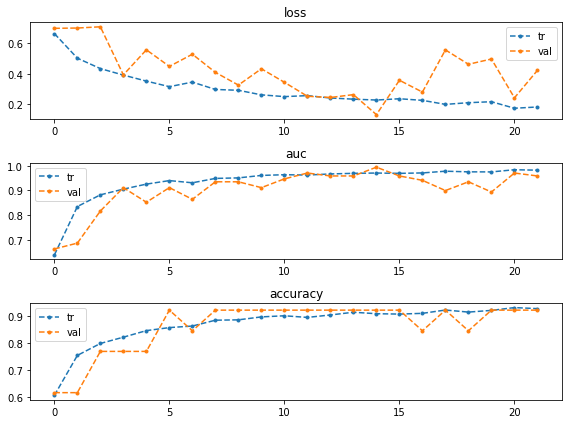

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.

 fold: 5/7, seed: 0/1 


 Train [ 0  1  2  3  5  6  7  8  9 10 13 15 16 17 18 20 21 22 23 24 25 26 27 28
 29 30 31 32 33 34 35 36 37 38 39 41 42 43 44 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67 69 70 71 72 73 74 75 76 77 79 80
 82 83 84 86 87 88 89] 
 Valid [ 4 11 12 14 19 40 45 68 78 81 85 90 91] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.4810 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6925 - accuracy: 0.5253 - auc: 0.5491

 3/46 [>.............................] - ETA: 15s - loss: 0.7279 - accuracy: 0.5401 - auc: 0.5616

 4/46 [=>............................] - ETA: 16s - loss: 0.7179 - accuracy: 0.5475 - auc: 0.5674

 5/46 [==>...........................] - ETA: 17s - loss: 0.7118 - accuracy: 0.5519 - auc: 0.5698

 6/46 [==>...........................] - ETA: 17s - loss: 0.7073 - accuracy: 0.5549 - auc: 0.5703

 7/46 [===>..........................] - ETA: 17s - loss: 0.7044 - accuracy: 0.5570 - auc: 0.5691

 8/46 [====>.........................] - ETA: 17s - loss: 0.7027 - accuracy: 0.5570 - auc: 0.5684

 9/46 [====>.........................] - ETA: 17s - loss: 0.6995 - accuracy: 0.5626 - auc: 0.5769

10/46 [=====>........................] - ETA: 17s - loss: 0.7028 - accuracy: 0.5620 - auc: 0.5690

11/46 [======>.......................] - ETA: 16s - loss: 0.7007 - accuracy: 0.5616 - auc: 0.5709

12/46 [======>.......................] - ETA: 16s - loss: 0.7005 - accuracy: 0.5580 - auc: 0.5675

13/46 [=======>......................] - ETA: 16s - loss: 0.6995 - accuracy: 0.5599 - auc: 0.5688

14/46 [========>.....................] - ETA: 15s - loss: 0.6978 - accuracy: 0.5606 - auc: 0.5704

15/46 [========>.....................] - ETA: 15s - loss: 0.6962 - accuracy: 0.5612 - auc: 0.5735

16/46 [=========>....................] - ETA: 14s - loss: 0.6953 - accuracy: 0.5601 - auc: 0.5749

17/46 [==========>...................] - ETA: 14s - loss: 0.6938 - accuracy: 0.5607 - auc: 0.5778

18/46 [==========>...................] - ETA: 14s - loss: 0.6937 - accuracy: 0.5605 - auc: 0.5772

19/46 [===========>..................] - ETA: 13s - loss: 0.6923 - accuracy: 0.5630 - auc: 0.5805

20/46 [============>.................] - ETA: 13s - loss: 0.6915 - accuracy: 0.5627 - auc: 0.5822

21/46 [============>.................] - ETA: 12s - loss: 0.6901 - accuracy: 0.5654 - auc: 0.5859

22/46 [=============>................] - ETA: 12s - loss: 0.6902 - accuracy: 0.5644 - auc: 0.5843

23/46 [==============>...............] - ETA: 11s - loss: 0.6891 - accuracy: 0.5652 - auc: 0.5864

24/46 [==============>...............] - ETA: 11s - loss: 0.6884 - accuracy: 0.5643 - auc: 0.5875

25/46 [===============>..............] - ETA: 10s - loss: 0.6878 - accuracy: 0.5646 - auc: 0.5874

26/46 [===============>..............] - ETA: 10s - loss: 0.6866 - accuracy: 0.5638 - auc: 0.5888

27/46 [================>.............] - ETA: 9s - loss: 0.6856 - accuracy: 0.5663 - auc: 0.5915 

28/46 [=================>............] - ETA: 9s - loss: 0.6854 - accuracy: 0.5665 - auc: 0.5911

29/46 [=================>............] - ETA: 8s - loss: 0.6839 - accuracy: 0.5701 - auc: 0.5961

30/46 [==================>...........] - ETA: 8s - loss: 0.6828 - accuracy: 0.5696 - auc: 0.5977

31/46 [===================>..........] - ETA: 7s - loss: 0.6822 - accuracy: 0.5717 - auc: 0.5987

32/46 [===================>..........] - ETA: 7s - loss: 0.6815 - accuracy: 0.5716 - auc: 0.6001

33/46 [====================>.........] - ETA: 6s - loss: 0.6796 - accuracy: 0.5735 - auc: 0.6044

34/46 [=====================>........] - ETA: 6s - loss: 0.6788 - accuracy: 0.5748 - auc: 0.6059

35/46 [=====================>........] - ETA: 5s - loss: 0.6774 - accuracy: 0.5776 - auc: 0.6092

36/46 [======================>.......] - ETA: 5s - loss: 0.6746 - accuracy: 0.5798 - auc: 0.6139

37/46 [=======================>......] - ETA: 4s - loss: 0.6755 - accuracy: 0.5789 - auc: 0.6121

38/46 [=======================>......] - ETA: 4s - loss: 0.6749 - accuracy: 0.5796 - auc: 0.6136

39/46 [========================>.....] - ETA: 3s - loss: 0.6741 - accuracy: 0.5810 - auc: 0.6151

40/46 [=========================>....] - ETA: 3s - loss: 0.6724 - accuracy: 0.5829 - auc: 0.6181

41/46 [=========================>....] - ETA: 2s - loss: 0.6712 - accuracy: 0.5841 - auc: 0.6199

42/46 [==========================>...] - ETA: 2s - loss: 0.6692 - accuracy: 0.5886 - auc: 0.6248

43/46 [===========================>..] - ETA: 1s - loss: 0.6688 - accuracy: 0.5890 - auc: 0.6260

44/46 [===========================>..] - ETA: 1s - loss: 0.6670 - accuracy: 0.5909 - auc: 0.6295

45/46 [============================>.] - ETA: 0s - loss: 0.6666 - accuracy: 0.5910 - auc: 0.6303

46/46 [==============================] - ETA: 0s - loss: 0.6646 - accuracy: 0.5925 - auc: 0.6332

Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.52606, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 553ms/step - loss: 0.6646 - accuracy: 0.5925 - auc: 0.6332 - val_loss: 0.5261 - val_accuracy: 0.8462 - val_auc: 0.8225


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.6565 - accuracy: 0.6076 - auc: 0.6606

 2/46 [>.............................] - ETA: 11s - loss: 0.6285 - accuracy: 0.6582 - auc: 0.6929

 3/46 [>.............................] - ETA: 15s - loss: 0.6146 - accuracy: 0.6624 - auc: 0.7173

 4/46 [=>............................] - ETA: 16s - loss: 0.6005 - accuracy: 0.6709 - auc: 0.7349

 5/46 [==>...........................] - ETA: 17s - loss: 0.5896 - accuracy: 0.6785 - auc: 0.7468

 6/46 [==>...........................] - ETA: 17s - loss: 0.5733 - accuracy: 0.6920 - auc: 0.7658

 7/46 [===>..........................] - ETA: 17s - loss: 0.5596 - accuracy: 0.7052 - auc: 0.7823

 8/46 [====>.........................] - ETA: 17s - loss: 0.5468 - accuracy: 0.7073 - auc: 0.7927

 9/46 [====>.........................] - ETA: 17s - loss: 0.5499 - accuracy: 0.7075 - auc: 0.7887

10/46 [=====>........................] - ETA: 17s - loss: 0.5418 - accuracy: 0.7127 - auc: 0.7955

11/46 [======>.......................] - ETA: 16s - loss: 0.5445 - accuracy: 0.7169 - auc: 0.7958

12/46 [======>.......................] - ETA: 16s - loss: 0.5547 - accuracy: 0.7089 - auc: 0.7876

13/46 [=======>......................] - ETA: 16s - loss: 0.5597 - accuracy: 0.7069 - auc: 0.7835

14/46 [========>.....................] - ETA: 15s - loss: 0.5557 - accuracy: 0.7107 - auc: 0.7872

15/46 [========>.....................] - ETA: 15s - loss: 0.5545 - accuracy: 0.7114 - auc: 0.7891

16/46 [=========>....................] - ETA: 15s - loss: 0.5508 - accuracy: 0.7152 - auc: 0.7930

17/46 [==========>...................] - ETA: 14s - loss: 0.5504 - accuracy: 0.7156 - auc: 0.7939

18/46 [==========>...................] - ETA: 14s - loss: 0.5486 - accuracy: 0.7180 - auc: 0.7954

19/46 [===========>..................] - ETA: 13s - loss: 0.5453 - accuracy: 0.7189 - auc: 0.7980

20/46 [============>.................] - ETA: 13s - loss: 0.5469 - accuracy: 0.7152 - auc: 0.7955

21/46 [============>.................] - ETA: 12s - loss: 0.5445 - accuracy: 0.7197 - auc: 0.7983

22/46 [=============>................] - ETA: 12s - loss: 0.5413 - accuracy: 0.7221 - auc: 0.8016

23/46 [==============>...............] - ETA: 11s - loss: 0.5352 - accuracy: 0.7265 - auc: 0.8069

24/46 [==============>...............] - ETA: 11s - loss: 0.5356 - accuracy: 0.7257 - auc: 0.8060

25/46 [===============>..............] - ETA: 10s - loss: 0.5285 - accuracy: 0.7301 - auc: 0.8120

26/46 [===============>..............] - ETA: 10s - loss: 0.5240 - accuracy: 0.7303 - auc: 0.8146

27/46 [================>.............] - ETA: 9s - loss: 0.5214 - accuracy: 0.7332 - auc: 0.8175 

28/46 [=================>............] - ETA: 9s - loss: 0.5195 - accuracy: 0.7355 - auc: 0.8193

29/46 [=================>............] - ETA: 8s - loss: 0.5170 - accuracy: 0.7364 - auc: 0.8212

30/46 [==================>...........] - ETA: 8s - loss: 0.5157 - accuracy: 0.7359 - auc: 0.8216

31/46 [===================>..........] - ETA: 7s - loss: 0.5176 - accuracy: 0.7366 - auc: 0.8213

32/46 [===================>..........] - ETA: 7s - loss: 0.5136 - accuracy: 0.7389 - auc: 0.8247

33/46 [====================>.........] - ETA: 6s - loss: 0.5138 - accuracy: 0.7392 - auc: 0.8244

34/46 [=====================>........] - ETA: 6s - loss: 0.5143 - accuracy: 0.7398 - auc: 0.8242

35/46 [=====================>........] - ETA: 5s - loss: 0.5127 - accuracy: 0.7418 - auc: 0.8260

36/46 [======================>.......] - ETA: 5s - loss: 0.5107 - accuracy: 0.7430 - auc: 0.8277

37/46 [=======================>......] - ETA: 4s - loss: 0.5094 - accuracy: 0.7438 - auc: 0.8286

38/46 [=======================>......] - ETA: 4s - loss: 0.5083 - accuracy: 0.7438 - auc: 0.8293

39/46 [========================>.....] - ETA: 3s - loss: 0.5101 - accuracy: 0.7423 - auc: 0.8278

40/46 [=========================>....] - ETA: 3s - loss: 0.5085 - accuracy: 0.7421 - auc: 0.8287

41/46 [=========================>....] - ETA: 2s - loss: 0.5071 - accuracy: 0.7434 - auc: 0.8299

42/46 [==========================>...] - ETA: 2s - loss: 0.5066 - accuracy: 0.7438 - auc: 0.8304

43/46 [===========================>..] - ETA: 1s - loss: 0.5058 - accuracy: 0.7436 - auc: 0.8309

44/46 [===========================>..] - ETA: 1s - loss: 0.5036 - accuracy: 0.7440 - auc: 0.8322

45/46 [============================>.] - ETA: 0s - loss: 0.5043 - accuracy: 0.7440 - auc: 0.8319

46/46 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7449 - auc: 0.8334

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss did not improve from 0.52606
46/46 [==============================] - 24s 525ms/step - loss: 0.5019 - accuracy: 0.7449 - auc: 0.8334 - val_loss: 0.5672 - val_accuracy: 0.7692 - val_auc: 0.7840


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.4197 - accuracy: 0.8101 - auc: 0.8890

 2/46 [>.............................] - ETA: 18s - loss: 0.5088 - accuracy: 0.7722 - auc: 0.8478

 3/46 [>.............................] - ETA: 24s - loss: 0.5210 - accuracy: 0.7553 - auc: 0.8310

 4/46 [=>............................] - ETA: 23s - loss: 0.5089 - accuracy: 0.7595 - auc: 0.8369

 5/46 [==>...........................] - ETA: 22s - loss: 0.4971 - accuracy: 0.7544 - auc: 0.8416

 6/46 [==>...........................] - ETA: 22s - loss: 0.4764 - accuracy: 0.7658 - auc: 0.8555

 7/46 [===>..........................] - ETA: 21s - loss: 0.4678 - accuracy: 0.7685 - auc: 0.8594

 8/46 [====>.........................] - ETA: 20s - loss: 0.4674 - accuracy: 0.7737 - auc: 0.8597

 9/46 [====>.........................] - ETA: 20s - loss: 0.4644 - accuracy: 0.7736 - auc: 0.8618

10/46 [=====>........................] - ETA: 19s - loss: 0.4547 - accuracy: 0.7759 - auc: 0.8682

11/46 [======>.......................] - ETA: 19s - loss: 0.4593 - accuracy: 0.7756 - auc: 0.8664

12/46 [======>.......................] - ETA: 18s - loss: 0.4516 - accuracy: 0.7785 - auc: 0.8708

13/46 [=======>......................] - ETA: 17s - loss: 0.4519 - accuracy: 0.7799 - auc: 0.8706

14/46 [========>.....................] - ETA: 17s - loss: 0.4538 - accuracy: 0.7821 - auc: 0.8712

15/46 [========>.....................] - ETA: 16s - loss: 0.4523 - accuracy: 0.7848 - auc: 0.8733

16/46 [=========>....................] - ETA: 16s - loss: 0.4478 - accuracy: 0.7864 - auc: 0.8764

17/46 [==========>...................] - ETA: 15s - loss: 0.4526 - accuracy: 0.7841 - auc: 0.8730

18/46 [==========>...................] - ETA: 15s - loss: 0.4511 - accuracy: 0.7855 - auc: 0.8735

19/46 [===========>..................] - ETA: 14s - loss: 0.4558 - accuracy: 0.7821 - auc: 0.8703

20/46 [============>.................] - ETA: 14s - loss: 0.4572 - accuracy: 0.7804 - auc: 0.8690

21/46 [============>.................] - ETA: 13s - loss: 0.4586 - accuracy: 0.7824 - auc: 0.8685

22/46 [=============>................] - ETA: 12s - loss: 0.4614 - accuracy: 0.7808 - auc: 0.8665

23/46 [==============>...............] - ETA: 12s - loss: 0.4629 - accuracy: 0.7832 - auc: 0.8665

24/46 [==============>...............] - ETA: 11s - loss: 0.4635 - accuracy: 0.7806 - auc: 0.8657

25/46 [===============>..............] - ETA: 11s - loss: 0.4627 - accuracy: 0.7818 - auc: 0.8664

26/46 [===============>..............] - ETA: 10s - loss: 0.4608 - accuracy: 0.7814 - auc: 0.8674

27/46 [================>.............] - ETA: 10s - loss: 0.4583 - accuracy: 0.7853 - auc: 0.8692

28/46 [=================>............] - ETA: 9s - loss: 0.4581 - accuracy: 0.7866 - auc: 0.8698 

29/46 [=================>............] - ETA: 9s - loss: 0.4551 - accuracy: 0.7896 - auc: 0.8720

30/46 [==================>...........] - ETA: 8s - loss: 0.4541 - accuracy: 0.7911 - auc: 0.8731

31/46 [===================>..........] - ETA: 8s - loss: 0.4555 - accuracy: 0.7901 - auc: 0.8722

32/46 [===================>..........] - ETA: 7s - loss: 0.4530 - accuracy: 0.7927 - auc: 0.8742

33/46 [====================>.........] - ETA: 6s - loss: 0.4571 - accuracy: 0.7909 - auc: 0.8722

34/46 [=====================>........] - ETA: 6s - loss: 0.4569 - accuracy: 0.7930 - auc: 0.8728

35/46 [=====================>........] - ETA: 5s - loss: 0.4539 - accuracy: 0.7935 - auc: 0.8742

36/46 [======================>.......] - ETA: 5s - loss: 0.4541 - accuracy: 0.7940 - auc: 0.8742

37/46 [=======================>......] - ETA: 4s - loss: 0.4518 - accuracy: 0.7951 - auc: 0.8751

38/46 [=======================>......] - ETA: 4s - loss: 0.4527 - accuracy: 0.7941 - auc: 0.8748

39/46 [========================>.....] - ETA: 3s - loss: 0.4498 - accuracy: 0.7955 - auc: 0.8763

40/46 [=========================>....] - ETA: 3s - loss: 0.4482 - accuracy: 0.7959 - auc: 0.8772

41/46 [=========================>....] - ETA: 2s - loss: 0.4473 - accuracy: 0.7969 - auc: 0.8775

42/46 [==========================>...] - ETA: 2s - loss: 0.4449 - accuracy: 0.7987 - auc: 0.8790

43/46 [===========================>..] - ETA: 1s - loss: 0.4430 - accuracy: 0.7989 - auc: 0.8798

44/46 [===========================>..] - ETA: 1s - loss: 0.4411 - accuracy: 0.8001 - auc: 0.8809

45/46 [============================>.] - ETA: 0s - loss: 0.4403 - accuracy: 0.8008 - auc: 0.8812

46/46 [==============================] - ETA: 0s - loss: 0.4393 - accuracy: 0.8019 - auc: 0.8820

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss improved from 0.52606 to 0.29642, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 544ms/step - loss: 0.4393 - accuracy: 0.8019 - auc: 0.8820 - val_loss: 0.2964 - val_accuracy: 0.9231 - val_auc: 0.9586


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3991 - accuracy: 0.8481 - auc: 0.9047

 2/46 [>.............................] - ETA: 11s - loss: 0.3880 - accuracy: 0.8354 - auc: 0.9079

 3/46 [>.............................] - ETA: 14s - loss: 0.3710 - accuracy: 0.8397 - auc: 0.9161

 4/46 [=>............................] - ETA: 16s - loss: 0.3770 - accuracy: 0.8323 - auc: 0.9108

 5/46 [==>...........................] - ETA: 17s - loss: 0.3662 - accuracy: 0.8329 - auc: 0.9160

 6/46 [==>...........................] - ETA: 17s - loss: 0.3848 - accuracy: 0.8333 - auc: 0.9076

 7/46 [===>..........................] - ETA: 17s - loss: 0.3782 - accuracy: 0.8373 - auc: 0.9112

 8/46 [====>.........................] - ETA: 17s - loss: 0.3661 - accuracy: 0.8465 - auc: 0.9172

 9/46 [====>.........................] - ETA: 17s - loss: 0.3619 - accuracy: 0.8425 - auc: 0.9192

10/46 [=====>........................] - ETA: 17s - loss: 0.3665 - accuracy: 0.8367 - auc: 0.9164

11/46 [======>.......................] - ETA: 16s - loss: 0.3668 - accuracy: 0.8389 - auc: 0.9167

12/46 [======>.......................] - ETA: 16s - loss: 0.3745 - accuracy: 0.8376 - auc: 0.9139

13/46 [=======>......................] - ETA: 15s - loss: 0.3790 - accuracy: 0.8374 - auc: 0.9116

14/46 [========>.....................] - ETA: 16s - loss: 0.3714 - accuracy: 0.8409 - auc: 0.9154

15/46 [========>.....................] - ETA: 16s - loss: 0.3654 - accuracy: 0.8439 - auc: 0.9184

16/46 [=========>....................] - ETA: 15s - loss: 0.3618 - accuracy: 0.8465 - auc: 0.9201

17/46 [==========>...................] - ETA: 15s - loss: 0.3600 - accuracy: 0.8451 - auc: 0.9208

18/46 [==========>...................] - ETA: 14s - loss: 0.3570 - accuracy: 0.8474 - auc: 0.9222

19/46 [===========>..................] - ETA: 14s - loss: 0.3559 - accuracy: 0.8488 - auc: 0.9230

20/46 [============>.................] - ETA: 13s - loss: 0.3548 - accuracy: 0.8494 - auc: 0.9235

21/46 [============>.................] - ETA: 13s - loss: 0.3538 - accuracy: 0.8487 - auc: 0.9238

22/46 [=============>................] - ETA: 12s - loss: 0.3534 - accuracy: 0.8481 - auc: 0.9239

23/46 [==============>...............] - ETA: 12s - loss: 0.3535 - accuracy: 0.8470 - auc: 0.9237

24/46 [==============>...............] - ETA: 11s - loss: 0.3546 - accuracy: 0.8470 - auc: 0.9234

25/46 [===============>..............] - ETA: 11s - loss: 0.3510 - accuracy: 0.8501 - auc: 0.9250

26/46 [===============>..............] - ETA: 10s - loss: 0.3517 - accuracy: 0.8496 - auc: 0.9247

27/46 [================>.............] - ETA: 10s - loss: 0.3502 - accuracy: 0.8504 - auc: 0.9254

28/46 [=================>............] - ETA: 9s - loss: 0.3495 - accuracy: 0.8504 - auc: 0.9257 

29/46 [=================>............] - ETA: 8s - loss: 0.3475 - accuracy: 0.8507 - auc: 0.9265

30/46 [==================>...........] - ETA: 8s - loss: 0.3464 - accuracy: 0.8511 - auc: 0.9269

31/46 [===================>..........] - ETA: 7s - loss: 0.3462 - accuracy: 0.8526 - auc: 0.9273

32/46 [===================>..........] - ETA: 7s - loss: 0.3426 - accuracy: 0.8540 - auc: 0.9288

33/46 [====================>.........] - ETA: 6s - loss: 0.3406 - accuracy: 0.8550 - auc: 0.9297

34/46 [=====================>........] - ETA: 6s - loss: 0.3392 - accuracy: 0.8563 - auc: 0.9305

35/46 [=====================>........] - ETA: 5s - loss: 0.3392 - accuracy: 0.8561 - auc: 0.9305

36/46 [======================>.......] - ETA: 5s - loss: 0.3363 - accuracy: 0.8572 - auc: 0.9317

37/46 [=======================>......] - ETA: 4s - loss: 0.3326 - accuracy: 0.8597 - auc: 0.9333

38/46 [=======================>......] - ETA: 4s - loss: 0.3352 - accuracy: 0.8594 - auc: 0.9326

39/46 [========================>.....] - ETA: 3s - loss: 0.3328 - accuracy: 0.8604 - auc: 0.9335

40/46 [=========================>....] - ETA: 3s - loss: 0.3315 - accuracy: 0.8608 - auc: 0.9340

41/46 [=========================>....] - ETA: 2s - loss: 0.3324 - accuracy: 0.8611 - auc: 0.9338

42/46 [==========================>...] - ETA: 2s - loss: 0.3316 - accuracy: 0.8611 - auc: 0.9342

43/46 [===========================>..] - ETA: 1s - loss: 0.3313 - accuracy: 0.8613 - auc: 0.9343

44/46 [===========================>..] - ETA: 1s - loss: 0.3303 - accuracy: 0.8619 - auc: 0.9347

45/46 [============================>.] - ETA: 0s - loss: 0.3301 - accuracy: 0.8624 - auc: 0.9348

46/46 [==============================] - ETA: 0s - loss: 0.3306 - accuracy: 0.8616 - auc: 0.9346

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss improved from 0.29642 to 0.28358, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 535ms/step - loss: 0.3306 - accuracy: 0.8616 - auc: 0.9346 - val_loss: 0.2836 - val_accuracy: 0.8462 - val_auc: 0.9467


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.3933 - accuracy: 0.7975 - auc: 0.9116

 2/46 [>.............................] - ETA: 11s - loss: 0.3733 - accuracy: 0.7975 - auc: 0.9163

 3/46 [>.............................] - ETA: 14s - loss: 0.3533 - accuracy: 0.8017 - auc: 0.9228

 4/46 [=>............................] - ETA: 16s - loss: 0.3779 - accuracy: 0.7911 - auc: 0.9115

 5/46 [==>...........................] - ETA: 16s - loss: 0.3685 - accuracy: 0.8051 - auc: 0.9152

 6/46 [==>...........................] - ETA: 17s - loss: 0.3601 - accuracy: 0.8122 - auc: 0.9196

 7/46 [===>..........................] - ETA: 17s - loss: 0.3538 - accuracy: 0.8192 - auc: 0.9229

 8/46 [====>.........................] - ETA: 17s - loss: 0.3520 - accuracy: 0.8212 - auc: 0.9231

 9/46 [====>.........................] - ETA: 17s - loss: 0.3431 - accuracy: 0.8242 - auc: 0.9268

10/46 [=====>........................] - ETA: 16s - loss: 0.3400 - accuracy: 0.8329 - auc: 0.9290

11/46 [======>.......................] - ETA: 16s - loss: 0.3423 - accuracy: 0.8274 - auc: 0.9275

12/46 [======>.......................] - ETA: 16s - loss: 0.3434 - accuracy: 0.8312 - auc: 0.9272

13/46 [=======>......................] - ETA: 15s - loss: 0.3422 - accuracy: 0.8345 - auc: 0.9277

14/46 [========>.....................] - ETA: 15s - loss: 0.3347 - accuracy: 0.8409 - auc: 0.9312

15/46 [========>.....................] - ETA: 15s - loss: 0.3303 - accuracy: 0.8447 - auc: 0.9333

16/46 [=========>....................] - ETA: 14s - loss: 0.3215 - accuracy: 0.8513 - auc: 0.9371

17/46 [==========>...................] - ETA: 14s - loss: 0.3271 - accuracy: 0.8496 - auc: 0.9356

18/46 [==========>...................] - ETA: 13s - loss: 0.3254 - accuracy: 0.8509 - auc: 0.9361

19/46 [===========>..................] - ETA: 13s - loss: 0.3292 - accuracy: 0.8521 - auc: 0.9350

20/46 [============>.................] - ETA: 12s - loss: 0.3270 - accuracy: 0.8519 - auc: 0.9358

21/46 [============>.................] - ETA: 12s - loss: 0.3267 - accuracy: 0.8523 - auc: 0.9359

22/46 [=============>................] - ETA: 11s - loss: 0.3277 - accuracy: 0.8516 - auc: 0.9353

23/46 [==============>...............] - ETA: 11s - loss: 0.3310 - accuracy: 0.8492 - auc: 0.9338

24/46 [==============>...............] - ETA: 11s - loss: 0.3312 - accuracy: 0.8492 - auc: 0.9338

25/46 [===============>..............] - ETA: 10s - loss: 0.3279 - accuracy: 0.8511 - auc: 0.9352

26/46 [===============>..............] - ETA: 10s - loss: 0.3283 - accuracy: 0.8539 - auc: 0.9352

27/46 [================>.............] - ETA: 9s - loss: 0.3273 - accuracy: 0.8547 - auc: 0.9356 

28/46 [=================>............] - ETA: 9s - loss: 0.3251 - accuracy: 0.8544 - auc: 0.9365

29/46 [=================>............] - ETA: 8s - loss: 0.3226 - accuracy: 0.8568 - auc: 0.9377

30/46 [==================>...........] - ETA: 8s - loss: 0.3210 - accuracy: 0.8582 - auc: 0.9383

31/46 [===================>..........] - ETA: 7s - loss: 0.3196 - accuracy: 0.8595 - auc: 0.9388

32/46 [===================>..........] - ETA: 7s - loss: 0.3165 - accuracy: 0.8616 - auc: 0.9400

33/46 [====================>.........] - ETA: 6s - loss: 0.3165 - accuracy: 0.8623 - auc: 0.9401

34/46 [=====================>........] - ETA: 6s - loss: 0.3147 - accuracy: 0.8637 - auc: 0.9407

35/46 [=====================>........] - ETA: 5s - loss: 0.3156 - accuracy: 0.8633 - auc: 0.9403

36/46 [======================>.......] - ETA: 5s - loss: 0.3190 - accuracy: 0.8615 - auc: 0.9391

37/46 [=======================>......] - ETA: 4s - loss: 0.3171 - accuracy: 0.8625 - auc: 0.9398

38/46 [=======================>......] - ETA: 4s - loss: 0.3187 - accuracy: 0.8621 - auc: 0.9393

39/46 [========================>.....] - ETA: 3s - loss: 0.3168 - accuracy: 0.8627 - auc: 0.9400

40/46 [=========================>....] - ETA: 3s - loss: 0.3160 - accuracy: 0.8639 - auc: 0.9403

41/46 [=========================>....] - ETA: 2s - loss: 0.3148 - accuracy: 0.8642 - auc: 0.9407

42/46 [==========================>...] - ETA: 2s - loss: 0.3173 - accuracy: 0.8635 - auc: 0.9400

43/46 [===========================>..] - ETA: 1s - loss: 0.3170 - accuracy: 0.8643 - auc: 0.9402

44/46 [===========================>..] - ETA: 1s - loss: 0.3155 - accuracy: 0.8657 - auc: 0.9408

45/46 [============================>.] - ETA: 0s - loss: 0.3146 - accuracy: 0.8667 - auc: 0.9411

46/46 [==============================] - ETA: 0s - loss: 0.3130 - accuracy: 0.8674 - auc: 0.9418

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss improved from 0.28358 to 0.22548, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 536ms/step - loss: 0.3130 - accuracy: 0.8674 - auc: 0.9418 - val_loss: 0.2255 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2730 - accuracy: 0.9114 - auc: 0.9592

 2/46 [>.............................] - ETA: 11s - loss: 0.3071 - accuracy: 0.8797 - auc: 0.9440

 3/46 [>.............................] - ETA: 15s - loss: 0.3306 - accuracy: 0.8692 - auc: 0.9398

 4/46 [=>............................] - ETA: 17s - loss: 0.3138 - accuracy: 0.8703 - auc: 0.9449

 5/46 [==>...........................] - ETA: 17s - loss: 0.3040 - accuracy: 0.8759 - auc: 0.9477

 6/46 [==>...........................] - ETA: 17s - loss: 0.2979 - accuracy: 0.8819 - auc: 0.9497

 7/46 [===>..........................] - ETA: 17s - loss: 0.2938 - accuracy: 0.8843 - auc: 0.9503

 8/46 [====>.........................] - ETA: 17s - loss: 0.2919 - accuracy: 0.8813 - auc: 0.9507

 9/46 [====>.........................] - ETA: 17s - loss: 0.2865 - accuracy: 0.8790 - auc: 0.9523

10/46 [=====>........................] - ETA: 17s - loss: 0.2926 - accuracy: 0.8785 - auc: 0.9509

11/46 [======>.......................] - ETA: 17s - loss: 0.2920 - accuracy: 0.8803 - auc: 0.9509

12/46 [======>.......................] - ETA: 16s - loss: 0.2889 - accuracy: 0.8819 - auc: 0.9518

13/46 [=======>......................] - ETA: 16s - loss: 0.2857 - accuracy: 0.8851 - auc: 0.9528

14/46 [========>.....................] - ETA: 15s - loss: 0.2866 - accuracy: 0.8834 - auc: 0.9524

15/46 [========>.....................] - ETA: 15s - loss: 0.2844 - accuracy: 0.8844 - auc: 0.9531

16/46 [=========>....................] - ETA: 15s - loss: 0.2814 - accuracy: 0.8837 - auc: 0.9540

17/46 [==========>...................] - ETA: 14s - loss: 0.2820 - accuracy: 0.8853 - auc: 0.9540

18/46 [==========>...................] - ETA: 14s - loss: 0.2824 - accuracy: 0.8847 - auc: 0.9540

19/46 [===========>..................] - ETA: 13s - loss: 0.2778 - accuracy: 0.8874 - auc: 0.9555

20/46 [============>.................] - ETA: 13s - loss: 0.2760 - accuracy: 0.8886 - auc: 0.9559

21/46 [============>.................] - ETA: 13s - loss: 0.2764 - accuracy: 0.8867 - auc: 0.9556

22/46 [=============>................] - ETA: 12s - loss: 0.2754 - accuracy: 0.8878 - auc: 0.9559

23/46 [==============>...............] - ETA: 11s - loss: 0.2755 - accuracy: 0.8877 - auc: 0.9558

24/46 [==============>...............] - ETA: 11s - loss: 0.2751 - accuracy: 0.8877 - auc: 0.9559

25/46 [===============>..............] - ETA: 10s - loss: 0.2745 - accuracy: 0.8891 - auc: 0.9561

26/46 [===============>..............] - ETA: 10s - loss: 0.2744 - accuracy: 0.8890 - auc: 0.9561

27/46 [================>.............] - ETA: 9s - loss: 0.2728 - accuracy: 0.8908 - auc: 0.9566 

28/46 [=================>............] - ETA: 9s - loss: 0.2721 - accuracy: 0.8906 - auc: 0.9568

29/46 [=================>............] - ETA: 8s - loss: 0.2707 - accuracy: 0.8900 - auc: 0.9572

30/46 [==================>...........] - ETA: 8s - loss: 0.2669 - accuracy: 0.8924 - auc: 0.9585

31/46 [===================>..........] - ETA: 7s - loss: 0.2665 - accuracy: 0.8926 - auc: 0.9586

32/46 [===================>..........] - ETA: 7s - loss: 0.2638 - accuracy: 0.8940 - auc: 0.9594

33/46 [====================>.........] - ETA: 6s - loss: 0.2625 - accuracy: 0.8941 - auc: 0.9598

34/46 [=====================>........] - ETA: 6s - loss: 0.2619 - accuracy: 0.8943 - auc: 0.9599

35/46 [=====================>........] - ETA: 5s - loss: 0.2634 - accuracy: 0.8940 - auc: 0.9595

36/46 [======================>.......] - ETA: 5s - loss: 0.2624 - accuracy: 0.8945 - auc: 0.9597

37/46 [=======================>......] - ETA: 4s - loss: 0.2629 - accuracy: 0.8950 - auc: 0.9595

38/46 [=======================>......] - ETA: 4s - loss: 0.2611 - accuracy: 0.8951 - auc: 0.9601

39/46 [========================>.....] - ETA: 3s - loss: 0.2577 - accuracy: 0.8961 - auc: 0.9611

40/46 [=========================>....] - ETA: 3s - loss: 0.2580 - accuracy: 0.8962 - auc: 0.9610

41/46 [=========================>....] - ETA: 2s - loss: 0.2562 - accuracy: 0.8969 - auc: 0.9615

42/46 [==========================>...] - ETA: 2s - loss: 0.2549 - accuracy: 0.8975 - auc: 0.9619

43/46 [===========================>..] - ETA: 1s - loss: 0.2555 - accuracy: 0.8981 - auc: 0.9617

44/46 [===========================>..] - ETA: 1s - loss: 0.2565 - accuracy: 0.8976 - auc: 0.9614

45/46 [============================>.] - ETA: 0s - loss: 0.2577 - accuracy: 0.8979 - auc: 0.9611

46/46 [==============================] - ETA: 0s - loss: 0.2567 - accuracy: 0.8982 - auc: 0.9614

Found 13 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss improved from 0.22548 to 0.17483, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 546ms/step - loss: 0.2567 - accuracy: 0.8982 - auc: 0.9614 - val_loss: 0.1748 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.2522 - accuracy: 0.8987 - auc: 0.9598

 2/46 [>.............................] - ETA: 11s - loss: 0.2733 - accuracy: 0.8924 - auc: 0.9552

 3/46 [>.............................] - ETA: 15s - loss: 0.2586 - accuracy: 0.9030 - auc: 0.9623

 4/46 [=>............................] - ETA: 16s - loss: 0.2532 - accuracy: 0.9019 - auc: 0.9635

 5/46 [==>...........................] - ETA: 17s - loss: 0.2674 - accuracy: 0.8937 - auc: 0.9578

 6/46 [==>...........................] - ETA: 17s - loss: 0.2868 - accuracy: 0.8861 - auc: 0.9526

 7/46 [===>..........................] - ETA: 17s - loss: 0.2875 - accuracy: 0.8879 - auc: 0.9520

 8/46 [====>.........................] - ETA: 17s - loss: 0.2799 - accuracy: 0.8877 - auc: 0.9543

 9/46 [====>.........................] - ETA: 17s - loss: 0.2803 - accuracy: 0.8889 - auc: 0.9542

10/46 [=====>........................] - ETA: 17s - loss: 0.2725 - accuracy: 0.8911 - auc: 0.9568

11/46 [======>.......................] - ETA: 16s - loss: 0.2850 - accuracy: 0.8895 - auc: 0.9526

12/46 [======>.......................] - ETA: 16s - loss: 0.2755 - accuracy: 0.8903 - auc: 0.9558

13/46 [=======>......................] - ETA: 16s - loss: 0.2757 - accuracy: 0.8900 - auc: 0.9556

14/46 [========>.....................] - ETA: 15s - loss: 0.2797 - accuracy: 0.8906 - auc: 0.9544

15/46 [========>.....................] - ETA: 15s - loss: 0.2826 - accuracy: 0.8869 - auc: 0.9533

16/46 [=========>....................] - ETA: 15s - loss: 0.2839 - accuracy: 0.8869 - auc: 0.9529

17/46 [==========>...................] - ETA: 14s - loss: 0.2839 - accuracy: 0.8868 - auc: 0.9528

18/46 [==========>...................] - ETA: 14s - loss: 0.2801 - accuracy: 0.8882 - auc: 0.9541

19/46 [===========>..................] - ETA: 13s - loss: 0.2781 - accuracy: 0.8881 - auc: 0.9547

20/46 [============>.................] - ETA: 13s - loss: 0.2818 - accuracy: 0.8867 - auc: 0.9536

21/46 [============>.................] - ETA: 12s - loss: 0.2807 - accuracy: 0.8873 - auc: 0.9540

22/46 [=============>................] - ETA: 12s - loss: 0.2775 - accuracy: 0.8890 - auc: 0.9551

23/46 [==============>...............] - ETA: 11s - loss: 0.2748 - accuracy: 0.8910 - auc: 0.9560

24/46 [==============>...............] - ETA: 11s - loss: 0.2714 - accuracy: 0.8919 - auc: 0.9571

25/46 [===============>..............] - ETA: 10s - loss: 0.2720 - accuracy: 0.8927 - auc: 0.9569

26/46 [===============>..............] - ETA: 10s - loss: 0.2686 - accuracy: 0.8944 - auc: 0.9580

27/46 [================>.............] - ETA: 9s - loss: 0.2656 - accuracy: 0.8964 - auc: 0.9589 

28/46 [=================>............] - ETA: 9s - loss: 0.2633 - accuracy: 0.8978 - auc: 0.9598

29/46 [=================>............] - ETA: 8s - loss: 0.2620 - accuracy: 0.8979 - auc: 0.9602

30/46 [==================>...........] - ETA: 8s - loss: 0.2611 - accuracy: 0.8992 - auc: 0.9604

31/46 [===================>..........] - ETA: 7s - loss: 0.2590 - accuracy: 0.9000 - auc: 0.9610

32/46 [===================>..........] - ETA: 7s - loss: 0.2576 - accuracy: 0.8999 - auc: 0.9614

33/46 [====================>.........] - ETA: 6s - loss: 0.2583 - accuracy: 0.9003 - auc: 0.9612

34/46 [=====================>........] - ETA: 6s - loss: 0.2624 - accuracy: 0.8995 - auc: 0.9600

35/46 [=====================>........] - ETA: 5s - loss: 0.2655 - accuracy: 0.8973 - auc: 0.9590

36/46 [======================>.......] - ETA: 5s - loss: 0.2658 - accuracy: 0.8987 - auc: 0.9589

37/46 [=======================>......] - ETA: 4s - loss: 0.2671 - accuracy: 0.8977 - auc: 0.9585

38/46 [=======================>......] - ETA: 4s - loss: 0.2672 - accuracy: 0.8967 - auc: 0.9585

39/46 [========================>.....] - ETA: 3s - loss: 0.2658 - accuracy: 0.8978 - auc: 0.9589

40/46 [=========================>....] - ETA: 3s - loss: 0.2661 - accuracy: 0.8972 - auc: 0.9588

41/46 [=========================>....] - ETA: 2s - loss: 0.2672 - accuracy: 0.8969 - auc: 0.9585

42/46 [==========================>...] - ETA: 2s - loss: 0.2665 - accuracy: 0.8975 - auc: 0.9587

43/46 [===========================>..] - ETA: 1s - loss: 0.2664 - accuracy: 0.8973 - auc: 0.9587

44/46 [===========================>..] - ETA: 1s - loss: 0.2667 - accuracy: 0.8967 - auc: 0.9586

45/46 [============================>.] - ETA: 0s - loss: 0.2667 - accuracy: 0.8973 - auc: 0.9586

46/46 [==============================] - ETA: 0s - loss: 0.2660 - accuracy: 0.8976 - auc: 0.9588

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss did not improve from 0.17483
46/46 [==============================] - 24s 525ms/step - loss: 0.2660 - accuracy: 0.8976 - auc: 0.9588 - val_loss: 0.2046 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.1688 - accuracy: 0.9367 - auc: 0.9871

 2/46 [>.............................] - ETA: 11s - loss: 0.1959 - accuracy: 0.9367 - auc: 0.9782

 3/46 [>.............................] - ETA: 15s - loss: 0.2279 - accuracy: 0.9241 - auc: 0.9690

 4/46 [=>............................] - ETA: 16s - loss: 0.2325 - accuracy: 0.9209 - auc: 0.9687

 5/46 [==>...........................] - ETA: 20s - loss: 0.2175 - accuracy: 0.9266 - auc: 0.9731

 6/46 [==>...........................] - ETA: 22s - loss: 0.2052 - accuracy: 0.9304 - auc: 0.9762

 7/46 [===>..........................] - ETA: 21s - loss: 0.2172 - accuracy: 0.9204 - auc: 0.9725

 8/46 [====>.........................] - ETA: 21s - loss: 0.2220 - accuracy: 0.9161 - auc: 0.9713

 9/46 [====>.........................] - ETA: 20s - loss: 0.2197 - accuracy: 0.9170 - auc: 0.9719

10/46 [=====>........................] - ETA: 19s - loss: 0.2134 - accuracy: 0.9203 - auc: 0.9734

11/46 [======>.......................] - ETA: 19s - loss: 0.2068 - accuracy: 0.9252 - auc: 0.9753

12/46 [======>.......................] - ETA: 18s - loss: 0.2065 - accuracy: 0.9198 - auc: 0.9753

13/46 [=======>......................] - ETA: 18s - loss: 0.2148 - accuracy: 0.9192 - auc: 0.9731

14/46 [========>.....................] - ETA: 17s - loss: 0.2136 - accuracy: 0.9186 - auc: 0.9733

15/46 [========>.....................] - ETA: 16s - loss: 0.2142 - accuracy: 0.9156 - auc: 0.9731

16/46 [=========>....................] - ETA: 16s - loss: 0.2127 - accuracy: 0.9146 - auc: 0.9736

17/46 [==========>...................] - ETA: 15s - loss: 0.2117 - accuracy: 0.9144 - auc: 0.9738

18/46 [==========>...................] - ETA: 15s - loss: 0.2110 - accuracy: 0.9142 - auc: 0.9740

19/46 [===========>..................] - ETA: 14s - loss: 0.2161 - accuracy: 0.9121 - auc: 0.9727

20/46 [============>.................] - ETA: 14s - loss: 0.2177 - accuracy: 0.9127 - auc: 0.9723

21/46 [============>.................] - ETA: 13s - loss: 0.2164 - accuracy: 0.9138 - auc: 0.9726

22/46 [=============>................] - ETA: 13s - loss: 0.2194 - accuracy: 0.9125 - auc: 0.9717

23/46 [==============>...............] - ETA: 12s - loss: 0.2200 - accuracy: 0.9125 - auc: 0.9716

24/46 [==============>...............] - ETA: 11s - loss: 0.2235 - accuracy: 0.9109 - auc: 0.9707

25/46 [===============>..............] - ETA: 11s - loss: 0.2230 - accuracy: 0.9119 - auc: 0.9708

26/46 [===============>..............] - ETA: 10s - loss: 0.2273 - accuracy: 0.9119 - auc: 0.9698

27/46 [================>.............] - ETA: 10s - loss: 0.2279 - accuracy: 0.9114 - auc: 0.9697

28/46 [=================>............] - ETA: 9s - loss: 0.2278 - accuracy: 0.9114 - auc: 0.9697 

29/46 [=================>............] - ETA: 9s - loss: 0.2285 - accuracy: 0.9118 - auc: 0.9696

30/46 [==================>...........] - ETA: 8s - loss: 0.2262 - accuracy: 0.9131 - auc: 0.9702

31/46 [===================>..........] - ETA: 8s - loss: 0.2274 - accuracy: 0.9134 - auc: 0.9699

32/46 [===================>..........] - ETA: 7s - loss: 0.2295 - accuracy: 0.9130 - auc: 0.9694

33/46 [====================>.........] - ETA: 7s - loss: 0.2295 - accuracy: 0.9129 - auc: 0.9693

34/46 [=====================>........] - ETA: 6s - loss: 0.2312 - accuracy: 0.9125 - auc: 0.9688

35/46 [=====================>........] - ETA: 5s - loss: 0.2328 - accuracy: 0.9103 - auc: 0.9684

36/46 [======================>.......] - ETA: 5s - loss: 0.2335 - accuracy: 0.9089 - auc: 0.9682

37/46 [=======================>......] - ETA: 4s - loss: 0.2340 - accuracy: 0.9087 - auc: 0.9681

38/46 [=======================>......] - ETA: 4s - loss: 0.2340 - accuracy: 0.9077 - auc: 0.9681

39/46 [========================>.....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9072 - auc: 0.9676

40/46 [=========================>....] - ETA: 3s - loss: 0.2360 - accuracy: 0.9070 - auc: 0.9676

41/46 [=========================>....] - ETA: 2s - loss: 0.2357 - accuracy: 0.9077 - auc: 0.9677

42/46 [==========================>...] - ETA: 2s - loss: 0.2367 - accuracy: 0.9081 - auc: 0.9675

43/46 [===========================>..] - ETA: 1s - loss: 0.2348 - accuracy: 0.9096 - auc: 0.9680

44/46 [===========================>..] - ETA: 1s - loss: 0.2338 - accuracy: 0.9100 - auc: 0.9683

45/46 [============================>.] - ETA: 0s - loss: 0.2331 - accuracy: 0.9091 - auc: 0.9685

46/46 [==============================] - ETA: 0s - loss: 0.2315 - accuracy: 0.9095 - auc: 0.9689

Found 13 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss improved from 0.17483 to 0.14877, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 548ms/step - loss: 0.2315 - accuracy: 0.9095 - auc: 0.9689 - val_loss: 0.1488 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.1876 - accuracy: 0.9241 - auc: 0.9797

 2/46 [>.............................] - ETA: 11s - loss: 0.2205 - accuracy: 0.9051 - auc: 0.9727

 3/46 [>.............................] - ETA: 15s - loss: 0.2269 - accuracy: 0.9114 - auc: 0.9717

 4/46 [=>............................] - ETA: 16s - loss: 0.2458 - accuracy: 0.9051 - auc: 0.9674

 5/46 [==>...........................] - ETA: 17s - loss: 0.2296 - accuracy: 0.9139 - auc: 0.9709

 6/46 [==>...........................] - ETA: 17s - loss: 0.2292 - accuracy: 0.9177 - auc: 0.9709

 7/46 [===>..........................] - ETA: 17s - loss: 0.2280 - accuracy: 0.9204 - auc: 0.9713

 8/46 [====>.........................] - ETA: 17s - loss: 0.2285 - accuracy: 0.9146 - auc: 0.9708

 9/46 [====>.........................] - ETA: 17s - loss: 0.2309 - accuracy: 0.9142 - auc: 0.9702

10/46 [=====>........................] - ETA: 17s - loss: 0.2349 - accuracy: 0.9114 - auc: 0.9692

11/46 [======>.......................] - ETA: 17s - loss: 0.2280 - accuracy: 0.9160 - auc: 0.9708

12/46 [======>.......................] - ETA: 16s - loss: 0.2303 - accuracy: 0.9146 - auc: 0.9702

13/46 [=======>......................] - ETA: 16s - loss: 0.2366 - accuracy: 0.9114 - auc: 0.9685

14/46 [========>.....................] - ETA: 15s - loss: 0.2380 - accuracy: 0.9096 - auc: 0.9680

15/46 [========>.....................] - ETA: 15s - loss: 0.2389 - accuracy: 0.9080 - auc: 0.9676

16/46 [=========>....................] - ETA: 15s - loss: 0.2374 - accuracy: 0.9090 - auc: 0.9679

17/46 [==========>...................] - ETA: 15s - loss: 0.2362 - accuracy: 0.9106 - auc: 0.9682

18/46 [==========>...................] - ETA: 15s - loss: 0.2364 - accuracy: 0.9100 - auc: 0.9681

19/46 [===========>..................] - ETA: 14s - loss: 0.2343 - accuracy: 0.9094 - auc: 0.9687

20/46 [============>.................] - ETA: 14s - loss: 0.2362 - accuracy: 0.9082 - auc: 0.9681

21/46 [============>.................] - ETA: 13s - loss: 0.2397 - accuracy: 0.9060 - auc: 0.9672

22/46 [=============>................] - ETA: 12s - loss: 0.2397 - accuracy: 0.9056 - auc: 0.9671

23/46 [==============>...............] - ETA: 12s - loss: 0.2374 - accuracy: 0.9064 - auc: 0.9677

24/46 [==============>...............] - ETA: 11s - loss: 0.2379 - accuracy: 0.9066 - auc: 0.9676

25/46 [===============>..............] - ETA: 11s - loss: 0.2372 - accuracy: 0.9073 - auc: 0.9678

26/46 [===============>..............] - ETA: 10s - loss: 0.2364 - accuracy: 0.9075 - auc: 0.9680

27/46 [================>.............] - ETA: 10s - loss: 0.2346 - accuracy: 0.9090 - auc: 0.9685

28/46 [=================>............] - ETA: 9s - loss: 0.2324 - accuracy: 0.9105 - auc: 0.9691 

29/46 [=================>............] - ETA: 9s - loss: 0.2307 - accuracy: 0.9110 - auc: 0.9696

30/46 [==================>...........] - ETA: 8s - loss: 0.2298 - accuracy: 0.9110 - auc: 0.9698

31/46 [===================>..........] - ETA: 8s - loss: 0.2319 - accuracy: 0.9094 - auc: 0.9692

32/46 [===================>..........] - ETA: 7s - loss: 0.2304 - accuracy: 0.9094 - auc: 0.9695

33/46 [====================>.........] - ETA: 6s - loss: 0.2299 - accuracy: 0.9091 - auc: 0.9696

34/46 [=====================>........] - ETA: 6s - loss: 0.2294 - accuracy: 0.9099 - auc: 0.9699

35/46 [=====================>........] - ETA: 5s - loss: 0.2349 - accuracy: 0.9096 - auc: 0.9688

36/46 [======================>.......] - ETA: 5s - loss: 0.2340 - accuracy: 0.9093 - auc: 0.9690

37/46 [=======================>......] - ETA: 4s - loss: 0.2334 - accuracy: 0.9100 - auc: 0.9691

38/46 [=======================>......] - ETA: 4s - loss: 0.2325 - accuracy: 0.9107 - auc: 0.9694

39/46 [========================>.....] - ETA: 3s - loss: 0.2355 - accuracy: 0.9111 - auc: 0.9690

40/46 [=========================>....] - ETA: 3s - loss: 0.2347 - accuracy: 0.9111 - auc: 0.9691

41/46 [=========================>....] - ETA: 2s - loss: 0.2344 - accuracy: 0.9105 - auc: 0.9692

42/46 [==========================>...] - ETA: 2s - loss: 0.2342 - accuracy: 0.9108 - auc: 0.9692

43/46 [===========================>..] - ETA: 1s - loss: 0.2337 - accuracy: 0.9108 - auc: 0.9693

44/46 [===========================>..] - ETA: 1s - loss: 0.2324 - accuracy: 0.9117 - auc: 0.9696

45/46 [============================>.] - ETA: 0s - loss: 0.2335 - accuracy: 0.9111 - auc: 0.9693

46/46 [==============================] - ETA: 0s - loss: 0.2331 - accuracy: 0.9108 - auc: 0.9694

Found 13 validated image filenames belonging to 2 classes.



Epoch 00009: val_loss improved from 0.14877 to 0.13354, saving model to fold_5_best_model.hdf5


46/46 [==============================] - 25s 543ms/step - loss: 0.2331 - accuracy: 0.9108 - auc: 0.9694 - val_loss: 0.1335 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.2376 - accuracy: 0.9114 - auc: 0.9683

 2/46 [>.............................] - ETA: 12s - loss: 0.2456 - accuracy: 0.9051 - auc: 0.9672

 3/46 [>.............................] - ETA: 15s - loss: 0.2457 - accuracy: 0.9156 - auc: 0.9667

 4/46 [=>............................] - ETA: 17s - loss: 0.2562 - accuracy: 0.9114 - auc: 0.9643

 5/46 [==>...........................] - ETA: 17s - loss: 0.2569 - accuracy: 0.9038 - auc: 0.9640

 6/46 [==>...........................] - ETA: 17s - loss: 0.2618 - accuracy: 0.9008 - auc: 0.9625

 7/46 [===>..........................] - ETA: 17s - loss: 0.2604 - accuracy: 0.9060 - auc: 0.9625

 8/46 [====>.........................] - ETA: 17s - loss: 0.2669 - accuracy: 0.9051 - auc: 0.9602

 9/46 [====>.........................] - ETA: 17s - loss: 0.2632 - accuracy: 0.9015 - auc: 0.9608

10/46 [=====>........................] - ETA: 17s - loss: 0.2611 - accuracy: 0.8987 - auc: 0.9611

11/46 [======>.......................] - ETA: 17s - loss: 0.2631 - accuracy: 0.8953 - auc: 0.9602

12/46 [======>.......................] - ETA: 16s - loss: 0.2593 - accuracy: 0.8945 - auc: 0.9611

13/46 [=======>......................] - ETA: 16s - loss: 0.2565 - accuracy: 0.8958 - auc: 0.9618

14/46 [========>.....................] - ETA: 15s - loss: 0.2503 - accuracy: 0.8996 - auc: 0.9637

15/46 [========>.....................] - ETA: 15s - loss: 0.2568 - accuracy: 0.8962 - auc: 0.9617

16/46 [=========>....................] - ETA: 15s - loss: 0.2559 - accuracy: 0.8972 - auc: 0.9620

17/46 [==========>...................] - ETA: 14s - loss: 0.2516 - accuracy: 0.8980 - auc: 0.9634

18/46 [==========>...................] - ETA: 14s - loss: 0.2478 - accuracy: 0.8987 - auc: 0.9645

19/46 [===========>..................] - ETA: 13s - loss: 0.2458 - accuracy: 0.8994 - auc: 0.9651

20/46 [============>.................] - ETA: 13s - loss: 0.2428 - accuracy: 0.9013 - auc: 0.9659

21/46 [============>.................] - ETA: 12s - loss: 0.2424 - accuracy: 0.9005 - auc: 0.9659

22/46 [=============>................] - ETA: 12s - loss: 0.2376 - accuracy: 0.9033 - auc: 0.9673

23/46 [==============>...............] - ETA: 11s - loss: 0.2358 - accuracy: 0.9048 - auc: 0.9678

24/46 [==============>...............] - ETA: 11s - loss: 0.2322 - accuracy: 0.9066 - auc: 0.9688

25/46 [===============>..............] - ETA: 10s - loss: 0.2300 - accuracy: 0.9058 - auc: 0.9694

26/46 [===============>..............] - ETA: 10s - loss: 0.2256 - accuracy: 0.9090 - auc: 0.9706

27/46 [================>.............] - ETA: 9s - loss: 0.2232 - accuracy: 0.9100 - auc: 0.9712 

28/46 [=================>............] - ETA: 9s - loss: 0.2241 - accuracy: 0.9114 - auc: 0.9710

29/46 [=================>............] - ETA: 8s - loss: 0.2250 - accuracy: 0.9118 - auc: 0.9708

30/46 [==================>...........] - ETA: 8s - loss: 0.2229 - accuracy: 0.9127 - auc: 0.9713

31/46 [===================>..........] - ETA: 8s - loss: 0.2220 - accuracy: 0.9130 - auc: 0.9716

32/46 [===================>..........] - ETA: 7s - loss: 0.2254 - accuracy: 0.9126 - auc: 0.9707

33/46 [====================>.........] - ETA: 6s - loss: 0.2250 - accuracy: 0.9125 - auc: 0.9708

34/46 [=====================>........] - ETA: 6s - loss: 0.2244 - accuracy: 0.9133 - auc: 0.9709

35/46 [=====================>........] - ETA: 5s - loss: 0.2245 - accuracy: 0.9132 - auc: 0.9709

36/46 [======================>.......] - ETA: 5s - loss: 0.2237 - accuracy: 0.9135 - auc: 0.9711

37/46 [=======================>......] - ETA: 4s - loss: 0.2254 - accuracy: 0.9131 - auc: 0.9706

38/46 [=======================>......] - ETA: 4s - loss: 0.2251 - accuracy: 0.9127 - auc: 0.9707

39/46 [========================>.....] - ETA: 3s - loss: 0.2271 - accuracy: 0.9124 - auc: 0.9702

40/46 [=========================>....] - ETA: 3s - loss: 0.2285 - accuracy: 0.9127 - auc: 0.9700

41/46 [=========================>....] - ETA: 2s - loss: 0.2283 - accuracy: 0.9129 - auc: 0.9701

42/46 [==========================>...] - ETA: 2s - loss: 0.2296 - accuracy: 0.9123 - auc: 0.9697

43/46 [===========================>..] - ETA: 1s - loss: 0.2290 - accuracy: 0.9123 - auc: 0.9698

44/46 [===========================>..] - ETA: 1s - loss: 0.2274 - accuracy: 0.9128 - auc: 0.9703

45/46 [============================>.] - ETA: 0s - loss: 0.2272 - accuracy: 0.9128 - auc: 0.9703

46/46 [==============================] - ETA: 0s - loss: 0.2278 - accuracy: 0.9133 - auc: 0.9702

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss improved from 0.13354 to 0.12396, saving model to fold_5_best_model.hdf5
46/46 [==============================] - 25s 544ms/step - loss: 0.2278 - accuracy: 0.9133 - auc: 0.9702 - val_loss: 0.1240 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2560 - accuracy: 0.8987 - auc: 0.9652

 2/46 [>.............................] - ETA: 11s - loss: 0.2791 - accuracy: 0.8924 - auc: 0.9572

 3/46 [>.............................] - ETA: 15s - loss: 0.2532 - accuracy: 0.9030 - auc: 0.9637

 4/46 [=>............................] - ETA: 17s - loss: 0.2608 - accuracy: 0.8987 - auc: 0.9611

 5/46 [==>...........................] - ETA: 17s - loss: 0.2401 - accuracy: 0.9089 - auc: 0.9669

 6/46 [==>...........................] - ETA: 18s - loss: 0.2463 - accuracy: 0.9008 - auc: 0.9651

 7/46 [===>..........................] - ETA: 18s - loss: 0.2433 - accuracy: 0.9024 - auc: 0.9658

 8/46 [====>.........................] - ETA: 18s - loss: 0.2302 - accuracy: 0.9066 - auc: 0.9695

 9/46 [====>.........................] - ETA: 17s - loss: 0.2296 - accuracy: 0.9058 - auc: 0.9697

10/46 [=====>........................] - ETA: 17s - loss: 0.2299 - accuracy: 0.9089 - auc: 0.9696

11/46 [======>.......................] - ETA: 17s - loss: 0.2309 - accuracy: 0.9091 - auc: 0.9694

12/46 [======>.......................] - ETA: 16s - loss: 0.2408 - accuracy: 0.9051 - auc: 0.9665

13/46 [=======>......................] - ETA: 16s - loss: 0.2503 - accuracy: 0.9017 - auc: 0.9642

14/46 [========>.....................] - ETA: 16s - loss: 0.2453 - accuracy: 0.9024 - auc: 0.9656

15/46 [========>.....................] - ETA: 16s - loss: 0.2407 - accuracy: 0.9046 - auc: 0.9668

16/46 [=========>....................] - ETA: 15s - loss: 0.2348 - accuracy: 0.9074 - auc: 0.9684

17/46 [==========>...................] - ETA: 15s - loss: 0.2330 - accuracy: 0.9106 - auc: 0.9691

18/46 [==========>...................] - ETA: 14s - loss: 0.2338 - accuracy: 0.9107 - auc: 0.9690

19/46 [===========>..................] - ETA: 14s - loss: 0.2320 - accuracy: 0.9114 - auc: 0.9695

20/46 [============>.................] - ETA: 13s - loss: 0.2310 - accuracy: 0.9127 - auc: 0.9697

21/46 [============>.................] - ETA: 13s - loss: 0.2313 - accuracy: 0.9126 - auc: 0.9696

22/46 [=============>................] - ETA: 12s - loss: 0.2296 - accuracy: 0.9143 - auc: 0.9700

23/46 [==============>...............] - ETA: 12s - loss: 0.2299 - accuracy: 0.9136 - auc: 0.9698

24/46 [==============>...............] - ETA: 11s - loss: 0.2289 - accuracy: 0.9135 - auc: 0.9701

25/46 [===============>..............] - ETA: 11s - loss: 0.2274 - accuracy: 0.9139 - auc: 0.9706

26/46 [===============>..............] - ETA: 10s - loss: 0.2253 - accuracy: 0.9158 - auc: 0.9712

27/46 [================>.............] - ETA: 10s - loss: 0.2260 - accuracy: 0.9156 - auc: 0.9710

28/46 [=================>............] - ETA: 9s - loss: 0.2266 - accuracy: 0.9159 - auc: 0.9708 

29/46 [=================>............] - ETA: 8s - loss: 0.2270 - accuracy: 0.9158 - auc: 0.9706

30/46 [==================>...........] - ETA: 8s - loss: 0.2242 - accuracy: 0.9160 - auc: 0.9713

31/46 [===================>..........] - ETA: 7s - loss: 0.2247 - accuracy: 0.9163 - auc: 0.9712

32/46 [===================>..........] - ETA: 7s - loss: 0.2224 - accuracy: 0.9165 - auc: 0.9718

33/46 [====================>.........] - ETA: 6s - loss: 0.2219 - accuracy: 0.9175 - auc: 0.9719

34/46 [=====================>........] - ETA: 6s - loss: 0.2207 - accuracy: 0.9173 - auc: 0.9722

35/46 [=====================>........] - ETA: 5s - loss: 0.2216 - accuracy: 0.9175 - auc: 0.9720

36/46 [======================>.......] - ETA: 5s - loss: 0.2190 - accuracy: 0.9177 - auc: 0.9726

37/46 [=======================>......] - ETA: 4s - loss: 0.2186 - accuracy: 0.9186 - auc: 0.9727

38/46 [=======================>......] - ETA: 4s - loss: 0.2191 - accuracy: 0.9177 - auc: 0.9725

39/46 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9163 - auc: 0.9722

40/46 [=========================>....] - ETA: 3s - loss: 0.2195 - accuracy: 0.9161 - auc: 0.9724

41/46 [=========================>....] - ETA: 2s - loss: 0.2186 - accuracy: 0.9166 - auc: 0.9726

42/46 [==========================>...] - ETA: 2s - loss: 0.2181 - accuracy: 0.9165 - auc: 0.9727

43/46 [===========================>..] - ETA: 1s - loss: 0.2178 - accuracy: 0.9164 - auc: 0.9728

44/46 [===========================>..] - ETA: 1s - loss: 0.2173 - accuracy: 0.9166 - auc: 0.9730

45/46 [============================>.] - ETA: 0s - loss: 0.2164 - accuracy: 0.9170 - auc: 0.9732

46/46 [==============================] - ETA: 0s - loss: 0.2157 - accuracy: 0.9172 - auc: 0.9733

Found 13 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss did not improve from 0.12396
46/46 [==============================] - 25s 551ms/step - loss: 0.2157 - accuracy: 0.9172 - auc: 0.9733 - val_loss: 0.1866 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.2527 - accuracy: 0.8987 - auc: 0.9612

 2/46 [>.............................] - ETA: 11s - loss: 0.2607 - accuracy: 0.8924 - auc: 0.9613

 3/46 [>.............................] - ETA: 15s - loss: 0.2151 - accuracy: 0.9156 - auc: 0.9735

 4/46 [=>............................] - ETA: 16s - loss: 0.2143 - accuracy: 0.9177 - auc: 0.9741

 5/46 [==>...........................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9190 - auc: 0.9772

 6/46 [==>...........................] - ETA: 17s - loss: 0.1976 - accuracy: 0.9241 - auc: 0.9779

 7/46 [===>..........................] - ETA: 17s - loss: 0.1925 - accuracy: 0.9241 - auc: 0.9790

 8/46 [====>.........................] - ETA: 17s - loss: 0.2051 - accuracy: 0.9241 - auc: 0.9759

 9/46 [====>.........................] - ETA: 17s - loss: 0.2104 - accuracy: 0.9198 - auc: 0.9748

10/46 [=====>........................] - ETA: 17s - loss: 0.2082 - accuracy: 0.9203 - auc: 0.9753

11/46 [======>.......................] - ETA: 16s - loss: 0.2092 - accuracy: 0.9171 - auc: 0.9750

12/46 [======>.......................] - ETA: 16s - loss: 0.2236 - accuracy: 0.9114 - auc: 0.9716

13/46 [=======>......................] - ETA: 16s - loss: 0.2246 - accuracy: 0.9104 - auc: 0.9712

14/46 [========>.....................] - ETA: 15s - loss: 0.2201 - accuracy: 0.9123 - auc: 0.9722

15/46 [========>.....................] - ETA: 15s - loss: 0.2236 - accuracy: 0.9114 - auc: 0.9713

16/46 [=========>....................] - ETA: 14s - loss: 0.2211 - accuracy: 0.9138 - auc: 0.9720

17/46 [==========>...................] - ETA: 14s - loss: 0.2140 - accuracy: 0.9181 - auc: 0.9738

18/46 [==========>...................] - ETA: 14s - loss: 0.2149 - accuracy: 0.9177 - auc: 0.9736

19/46 [===========>..................] - ETA: 13s - loss: 0.2201 - accuracy: 0.9161 - auc: 0.9722

20/46 [============>.................] - ETA: 13s - loss: 0.2205 - accuracy: 0.9165 - auc: 0.9721

21/46 [============>.................] - ETA: 12s - loss: 0.2208 - accuracy: 0.9168 - auc: 0.9722

22/46 [=============>................] - ETA: 12s - loss: 0.2191 - accuracy: 0.9171 - auc: 0.9727

23/46 [==============>...............] - ETA: 11s - loss: 0.2217 - accuracy: 0.9158 - auc: 0.9722

24/46 [==============>...............] - ETA: 11s - loss: 0.2205 - accuracy: 0.9156 - auc: 0.9725

25/46 [===============>..............] - ETA: 10s - loss: 0.2199 - accuracy: 0.9159 - auc: 0.9726

26/46 [===============>..............] - ETA: 10s - loss: 0.2187 - accuracy: 0.9177 - auc: 0.9729

27/46 [================>.............] - ETA: 9s - loss: 0.2219 - accuracy: 0.9165 - auc: 0.9723 

28/46 [=================>............] - ETA: 9s - loss: 0.2206 - accuracy: 0.9164 - auc: 0.9726

29/46 [=================>............] - ETA: 8s - loss: 0.2198 - accuracy: 0.9171 - auc: 0.9728

30/46 [==================>...........] - ETA: 8s - loss: 0.2195 - accuracy: 0.9181 - auc: 0.9729

31/46 [===================>..........] - ETA: 7s - loss: 0.2190 - accuracy: 0.9175 - auc: 0.9730

32/46 [===================>..........] - ETA: 7s - loss: 0.2196 - accuracy: 0.9157 - auc: 0.9728

33/46 [====================>.........] - ETA: 6s - loss: 0.2189 - accuracy: 0.9160 - auc: 0.9730

34/46 [=====================>........] - ETA: 6s - loss: 0.2191 - accuracy: 0.9159 - auc: 0.9729

35/46 [=====================>........] - ETA: 5s - loss: 0.2199 - accuracy: 0.9154 - auc: 0.9727

36/46 [======================>.......] - ETA: 5s - loss: 0.2210 - accuracy: 0.9153 - auc: 0.9723

37/46 [=======================>......] - ETA: 4s - loss: 0.2199 - accuracy: 0.9158 - auc: 0.9726

38/46 [=======================>......] - ETA: 4s - loss: 0.2240 - accuracy: 0.9144 - auc: 0.9716

39/46 [========================>.....] - ETA: 3s - loss: 0.2245 - accuracy: 0.9140 - auc: 0.9714

40/46 [=========================>....] - ETA: 3s - loss: 0.2256 - accuracy: 0.9127 - auc: 0.9711

41/46 [=========================>....] - ETA: 2s - loss: 0.2243 - accuracy: 0.9139 - auc: 0.9714

42/46 [==========================>...] - ETA: 2s - loss: 0.2236 - accuracy: 0.9135 - auc: 0.9716

43/46 [===========================>..] - ETA: 1s - loss: 0.2228 - accuracy: 0.9140 - auc: 0.9718

44/46 [===========================>..] - ETA: 1s - loss: 0.2225 - accuracy: 0.9143 - auc: 0.9718

45/46 [============================>.] - ETA: 0s - loss: 0.2232 - accuracy: 0.9134 - auc: 0.9716

46/46 [==============================] - ETA: 0s - loss: 0.2216 - accuracy: 0.9147 - auc: 0.9720

Found 13 validated image filenames belonging to 2 classes.

Epoch 00012: val_loss did not improve from 0.12396


46/46 [==============================] - 24s 522ms/step - loss: 0.2216 - accuracy: 0.9147 - auc: 0.9720 - val_loss: 0.1861 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.1983 - accuracy: 0.9114 - auc: 0.9784

 2/46 [>.............................] - ETA: 11s - loss: 0.2702 - accuracy: 0.8924 - auc: 0.9639

 3/46 [>.............................] - ETA: 14s - loss: 0.2376 - accuracy: 0.9072 - auc: 0.9692

 4/46 [=>............................] - ETA: 16s - loss: 0.2078 - accuracy: 0.9272 - auc: 0.9755

 5/46 [==>...........................] - ETA: 17s - loss: 0.2221 - accuracy: 0.9215 - auc: 0.9718

 6/46 [==>...........................] - ETA: 19s - loss: 0.2297 - accuracy: 0.9219 - auc: 0.9702

 7/46 [===>..........................] - ETA: 21s - loss: 0.2267 - accuracy: 0.9186 - auc: 0.9709

 8/46 [====>.........................] - ETA: 21s - loss: 0.2206 - accuracy: 0.9209 - auc: 0.9724

 9/46 [====>.........................] - ETA: 20s - loss: 0.2225 - accuracy: 0.9226 - auc: 0.9717

10/46 [=====>........................] - ETA: 19s - loss: 0.2130 - accuracy: 0.9266 - auc: 0.9738

11/46 [======>.......................] - ETA: 19s - loss: 0.2092 - accuracy: 0.9264 - auc: 0.9748

12/46 [======>.......................] - ETA: 18s - loss: 0.2067 - accuracy: 0.9272 - auc: 0.9755

13/46 [=======>......................] - ETA: 18s - loss: 0.2092 - accuracy: 0.9250 - auc: 0.9748

14/46 [========>.....................] - ETA: 17s - loss: 0.2083 - accuracy: 0.9241 - auc: 0.9750

15/46 [========>.....................] - ETA: 16s - loss: 0.2052 - accuracy: 0.9257 - auc: 0.9758

16/46 [=========>....................] - ETA: 16s - loss: 0.2050 - accuracy: 0.9264 - auc: 0.9759

17/46 [==========>...................] - ETA: 15s - loss: 0.2032 - accuracy: 0.9270 - auc: 0.9762

18/46 [==========>...................] - ETA: 15s - loss: 0.1975 - accuracy: 0.9304 - auc: 0.9776

19/46 [===========>..................] - ETA: 14s - loss: 0.1964 - accuracy: 0.9307 - auc: 0.9779

20/46 [============>.................] - ETA: 14s - loss: 0.1962 - accuracy: 0.9310 - auc: 0.9779

21/46 [============>.................] - ETA: 13s - loss: 0.1932 - accuracy: 0.9313 - auc: 0.9786

22/46 [=============>................] - ETA: 13s - loss: 0.1910 - accuracy: 0.9310 - auc: 0.9792

23/46 [==============>...............] - ETA: 12s - loss: 0.1882 - accuracy: 0.9323 - auc: 0.9797

24/46 [==============>...............] - ETA: 11s - loss: 0.1916 - accuracy: 0.9304 - auc: 0.9790

25/46 [===============>..............] - ETA: 11s - loss: 0.1921 - accuracy: 0.9291 - auc: 0.9789

26/46 [===============>..............] - ETA: 10s - loss: 0.1931 - accuracy: 0.9289 - auc: 0.9787

27/46 [================>.............] - ETA: 10s - loss: 0.1962 - accuracy: 0.9283 - auc: 0.9781

28/46 [=================>............] - ETA: 9s - loss: 0.1951 - accuracy: 0.9286 - auc: 0.9783 

29/46 [=================>............] - ETA: 9s - loss: 0.1953 - accuracy: 0.9280 - auc: 0.9782

30/46 [==================>...........] - ETA: 8s - loss: 0.1933 - accuracy: 0.9287 - auc: 0.9787

31/46 [===================>..........] - ETA: 8s - loss: 0.1943 - accuracy: 0.9277 - auc: 0.9785

32/46 [===================>..........] - ETA: 7s - loss: 0.1941 - accuracy: 0.9276 - auc: 0.9786

33/46 [====================>.........] - ETA: 7s - loss: 0.1945 - accuracy: 0.9271 - auc: 0.9785

34/46 [=====================>........] - ETA: 6s - loss: 0.1947 - accuracy: 0.9267 - auc: 0.9784

35/46 [=====================>........] - ETA: 6s - loss: 0.1973 - accuracy: 0.9251 - auc: 0.9779

36/46 [======================>.......] - ETA: 5s - loss: 0.2002 - accuracy: 0.9244 - auc: 0.9772

37/46 [=======================>......] - ETA: 4s - loss: 0.1984 - accuracy: 0.9258 - auc: 0.9776

38/46 [=======================>......] - ETA: 4s - loss: 0.1987 - accuracy: 0.9247 - auc: 0.9776

39/46 [========================>.....] - ETA: 3s - loss: 0.1997 - accuracy: 0.9237 - auc: 0.9773

40/46 [=========================>....] - ETA: 3s - loss: 0.2020 - accuracy: 0.9222 - auc: 0.9768

41/46 [=========================>....] - ETA: 2s - loss: 0.2020 - accuracy: 0.9219 - auc: 0.9768

42/46 [==========================>...] - ETA: 2s - loss: 0.2025 - accuracy: 0.9216 - auc: 0.9767

43/46 [===========================>..] - ETA: 1s - loss: 0.2031 - accuracy: 0.9214 - auc: 0.9765

44/46 [===========================>..] - ETA: 1s - loss: 0.2028 - accuracy: 0.9215 - auc: 0.9766

45/46 [============================>.] - ETA: 0s - loss: 0.2033 - accuracy: 0.9207 - auc: 0.9765

46/46 [==============================] - ETA: 0s - loss: 0.2024 - accuracy: 0.9213 - auc: 0.9767

Found 13 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss did not improve from 0.12396
46/46 [==============================] - 25s 548ms/step - loss: 0.2024 - accuracy: 0.9213 - auc: 0.9767 - val_loss: 0.1960 - val_accuracy: 0.8462 - val_auc: 0.9763


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.2324 - accuracy: 0.8861 - auc: 0.9689

 2/46 [>.............................] - ETA: 11s - loss: 0.2172 - accuracy: 0.8924 - auc: 0.9725

 3/46 [>.............................] - ETA: 15s - loss: 0.2267 - accuracy: 0.8987 - auc: 0.9700

 4/46 [=>............................] - ETA: 16s - loss: 0.2343 - accuracy: 0.9019 - auc: 0.9692

 5/46 [==>...........................] - ETA: 17s - loss: 0.2297 - accuracy: 0.9038 - auc: 0.9705

 6/46 [==>...........................] - ETA: 17s - loss: 0.2205 - accuracy: 0.9008 - auc: 0.9724

 7/46 [===>..........................] - ETA: 17s - loss: 0.2094 - accuracy: 0.9060 - auc: 0.9751

 8/46 [====>.........................] - ETA: 17s - loss: 0.2101 - accuracy: 0.9066 - auc: 0.9751

 9/46 [====>.........................] - ETA: 17s - loss: 0.2089 - accuracy: 0.9072 - auc: 0.9756

10/46 [=====>........................] - ETA: 17s - loss: 0.2175 - accuracy: 0.9089 - auc: 0.9738

11/46 [======>.......................] - ETA: 16s - loss: 0.2130 - accuracy: 0.9114 - auc: 0.9750

12/46 [======>.......................] - ETA: 16s - loss: 0.2234 - accuracy: 0.9124 - auc: 0.9737

13/46 [=======>......................] - ETA: 16s - loss: 0.2188 - accuracy: 0.9163 - auc: 0.9746

14/46 [========>.....................] - ETA: 15s - loss: 0.2129 - accuracy: 0.9159 - auc: 0.9758

15/46 [========>.....................] - ETA: 15s - loss: 0.2127 - accuracy: 0.9173 - auc: 0.9759

16/46 [=========>....................] - ETA: 15s - loss: 0.2196 - accuracy: 0.9130 - auc: 0.9744

17/46 [==========>...................] - ETA: 14s - loss: 0.2171 - accuracy: 0.9144 - auc: 0.9748

18/46 [==========>...................] - ETA: 14s - loss: 0.2126 - accuracy: 0.9177 - auc: 0.9756

19/46 [===========>..................] - ETA: 14s - loss: 0.2144 - accuracy: 0.9161 - auc: 0.9751

20/46 [============>.................] - ETA: 14s - loss: 0.2198 - accuracy: 0.9133 - auc: 0.9738

21/46 [============>.................] - ETA: 13s - loss: 0.2198 - accuracy: 0.9132 - auc: 0.9737

22/46 [=============>................] - ETA: 13s - loss: 0.2189 - accuracy: 0.9131 - auc: 0.9738

23/46 [==============>...............] - ETA: 12s - loss: 0.2189 - accuracy: 0.9141 - auc: 0.9738

24/46 [==============>...............] - ETA: 11s - loss: 0.2200 - accuracy: 0.9124 - auc: 0.9735

25/46 [===============>..............] - ETA: 11s - loss: 0.2199 - accuracy: 0.9124 - auc: 0.9735

26/46 [===============>..............] - ETA: 10s - loss: 0.2246 - accuracy: 0.9119 - auc: 0.9723

27/46 [================>.............] - ETA: 10s - loss: 0.2267 - accuracy: 0.9100 - auc: 0.9717

28/46 [=================>............] - ETA: 9s - loss: 0.2260 - accuracy: 0.9105 - auc: 0.9719 

29/46 [=================>............] - ETA: 9s - loss: 0.2248 - accuracy: 0.9118 - auc: 0.9721

30/46 [==================>...........] - ETA: 8s - loss: 0.2225 - accuracy: 0.9118 - auc: 0.9726

31/46 [===================>..........] - ETA: 8s - loss: 0.2199 - accuracy: 0.9126 - auc: 0.9732

32/46 [===================>..........] - ETA: 7s - loss: 0.2196 - accuracy: 0.9134 - auc: 0.9733

33/46 [====================>.........] - ETA: 7s - loss: 0.2231 - accuracy: 0.9125 - auc: 0.9724

34/46 [=====================>........] - ETA: 6s - loss: 0.2210 - accuracy: 0.9129 - auc: 0.9729

35/46 [=====================>........] - ETA: 5s - loss: 0.2194 - accuracy: 0.9139 - auc: 0.9733

36/46 [======================>.......] - ETA: 5s - loss: 0.2183 - accuracy: 0.9135 - auc: 0.9735

37/46 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9138 - auc: 0.9729

38/46 [=======================>......] - ETA: 4s - loss: 0.2207 - accuracy: 0.9137 - auc: 0.9731

39/46 [========================>.....] - ETA: 3s - loss: 0.2218 - accuracy: 0.9130 - auc: 0.9728

40/46 [=========================>....] - ETA: 3s - loss: 0.2212 - accuracy: 0.9127 - auc: 0.9729

41/46 [=========================>....] - ETA: 2s - loss: 0.2216 - accuracy: 0.9120 - auc: 0.9728

42/46 [==========================>...] - ETA: 2s - loss: 0.2215 - accuracy: 0.9114 - auc: 0.9727

43/46 [===========================>..] - ETA: 1s - loss: 0.2207 - accuracy: 0.9117 - auc: 0.9729

44/46 [===========================>..] - ETA: 1s - loss: 0.2195 - accuracy: 0.9125 - auc: 0.9732

45/46 [============================>.] - ETA: 0s - loss: 0.2193 - accuracy: 0.9128 - auc: 0.9733

46/46 [==============================] - ETA: 0s - loss: 0.2199 - accuracy: 0.9125 - auc: 0.9731

Found 13 validated image filenames belonging to 2 classes.



Epoch 00014: val_loss did not improve from 0.12396
46/46 [==============================] - 25s 548ms/step - loss: 0.2199 - accuracy: 0.9125 - auc: 0.9731 - val_loss: 0.1747 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 15/25


 1/46 [..............................] - ETA: 0s - loss: 0.2770 - accuracy: 0.8987 - auc: 0.9583

 2/46 [>.............................] - ETA: 11s - loss: 0.1935 - accuracy: 0.9367 - auc: 0.9792

 3/46 [>.............................] - ETA: 15s - loss: 0.1730 - accuracy: 0.9451 - auc: 0.9836

 4/46 [=>............................] - ETA: 16s - loss: 0.1676 - accuracy: 0.9399 - auc: 0.9848

 5/46 [==>...........................] - ETA: 17s - loss: 0.1712 - accuracy: 0.9367 - auc: 0.9840

 6/46 [==>...........................] - ETA: 17s - loss: 0.1725 - accuracy: 0.9346 - auc: 0.9838

 7/46 [===>..........................] - ETA: 17s - loss: 0.1861 - accuracy: 0.9259 - auc: 0.9799

 8/46 [====>.........................] - ETA: 17s - loss: 0.2007 - accuracy: 0.9241 - auc: 0.9783

 9/46 [====>.........................] - ETA: 17s - loss: 0.2023 - accuracy: 0.9269 - auc: 0.9782

10/46 [=====>........................] - ETA: 17s - loss: 0.2062 - accuracy: 0.9228 - auc: 0.9771

11/46 [======>.......................] - ETA: 17s - loss: 0.2071 - accuracy: 0.9217 - auc: 0.9767

12/46 [======>.......................] - ETA: 16s - loss: 0.2076 - accuracy: 0.9209 - auc: 0.9765

13/46 [=======>......................] - ETA: 16s - loss: 0.2050 - accuracy: 0.9250 - auc: 0.9774

14/46 [========>.....................] - ETA: 15s - loss: 0.2087 - accuracy: 0.9259 - auc: 0.9766

15/46 [========>.....................] - ETA: 15s - loss: 0.2072 - accuracy: 0.9266 - auc: 0.9770

16/46 [=========>....................] - ETA: 15s - loss: 0.2040 - accuracy: 0.9280 - auc: 0.9777

17/46 [==========>...................] - ETA: 14s - loss: 0.2026 - accuracy: 0.9278 - auc: 0.9779

18/46 [==========>...................] - ETA: 14s - loss: 0.2032 - accuracy: 0.9262 - auc: 0.9777

19/46 [===========>..................] - ETA: 13s - loss: 0.2025 - accuracy: 0.9274 - auc: 0.9779

20/46 [============>.................] - ETA: 13s - loss: 0.2011 - accuracy: 0.9278 - auc: 0.9781

21/46 [============>.................] - ETA: 12s - loss: 0.2008 - accuracy: 0.9289 - auc: 0.9782

22/46 [=============>................] - ETA: 12s - loss: 0.2032 - accuracy: 0.9269 - auc: 0.9775

23/46 [==============>...............] - ETA: 11s - loss: 0.2034 - accuracy: 0.9268 - auc: 0.9775

24/46 [==============>...............] - ETA: 11s - loss: 0.2003 - accuracy: 0.9277 - auc: 0.9782

25/46 [===============>..............] - ETA: 10s - loss: 0.2015 - accuracy: 0.9271 - auc: 0.9779

26/46 [===============>..............] - ETA: 10s - loss: 0.2019 - accuracy: 0.9265 - auc: 0.9778

27/46 [================>.............] - ETA: 9s - loss: 0.2082 - accuracy: 0.9241 - auc: 0.9764 

28/46 [=================>............] - ETA: 9s - loss: 0.2162 - accuracy: 0.9222 - auc: 0.9745

29/46 [=================>............] - ETA: 8s - loss: 0.2187 - accuracy: 0.9192 - auc: 0.9739

30/46 [==================>...........] - ETA: 8s - loss: 0.2194 - accuracy: 0.9186 - auc: 0.9737

31/46 [===================>..........] - ETA: 8s - loss: 0.2200 - accuracy: 0.9171 - auc: 0.9735

32/46 [===================>..........] - ETA: 7s - loss: 0.2196 - accuracy: 0.9185 - auc: 0.9737

33/46 [====================>.........] - ETA: 7s - loss: 0.2215 - accuracy: 0.9164 - auc: 0.9731

34/46 [=====================>........] - ETA: 6s - loss: 0.2221 - accuracy: 0.9147 - auc: 0.9730

35/46 [=====================>........] - ETA: 5s - loss: 0.2221 - accuracy: 0.9154 - auc: 0.9730

36/46 [======================>.......] - ETA: 5s - loss: 0.2220 - accuracy: 0.9163 - auc: 0.9730

37/46 [=======================>......] - ETA: 4s - loss: 0.2216 - accuracy: 0.9162 - auc: 0.9731

38/46 [=======================>......] - ETA: 4s - loss: 0.2208 - accuracy: 0.9157 - auc: 0.9732

39/46 [========================>.....] - ETA: 3s - loss: 0.2203 - accuracy: 0.9156 - auc: 0.9733

40/46 [=========================>....] - ETA: 3s - loss: 0.2205 - accuracy: 0.9149 - auc: 0.9732

41/46 [=========================>....] - ETA: 2s - loss: 0.2208 - accuracy: 0.9148 - auc: 0.9732

42/46 [==========================>...] - ETA: 2s - loss: 0.2228 - accuracy: 0.9144 - auc: 0.9726

43/46 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9158 - auc: 0.9732

44/46 [===========================>..] - ETA: 1s - loss: 0.2206 - accuracy: 0.9160 - auc: 0.9732

45/46 [============================>.] - ETA: 0s - loss: 0.2191 - accuracy: 0.9165 - auc: 0.9736

46/46 [==============================] - ETA: 0s - loss: 0.2173 - accuracy: 0.9169 - auc: 0.9740

Found 13 validated image filenames belonging to 2 classes.



Epoch 00015: val_loss did not improve from 0.12396

Epoch 00015: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 25s 547ms/step - loss: 0.2173 - accuracy: 0.9169 - auc: 0.9740 - val_loss: 0.2148 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 16/25


 1/46 [..............................] - ETA: 0s - loss: 0.1984 - accuracy: 0.9494 - auc: 0.9803

 2/46 [>.............................] - ETA: 11s - loss: 0.1507 - accuracy: 0.9494 - auc: 0.9881

 3/46 [>.............................] - ETA: 15s - loss: 0.1524 - accuracy: 0.9451 - auc: 0.9877

 4/46 [=>............................] - ETA: 16s - loss: 0.1591 - accuracy: 0.9399 - auc: 0.9866

 5/46 [==>...........................] - ETA: 17s - loss: 0.1627 - accuracy: 0.9443 - auc: 0.9862

 6/46 [==>...........................] - ETA: 17s - loss: 0.1564 - accuracy: 0.9473 - auc: 0.9873

 7/46 [===>..........................] - ETA: 18s - loss: 0.1640 - accuracy: 0.9439 - auc: 0.9859

 8/46 [====>.........................] - ETA: 18s - loss: 0.1734 - accuracy: 0.9462 - auc: 0.9833

 9/46 [====>.........................] - ETA: 18s - loss: 0.1685 - accuracy: 0.9466 - auc: 0.9842

10/46 [=====>........................] - ETA: 18s - loss: 0.1647 - accuracy: 0.9468 - auc: 0.9849

11/46 [======>.......................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9436 - auc: 0.9845

12/46 [======>.......................] - ETA: 17s - loss: 0.1638 - accuracy: 0.9430 - auc: 0.9850

13/46 [=======>......................] - ETA: 16s - loss: 0.1603 - accuracy: 0.9435 - auc: 0.9857

14/46 [========>.....................] - ETA: 16s - loss: 0.1653 - accuracy: 0.9403 - auc: 0.9848

15/46 [========>.....................] - ETA: 15s - loss: 0.1678 - accuracy: 0.9384 - auc: 0.9842

16/46 [=========>....................] - ETA: 15s - loss: 0.1654 - accuracy: 0.9399 - auc: 0.9847

17/46 [==========>...................] - ETA: 14s - loss: 0.1723 - accuracy: 0.9367 - auc: 0.9834

18/46 [==========>...................] - ETA: 14s - loss: 0.1703 - accuracy: 0.9367 - auc: 0.9838

19/46 [===========>..................] - ETA: 13s - loss: 0.1700 - accuracy: 0.9387 - auc: 0.9837

20/46 [============>.................] - ETA: 13s - loss: 0.1712 - accuracy: 0.9380 - auc: 0.9834

21/46 [============>.................] - ETA: 12s - loss: 0.1736 - accuracy: 0.9361 - auc: 0.9830

22/46 [=============>................] - ETA: 12s - loss: 0.1723 - accuracy: 0.9356 - auc: 0.9832

23/46 [==============>...............] - ETA: 11s - loss: 0.1729 - accuracy: 0.9351 - auc: 0.9831

24/46 [==============>...............] - ETA: 11s - loss: 0.1720 - accuracy: 0.9346 - auc: 0.9833

25/46 [===============>..............] - ETA: 10s - loss: 0.1708 - accuracy: 0.9347 - auc: 0.9836

26/46 [===============>..............] - ETA: 10s - loss: 0.1696 - accuracy: 0.9352 - auc: 0.9838

27/46 [================>.............] - ETA: 9s - loss: 0.1680 - accuracy: 0.9358 - auc: 0.9842 

28/46 [=================>............] - ETA: 9s - loss: 0.1689 - accuracy: 0.9354 - auc: 0.9840

29/46 [=================>............] - ETA: 8s - loss: 0.1683 - accuracy: 0.9358 - auc: 0.9841

30/46 [==================>...........] - ETA: 8s - loss: 0.1661 - accuracy: 0.9359 - auc: 0.9846

31/46 [===================>..........] - ETA: 7s - loss: 0.1658 - accuracy: 0.9363 - auc: 0.9847

32/46 [===================>..........] - ETA: 7s - loss: 0.1663 - accuracy: 0.9351 - auc: 0.9846

33/46 [====================>.........] - ETA: 6s - loss: 0.1664 - accuracy: 0.9344 - auc: 0.9845

34/46 [=====================>........] - ETA: 6s - loss: 0.1664 - accuracy: 0.9337 - auc: 0.9845

35/46 [=====================>........] - ETA: 5s - loss: 0.1636 - accuracy: 0.9356 - auc: 0.9851

36/46 [======================>.......] - ETA: 5s - loss: 0.1661 - accuracy: 0.9350 - auc: 0.9847

37/46 [=======================>......] - ETA: 4s - loss: 0.1656 - accuracy: 0.9353 - auc: 0.9848

38/46 [=======================>......] - ETA: 4s - loss: 0.1654 - accuracy: 0.9354 - auc: 0.9848

39/46 [========================>.....] - ETA: 3s - loss: 0.1684 - accuracy: 0.9357 - auc: 0.9842

40/46 [=========================>....] - ETA: 3s - loss: 0.1708 - accuracy: 0.9348 - auc: 0.9837

41/46 [=========================>....] - ETA: 2s - loss: 0.1711 - accuracy: 0.9352 - auc: 0.9837

42/46 [==========================>...] - ETA: 2s - loss: 0.1697 - accuracy: 0.9361 - auc: 0.9840

43/46 [===========================>..] - ETA: 1s - loss: 0.1699 - accuracy: 0.9358 - auc: 0.9839

44/46 [===========================>..] - ETA: 1s - loss: 0.1703 - accuracy: 0.9356 - auc: 0.9839

45/46 [============================>.] - ETA: 0s - loss: 0.1701 - accuracy: 0.9361 - auc: 0.9839

46/46 [==============================] - ETA: 0s - loss: 0.1707 - accuracy: 0.9353 - auc: 0.9838

Found 13 validated image filenames belonging to 2 classes.



Epoch 00016: val_loss did not improve from 0.12396
46/46 [==============================] - 25s 549ms/step - loss: 0.1707 - accuracy: 0.9353 - auc: 0.9838 - val_loss: 0.2578 - val_accuracy: 0.8462 - val_auc: 0.9586


Epoch 17/25


 1/46 [..............................] - ETA: 0s - loss: 0.1921 - accuracy: 0.9367 - auc: 0.9831

 2/46 [>.............................] - ETA: 11s - loss: 0.1619 - accuracy: 0.9430 - auc: 0.9873

 3/46 [>.............................] - ETA: 15s - loss: 0.1781 - accuracy: 0.9325 - auc: 0.9831

 4/46 [=>............................] - ETA: 16s - loss: 0.1839 - accuracy: 0.9335 - auc: 0.9818

 5/46 [==>...........................] - ETA: 17s - loss: 0.1871 - accuracy: 0.9367 - auc: 0.9809

 6/46 [==>...........................] - ETA: 17s - loss: 0.1843 - accuracy: 0.9346 - auc: 0.9819

 7/46 [===>..........................] - ETA: 17s - loss: 0.1866 - accuracy: 0.9349 - auc: 0.9815

 8/46 [====>.........................] - ETA: 17s - loss: 0.1788 - accuracy: 0.9383 - auc: 0.9831

 9/46 [====>.........................] - ETA: 17s - loss: 0.1747 - accuracy: 0.9381 - auc: 0.9838

10/46 [=====>........................] - ETA: 17s - loss: 0.1789 - accuracy: 0.9304 - auc: 0.9827

11/46 [======>.......................] - ETA: 17s - loss: 0.1824 - accuracy: 0.9344 - auc: 0.9827

12/46 [======>.......................] - ETA: 16s - loss: 0.1808 - accuracy: 0.9335 - auc: 0.9829

13/46 [=======>......................] - ETA: 16s - loss: 0.1842 - accuracy: 0.9328 - auc: 0.9817

14/46 [========>.....................] - ETA: 15s - loss: 0.1799 - accuracy: 0.9331 - auc: 0.9826

15/46 [========>.....................] - ETA: 15s - loss: 0.1779 - accuracy: 0.9333 - auc: 0.9830

16/46 [=========>....................] - ETA: 15s - loss: 0.1768 - accuracy: 0.9351 - auc: 0.9831

17/46 [==========>...................] - ETA: 14s - loss: 0.1818 - accuracy: 0.9345 - auc: 0.9821

18/46 [==========>...................] - ETA: 14s - loss: 0.1792 - accuracy: 0.9346 - auc: 0.9826

19/46 [===========>..................] - ETA: 13s - loss: 0.1778 - accuracy: 0.9347 - auc: 0.9829

20/46 [============>.................] - ETA: 13s - loss: 0.1831 - accuracy: 0.9329 - auc: 0.9817

21/46 [============>.................] - ETA: 12s - loss: 0.1805 - accuracy: 0.9349 - auc: 0.9822

22/46 [=============>................] - ETA: 12s - loss: 0.1799 - accuracy: 0.9356 - auc: 0.9824

23/46 [==============>...............] - ETA: 11s - loss: 0.1796 - accuracy: 0.9367 - auc: 0.9825

24/46 [==============>...............] - ETA: 11s - loss: 0.1804 - accuracy: 0.9351 - auc: 0.9823

25/46 [===============>..............] - ETA: 10s - loss: 0.1781 - accuracy: 0.9362 - auc: 0.9828

26/46 [===============>..............] - ETA: 10s - loss: 0.1768 - accuracy: 0.9362 - auc: 0.9831

27/46 [================>.............] - ETA: 9s - loss: 0.1796 - accuracy: 0.9358 - auc: 0.9824 

28/46 [=================>............] - ETA: 9s - loss: 0.1764 - accuracy: 0.9367 - auc: 0.9830

29/46 [=================>............] - ETA: 8s - loss: 0.1749 - accuracy: 0.9371 - auc: 0.9833

30/46 [==================>...........] - ETA: 8s - loss: 0.1736 - accuracy: 0.9384 - auc: 0.9836

31/46 [===================>..........] - ETA: 7s - loss: 0.1745 - accuracy: 0.9383 - auc: 0.9834

32/46 [===================>..........] - ETA: 7s - loss: 0.1718 - accuracy: 0.9395 - auc: 0.9839

33/46 [====================>.........] - ETA: 6s - loss: 0.1707 - accuracy: 0.9402 - auc: 0.9841

34/46 [=====================>........] - ETA: 6s - loss: 0.1712 - accuracy: 0.9404 - auc: 0.9840

35/46 [=====================>........] - ETA: 5s - loss: 0.1731 - accuracy: 0.9396 - auc: 0.9837

36/46 [======================>.......] - ETA: 5s - loss: 0.1715 - accuracy: 0.9399 - auc: 0.9839

37/46 [=======================>......] - ETA: 4s - loss: 0.1723 - accuracy: 0.9398 - auc: 0.9836

38/46 [=======================>......] - ETA: 4s - loss: 0.1743 - accuracy: 0.9390 - auc: 0.9832

39/46 [========================>.....] - ETA: 3s - loss: 0.1732 - accuracy: 0.9390 - auc: 0.9834

40/46 [=========================>....] - ETA: 3s - loss: 0.1726 - accuracy: 0.9389 - auc: 0.9836

41/46 [=========================>....] - ETA: 2s - loss: 0.1760 - accuracy: 0.9379 - auc: 0.9828

42/46 [==========================>...] - ETA: 2s - loss: 0.1767 - accuracy: 0.9370 - auc: 0.9827

43/46 [===========================>..] - ETA: 1s - loss: 0.1758 - accuracy: 0.9367 - auc: 0.9828

44/46 [===========================>..] - ETA: 1s - loss: 0.1749 - accuracy: 0.9367 - auc: 0.9830

45/46 [============================>.] - ETA: 0s - loss: 0.1750 - accuracy: 0.9364 - auc: 0.9830

46/46 [==============================] - ETA: 0s - loss: 0.1756 - accuracy: 0.9359 - auc: 0.9829

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00017: val_loss did not improve from 0.12396
46/46 [==============================] - 24s 531ms/step - loss: 0.1756 - accuracy: 0.9359 - auc: 0.9829 - val_loss: 0.3457 - val_accuracy: 0.8462 - val_auc: 0.9408


Epoch 00017: early stopping


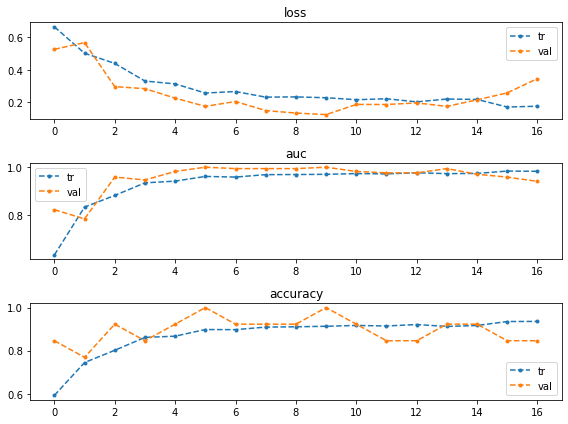

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.

 fold: 6/7, seed: 0/1 


 Train [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 17 18 19 20 21 22 23 24 25
 26 28 29 30 31 32 33 36 37 38 40 41 42 43 45 46 47 48 49 50 51 53 54 55
 56 57 58 61 62 63 64 65 66 68 69 70 71 72 73 74 75 77 78 79 80 81 82 83
 84 85 87 88 89 90 91] 
 Valid [ 3 16 27 34 35 39 44 52 59 60 67 76 86] 




Epoch 1/25


Found 79 validated image filenames belonging to 2 classes.


 1/46 [..............................] - ETA: 0s - loss: 0.6944 - accuracy: 0.3924 - auc: 0.5000

 2/46 [>.............................] - ETA: 11s - loss: 0.6952 - accuracy: 0.4620 - auc: 0.5087

 3/46 [>.............................] - ETA: 15s - loss: 0.6965 - accuracy: 0.4979 - auc: 0.5396

 4/46 [=>............................] - ETA: 20s - loss: 0.6945 - accuracy: 0.5032 - auc: 0.5468

 5/46 [==>...........................] - ETA: 22s - loss: 0.6936 - accuracy: 0.5190 - auc: 0.5557

 6/46 [==>...........................] - ETA: 22s - loss: 0.6922 - accuracy: 0.5274 - auc: 0.5606

 7/46 [===>..........................] - ETA: 22s - loss: 0.6908 - accuracy: 0.5335 - auc: 0.5642

 8/46 [====>.........................] - ETA: 21s - loss: 0.6904 - accuracy: 0.5364 - auc: 0.5643

 9/46 [====>.........................] - ETA: 20s - loss: 0.6896 - accuracy: 0.5401 - auc: 0.5669

10/46 [=====>........................] - ETA: 20s - loss: 0.6901 - accuracy: 0.5418 - auc: 0.5656

11/46 [======>.......................] - ETA: 19s - loss: 0.6885 - accuracy: 0.5432 - auc: 0.5694

12/46 [======>.......................] - ETA: 18s - loss: 0.6881 - accuracy: 0.5485 - auc: 0.5713

13/46 [=======>......................] - ETA: 18s - loss: 0.6889 - accuracy: 0.5492 - auc: 0.5710

14/46 [========>.....................] - ETA: 17s - loss: 0.6878 - accuracy: 0.5515 - auc: 0.5747

15/46 [========>.....................] - ETA: 17s - loss: 0.6885 - accuracy: 0.5477 - auc: 0.5709

16/46 [=========>....................] - ETA: 16s - loss: 0.6879 - accuracy: 0.5498 - auc: 0.5728

17/46 [==========>...................] - ETA: 15s - loss: 0.6868 - accuracy: 0.5525 - auc: 0.5765

18/46 [==========>...................] - ETA: 15s - loss: 0.6855 - accuracy: 0.5549 - auc: 0.5807

19/46 [===========>..................] - ETA: 14s - loss: 0.6841 - accuracy: 0.5556 - auc: 0.5841

20/46 [============>.................] - ETA: 14s - loss: 0.6818 - accuracy: 0.5614 - auc: 0.5909

21/46 [============>.................] - ETA: 13s - loss: 0.6804 - accuracy: 0.5642 - auc: 0.5951

22/46 [=============>................] - ETA: 13s - loss: 0.6771 - accuracy: 0.5696 - auc: 0.6051

23/46 [==============>...............] - ETA: 12s - loss: 0.6772 - accuracy: 0.5735 - auc: 0.6088

24/46 [==============>...............] - ETA: 12s - loss: 0.6747 - accuracy: 0.5749 - auc: 0.6112

25/46 [===============>..............] - ETA: 11s - loss: 0.6795 - accuracy: 0.5777 - auc: 0.6150

26/46 [===============>..............] - ETA: 11s - loss: 0.6746 - accuracy: 0.5813 - auc: 0.6226

27/46 [================>.............] - ETA: 10s - loss: 0.6737 - accuracy: 0.5818 - auc: 0.6237

28/46 [=================>............] - ETA: 9s - loss: 0.6735 - accuracy: 0.5809 - auc: 0.6233 

29/46 [=================>............] - ETA: 9s - loss: 0.6729 - accuracy: 0.5818 - auc: 0.6247

30/46 [==================>...........] - ETA: 8s - loss: 0.6714 - accuracy: 0.5878 - auc: 0.6292

31/46 [===================>..........] - ETA: 8s - loss: 0.6704 - accuracy: 0.5904 - auc: 0.6319

32/46 [===================>..........] - ETA: 7s - loss: 0.6686 - accuracy: 0.5922 - auc: 0.6352

33/46 [====================>.........] - ETA: 7s - loss: 0.6671 - accuracy: 0.5946 - auc: 0.6383

34/46 [=====================>........] - ETA: 6s - loss: 0.6661 - accuracy: 0.5949 - auc: 0.6398

35/46 [=====================>........] - ETA: 6s - loss: 0.6646 - accuracy: 0.5960 - auc: 0.6419

36/46 [======================>.......] - ETA: 5s - loss: 0.6619 - accuracy: 0.5988 - auc: 0.6463

37/46 [=======================>......] - ETA: 4s - loss: 0.6596 - accuracy: 0.6011 - auc: 0.6502

38/46 [=======================>......] - ETA: 4s - loss: 0.6603 - accuracy: 0.6019 - auc: 0.6508

39/46 [========================>.....] - ETA: 3s - loss: 0.6590 - accuracy: 0.6040 - auc: 0.6528

40/46 [=========================>....] - ETA: 3s - loss: 0.6564 - accuracy: 0.6079 - auc: 0.6575

41/46 [=========================>....] - ETA: 2s - loss: 0.6551 - accuracy: 0.6088 - auc: 0.6590

42/46 [==========================>...] - ETA: 2s - loss: 0.6535 - accuracy: 0.6109 - auc: 0.6616

43/46 [===========================>..] - ETA: 1s - loss: 0.6509 - accuracy: 0.6147 - auc: 0.6664

44/46 [===========================>..] - ETA: 1s - loss: 0.6485 - accuracy: 0.6174 - auc: 0.6702

45/46 [============================>.] - ETA: 0s - loss: 0.6454 - accuracy: 0.6200 - auc: 0.6748

46/46 [==============================] - ETA: 0s - loss: 0.6404 - accuracy: 0.6244 - auc: 0.6816

Found 13 validated image filenames belonging to 2 classes.

Epoch 00001: val_loss improved from inf to 0.41928, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 26s 558ms/step - loss: 0.6404 - accuracy: 0.6244 - auc: 0.6816 - val_loss: 0.4193 - val_accuracy: 0.9231 - val_auc: 0.9231


Epoch 2/25


 1/46 [..............................] - ETA: 0s - loss: 0.5203 - accuracy: 0.7722 - auc: 0.8386

 2/46 [>.............................] - ETA: 11s - loss: 0.5097 - accuracy: 0.7468 - auc: 0.8389

 3/46 [>.............................] - ETA: 15s - loss: 0.5172 - accuracy: 0.7342 - auc: 0.8359

 4/46 [=>............................] - ETA: 17s - loss: 0.5205 - accuracy: 0.7468 - auc: 0.8337

 5/46 [==>...........................] - ETA: 17s - loss: 0.5162 - accuracy: 0.7443 - auc: 0.8317

 6/46 [==>...........................] - ETA: 18s - loss: 0.5156 - accuracy: 0.7405 - auc: 0.8295

 7/46 [===>..........................] - ETA: 18s - loss: 0.5168 - accuracy: 0.7486 - auc: 0.8274

 8/46 [====>.........................] - ETA: 17s - loss: 0.5135 - accuracy: 0.7516 - auc: 0.8291

 9/46 [====>.........................] - ETA: 17s - loss: 0.5062 - accuracy: 0.7595 - auc: 0.8349

10/46 [=====>........................] - ETA: 17s - loss: 0.5055 - accuracy: 0.7608 - auc: 0.8352

11/46 [======>.......................] - ETA: 17s - loss: 0.5017 - accuracy: 0.7618 - auc: 0.8380

12/46 [======>.......................] - ETA: 16s - loss: 0.5034 - accuracy: 0.7563 - auc: 0.8358

13/46 [=======>......................] - ETA: 16s - loss: 0.5114 - accuracy: 0.7566 - auc: 0.8322

14/46 [========>.....................] - ETA: 16s - loss: 0.5137 - accuracy: 0.7559 - auc: 0.8309

15/46 [========>.....................] - ETA: 16s - loss: 0.5104 - accuracy: 0.7553 - auc: 0.8326

16/46 [=========>....................] - ETA: 16s - loss: 0.5061 - accuracy: 0.7571 - auc: 0.8353

17/46 [==========>...................] - ETA: 16s - loss: 0.5033 - accuracy: 0.7573 - auc: 0.8368

18/46 [==========>...................] - ETA: 15s - loss: 0.5010 - accuracy: 0.7588 - auc: 0.8383

19/46 [===========>..................] - ETA: 14s - loss: 0.4974 - accuracy: 0.7608 - auc: 0.8412

20/46 [============>.................] - ETA: 14s - loss: 0.4955 - accuracy: 0.7614 - auc: 0.8419

21/46 [============>.................] - ETA: 13s - loss: 0.4949 - accuracy: 0.7613 - auc: 0.8420

22/46 [=============>................] - ETA: 13s - loss: 0.4911 - accuracy: 0.7647 - auc: 0.8445

23/46 [==============>...............] - ETA: 12s - loss: 0.4901 - accuracy: 0.7655 - auc: 0.8451

24/46 [==============>...............] - ETA: 12s - loss: 0.4865 - accuracy: 0.7669 - auc: 0.8474

25/46 [===============>..............] - ETA: 11s - loss: 0.4830 - accuracy: 0.7686 - auc: 0.8496

26/46 [===============>..............] - ETA: 10s - loss: 0.4836 - accuracy: 0.7678 - auc: 0.8496

27/46 [================>.............] - ETA: 10s - loss: 0.4789 - accuracy: 0.7693 - auc: 0.8525

28/46 [=================>............] - ETA: 9s - loss: 0.4786 - accuracy: 0.7681 - auc: 0.8525 

29/46 [=================>............] - ETA: 9s - loss: 0.4751 - accuracy: 0.7713 - auc: 0.8547

30/46 [==================>...........] - ETA: 8s - loss: 0.4714 - accuracy: 0.7747 - auc: 0.8572

31/46 [===================>..........] - ETA: 8s - loss: 0.4723 - accuracy: 0.7750 - auc: 0.8568

32/46 [===================>..........] - ETA: 7s - loss: 0.4710 - accuracy: 0.7749 - auc: 0.8574

33/46 [====================>.........] - ETA: 7s - loss: 0.4694 - accuracy: 0.7756 - auc: 0.8585

34/46 [=====================>........] - ETA: 6s - loss: 0.4683 - accuracy: 0.7748 - auc: 0.8591

35/46 [=====================>........] - ETA: 5s - loss: 0.4664 - accuracy: 0.7772 - auc: 0.8606

36/46 [======================>.......] - ETA: 5s - loss: 0.4660 - accuracy: 0.7774 - auc: 0.8612

37/46 [=======================>......] - ETA: 4s - loss: 0.4628 - accuracy: 0.7790 - auc: 0.8632

38/46 [=======================>......] - ETA: 4s - loss: 0.4600 - accuracy: 0.7805 - auc: 0.8649

39/46 [========================>.....] - ETA: 3s - loss: 0.4587 - accuracy: 0.7816 - auc: 0.8656

40/46 [=========================>....] - ETA: 3s - loss: 0.4562 - accuracy: 0.7826 - auc: 0.8672

41/46 [=========================>....] - ETA: 2s - loss: 0.4553 - accuracy: 0.7833 - auc: 0.8676

42/46 [==========================>...] - ETA: 2s - loss: 0.4573 - accuracy: 0.7830 - auc: 0.8668

43/46 [===========================>..] - ETA: 1s - loss: 0.4551 - accuracy: 0.7851 - auc: 0.8685

44/46 [===========================>..] - ETA: 1s - loss: 0.4530 - accuracy: 0.7862 - auc: 0.8698

45/46 [============================>.] - ETA: 0s - loss: 0.4515 - accuracy: 0.7868 - auc: 0.8706

46/46 [==============================] - ETA: 0s - loss: 0.4510 - accuracy: 0.7878 - auc: 0.8710

Found 13 validated image filenames belonging to 2 classes.



Epoch 00002: val_loss improved from 0.41928 to 0.28468, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 25s 548ms/step - loss: 0.4510 - accuracy: 0.7878 - auc: 0.8710 - val_loss: 0.2847 - val_accuracy: 0.9231 - val_auc: 0.9822


Epoch 3/25


 1/46 [..............................] - ETA: 0s - loss: 0.3883 - accuracy: 0.8228 - auc: 0.9188

 2/46 [>.............................] - ETA: 12s - loss: 0.3922 - accuracy: 0.8228 - auc: 0.9192

 3/46 [>.............................] - ETA: 15s - loss: 0.4063 - accuracy: 0.8143 - auc: 0.9096

 4/46 [=>............................] - ETA: 17s - loss: 0.4195 - accuracy: 0.8006 - auc: 0.8970

 5/46 [==>...........................] - ETA: 17s - loss: 0.4135 - accuracy: 0.8127 - auc: 0.8995

 6/46 [==>...........................] - ETA: 18s - loss: 0.4017 - accuracy: 0.8101 - auc: 0.9014

 7/46 [===>..........................] - ETA: 18s - loss: 0.3883 - accuracy: 0.8137 - auc: 0.9076

 8/46 [====>.........................] - ETA: 18s - loss: 0.3809 - accuracy: 0.8133 - auc: 0.9096

 9/46 [====>.........................] - ETA: 17s - loss: 0.3837 - accuracy: 0.8143 - auc: 0.9079

10/46 [=====>........................] - ETA: 17s - loss: 0.3761 - accuracy: 0.8190 - auc: 0.9117

11/46 [======>.......................] - ETA: 17s - loss: 0.3722 - accuracy: 0.8216 - auc: 0.9137

12/46 [======>.......................] - ETA: 16s - loss: 0.3724 - accuracy: 0.8228 - auc: 0.9135

13/46 [=======>......................] - ETA: 16s - loss: 0.3742 - accuracy: 0.8208 - auc: 0.9131

14/46 [========>.....................] - ETA: 16s - loss: 0.3701 - accuracy: 0.8228 - auc: 0.9149

15/46 [========>.....................] - ETA: 15s - loss: 0.3688 - accuracy: 0.8228 - auc: 0.9152

16/46 [=========>....................] - ETA: 15s - loss: 0.3684 - accuracy: 0.8259 - auc: 0.9160

17/46 [==========>...................] - ETA: 14s - loss: 0.3628 - accuracy: 0.8287 - auc: 0.9188

18/46 [==========>...................] - ETA: 14s - loss: 0.3567 - accuracy: 0.8326 - auc: 0.9218

19/46 [===========>..................] - ETA: 13s - loss: 0.3641 - accuracy: 0.8314 - auc: 0.9188

20/46 [============>.................] - ETA: 13s - loss: 0.3630 - accuracy: 0.8335 - auc: 0.9195

21/46 [============>.................] - ETA: 12s - loss: 0.3603 - accuracy: 0.8360 - auc: 0.9209

22/46 [=============>................] - ETA: 12s - loss: 0.3557 - accuracy: 0.8400 - auc: 0.9233

23/46 [==============>...............] - ETA: 11s - loss: 0.3564 - accuracy: 0.8404 - auc: 0.9227

24/46 [==============>...............] - ETA: 11s - loss: 0.3546 - accuracy: 0.8423 - auc: 0.9236

25/46 [===============>..............] - ETA: 10s - loss: 0.3545 - accuracy: 0.8420 - auc: 0.9235

26/46 [===============>..............] - ETA: 10s - loss: 0.3515 - accuracy: 0.8432 - auc: 0.9248

27/46 [================>.............] - ETA: 10s - loss: 0.3530 - accuracy: 0.8439 - auc: 0.9244

28/46 [=================>............] - ETA: 9s - loss: 0.3530 - accuracy: 0.8427 - auc: 0.9241 

29/46 [=================>............] - ETA: 9s - loss: 0.3537 - accuracy: 0.8424 - auc: 0.9237

30/46 [==================>...........] - ETA: 8s - loss: 0.3522 - accuracy: 0.8430 - auc: 0.9242

31/46 [===================>..........] - ETA: 8s - loss: 0.3495 - accuracy: 0.8448 - auc: 0.9255

32/46 [===================>..........] - ETA: 7s - loss: 0.3466 - accuracy: 0.8461 - auc: 0.9267

33/46 [====================>.........] - ETA: 7s - loss: 0.3450 - accuracy: 0.8470 - auc: 0.9275

34/46 [=====================>........] - ETA: 6s - loss: 0.3425 - accuracy: 0.8481 - auc: 0.9287

35/46 [=====================>........] - ETA: 6s - loss: 0.3407 - accuracy: 0.8503 - auc: 0.9296

36/46 [======================>.......] - ETA: 5s - loss: 0.3402 - accuracy: 0.8516 - auc: 0.9297

37/46 [=======================>......] - ETA: 4s - loss: 0.3389 - accuracy: 0.8519 - auc: 0.9302

38/46 [=======================>......] - ETA: 4s - loss: 0.3403 - accuracy: 0.8514 - auc: 0.9298

39/46 [========================>.....] - ETA: 3s - loss: 0.3401 - accuracy: 0.8507 - auc: 0.9298

40/46 [=========================>....] - ETA: 3s - loss: 0.3408 - accuracy: 0.8503 - auc: 0.9294

41/46 [=========================>....] - ETA: 2s - loss: 0.3382 - accuracy: 0.8515 - auc: 0.9305

42/46 [==========================>...] - ETA: 2s - loss: 0.3394 - accuracy: 0.8520 - auc: 0.9300

43/46 [===========================>..] - ETA: 1s - loss: 0.3367 - accuracy: 0.8537 - auc: 0.9312

44/46 [===========================>..] - ETA: 1s - loss: 0.3370 - accuracy: 0.8539 - auc: 0.9311

45/46 [============================>.] - ETA: 0s - loss: 0.3370 - accuracy: 0.8532 - auc: 0.9310

46/46 [==============================] - ETA: 0s - loss: 0.3365 - accuracy: 0.8544 - auc: 0.9313

Found 13 validated image filenames belonging to 2 classes.



Epoch 00003: val_loss improved from 0.28468 to 0.14017, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 26s 558ms/step - loss: 0.3365 - accuracy: 0.8544 - auc: 0.9313 - val_loss: 0.1402 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 4/25


 1/46 [..............................] - ETA: 0s - loss: 0.3542 - accuracy: 0.8228 - auc: 0.9216

 2/46 [>.............................] - ETA: 11s - loss: 0.3450 - accuracy: 0.8481 - auc: 0.9285

 3/46 [>.............................] - ETA: 15s - loss: 0.3389 - accuracy: 0.8523 - auc: 0.9297

 4/46 [=>............................] - ETA: 16s - loss: 0.3171 - accuracy: 0.8576 - auc: 0.9384

 5/46 [==>...........................] - ETA: 17s - loss: 0.3216 - accuracy: 0.8608 - auc: 0.9362

 6/46 [==>...........................] - ETA: 18s - loss: 0.3108 - accuracy: 0.8671 - auc: 0.9410

 7/46 [===>..........................] - ETA: 18s - loss: 0.3391 - accuracy: 0.8626 - auc: 0.9322

 8/46 [====>.........................] - ETA: 17s - loss: 0.3418 - accuracy: 0.8639 - auc: 0.9314

 9/46 [====>.........................] - ETA: 17s - loss: 0.3457 - accuracy: 0.8565 - auc: 0.9290

10/46 [=====>........................] - ETA: 17s - loss: 0.3476 - accuracy: 0.8532 - auc: 0.9277

11/46 [======>.......................] - ETA: 17s - loss: 0.3596 - accuracy: 0.8412 - auc: 0.9220

12/46 [======>.......................] - ETA: 16s - loss: 0.3592 - accuracy: 0.8439 - auc: 0.9221

13/46 [=======>......................] - ETA: 16s - loss: 0.3530 - accuracy: 0.8510 - auc: 0.9251

14/46 [========>.....................] - ETA: 16s - loss: 0.3525 - accuracy: 0.8508 - auc: 0.9251

15/46 [========>.....................] - ETA: 15s - loss: 0.3533 - accuracy: 0.8498 - auc: 0.9247

16/46 [=========>....................] - ETA: 15s - loss: 0.3536 - accuracy: 0.8481 - auc: 0.9244

17/46 [==========>...................] - ETA: 14s - loss: 0.3477 - accuracy: 0.8511 - auc: 0.9268

18/46 [==========>...................] - ETA: 14s - loss: 0.3431 - accuracy: 0.8530 - auc: 0.9286

19/46 [===========>..................] - ETA: 13s - loss: 0.3488 - accuracy: 0.8481 - auc: 0.9261

20/46 [============>.................] - ETA: 13s - loss: 0.3466 - accuracy: 0.8468 - auc: 0.9269

21/46 [============>.................] - ETA: 12s - loss: 0.3408 - accuracy: 0.8493 - auc: 0.9293

22/46 [=============>................] - ETA: 12s - loss: 0.3370 - accuracy: 0.8521 - auc: 0.9310

23/46 [==============>...............] - ETA: 11s - loss: 0.3328 - accuracy: 0.8536 - auc: 0.9326

24/46 [==============>...............] - ETA: 11s - loss: 0.3334 - accuracy: 0.8528 - auc: 0.9323

25/46 [===============>..............] - ETA: 10s - loss: 0.3338 - accuracy: 0.8516 - auc: 0.9320

26/46 [===============>..............] - ETA: 10s - loss: 0.3315 - accuracy: 0.8539 - auc: 0.9330

27/46 [================>.............] - ETA: 9s - loss: 0.3318 - accuracy: 0.8523 - auc: 0.9328 

28/46 [=================>............] - ETA: 9s - loss: 0.3286 - accuracy: 0.8540 - auc: 0.9341

29/46 [=================>............] - ETA: 8s - loss: 0.3275 - accuracy: 0.8542 - auc: 0.9345

30/46 [==================>...........] - ETA: 8s - loss: 0.3267 - accuracy: 0.8536 - auc: 0.9348

31/46 [===================>..........] - ETA: 7s - loss: 0.3312 - accuracy: 0.8522 - auc: 0.9333

32/46 [===================>..........] - ETA: 7s - loss: 0.3292 - accuracy: 0.8532 - auc: 0.9341

33/46 [====================>.........] - ETA: 6s - loss: 0.3296 - accuracy: 0.8531 - auc: 0.9340

34/46 [=====================>........] - ETA: 6s - loss: 0.3275 - accuracy: 0.8548 - auc: 0.9348

35/46 [=====================>........] - ETA: 5s - loss: 0.3288 - accuracy: 0.8539 - auc: 0.9343

36/46 [======================>.......] - ETA: 5s - loss: 0.3270 - accuracy: 0.8548 - auc: 0.9350

37/46 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8549 - auc: 0.9351

38/46 [=======================>......] - ETA: 4s - loss: 0.3267 - accuracy: 0.8558 - auc: 0.9351

39/46 [========================>.....] - ETA: 3s - loss: 0.3267 - accuracy: 0.8552 - auc: 0.9350

40/46 [=========================>....] - ETA: 3s - loss: 0.3269 - accuracy: 0.8544 - auc: 0.9348

41/46 [=========================>....] - ETA: 2s - loss: 0.3263 - accuracy: 0.8549 - auc: 0.9351

42/46 [==========================>...] - ETA: 2s - loss: 0.3243 - accuracy: 0.8556 - auc: 0.9358

43/46 [===========================>..] - ETA: 1s - loss: 0.3238 - accuracy: 0.8558 - auc: 0.9360

44/46 [===========================>..] - ETA: 1s - loss: 0.3228 - accuracy: 0.8564 - auc: 0.9364

45/46 [============================>.] - ETA: 0s - loss: 0.3201 - accuracy: 0.8574 - auc: 0.9374

46/46 [==============================] - ETA: 0s - loss: 0.3230 - accuracy: 0.8558 - auc: 0.9364

Found 13 validated image filenames belonging to 2 classes.



Epoch 00004: val_loss did not improve from 0.14017
46/46 [==============================] - 25s 548ms/step - loss: 0.3230 - accuracy: 0.8558 - auc: 0.9364 - val_loss: 0.2326 - val_accuracy: 0.9231 - val_auc: 0.9704


Epoch 5/25


 1/46 [..............................] - ETA: 0s - loss: 0.2913 - accuracy: 0.8481 - auc: 0.9451

 2/46 [>.............................] - ETA: 12s - loss: 0.3496 - accuracy: 0.8291 - auc: 0.9237

 3/46 [>.............................] - ETA: 16s - loss: 0.3126 - accuracy: 0.8354 - auc: 0.9386

 4/46 [=>............................] - ETA: 17s - loss: 0.3038 - accuracy: 0.8481 - auc: 0.9432

 5/46 [==>...........................] - ETA: 18s - loss: 0.2965 - accuracy: 0.8532 - auc: 0.9463

 6/46 [==>...........................] - ETA: 18s - loss: 0.3164 - accuracy: 0.8418 - auc: 0.9371

 7/46 [===>..........................] - ETA: 18s - loss: 0.3211 - accuracy: 0.8463 - auc: 0.9371

 8/46 [====>.........................] - ETA: 18s - loss: 0.3220 - accuracy: 0.8465 - auc: 0.9362

 9/46 [====>.........................] - ETA: 18s - loss: 0.3253 - accuracy: 0.8467 - auc: 0.9348

10/46 [=====>........................] - ETA: 17s - loss: 0.3176 - accuracy: 0.8506 - auc: 0.9380

11/46 [======>.......................] - ETA: 17s - loss: 0.3081 - accuracy: 0.8527 - auc: 0.9417

12/46 [======>.......................] - ETA: 17s - loss: 0.3057 - accuracy: 0.8523 - auc: 0.9424

13/46 [=======>......................] - ETA: 16s - loss: 0.3041 - accuracy: 0.8549 - auc: 0.9430

14/46 [========>.....................] - ETA: 16s - loss: 0.3029 - accuracy: 0.8571 - auc: 0.9438

15/46 [========>.....................] - ETA: 15s - loss: 0.2964 - accuracy: 0.8599 - auc: 0.9461

16/46 [=========>....................] - ETA: 15s - loss: 0.2980 - accuracy: 0.8584 - auc: 0.9456

17/46 [==========>...................] - ETA: 14s - loss: 0.3018 - accuracy: 0.8622 - auc: 0.9462

18/46 [==========>...................] - ETA: 14s - loss: 0.2976 - accuracy: 0.8622 - auc: 0.9474

19/46 [===========>..................] - ETA: 13s - loss: 0.2950 - accuracy: 0.8641 - auc: 0.9483

20/46 [============>.................] - ETA: 13s - loss: 0.2952 - accuracy: 0.8646 - auc: 0.9480

21/46 [============>.................] - ETA: 12s - loss: 0.2968 - accuracy: 0.8632 - auc: 0.9472

22/46 [=============>................] - ETA: 12s - loss: 0.2950 - accuracy: 0.8642 - auc: 0.9478

23/46 [==============>...............] - ETA: 11s - loss: 0.2933 - accuracy: 0.8646 - auc: 0.9484

24/46 [==============>...............] - ETA: 11s - loss: 0.2918 - accuracy: 0.8655 - auc: 0.9490

25/46 [===============>..............] - ETA: 10s - loss: 0.2874 - accuracy: 0.8684 - auc: 0.9507

26/46 [===============>..............] - ETA: 10s - loss: 0.2933 - accuracy: 0.8681 - auc: 0.9490

27/46 [================>.............] - ETA: 9s - loss: 0.2924 - accuracy: 0.8701 - auc: 0.9496 

28/46 [=================>............] - ETA: 9s - loss: 0.2901 - accuracy: 0.8721 - auc: 0.9504

29/46 [=================>............] - ETA: 8s - loss: 0.2903 - accuracy: 0.8721 - auc: 0.9504

30/46 [==================>...........] - ETA: 8s - loss: 0.2874 - accuracy: 0.8755 - auc: 0.9516

31/46 [===================>..........] - ETA: 7s - loss: 0.2859 - accuracy: 0.8767 - auc: 0.9520

32/46 [===================>..........] - ETA: 7s - loss: 0.2856 - accuracy: 0.8778 - auc: 0.9522

33/46 [====================>.........] - ETA: 6s - loss: 0.2837 - accuracy: 0.8776 - auc: 0.9527

34/46 [=====================>........] - ETA: 6s - loss: 0.2841 - accuracy: 0.8783 - auc: 0.9527

35/46 [=====================>........] - ETA: 5s - loss: 0.2829 - accuracy: 0.8788 - auc: 0.9531

36/46 [======================>.......] - ETA: 5s - loss: 0.2815 - accuracy: 0.8794 - auc: 0.9535

37/46 [=======================>......] - ETA: 4s - loss: 0.2819 - accuracy: 0.8785 - auc: 0.9533

38/46 [=======================>......] - ETA: 4s - loss: 0.2837 - accuracy: 0.8787 - auc: 0.9528

39/46 [========================>.....] - ETA: 3s - loss: 0.2846 - accuracy: 0.8783 - auc: 0.9525

40/46 [=========================>....] - ETA: 3s - loss: 0.2834 - accuracy: 0.8788 - auc: 0.9528

41/46 [=========================>....] - ETA: 2s - loss: 0.2833 - accuracy: 0.8787 - auc: 0.9527

42/46 [==========================>...] - ETA: 2s - loss: 0.2823 - accuracy: 0.8794 - auc: 0.9531

43/46 [===========================>..] - ETA: 1s - loss: 0.2825 - accuracy: 0.8790 - auc: 0.9528

44/46 [===========================>..] - ETA: 1s - loss: 0.2821 - accuracy: 0.8792 - auc: 0.9530

45/46 [============================>.] - ETA: 0s - loss: 0.2811 - accuracy: 0.8796 - auc: 0.9533

46/46 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8789 - auc: 0.9536

Found 13 validated image filenames belonging to 2 classes.



Epoch 00005: val_loss improved from 0.14017 to 0.09931, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 25s 534ms/step - loss: 0.2800 - accuracy: 0.8789 - auc: 0.9536 - val_loss: 0.0993 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 6/25


 1/46 [..............................] - ETA: 0s - loss: 0.2693 - accuracy: 0.8861 - auc: 0.9580

 2/46 [>.............................] - ETA: 11s - loss: 0.2472 - accuracy: 0.8797 - auc: 0.9626

 3/46 [>.............................] - ETA: 15s - loss: 0.2230 - accuracy: 0.8903 - auc: 0.9698

 4/46 [=>............................] - ETA: 20s - loss: 0.2279 - accuracy: 0.8892 - auc: 0.9688

 5/46 [==>...........................] - ETA: 22s - loss: 0.2349 - accuracy: 0.8937 - auc: 0.9666

 6/46 [==>...........................] - ETA: 22s - loss: 0.2406 - accuracy: 0.8903 - auc: 0.9653

 7/46 [===>..........................] - ETA: 22s - loss: 0.2408 - accuracy: 0.8969 - auc: 0.9653

 8/46 [====>.........................] - ETA: 21s - loss: 0.2418 - accuracy: 0.8940 - auc: 0.9646

 9/46 [====>.........................] - ETA: 20s - loss: 0.2435 - accuracy: 0.8945 - auc: 0.9642

10/46 [=====>........................] - ETA: 20s - loss: 0.2370 - accuracy: 0.8987 - auc: 0.9659

11/46 [======>.......................] - ETA: 19s - loss: 0.2304 - accuracy: 0.9022 - auc: 0.9678

12/46 [======>.......................] - ETA: 18s - loss: 0.2328 - accuracy: 0.9019 - auc: 0.9672

13/46 [=======>......................] - ETA: 18s - loss: 0.2308 - accuracy: 0.9026 - auc: 0.9678

14/46 [========>.....................] - ETA: 18s - loss: 0.2299 - accuracy: 0.9033 - auc: 0.9681

15/46 [========>.....................] - ETA: 17s - loss: 0.2305 - accuracy: 0.9030 - auc: 0.9679

16/46 [=========>....................] - ETA: 16s - loss: 0.2355 - accuracy: 0.8987 - auc: 0.9665

17/46 [==========>...................] - ETA: 16s - loss: 0.2322 - accuracy: 0.9002 - auc: 0.9674

18/46 [==========>...................] - ETA: 15s - loss: 0.2311 - accuracy: 0.9015 - auc: 0.9678

19/46 [===========>..................] - ETA: 15s - loss: 0.2300 - accuracy: 0.9021 - auc: 0.9681

20/46 [============>.................] - ETA: 14s - loss: 0.2326 - accuracy: 0.9019 - auc: 0.9675

21/46 [============>.................] - ETA: 14s - loss: 0.2338 - accuracy: 0.8999 - auc: 0.9671

22/46 [=============>................] - ETA: 13s - loss: 0.2338 - accuracy: 0.8999 - auc: 0.9671

23/46 [==============>...............] - ETA: 12s - loss: 0.2344 - accuracy: 0.8982 - auc: 0.9669

24/46 [==============>...............] - ETA: 12s - loss: 0.2351 - accuracy: 0.8982 - auc: 0.9666

25/46 [===============>..............] - ETA: 11s - loss: 0.2351 - accuracy: 0.8977 - auc: 0.9666

26/46 [===============>..............] - ETA: 11s - loss: 0.2402 - accuracy: 0.8973 - auc: 0.9653

27/46 [================>.............] - ETA: 10s - loss: 0.2390 - accuracy: 0.8964 - auc: 0.9656

28/46 [=================>............] - ETA: 10s - loss: 0.2389 - accuracy: 0.8974 - auc: 0.9657

29/46 [=================>............] - ETA: 9s - loss: 0.2392 - accuracy: 0.8979 - auc: 0.9656 

30/46 [==================>...........] - ETA: 8s - loss: 0.2374 - accuracy: 0.8979 - auc: 0.9661

31/46 [===================>..........] - ETA: 8s - loss: 0.2388 - accuracy: 0.8975 - auc: 0.9657

32/46 [===================>..........] - ETA: 7s - loss: 0.2370 - accuracy: 0.8983 - auc: 0.9662

33/46 [====================>.........] - ETA: 7s - loss: 0.2357 - accuracy: 0.8995 - auc: 0.9666

34/46 [=====================>........] - ETA: 6s - loss: 0.2364 - accuracy: 0.8999 - auc: 0.9665

35/46 [=====================>........] - ETA: 6s - loss: 0.2374 - accuracy: 0.8984 - auc: 0.9661

36/46 [======================>.......] - ETA: 5s - loss: 0.2362 - accuracy: 0.8994 - auc: 0.9665

37/46 [=======================>......] - ETA: 4s - loss: 0.2396 - accuracy: 0.8998 - auc: 0.9657

38/46 [=======================>......] - ETA: 4s - loss: 0.2393 - accuracy: 0.8991 - auc: 0.9657

39/46 [========================>.....] - ETA: 3s - loss: 0.2382 - accuracy: 0.8997 - auc: 0.9660

40/46 [=========================>....] - ETA: 3s - loss: 0.2426 - accuracy: 0.8991 - auc: 0.9648

41/46 [=========================>....] - ETA: 2s - loss: 0.2466 - accuracy: 0.8984 - auc: 0.9637

42/46 [==========================>...] - ETA: 2s - loss: 0.2458 - accuracy: 0.8987 - auc: 0.9639

43/46 [===========================>..] - ETA: 1s - loss: 0.2463 - accuracy: 0.8987 - auc: 0.9638

44/46 [===========================>..] - ETA: 1s - loss: 0.2450 - accuracy: 0.8996 - auc: 0.9642

45/46 [============================>.] - ETA: 0s - loss: 0.2476 - accuracy: 0.8979 - auc: 0.9635

46/46 [==============================] - ETA: 0s - loss: 0.2468 - accuracy: 0.8979 - auc: 0.9637

Found 13 validated image filenames belonging to 2 classes.



Epoch 00006: val_loss did not improve from 0.09931
46/46 [==============================] - 25s 554ms/step - loss: 0.2468 - accuracy: 0.8979 - auc: 0.9637 - val_loss: 0.1907 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 7/25


 1/46 [..............................] - ETA: 0s - loss: 0.1966 - accuracy: 0.9114 - auc: 0.9824

 2/46 [>.............................] - ETA: 12s - loss: 0.2278 - accuracy: 0.9051 - auc: 0.9740

 3/46 [>.............................] - ETA: 15s - loss: 0.2686 - accuracy: 0.8945 - auc: 0.9587

 4/46 [=>............................] - ETA: 17s - loss: 0.2584 - accuracy: 0.8892 - auc: 0.9605

 5/46 [==>...........................] - ETA: 17s - loss: 0.2580 - accuracy: 0.8937 - auc: 0.9610

 6/46 [==>...........................] - ETA: 18s - loss: 0.2659 - accuracy: 0.8903 - auc: 0.9583

 7/46 [===>..........................] - ETA: 18s - loss: 0.2615 - accuracy: 0.8933 - auc: 0.9595

 8/46 [====>.........................] - ETA: 18s - loss: 0.2610 - accuracy: 0.8956 - auc: 0.9599

 9/46 [====>.........................] - ETA: 17s - loss: 0.2526 - accuracy: 0.9001 - auc: 0.9625

10/46 [=====>........................] - ETA: 17s - loss: 0.2459 - accuracy: 0.9051 - auc: 0.9646

11/46 [======>.......................] - ETA: 17s - loss: 0.2506 - accuracy: 0.9010 - auc: 0.9633

12/46 [======>.......................] - ETA: 16s - loss: 0.2464 - accuracy: 0.9030 - auc: 0.9647

13/46 [=======>......................] - ETA: 16s - loss: 0.2534 - accuracy: 0.9026 - auc: 0.9632

14/46 [========>.....................] - ETA: 16s - loss: 0.2516 - accuracy: 0.9014 - auc: 0.9637

15/46 [========>.....................] - ETA: 16s - loss: 0.2514 - accuracy: 0.9013 - auc: 0.9637

16/46 [=========>....................] - ETA: 16s - loss: 0.2454 - accuracy: 0.9051 - auc: 0.9654

17/46 [==========>...................] - ETA: 16s - loss: 0.2457 - accuracy: 0.9047 - auc: 0.9653

18/46 [==========>...................] - ETA: 15s - loss: 0.2468 - accuracy: 0.9051 - auc: 0.9649

19/46 [===========>..................] - ETA: 15s - loss: 0.2514 - accuracy: 0.9007 - auc: 0.9633

20/46 [============>.................] - ETA: 14s - loss: 0.2529 - accuracy: 0.8994 - auc: 0.9628

21/46 [============>.................] - ETA: 13s - loss: 0.2580 - accuracy: 0.8969 - auc: 0.9614

22/46 [=============>................] - ETA: 13s - loss: 0.2585 - accuracy: 0.8947 - auc: 0.9613

23/46 [==============>...............] - ETA: 12s - loss: 0.2554 - accuracy: 0.8965 - auc: 0.9622

24/46 [==============>...............] - ETA: 12s - loss: 0.2553 - accuracy: 0.8961 - auc: 0.9622

25/46 [===============>..............] - ETA: 11s - loss: 0.2543 - accuracy: 0.8977 - auc: 0.9627

26/46 [===============>..............] - ETA: 11s - loss: 0.2576 - accuracy: 0.8968 - auc: 0.9617

27/46 [================>.............] - ETA: 10s - loss: 0.2558 - accuracy: 0.8978 - auc: 0.9622

28/46 [=================>............] - ETA: 9s - loss: 0.2560 - accuracy: 0.8978 - auc: 0.9622 

29/46 [=================>............] - ETA: 9s - loss: 0.2553 - accuracy: 0.8979 - auc: 0.9623

30/46 [==================>...........] - ETA: 8s - loss: 0.2539 - accuracy: 0.8987 - auc: 0.9628

31/46 [===================>..........] - ETA: 8s - loss: 0.2546 - accuracy: 0.8991 - auc: 0.9624

32/46 [===================>..........] - ETA: 7s - loss: 0.2516 - accuracy: 0.9007 - auc: 0.9633

33/46 [====================>.........] - ETA: 7s - loss: 0.2517 - accuracy: 0.9007 - auc: 0.9633

34/46 [=====================>........] - ETA: 6s - loss: 0.2508 - accuracy: 0.9002 - auc: 0.9635

35/46 [=====================>........] - ETA: 6s - loss: 0.2516 - accuracy: 0.8987 - auc: 0.9631

36/46 [======================>.......] - ETA: 5s - loss: 0.2523 - accuracy: 0.8984 - auc: 0.9628

37/46 [=======================>......] - ETA: 4s - loss: 0.2538 - accuracy: 0.8980 - auc: 0.9624

38/46 [=======================>......] - ETA: 4s - loss: 0.2529 - accuracy: 0.8977 - auc: 0.9626

39/46 [========================>.....] - ETA: 3s - loss: 0.2514 - accuracy: 0.8987 - auc: 0.9631

40/46 [=========================>....] - ETA: 3s - loss: 0.2515 - accuracy: 0.8978 - auc: 0.9630

41/46 [=========================>....] - ETA: 2s - loss: 0.2493 - accuracy: 0.8984 - auc: 0.9637

42/46 [==========================>...] - ETA: 2s - loss: 0.2491 - accuracy: 0.8987 - auc: 0.9637

43/46 [===========================>..] - ETA: 1s - loss: 0.2483 - accuracy: 0.8987 - auc: 0.9639

44/46 [===========================>..] - ETA: 1s - loss: 0.2480 - accuracy: 0.8996 - auc: 0.9640

45/46 [============================>.] - ETA: 0s - loss: 0.2463 - accuracy: 0.9001 - auc: 0.9645

46/46 [==============================] - ETA: 0s - loss: 0.2446 - accuracy: 0.9009 - auc: 0.9650

Found 13 validated image filenames belonging to 2 classes.



Epoch 00007: val_loss improved from 0.09931 to 0.09769, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 25s 553ms/step - loss: 0.2446 - accuracy: 0.9009 - auc: 0.9650 - val_loss: 0.0977 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 8/25


 1/46 [..............................] - ETA: 0s - loss: 0.2068 - accuracy: 0.9367 - auc: 0.9747

 2/46 [>.............................] - ETA: 11s - loss: 0.2402 - accuracy: 0.8987 - auc: 0.9650

 3/46 [>.............................] - ETA: 15s - loss: 0.2535 - accuracy: 0.8903 - auc: 0.9615

 4/46 [=>............................] - ETA: 16s - loss: 0.2325 - accuracy: 0.8987 - auc: 0.9681

 5/46 [==>...........................] - ETA: 17s - loss: 0.2297 - accuracy: 0.9013 - auc: 0.9687

 6/46 [==>...........................] - ETA: 17s - loss: 0.2133 - accuracy: 0.9114 - auc: 0.9735

 7/46 [===>..........................] - ETA: 17s - loss: 0.2105 - accuracy: 0.9132 - auc: 0.9741

 8/46 [====>.........................] - ETA: 17s - loss: 0.2041 - accuracy: 0.9161 - auc: 0.9756

 9/46 [====>.........................] - ETA: 17s - loss: 0.1934 - accuracy: 0.9198 - auc: 0.9782

10/46 [=====>........................] - ETA: 17s - loss: 0.2163 - accuracy: 0.9152 - auc: 0.9734

11/46 [======>.......................] - ETA: 17s - loss: 0.2241 - accuracy: 0.9114 - auc: 0.9710

12/46 [======>.......................] - ETA: 16s - loss: 0.2287 - accuracy: 0.9103 - auc: 0.9699

13/46 [=======>......................] - ETA: 16s - loss: 0.2288 - accuracy: 0.9075 - auc: 0.9697

14/46 [========>.....................] - ETA: 16s - loss: 0.2269 - accuracy: 0.9096 - auc: 0.9702

15/46 [========>.....................] - ETA: 15s - loss: 0.2301 - accuracy: 0.9072 - auc: 0.9694

16/46 [=========>....................] - ETA: 15s - loss: 0.2321 - accuracy: 0.9066 - auc: 0.9689

17/46 [==========>...................] - ETA: 14s - loss: 0.2307 - accuracy: 0.9062 - auc: 0.9692

18/46 [==========>...................] - ETA: 14s - loss: 0.2307 - accuracy: 0.9058 - auc: 0.9691

19/46 [===========>..................] - ETA: 13s - loss: 0.2338 - accuracy: 0.9054 - auc: 0.9683

20/46 [============>.................] - ETA: 13s - loss: 0.2309 - accuracy: 0.9076 - auc: 0.9691

21/46 [============>.................] - ETA: 12s - loss: 0.2298 - accuracy: 0.9084 - auc: 0.9693

22/46 [=============>................] - ETA: 12s - loss: 0.2254 - accuracy: 0.9108 - auc: 0.9705

23/46 [==============>...............] - ETA: 11s - loss: 0.2268 - accuracy: 0.9092 - auc: 0.9700

24/46 [==============>...............] - ETA: 11s - loss: 0.2251 - accuracy: 0.9088 - auc: 0.9704

25/46 [===============>..............] - ETA: 10s - loss: 0.2331 - accuracy: 0.9073 - auc: 0.9685

26/46 [===============>..............] - ETA: 10s - loss: 0.2323 - accuracy: 0.9085 - auc: 0.9687

27/46 [================>.............] - ETA: 10s - loss: 0.2325 - accuracy: 0.9072 - auc: 0.9686

28/46 [=================>............] - ETA: 9s - loss: 0.2322 - accuracy: 0.9073 - auc: 0.9687 

29/46 [=================>............] - ETA: 9s - loss: 0.2333 - accuracy: 0.9066 - auc: 0.9683

30/46 [==================>...........] - ETA: 8s - loss: 0.2361 - accuracy: 0.9051 - auc: 0.9675

31/46 [===================>..........] - ETA: 8s - loss: 0.2366 - accuracy: 0.9045 - auc: 0.9674

32/46 [===================>..........] - ETA: 7s - loss: 0.2363 - accuracy: 0.9051 - auc: 0.9674

33/46 [====================>.........] - ETA: 7s - loss: 0.2345 - accuracy: 0.9064 - auc: 0.9680

34/46 [=====================>........] - ETA: 6s - loss: 0.2354 - accuracy: 0.9051 - auc: 0.9677

35/46 [=====================>........] - ETA: 6s - loss: 0.2352 - accuracy: 0.9045 - auc: 0.9677

36/46 [======================>.......] - ETA: 5s - loss: 0.2339 - accuracy: 0.9051 - auc: 0.9680

37/46 [=======================>......] - ETA: 4s - loss: 0.2320 - accuracy: 0.9059 - auc: 0.9685

38/46 [=======================>......] - ETA: 4s - loss: 0.2302 - accuracy: 0.9067 - auc: 0.9690

39/46 [========================>.....] - ETA: 3s - loss: 0.2303 - accuracy: 0.9062 - auc: 0.9690

40/46 [=========================>....] - ETA: 3s - loss: 0.2286 - accuracy: 0.9066 - auc: 0.9694

41/46 [=========================>....] - ETA: 2s - loss: 0.2277 - accuracy: 0.9068 - auc: 0.9696

42/46 [==========================>...] - ETA: 2s - loss: 0.2250 - accuracy: 0.9081 - auc: 0.9704

43/46 [===========================>..] - ETA: 1s - loss: 0.2235 - accuracy: 0.9090 - auc: 0.9707

44/46 [===========================>..] - ETA: 1s - loss: 0.2227 - accuracy: 0.9094 - auc: 0.9709

45/46 [============================>.] - ETA: 0s - loss: 0.2276 - accuracy: 0.9094 - auc: 0.9701

46/46 [==============================] - ETA: 0s - loss: 0.2251 - accuracy: 0.9103 - auc: 0.9707

Found 13 validated image filenames belonging to 2 classes.



Epoch 00008: val_loss improved from 0.09769 to 0.05963, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 26s 555ms/step - loss: 0.2251 - accuracy: 0.9103 - auc: 0.9707 - val_loss: 0.0596 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 9/25


 1/46 [..............................] - ETA: 0s - loss: 0.1746 - accuracy: 0.9241 - auc: 0.9822

 2/46 [>.............................] - ETA: 11s - loss: 0.2192 - accuracy: 0.9114 - auc: 0.9704

 3/46 [>.............................] - ETA: 15s - loss: 0.2472 - accuracy: 0.8945 - auc: 0.9642

 4/46 [=>............................] - ETA: 16s - loss: 0.2413 - accuracy: 0.9082 - auc: 0.9666

 5/46 [==>...........................] - ETA: 17s - loss: 0.2423 - accuracy: 0.9038 - auc: 0.9659

 6/46 [==>...........................] - ETA: 17s - loss: 0.2406 - accuracy: 0.9008 - auc: 0.9659

 7/46 [===>..........................] - ETA: 17s - loss: 0.2403 - accuracy: 0.9024 - auc: 0.9663

 8/46 [====>.........................] - ETA: 17s - loss: 0.2273 - accuracy: 0.9098 - auc: 0.9698

 9/46 [====>.........................] - ETA: 17s - loss: 0.2180 - accuracy: 0.9142 - auc: 0.9720

10/46 [=====>........................] - ETA: 17s - loss: 0.2293 - accuracy: 0.9114 - auc: 0.9696

11/46 [======>.......................] - ETA: 16s - loss: 0.2280 - accuracy: 0.9091 - auc: 0.9697

12/46 [======>.......................] - ETA: 16s - loss: 0.2260 - accuracy: 0.9114 - auc: 0.9704

13/46 [=======>......................] - ETA: 16s - loss: 0.2306 - accuracy: 0.9114 - auc: 0.9693

14/46 [========>.....................] - ETA: 15s - loss: 0.2256 - accuracy: 0.9123 - auc: 0.9706

15/46 [========>.....................] - ETA: 15s - loss: 0.2214 - accuracy: 0.9139 - auc: 0.9716

16/46 [=========>....................] - ETA: 14s - loss: 0.2205 - accuracy: 0.9138 - auc: 0.9718

17/46 [==========>...................] - ETA: 14s - loss: 0.2232 - accuracy: 0.9136 - auc: 0.9710

18/46 [==========>...................] - ETA: 14s - loss: 0.2245 - accuracy: 0.9121 - auc: 0.9706

19/46 [===========>..................] - ETA: 13s - loss: 0.2277 - accuracy: 0.9127 - auc: 0.9697

20/46 [============>.................] - ETA: 13s - loss: 0.2247 - accuracy: 0.9139 - auc: 0.9705

21/46 [============>.................] - ETA: 12s - loss: 0.2292 - accuracy: 0.9120 - auc: 0.9693

22/46 [=============>................] - ETA: 12s - loss: 0.2309 - accuracy: 0.9108 - auc: 0.9688

23/46 [==============>...............] - ETA: 11s - loss: 0.2302 - accuracy: 0.9103 - auc: 0.9690

24/46 [==============>...............] - ETA: 11s - loss: 0.2284 - accuracy: 0.9114 - auc: 0.9694

25/46 [===============>..............] - ETA: 10s - loss: 0.2257 - accuracy: 0.9139 - auc: 0.9702

26/46 [===============>..............] - ETA: 10s - loss: 0.2291 - accuracy: 0.9138 - auc: 0.9695

27/46 [================>.............] - ETA: 9s - loss: 0.2281 - accuracy: 0.9142 - auc: 0.9697 

28/46 [=================>............] - ETA: 9s - loss: 0.2304 - accuracy: 0.9123 - auc: 0.9690

29/46 [=================>............] - ETA: 8s - loss: 0.2308 - accuracy: 0.9114 - auc: 0.9689

30/46 [==================>...........] - ETA: 8s - loss: 0.2343 - accuracy: 0.9093 - auc: 0.9679

31/46 [===================>..........] - ETA: 7s - loss: 0.2359 - accuracy: 0.9085 - auc: 0.9675

32/46 [===================>..........] - ETA: 7s - loss: 0.2345 - accuracy: 0.9090 - auc: 0.9678

33/46 [====================>.........] - ETA: 6s - loss: 0.2345 - accuracy: 0.9095 - auc: 0.9679

34/46 [=====================>........] - ETA: 6s - loss: 0.2337 - accuracy: 0.9095 - auc: 0.9681

35/46 [=====================>........] - ETA: 5s - loss: 0.2371 - accuracy: 0.9071 - auc: 0.9671

36/46 [======================>.......] - ETA: 5s - loss: 0.2367 - accuracy: 0.9065 - auc: 0.9672

37/46 [=======================>......] - ETA: 4s - loss: 0.2386 - accuracy: 0.9059 - auc: 0.9668

38/46 [=======================>......] - ETA: 4s - loss: 0.2381 - accuracy: 0.9054 - auc: 0.9669

39/46 [========================>.....] - ETA: 3s - loss: 0.2385 - accuracy: 0.9046 - auc: 0.9667

40/46 [=========================>....] - ETA: 3s - loss: 0.2379 - accuracy: 0.9051 - auc: 0.9669

41/46 [=========================>....] - ETA: 2s - loss: 0.2398 - accuracy: 0.9046 - auc: 0.9665

42/46 [==========================>...] - ETA: 2s - loss: 0.2387 - accuracy: 0.9057 - auc: 0.9668

43/46 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9064 - auc: 0.9671

44/46 [===========================>..] - ETA: 1s - loss: 0.2376 - accuracy: 0.9059 - auc: 0.9671

45/46 [============================>.] - ETA: 0s - loss: 0.2370 - accuracy: 0.9066 - auc: 0.9672

46/46 [==============================] - ETA: 0s - loss: 0.2354 - accuracy: 0.9073 - auc: 0.9677

Found 13 validated image filenames belonging to 2 classes.

Epoch 00009: val_loss did not improve from 0.05963


46/46 [==============================] - 25s 543ms/step - loss: 0.2354 - accuracy: 0.9073 - auc: 0.9677 - val_loss: 0.2022 - val_accuracy: 0.8462 - val_auc: 0.9675


Epoch 10/25


 1/46 [..............................] - ETA: 0s - loss: 0.1908 - accuracy: 0.9367 - auc: 0.9792

 2/46 [>.............................] - ETA: 12s - loss: 0.1650 - accuracy: 0.9367 - auc: 0.9848

 3/46 [>.............................] - ETA: 15s - loss: 0.2040 - accuracy: 0.9156 - auc: 0.9757

 4/46 [=>............................] - ETA: 16s - loss: 0.2189 - accuracy: 0.9051 - auc: 0.9714

 5/46 [==>...........................] - ETA: 17s - loss: 0.2284 - accuracy: 0.9038 - auc: 0.9702

 6/46 [==>...........................] - ETA: 17s - loss: 0.2201 - accuracy: 0.9008 - auc: 0.9717

 7/46 [===>..........................] - ETA: 17s - loss: 0.2278 - accuracy: 0.8933 - auc: 0.9694

 8/46 [====>.........................] - ETA: 17s - loss: 0.2231 - accuracy: 0.8972 - auc: 0.9705

 9/46 [====>.........................] - ETA: 17s - loss: 0.2164 - accuracy: 0.9001 - auc: 0.9722

10/46 [=====>........................] - ETA: 17s - loss: 0.2189 - accuracy: 0.9013 - auc: 0.9720

11/46 [======>.......................] - ETA: 16s - loss: 0.2212 - accuracy: 0.9022 - auc: 0.9718

12/46 [======>.......................] - ETA: 16s - loss: 0.2317 - accuracy: 0.8966 - auc: 0.9697

13/46 [=======>......................] - ETA: 16s - loss: 0.2255 - accuracy: 0.9007 - auc: 0.9713

14/46 [========>.....................] - ETA: 15s - loss: 0.2234 - accuracy: 0.9024 - auc: 0.9718

15/46 [========>.....................] - ETA: 15s - loss: 0.2199 - accuracy: 0.9038 - auc: 0.9725

16/46 [=========>....................] - ETA: 14s - loss: 0.2275 - accuracy: 0.9011 - auc: 0.9709

17/46 [==========>...................] - ETA: 14s - loss: 0.2292 - accuracy: 0.8995 - auc: 0.9703

18/46 [==========>...................] - ETA: 14s - loss: 0.2278 - accuracy: 0.8994 - auc: 0.9704

19/46 [===========>..................] - ETA: 13s - loss: 0.2280 - accuracy: 0.9001 - auc: 0.9702

20/46 [============>.................] - ETA: 13s - loss: 0.2293 - accuracy: 0.9000 - auc: 0.9698

21/46 [============>.................] - ETA: 12s - loss: 0.2281 - accuracy: 0.9011 - auc: 0.9699

22/46 [=============>................] - ETA: 12s - loss: 0.2256 - accuracy: 0.9033 - auc: 0.9705

23/46 [==============>...............] - ETA: 11s - loss: 0.2270 - accuracy: 0.9020 - auc: 0.9701

24/46 [==============>...............] - ETA: 11s - loss: 0.2246 - accuracy: 0.9035 - auc: 0.9707

25/46 [===============>..............] - ETA: 10s - loss: 0.2267 - accuracy: 0.9028 - auc: 0.9701

26/46 [===============>..............] - ETA: 10s - loss: 0.2282 - accuracy: 0.9012 - auc: 0.9696

27/46 [================>.............] - ETA: 9s - loss: 0.2267 - accuracy: 0.9011 - auc: 0.9699 

28/46 [=================>............] - ETA: 9s - loss: 0.2257 - accuracy: 0.9024 - auc: 0.9702

29/46 [=================>............] - ETA: 8s - loss: 0.2272 - accuracy: 0.9022 - auc: 0.9698

30/46 [==================>...........] - ETA: 8s - loss: 0.2248 - accuracy: 0.9042 - auc: 0.9704

31/46 [===================>..........] - ETA: 7s - loss: 0.2243 - accuracy: 0.9049 - auc: 0.9705

32/46 [===================>..........] - ETA: 7s - loss: 0.2241 - accuracy: 0.9055 - auc: 0.9706

33/46 [====================>.........] - ETA: 6s - loss: 0.2240 - accuracy: 0.9056 - auc: 0.9706

34/46 [=====================>........] - ETA: 6s - loss: 0.2243 - accuracy: 0.9058 - auc: 0.9705

35/46 [=====================>........] - ETA: 5s - loss: 0.2248 - accuracy: 0.9052 - auc: 0.9704

36/46 [======================>.......] - ETA: 5s - loss: 0.2245 - accuracy: 0.9051 - auc: 0.9704

37/46 [=======================>......] - ETA: 4s - loss: 0.2270 - accuracy: 0.9042 - auc: 0.9698

38/46 [=======================>......] - ETA: 4s - loss: 0.2279 - accuracy: 0.9044 - auc: 0.9696

39/46 [========================>.....] - ETA: 3s - loss: 0.2249 - accuracy: 0.9059 - auc: 0.9704

40/46 [=========================>....] - ETA: 3s - loss: 0.2249 - accuracy: 0.9060 - auc: 0.9704

41/46 [=========================>....] - ETA: 2s - loss: 0.2254 - accuracy: 0.9068 - auc: 0.9703

42/46 [==========================>...] - ETA: 2s - loss: 0.2240 - accuracy: 0.9072 - auc: 0.9707

43/46 [===========================>..] - ETA: 1s - loss: 0.2228 - accuracy: 0.9079 - auc: 0.9710

44/46 [===========================>..] - ETA: 1s - loss: 0.2212 - accuracy: 0.9091 - auc: 0.9714

45/46 [============================>.] - ETA: 0s - loss: 0.2211 - accuracy: 0.9094 - auc: 0.9714

46/46 [==============================] - ETA: 0s - loss: 0.2197 - accuracy: 0.9106 - auc: 0.9718

Found 13 validated image filenames belonging to 2 classes.



Epoch 00010: val_loss did not improve from 0.05963
46/46 [==============================] - 24s 527ms/step - loss: 0.2197 - accuracy: 0.9106 - auc: 0.9718 - val_loss: 0.1359 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 11/25


 1/46 [..............................] - ETA: 0s - loss: 0.2718 - accuracy: 0.8987 - auc: 0.9572

 2/46 [>.............................] - ETA: 11s - loss: 0.3159 - accuracy: 0.8987 - auc: 0.9525

 3/46 [>.............................] - ETA: 15s - loss: 0.2647 - accuracy: 0.8987 - auc: 0.9638

 4/46 [=>............................] - ETA: 17s - loss: 0.2440 - accuracy: 0.9051 - auc: 0.9681

 5/46 [==>...........................] - ETA: 20s - loss: 0.2434 - accuracy: 0.9089 - auc: 0.9684

 6/46 [==>...........................] - ETA: 23s - loss: 0.2247 - accuracy: 0.9198 - auc: 0.9725

 7/46 [===>..........................] - ETA: 24s - loss: 0.2177 - accuracy: 0.9222 - auc: 0.9738

 8/46 [====>.........................] - ETA: 23s - loss: 0.2167 - accuracy: 0.9161 - auc: 0.9737

 9/46 [====>.........................] - ETA: 22s - loss: 0.2102 - accuracy: 0.9184 - auc: 0.9752

10/46 [=====>........................] - ETA: 21s - loss: 0.2035 - accuracy: 0.9215 - auc: 0.9766

11/46 [======>.......................] - ETA: 20s - loss: 0.2021 - accuracy: 0.9217 - auc: 0.9769

12/46 [======>.......................] - ETA: 19s - loss: 0.2010 - accuracy: 0.9198 - auc: 0.9770

13/46 [=======>......................] - ETA: 19s - loss: 0.2001 - accuracy: 0.9202 - auc: 0.9771

14/46 [========>.....................] - ETA: 18s - loss: 0.1968 - accuracy: 0.9204 - auc: 0.9779

15/46 [========>.....................] - ETA: 17s - loss: 0.1935 - accuracy: 0.9215 - auc: 0.9786

16/46 [=========>....................] - ETA: 17s - loss: 0.1929 - accuracy: 0.9201 - auc: 0.9786

17/46 [==========>...................] - ETA: 16s - loss: 0.1941 - accuracy: 0.9188 - auc: 0.9783

18/46 [==========>...................] - ETA: 15s - loss: 0.1947 - accuracy: 0.9191 - auc: 0.9782

19/46 [===========>..................] - ETA: 15s - loss: 0.1962 - accuracy: 0.9194 - auc: 0.9779

20/46 [============>.................] - ETA: 14s - loss: 0.1950 - accuracy: 0.9203 - auc: 0.9781

21/46 [============>.................] - ETA: 14s - loss: 0.1955 - accuracy: 0.9210 - auc: 0.9780

22/46 [=============>................] - ETA: 13s - loss: 0.1934 - accuracy: 0.9217 - auc: 0.9784

23/46 [==============>...............] - ETA: 12s - loss: 0.1948 - accuracy: 0.9218 - auc: 0.9780

24/46 [==============>...............] - ETA: 12s - loss: 0.1950 - accuracy: 0.9230 - auc: 0.9779

25/46 [===============>..............] - ETA: 11s - loss: 0.1951 - accuracy: 0.9220 - auc: 0.9779

26/46 [===============>..............] - ETA: 11s - loss: 0.1924 - accuracy: 0.9236 - auc: 0.9785

27/46 [================>.............] - ETA: 10s - loss: 0.1959 - accuracy: 0.9236 - auc: 0.9777

28/46 [=================>............] - ETA: 10s - loss: 0.1969 - accuracy: 0.9236 - auc: 0.9774

29/46 [=================>............] - ETA: 9s - loss: 0.1945 - accuracy: 0.9245 - auc: 0.9779 

30/46 [==================>...........] - ETA: 8s - loss: 0.1929 - accuracy: 0.9253 - auc: 0.9783

31/46 [===================>..........] - ETA: 8s - loss: 0.1920 - accuracy: 0.9253 - auc: 0.9785

32/46 [===================>..........] - ETA: 7s - loss: 0.1895 - accuracy: 0.9260 - auc: 0.9791

33/46 [====================>.........] - ETA: 7s - loss: 0.1893 - accuracy: 0.9264 - auc: 0.9791

34/46 [=====================>........] - ETA: 6s - loss: 0.1909 - accuracy: 0.9263 - auc: 0.9788

35/46 [=====================>........] - ETA: 6s - loss: 0.1914 - accuracy: 0.9262 - auc: 0.9787

36/46 [======================>.......] - ETA: 5s - loss: 0.1921 - accuracy: 0.9258 - auc: 0.9785

37/46 [=======================>......] - ETA: 4s - loss: 0.1940 - accuracy: 0.9254 - auc: 0.9781

38/46 [=======================>......] - ETA: 4s - loss: 0.1948 - accuracy: 0.9247 - auc: 0.9779

39/46 [========================>.....] - ETA: 3s - loss: 0.1944 - accuracy: 0.9247 - auc: 0.9780

40/46 [=========================>....] - ETA: 3s - loss: 0.1940 - accuracy: 0.9241 - auc: 0.9781

41/46 [=========================>....] - ETA: 2s - loss: 0.1942 - accuracy: 0.9241 - auc: 0.9781

42/46 [==========================>...] - ETA: 2s - loss: 0.1937 - accuracy: 0.9244 - auc: 0.9782

43/46 [===========================>..] - ETA: 1s - loss: 0.1970 - accuracy: 0.9241 - auc: 0.9774

44/46 [===========================>..] - ETA: 1s - loss: 0.1954 - accuracy: 0.9243 - auc: 0.9777

45/46 [============================>.] - ETA: 0s - loss: 0.1943 - accuracy: 0.9252 - auc: 0.9780

46/46 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9246 - auc: 0.9778

Found 13 validated image filenames belonging to 2 classes.



Epoch 00011: val_loss did not improve from 0.05963
46/46 [==============================] - 26s 555ms/step - loss: 0.1948 - accuracy: 0.9246 - auc: 0.9778 - val_loss: 0.0669 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 12/25


 1/46 [..............................] - ETA: 0s - loss: 0.2180 - accuracy: 0.8861 - auc: 0.9712

 2/46 [>.............................] - ETA: 11s - loss: 0.2000 - accuracy: 0.8987 - auc: 0.9756

 3/46 [>.............................] - ETA: 15s - loss: 0.1885 - accuracy: 0.9156 - auc: 0.9785

 4/46 [=>............................] - ETA: 17s - loss: 0.2182 - accuracy: 0.9177 - auc: 0.9715

 5/46 [==>...........................] - ETA: 17s - loss: 0.2197 - accuracy: 0.9139 - auc: 0.9711

 6/46 [==>...........................] - ETA: 17s - loss: 0.2175 - accuracy: 0.9135 - auc: 0.9715

 7/46 [===>..........................] - ETA: 17s - loss: 0.2173 - accuracy: 0.9132 - auc: 0.9718

 8/46 [====>.........................] - ETA: 17s - loss: 0.2103 - accuracy: 0.9193 - auc: 0.9737

 9/46 [====>.........................] - ETA: 17s - loss: 0.2064 - accuracy: 0.9241 - auc: 0.9749

10/46 [=====>........................] - ETA: 17s - loss: 0.2014 - accuracy: 0.9253 - auc: 0.9762

11/46 [======>.......................] - ETA: 17s - loss: 0.1998 - accuracy: 0.9287 - auc: 0.9768

12/46 [======>.......................] - ETA: 16s - loss: 0.2049 - accuracy: 0.9251 - auc: 0.9756

13/46 [=======>......................] - ETA: 16s - loss: 0.2067 - accuracy: 0.9231 - auc: 0.9750

14/46 [========>.....................] - ETA: 16s - loss: 0.2095 - accuracy: 0.9222 - auc: 0.9744

15/46 [========>.....................] - ETA: 15s - loss: 0.2081 - accuracy: 0.9224 - auc: 0.9746

16/46 [=========>....................] - ETA: 15s - loss: 0.2031 - accuracy: 0.9225 - auc: 0.9758

17/46 [==========>...................] - ETA: 15s - loss: 0.1998 - accuracy: 0.9233 - auc: 0.9765

18/46 [==========>...................] - ETA: 15s - loss: 0.2000 - accuracy: 0.9226 - auc: 0.9765

19/46 [===========>..................] - ETA: 15s - loss: 0.1959 - accuracy: 0.9241 - auc: 0.9775

20/46 [============>.................] - ETA: 14s - loss: 0.1978 - accuracy: 0.9234 - auc: 0.9770

21/46 [============>.................] - ETA: 13s - loss: 0.1942 - accuracy: 0.9247 - auc: 0.9779

22/46 [=============>................] - ETA: 13s - loss: 0.1909 - accuracy: 0.9252 - auc: 0.9786

23/46 [==============>...............] - ETA: 12s - loss: 0.1896 - accuracy: 0.9268 - auc: 0.9789

24/46 [==============>...............] - ETA: 12s - loss: 0.1887 - accuracy: 0.9277 - auc: 0.9792

25/46 [===============>..............] - ETA: 11s - loss: 0.1853 - accuracy: 0.9291 - auc: 0.9799

26/46 [===============>..............] - ETA: 11s - loss: 0.1853 - accuracy: 0.9289 - auc: 0.9799

27/46 [================>.............] - ETA: 10s - loss: 0.1846 - accuracy: 0.9297 - auc: 0.9801

28/46 [=================>............] - ETA: 9s - loss: 0.1839 - accuracy: 0.9304 - auc: 0.9802 

29/46 [=================>............] - ETA: 9s - loss: 0.1822 - accuracy: 0.9310 - auc: 0.9806

30/46 [==================>...........] - ETA: 8s - loss: 0.1811 - accuracy: 0.9312 - auc: 0.9808

31/46 [===================>..........] - ETA: 8s - loss: 0.1810 - accuracy: 0.9314 - auc: 0.9808

32/46 [===================>..........] - ETA: 7s - loss: 0.1816 - accuracy: 0.9308 - auc: 0.9807

33/46 [====================>.........] - ETA: 7s - loss: 0.1833 - accuracy: 0.9302 - auc: 0.9804

34/46 [=====================>........] - ETA: 6s - loss: 0.1836 - accuracy: 0.9293 - auc: 0.9803

35/46 [=====================>........] - ETA: 6s - loss: 0.1830 - accuracy: 0.9288 - auc: 0.9804

36/46 [======================>.......] - ETA: 5s - loss: 0.1840 - accuracy: 0.9290 - auc: 0.9802

37/46 [=======================>......] - ETA: 4s - loss: 0.1843 - accuracy: 0.9295 - auc: 0.9802

38/46 [=======================>......] - ETA: 4s - loss: 0.1859 - accuracy: 0.9270 - auc: 0.9798

39/46 [========================>.....] - ETA: 3s - loss: 0.1866 - accuracy: 0.9270 - auc: 0.9796

40/46 [=========================>....] - ETA: 3s - loss: 0.1850 - accuracy: 0.9278 - auc: 0.9800

41/46 [=========================>....] - ETA: 2s - loss: 0.1845 - accuracy: 0.9274 - auc: 0.9801

42/46 [==========================>...] - ETA: 2s - loss: 0.1844 - accuracy: 0.9274 - auc: 0.9801

43/46 [===========================>..] - ETA: 1s - loss: 0.1844 - accuracy: 0.9276 - auc: 0.9801

44/46 [===========================>..] - ETA: 1s - loss: 0.1842 - accuracy: 0.9278 - auc: 0.9802

45/46 [============================>.] - ETA: 0s - loss: 0.1851 - accuracy: 0.9271 - auc: 0.9800

46/46 [==============================] - ETA: 0s - loss: 0.1865 - accuracy: 0.9271 - auc: 0.9797

Found 13 validated image filenames belonging to 2 classes.



Epoch 00012: val_loss did not improve from 0.05963
46/46 [==============================] - 25s 552ms/step - loss: 0.1865 - accuracy: 0.9271 - auc: 0.9797 - val_loss: 0.1275 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 13/25


 1/46 [..............................] - ETA: 0s - loss: 0.1779 - accuracy: 0.9114 - auc: 0.9821

 2/46 [>.............................] - ETA: 11s - loss: 0.1939 - accuracy: 0.9051 - auc: 0.9774

 3/46 [>.............................] - ETA: 15s - loss: 0.1959 - accuracy: 0.9114 - auc: 0.9769

 4/46 [=>............................] - ETA: 17s - loss: 0.1834 - accuracy: 0.9177 - auc: 0.9803

 5/46 [==>...........................] - ETA: 17s - loss: 0.1913 - accuracy: 0.9139 - auc: 0.9789

 6/46 [==>...........................] - ETA: 18s - loss: 0.1879 - accuracy: 0.9177 - auc: 0.9798

 7/46 [===>..........................] - ETA: 18s - loss: 0.1829 - accuracy: 0.9241 - auc: 0.9803

 8/46 [====>.........................] - ETA: 18s - loss: 0.1937 - accuracy: 0.9225 - auc: 0.9777

 9/46 [====>.........................] - ETA: 17s - loss: 0.2009 - accuracy: 0.9212 - auc: 0.9763

10/46 [=====>........................] - ETA: 17s - loss: 0.1967 - accuracy: 0.9228 - auc: 0.9772

11/46 [======>.......................] - ETA: 17s - loss: 0.1928 - accuracy: 0.9241 - auc: 0.9781

12/46 [======>.......................] - ETA: 17s - loss: 0.1915 - accuracy: 0.9251 - auc: 0.9783

13/46 [=======>......................] - ETA: 16s - loss: 0.1997 - accuracy: 0.9231 - auc: 0.9763

14/46 [========>.....................] - ETA: 16s - loss: 0.1958 - accuracy: 0.9259 - auc: 0.9772

15/46 [========>.....................] - ETA: 15s - loss: 0.1904 - accuracy: 0.9300 - auc: 0.9785

16/46 [=========>....................] - ETA: 15s - loss: 0.1916 - accuracy: 0.9304 - auc: 0.9783

17/46 [==========>...................] - ETA: 14s - loss: 0.1927 - accuracy: 0.9300 - auc: 0.9781

18/46 [==========>...................] - ETA: 14s - loss: 0.1889 - accuracy: 0.9304 - auc: 0.9789

19/46 [===========>..................] - ETA: 13s - loss: 0.1867 - accuracy: 0.9294 - auc: 0.9795

20/46 [============>.................] - ETA: 13s - loss: 0.1912 - accuracy: 0.9291 - auc: 0.9786

21/46 [============>.................] - ETA: 12s - loss: 0.1903 - accuracy: 0.9289 - auc: 0.9788

22/46 [=============>................] - ETA: 12s - loss: 0.1860 - accuracy: 0.9304 - auc: 0.9797

23/46 [==============>...............] - ETA: 11s - loss: 0.1874 - accuracy: 0.9296 - auc: 0.9795

24/46 [==============>...............] - ETA: 11s - loss: 0.1904 - accuracy: 0.9283 - auc: 0.9789

25/46 [===============>..............] - ETA: 10s - loss: 0.1941 - accuracy: 0.9256 - auc: 0.9780

26/46 [===============>..............] - ETA: 10s - loss: 0.1926 - accuracy: 0.9245 - auc: 0.9783

27/46 [================>.............] - ETA: 10s - loss: 0.1949 - accuracy: 0.9226 - auc: 0.9778

28/46 [=================>............] - ETA: 9s - loss: 0.1952 - accuracy: 0.9231 - auc: 0.9777 

29/46 [=================>............] - ETA: 9s - loss: 0.1943 - accuracy: 0.9227 - auc: 0.9779

30/46 [==================>...........] - ETA: 8s - loss: 0.1925 - accuracy: 0.9241 - auc: 0.9784

31/46 [===================>..........] - ETA: 8s - loss: 0.1960 - accuracy: 0.9236 - auc: 0.9776

32/46 [===================>..........] - ETA: 7s - loss: 0.1965 - accuracy: 0.9233 - auc: 0.9775

33/46 [====================>.........] - ETA: 7s - loss: 0.1981 - accuracy: 0.9225 - auc: 0.9772

34/46 [=====================>........] - ETA: 6s - loss: 0.1967 - accuracy: 0.9233 - auc: 0.9775

35/46 [=====================>........] - ETA: 6s - loss: 0.1962 - accuracy: 0.9241 - auc: 0.9776

36/46 [======================>.......] - ETA: 5s - loss: 0.1944 - accuracy: 0.9255 - auc: 0.9781

37/46 [=======================>......] - ETA: 4s - loss: 0.1925 - accuracy: 0.9264 - auc: 0.9785

38/46 [=======================>......] - ETA: 4s - loss: 0.1946 - accuracy: 0.9257 - auc: 0.9780

39/46 [========================>.....] - ETA: 3s - loss: 0.1951 - accuracy: 0.9257 - auc: 0.9779

40/46 [=========================>....] - ETA: 3s - loss: 0.1942 - accuracy: 0.9263 - auc: 0.9781

41/46 [=========================>....] - ETA: 2s - loss: 0.1932 - accuracy: 0.9262 - auc: 0.9784

42/46 [==========================>...] - ETA: 2s - loss: 0.1935 - accuracy: 0.9259 - auc: 0.9783

43/46 [===========================>..] - ETA: 1s - loss: 0.1942 - accuracy: 0.9258 - auc: 0.9781

44/46 [===========================>..] - ETA: 1s - loss: 0.1940 - accuracy: 0.9261 - auc: 0.9782

45/46 [============================>.] - ETA: 0s - loss: 0.1941 - accuracy: 0.9263 - auc: 0.9782

46/46 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9265 - auc: 0.9784

Found 13 validated image filenames belonging to 2 classes.



Epoch 00013: val_loss did not improve from 0.05963

Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.006999999843537807.
46/46 [==============================] - 26s 556ms/step - loss: 0.1931 - accuracy: 0.9265 - auc: 0.9784 - val_loss: 0.2397 - val_accuracy: 0.8462 - val_auc: 0.9527


Epoch 14/25


 1/46 [..............................] - ETA: 0s - loss: 0.1826 - accuracy: 0.9241 - auc: 0.9821

 2/46 [>.............................] - ETA: 12s - loss: 0.1576 - accuracy: 0.9494 - auc: 0.9868

 3/46 [>.............................] - ETA: 15s - loss: 0.1523 - accuracy: 0.9536 - auc: 0.9883

 4/46 [=>............................] - ETA: 17s - loss: 0.1472 - accuracy: 0.9525 - auc: 0.9896

 5/46 [==>...........................] - ETA: 17s - loss: 0.1447 - accuracy: 0.9544 - auc: 0.9903

 6/46 [==>...........................] - ETA: 17s - loss: 0.1580 - accuracy: 0.9451 - auc: 0.9870

 7/46 [===>..........................] - ETA: 17s - loss: 0.1576 - accuracy: 0.9458 - auc: 0.9866

 8/46 [====>.........................] - ETA: 17s - loss: 0.1535 - accuracy: 0.9494 - auc: 0.9876

 9/46 [====>.........................] - ETA: 17s - loss: 0.1559 - accuracy: 0.9466 - auc: 0.9868

10/46 [=====>........................] - ETA: 17s - loss: 0.1599 - accuracy: 0.9456 - auc: 0.9860

11/46 [======>.......................] - ETA: 17s - loss: 0.1572 - accuracy: 0.9482 - auc: 0.9866

12/46 [======>.......................] - ETA: 16s - loss: 0.1543 - accuracy: 0.9494 - auc: 0.9872

13/46 [=======>......................] - ETA: 16s - loss: 0.1568 - accuracy: 0.9484 - auc: 0.9863

14/46 [========>.....................] - ETA: 15s - loss: 0.1539 - accuracy: 0.9494 - auc: 0.9868

15/46 [========>.....................] - ETA: 15s - loss: 0.1666 - accuracy: 0.9477 - auc: 0.9847

16/46 [=========>....................] - ETA: 15s - loss: 0.1659 - accuracy: 0.9470 - auc: 0.9847

17/46 [==========>...................] - ETA: 14s - loss: 0.1622 - accuracy: 0.9479 - auc: 0.9853

18/46 [==========>...................] - ETA: 14s - loss: 0.1663 - accuracy: 0.9466 - auc: 0.9843

19/46 [===========>..................] - ETA: 13s - loss: 0.1698 - accuracy: 0.9440 - auc: 0.9836

20/46 [============>.................] - ETA: 13s - loss: 0.1685 - accuracy: 0.9449 - auc: 0.9835

21/46 [============>.................] - ETA: 12s - loss: 0.1663 - accuracy: 0.9458 - auc: 0.9839

22/46 [=============>................] - ETA: 12s - loss: 0.1649 - accuracy: 0.9442 - auc: 0.9842

23/46 [==============>...............] - ETA: 11s - loss: 0.1664 - accuracy: 0.9444 - auc: 0.9840

24/46 [==============>...............] - ETA: 11s - loss: 0.1657 - accuracy: 0.9430 - auc: 0.9841

25/46 [===============>..............] - ETA: 10s - loss: 0.1652 - accuracy: 0.9433 - auc: 0.9843

26/46 [===============>..............] - ETA: 10s - loss: 0.1642 - accuracy: 0.9426 - auc: 0.9844

27/46 [================>.............] - ETA: 9s - loss: 0.1650 - accuracy: 0.9423 - auc: 0.9843 

28/46 [=================>............] - ETA: 9s - loss: 0.1635 - accuracy: 0.9430 - auc: 0.9846

29/46 [=================>............] - ETA: 8s - loss: 0.1635 - accuracy: 0.9415 - auc: 0.9846

30/46 [==================>...........] - ETA: 8s - loss: 0.1644 - accuracy: 0.9401 - auc: 0.9844

31/46 [===================>..........] - ETA: 7s - loss: 0.1627 - accuracy: 0.9400 - auc: 0.9847

32/46 [===================>..........] - ETA: 7s - loss: 0.1614 - accuracy: 0.9407 - auc: 0.9850

33/46 [====================>.........] - ETA: 6s - loss: 0.1619 - accuracy: 0.9386 - auc: 0.9849

34/46 [=====================>........] - ETA: 6s - loss: 0.1599 - accuracy: 0.9397 - auc: 0.9853

35/46 [=====================>........] - ETA: 5s - loss: 0.1591 - accuracy: 0.9400 - auc: 0.9854

36/46 [======================>.......] - ETA: 5s - loss: 0.1581 - accuracy: 0.9402 - auc: 0.9856

37/46 [=======================>......] - ETA: 4s - loss: 0.1576 - accuracy: 0.9398 - auc: 0.9857

38/46 [=======================>......] - ETA: 4s - loss: 0.1559 - accuracy: 0.9407 - auc: 0.9860

39/46 [========================>.....] - ETA: 3s - loss: 0.1572 - accuracy: 0.9400 - auc: 0.9858

40/46 [=========================>....] - ETA: 3s - loss: 0.1553 - accuracy: 0.9411 - auc: 0.9861

41/46 [=========================>....] - ETA: 2s - loss: 0.1542 - accuracy: 0.9413 - auc: 0.9864

42/46 [==========================>...] - ETA: 2s - loss: 0.1530 - accuracy: 0.9415 - auc: 0.9866

43/46 [===========================>..] - ETA: 1s - loss: 0.1528 - accuracy: 0.9423 - auc: 0.9866

44/46 [===========================>..] - ETA: 1s - loss: 0.1516 - accuracy: 0.9425 - auc: 0.9868

45/46 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9426 - auc: 0.9869

46/46 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9422 - auc: 0.9869

Found 13 validated image filenames belonging to 2 classes.



Epoch 00014: val_loss improved from 0.05963 to 0.05875, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 25s 552ms/step - loss: 0.1514 - accuracy: 0.9422 - auc: 0.9869 - val_loss: 0.0588 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 15/25


 1/46 [..............................] - ETA: 0s - loss: 0.2269 - accuracy: 0.8987 - auc: 0.9676

 2/46 [>.............................] - ETA: 11s - loss: 0.2184 - accuracy: 0.9051 - auc: 0.9730

 3/46 [>.............................] - ETA: 15s - loss: 0.1904 - accuracy: 0.9241 - auc: 0.9766

 4/46 [=>............................] - ETA: 16s - loss: 0.1838 - accuracy: 0.9272 - auc: 0.9788

 5/46 [==>...........................] - ETA: 17s - loss: 0.1948 - accuracy: 0.9215 - auc: 0.9781

 6/46 [==>...........................] - ETA: 18s - loss: 0.2233 - accuracy: 0.9177 - auc: 0.9731

 7/46 [===>..........................] - ETA: 18s - loss: 0.2289 - accuracy: 0.9168 - auc: 0.9716

 8/46 [====>.........................] - ETA: 18s - loss: 0.2144 - accuracy: 0.9177 - auc: 0.9742

 9/46 [====>.........................] - ETA: 17s - loss: 0.1987 - accuracy: 0.9241 - auc: 0.9771

10/46 [=====>........................] - ETA: 17s - loss: 0.1966 - accuracy: 0.9203 - auc: 0.9775

11/46 [======>.......................] - ETA: 17s - loss: 0.1923 - accuracy: 0.9183 - auc: 0.9783

12/46 [======>.......................] - ETA: 16s - loss: 0.1862 - accuracy: 0.9209 - auc: 0.9793

13/46 [=======>......................] - ETA: 16s - loss: 0.1844 - accuracy: 0.9221 - auc: 0.9797

14/46 [========>.....................] - ETA: 16s - loss: 0.1852 - accuracy: 0.9222 - auc: 0.9798

15/46 [========>.....................] - ETA: 15s - loss: 0.1784 - accuracy: 0.9266 - auc: 0.9810

16/46 [=========>....................] - ETA: 15s - loss: 0.1736 - accuracy: 0.9288 - auc: 0.9819

17/46 [==========>...................] - ETA: 14s - loss: 0.1704 - accuracy: 0.9293 - auc: 0.9825

18/46 [==========>...................] - ETA: 14s - loss: 0.1727 - accuracy: 0.9290 - auc: 0.9821

19/46 [===========>..................] - ETA: 13s - loss: 0.1739 - accuracy: 0.9274 - auc: 0.9819

20/46 [============>.................] - ETA: 13s - loss: 0.1717 - accuracy: 0.9285 - auc: 0.9824

21/46 [============>.................] - ETA: 12s - loss: 0.1702 - accuracy: 0.9301 - auc: 0.9827

22/46 [=============>................] - ETA: 12s - loss: 0.1724 - accuracy: 0.9304 - auc: 0.9821

23/46 [==============>...............] - ETA: 11s - loss: 0.1748 - accuracy: 0.9296 - auc: 0.9814

24/46 [==============>...............] - ETA: 11s - loss: 0.1745 - accuracy: 0.9304 - auc: 0.9816

25/46 [===============>..............] - ETA: 10s - loss: 0.1697 - accuracy: 0.9327 - auc: 0.9825

26/46 [===============>..............] - ETA: 10s - loss: 0.1667 - accuracy: 0.9338 - auc: 0.9831

27/46 [================>.............] - ETA: 9s - loss: 0.1669 - accuracy: 0.9348 - auc: 0.9829 

28/46 [=================>............] - ETA: 9s - loss: 0.1665 - accuracy: 0.9344 - auc: 0.9831

29/46 [=================>............] - ETA: 8s - loss: 0.1654 - accuracy: 0.9341 - auc: 0.9833

30/46 [==================>...........] - ETA: 8s - loss: 0.1646 - accuracy: 0.9342 - auc: 0.9835

31/46 [===================>..........] - ETA: 7s - loss: 0.1640 - accuracy: 0.9343 - auc: 0.9836

32/46 [===================>..........] - ETA: 7s - loss: 0.1635 - accuracy: 0.9335 - auc: 0.9837

33/46 [====================>.........] - ETA: 6s - loss: 0.1645 - accuracy: 0.9329 - auc: 0.9835

34/46 [=====================>........] - ETA: 6s - loss: 0.1640 - accuracy: 0.9330 - auc: 0.9837

35/46 [=====================>........] - ETA: 5s - loss: 0.1616 - accuracy: 0.9345 - auc: 0.9841

36/46 [======================>.......] - ETA: 5s - loss: 0.1617 - accuracy: 0.9339 - auc: 0.9841

37/46 [=======================>......] - ETA: 4s - loss: 0.1607 - accuracy: 0.9347 - auc: 0.9843

38/46 [=======================>......] - ETA: 4s - loss: 0.1597 - accuracy: 0.9344 - auc: 0.9845

39/46 [========================>.....] - ETA: 3s - loss: 0.1610 - accuracy: 0.9335 - auc: 0.9843

40/46 [=========================>....] - ETA: 3s - loss: 0.1613 - accuracy: 0.9335 - auc: 0.9843

41/46 [=========================>....] - ETA: 2s - loss: 0.1601 - accuracy: 0.9339 - auc: 0.9845

42/46 [==========================>...] - ETA: 2s - loss: 0.1585 - accuracy: 0.9349 - auc: 0.9848

43/46 [===========================>..] - ETA: 1s - loss: 0.1574 - accuracy: 0.9349 - auc: 0.9851

44/46 [===========================>..] - ETA: 1s - loss: 0.1585 - accuracy: 0.9347 - auc: 0.9849

45/46 [============================>.] - ETA: 0s - loss: 0.1571 - accuracy: 0.9350 - auc: 0.9852

46/46 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9353 - auc: 0.9854

Found 13 validated image filenames belonging to 2 classes.



Epoch 00015: val_loss improved from 0.05875 to 0.04969, saving model to fold_6_best_model.hdf5


46/46 [==============================] - 25s 537ms/step - loss: 0.1559 - accuracy: 0.9353 - auc: 0.9854 - val_loss: 0.0497 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 16/25


 1/46 [..............................] - ETA: 0s - loss: 0.0942 - accuracy: 0.9747 - auc: 0.9949

 2/46 [>.............................] - ETA: 11s - loss: 0.1102 - accuracy: 0.9620 - auc: 0.9929

 3/46 [>.............................] - ETA: 15s - loss: 0.1454 - accuracy: 0.9578 - auc: 0.9864

 4/46 [=>............................] - ETA: 16s - loss: 0.1522 - accuracy: 0.9525 - auc: 0.9862

 5/46 [==>...........................] - ETA: 17s - loss: 0.1683 - accuracy: 0.9494 - auc: 0.9840

 6/46 [==>...........................] - ETA: 19s - loss: 0.1537 - accuracy: 0.9557 - auc: 0.9862

 7/46 [===>..........................] - ETA: 21s - loss: 0.1417 - accuracy: 0.9602 - auc: 0.9880

 8/46 [====>.........................] - ETA: 21s - loss: 0.1391 - accuracy: 0.9604 - auc: 0.9884

 9/46 [====>.........................] - ETA: 20s - loss: 0.1423 - accuracy: 0.9536 - auc: 0.9881

10/46 [=====>........................] - ETA: 20s - loss: 0.1491 - accuracy: 0.9506 - auc: 0.9872

11/46 [======>.......................] - ETA: 19s - loss: 0.1546 - accuracy: 0.9471 - auc: 0.9864

12/46 [======>.......................] - ETA: 18s - loss: 0.1495 - accuracy: 0.9494 - auc: 0.9872

13/46 [=======>......................] - ETA: 18s - loss: 0.1444 - accuracy: 0.9503 - auc: 0.9880

14/46 [========>.....................] - ETA: 17s - loss: 0.1440 - accuracy: 0.9485 - auc: 0.9880

15/46 [========>.....................] - ETA: 17s - loss: 0.1410 - accuracy: 0.9494 - auc: 0.9885

16/46 [=========>....................] - ETA: 16s - loss: 0.1372 - accuracy: 0.9517 - auc: 0.9891

17/46 [==========>...................] - ETA: 15s - loss: 0.1356 - accuracy: 0.9516 - auc: 0.9894

18/46 [==========>...................] - ETA: 15s - loss: 0.1338 - accuracy: 0.9515 - auc: 0.9897

19/46 [===========>..................] - ETA: 14s - loss: 0.1400 - accuracy: 0.9500 - auc: 0.9888

20/46 [============>.................] - ETA: 14s - loss: 0.1438 - accuracy: 0.9462 - auc: 0.9882

21/46 [============>.................] - ETA: 13s - loss: 0.1421 - accuracy: 0.9470 - auc: 0.9884

22/46 [=============>................] - ETA: 13s - loss: 0.1418 - accuracy: 0.9465 - auc: 0.9885

23/46 [==============>...............] - ETA: 12s - loss: 0.1420 - accuracy: 0.9466 - auc: 0.9884

24/46 [==============>...............] - ETA: 11s - loss: 0.1395 - accuracy: 0.9478 - auc: 0.9889

25/46 [===============>..............] - ETA: 11s - loss: 0.1372 - accuracy: 0.9489 - auc: 0.9892

26/46 [===============>..............] - ETA: 10s - loss: 0.1360 - accuracy: 0.9494 - auc: 0.9894

27/46 [================>.............] - ETA: 10s - loss: 0.1339 - accuracy: 0.9503 - auc: 0.9897

28/46 [=================>............] - ETA: 9s - loss: 0.1316 - accuracy: 0.9512 - auc: 0.9901 

29/46 [=================>............] - ETA: 9s - loss: 0.1314 - accuracy: 0.9494 - auc: 0.9902

30/46 [==================>...........] - ETA: 8s - loss: 0.1309 - accuracy: 0.9502 - auc: 0.9902

31/46 [===================>..........] - ETA: 8s - loss: 0.1352 - accuracy: 0.9494 - auc: 0.9894

32/46 [===================>..........] - ETA: 7s - loss: 0.1349 - accuracy: 0.9498 - auc: 0.9894

33/46 [====================>.........] - ETA: 7s - loss: 0.1375 - accuracy: 0.9490 - auc: 0.9891

34/46 [=====================>........] - ETA: 6s - loss: 0.1400 - accuracy: 0.9486 - auc: 0.9885

35/46 [=====================>........] - ETA: 5s - loss: 0.1404 - accuracy: 0.9486 - auc: 0.9885

36/46 [======================>.......] - ETA: 5s - loss: 0.1413 - accuracy: 0.9483 - auc: 0.9884

37/46 [=======================>......] - ETA: 4s - loss: 0.1413 - accuracy: 0.9494 - auc: 0.9882

38/46 [=======================>......] - ETA: 4s - loss: 0.1460 - accuracy: 0.9477 - auc: 0.9873

39/46 [========================>.....] - ETA: 3s - loss: 0.1462 - accuracy: 0.9477 - auc: 0.9873

40/46 [=========================>....] - ETA: 3s - loss: 0.1478 - accuracy: 0.9472 - auc: 0.9870

41/46 [=========================>....] - ETA: 2s - loss: 0.1489 - accuracy: 0.9466 - auc: 0.9868

42/46 [==========================>...] - ETA: 2s - loss: 0.1503 - accuracy: 0.9454 - auc: 0.9866

43/46 [===========================>..] - ETA: 1s - loss: 0.1516 - accuracy: 0.9450 - auc: 0.9864

44/46 [===========================>..] - ETA: 1s - loss: 0.1511 - accuracy: 0.9445 - auc: 0.9865

45/46 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9443 - auc: 0.9865

46/46 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9441 - auc: 0.9865

Found 13 validated image filenames belonging to 2 classes.



Epoch 00016: val_loss did not improve from 0.04969
46/46 [==============================] - 25s 549ms/step - loss: 0.1514 - accuracy: 0.9441 - auc: 0.9865 - val_loss: 0.0722 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 17/25


 1/46 [..............................] - ETA: 0s - loss: 0.1265 - accuracy: 0.9494 - auc: 0.9925

 2/46 [>.............................] - ETA: 12s - loss: 0.1059 - accuracy: 0.9620 - auc: 0.9957

 3/46 [>.............................] - ETA: 15s - loss: 0.1083 - accuracy: 0.9620 - auc: 0.9961

 4/46 [=>............................] - ETA: 17s - loss: 0.1312 - accuracy: 0.9620 - auc: 0.9905

 5/46 [==>...........................] - ETA: 18s - loss: 0.1234 - accuracy: 0.9595 - auc: 0.9913

 6/46 [==>...........................] - ETA: 18s - loss: 0.1208 - accuracy: 0.9578 - auc: 0.9919

 7/46 [===>..........................] - ETA: 18s - loss: 0.1406 - accuracy: 0.9439 - auc: 0.9879

 8/46 [====>.........................] - ETA: 18s - loss: 0.1331 - accuracy: 0.9446 - auc: 0.9889

 9/46 [====>.........................] - ETA: 18s - loss: 0.1316 - accuracy: 0.9451 - auc: 0.9891

10/46 [=====>........................] - ETA: 17s - loss: 0.1390 - accuracy: 0.9405 - auc: 0.9879

11/46 [======>.......................] - ETA: 17s - loss: 0.1469 - accuracy: 0.9425 - auc: 0.9873

12/46 [======>.......................] - ETA: 17s - loss: 0.1514 - accuracy: 0.9367 - auc: 0.9865

13/46 [=======>......................] - ETA: 16s - loss: 0.1531 - accuracy: 0.9396 - auc: 0.9861

14/46 [========>.....................] - ETA: 16s - loss: 0.1517 - accuracy: 0.9394 - auc: 0.9863

15/46 [========>.....................] - ETA: 15s - loss: 0.1531 - accuracy: 0.9392 - auc: 0.9862

16/46 [=========>....................] - ETA: 15s - loss: 0.1521 - accuracy: 0.9407 - auc: 0.9865

17/46 [==========>...................] - ETA: 15s - loss: 0.1577 - accuracy: 0.9412 - auc: 0.9856

18/46 [==========>...................] - ETA: 14s - loss: 0.1580 - accuracy: 0.9409 - auc: 0.9856

19/46 [===========>..................] - ETA: 14s - loss: 0.1621 - accuracy: 0.9400 - auc: 0.9850

20/46 [============>.................] - ETA: 14s - loss: 0.1607 - accuracy: 0.9411 - auc: 0.9852

21/46 [============>.................] - ETA: 13s - loss: 0.1579 - accuracy: 0.9427 - auc: 0.9857

22/46 [=============>................] - ETA: 13s - loss: 0.1589 - accuracy: 0.9425 - auc: 0.9855

23/46 [==============>...............] - ETA: 12s - loss: 0.1592 - accuracy: 0.9411 - auc: 0.9855

24/46 [==============>...............] - ETA: 12s - loss: 0.1565 - accuracy: 0.9430 - auc: 0.9860

25/46 [===============>..............] - ETA: 11s - loss: 0.1563 - accuracy: 0.9443 - auc: 0.9861

26/46 [===============>..............] - ETA: 11s - loss: 0.1566 - accuracy: 0.9430 - auc: 0.9860

27/46 [================>.............] - ETA: 10s - loss: 0.1561 - accuracy: 0.9428 - auc: 0.9861

28/46 [=================>............] - ETA: 9s - loss: 0.1559 - accuracy: 0.9421 - auc: 0.9861 

29/46 [=================>............] - ETA: 9s - loss: 0.1551 - accuracy: 0.9419 - auc: 0.9862

30/46 [==================>...........] - ETA: 8s - loss: 0.1534 - accuracy: 0.9418 - auc: 0.9865

31/46 [===================>..........] - ETA: 8s - loss: 0.1558 - accuracy: 0.9416 - auc: 0.9861

32/46 [===================>..........] - ETA: 7s - loss: 0.1553 - accuracy: 0.9422 - auc: 0.9862

33/46 [====================>.........] - ETA: 7s - loss: 0.1539 - accuracy: 0.9425 - auc: 0.9864

34/46 [=====================>........] - ETA: 6s - loss: 0.1546 - accuracy: 0.9415 - auc: 0.9863

35/46 [=====================>........] - ETA: 6s - loss: 0.1553 - accuracy: 0.9407 - auc: 0.9862

36/46 [======================>.......] - ETA: 5s - loss: 0.1548 - accuracy: 0.9413 - auc: 0.9863

37/46 [=======================>......] - ETA: 4s - loss: 0.1563 - accuracy: 0.9408 - auc: 0.9861

38/46 [=======================>......] - ETA: 4s - loss: 0.1559 - accuracy: 0.9407 - auc: 0.9861

39/46 [========================>.....] - ETA: 3s - loss: 0.1558 - accuracy: 0.9403 - auc: 0.9861

40/46 [=========================>....] - ETA: 3s - loss: 0.1566 - accuracy: 0.9399 - auc: 0.9860

41/46 [=========================>....] - ETA: 2s - loss: 0.1582 - accuracy: 0.9389 - auc: 0.9857

42/46 [==========================>...] - ETA: 2s - loss: 0.1591 - accuracy: 0.9379 - auc: 0.9856

43/46 [===========================>..] - ETA: 1s - loss: 0.1588 - accuracy: 0.9376 - auc: 0.9856

44/46 [===========================>..] - ETA: 1s - loss: 0.1594 - accuracy: 0.9373 - auc: 0.9855

45/46 [============================>.] - ETA: 0s - loss: 0.1614 - accuracy: 0.9361 - auc: 0.9852

46/46 [==============================] - ETA: 0s - loss: 0.1604 - accuracy: 0.9367 - auc: 0.9853

Found 13 validated image filenames belonging to 2 classes.



Epoch 00017: val_loss did not improve from 0.04969
46/46 [==============================] - 25s 551ms/step - loss: 0.1604 - accuracy: 0.9367 - auc: 0.9853 - val_loss: 0.0723 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 18/25


 1/46 [..............................] - ETA: 0s - loss: 0.2366 - accuracy: 0.9367 - auc: 0.9676

 2/46 [>.............................] - ETA: 11s - loss: 0.1780 - accuracy: 0.9557 - auc: 0.9828

 3/46 [>.............................] - ETA: 15s - loss: 0.1816 - accuracy: 0.9536 - auc: 0.9823

 4/46 [=>............................] - ETA: 17s - loss: 0.1793 - accuracy: 0.9430 - auc: 0.9825

 5/46 [==>...........................] - ETA: 17s - loss: 0.1838 - accuracy: 0.9418 - auc: 0.9817

 6/46 [==>...........................] - ETA: 18s - loss: 0.1887 - accuracy: 0.9346 - auc: 0.9802

 7/46 [===>..........................] - ETA: 18s - loss: 0.1774 - accuracy: 0.9385 - auc: 0.9826

 8/46 [====>.........................] - ETA: 18s - loss: 0.1702 - accuracy: 0.9399 - auc: 0.9840

 9/46 [====>.........................] - ETA: 17s - loss: 0.1669 - accuracy: 0.9409 - auc: 0.9845

10/46 [=====>........................] - ETA: 17s - loss: 0.1644 - accuracy: 0.9418 - auc: 0.9849

11/46 [======>.......................] - ETA: 17s - loss: 0.1626 - accuracy: 0.9390 - auc: 0.9852

12/46 [======>.......................] - ETA: 17s - loss: 0.1577 - accuracy: 0.9409 - auc: 0.9862

13/46 [=======>......................] - ETA: 16s - loss: 0.1580 - accuracy: 0.9396 - auc: 0.9860

14/46 [========>.....................] - ETA: 16s - loss: 0.1546 - accuracy: 0.9412 - auc: 0.9867

15/46 [========>.....................] - ETA: 15s - loss: 0.1518 - accuracy: 0.9426 - auc: 0.9871

16/46 [=========>....................] - ETA: 15s - loss: 0.1466 - accuracy: 0.9462 - auc: 0.9881

17/46 [==========>...................] - ETA: 15s - loss: 0.1458 - accuracy: 0.9456 - auc: 0.9882

18/46 [==========>...................] - ETA: 14s - loss: 0.1452 - accuracy: 0.9459 - auc: 0.9883

19/46 [===========>..................] - ETA: 14s - loss: 0.1445 - accuracy: 0.9454 - auc: 0.9883

20/46 [============>.................] - ETA: 13s - loss: 0.1501 - accuracy: 0.9430 - auc: 0.9873

21/46 [============>.................] - ETA: 13s - loss: 0.1514 - accuracy: 0.9427 - auc: 0.9868

22/46 [=============>................] - ETA: 12s - loss: 0.1491 - accuracy: 0.9436 - auc: 0.9873

23/46 [==============>...............] - ETA: 12s - loss: 0.1471 - accuracy: 0.9439 - auc: 0.9876

24/46 [==============>...............] - ETA: 11s - loss: 0.1445 - accuracy: 0.9441 - auc: 0.9881

25/46 [===============>..............] - ETA: 11s - loss: 0.1424 - accuracy: 0.9448 - auc: 0.9884

26/46 [===============>..............] - ETA: 10s - loss: 0.1443 - accuracy: 0.9450 - auc: 0.9879

27/46 [================>.............] - ETA: 10s - loss: 0.1437 - accuracy: 0.9447 - auc: 0.9880

28/46 [=================>............] - ETA: 9s - loss: 0.1438 - accuracy: 0.9444 - auc: 0.9880 

29/46 [=================>............] - ETA: 9s - loss: 0.1417 - accuracy: 0.9454 - auc: 0.9884

30/46 [==================>...........] - ETA: 8s - loss: 0.1423 - accuracy: 0.9456 - auc: 0.9883

31/46 [===================>..........] - ETA: 8s - loss: 0.1406 - accuracy: 0.9461 - auc: 0.9886

32/46 [===================>..........] - ETA: 7s - loss: 0.1409 - accuracy: 0.9454 - auc: 0.9886

33/46 [====================>.........] - ETA: 7s - loss: 0.1408 - accuracy: 0.9448 - auc: 0.9886

34/46 [=====================>........] - ETA: 6s - loss: 0.1437 - accuracy: 0.9442 - auc: 0.9881

35/46 [=====================>........] - ETA: 6s - loss: 0.1446 - accuracy: 0.9425 - auc: 0.9879

36/46 [======================>.......] - ETA: 5s - loss: 0.1425 - accuracy: 0.9437 - auc: 0.9883

37/46 [=======================>......] - ETA: 5s - loss: 0.1438 - accuracy: 0.9436 - auc: 0.9881

38/46 [=======================>......] - ETA: 4s - loss: 0.1416 - accuracy: 0.9447 - auc: 0.9885

39/46 [========================>.....] - ETA: 3s - loss: 0.1403 - accuracy: 0.9448 - auc: 0.9887

40/46 [=========================>....] - ETA: 3s - loss: 0.1384 - accuracy: 0.9456 - auc: 0.9890

41/46 [=========================>....] - ETA: 2s - loss: 0.1384 - accuracy: 0.9450 - auc: 0.9890

42/46 [==========================>...] - ETA: 2s - loss: 0.1374 - accuracy: 0.9454 - auc: 0.9892

43/46 [===========================>..] - ETA: 1s - loss: 0.1380 - accuracy: 0.9447 - auc: 0.9891

44/46 [===========================>..] - ETA: 1s - loss: 0.1368 - accuracy: 0.9453 - auc: 0.9893

45/46 [============================>.] - ETA: 0s - loss: 0.1348 - accuracy: 0.9463 - auc: 0.9896

46/46 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9463 - auc: 0.9896

Found 13 validated image filenames belonging to 2 classes.



Epoch 00018: val_loss did not improve from 0.04969
46/46 [==============================] - 26s 560ms/step - loss: 0.1347 - accuracy: 0.9463 - auc: 0.9896 - val_loss: 0.0766 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 19/25


 1/46 [..............................] - ETA: 0s - loss: 0.1353 - accuracy: 0.9747 - auc: 0.9896

 2/46 [>.............................] - ETA: 11s - loss: 0.1501 - accuracy: 0.9494 - auc: 0.9883

 3/46 [>.............................] - ETA: 15s - loss: 0.1588 - accuracy: 0.9451 - auc: 0.9866

 4/46 [=>............................] - ETA: 17s - loss: 0.1486 - accuracy: 0.9462 - auc: 0.9879

 5/46 [==>...........................] - ETA: 17s - loss: 0.1506 - accuracy: 0.9418 - auc: 0.9873

 6/46 [==>...........................] - ETA: 18s - loss: 0.1599 - accuracy: 0.9409 - auc: 0.9858

 7/46 [===>..........................] - ETA: 18s - loss: 0.1567 - accuracy: 0.9421 - auc: 0.9862

 8/46 [====>.........................] - ETA: 18s - loss: 0.1451 - accuracy: 0.9478 - auc: 0.9882

 9/46 [====>.........................] - ETA: 17s - loss: 0.1437 - accuracy: 0.9508 - auc: 0.9885

10/46 [=====>........................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9519 - auc: 0.9885

11/46 [======>.......................] - ETA: 17s - loss: 0.1458 - accuracy: 0.9471 - auc: 0.9883

12/46 [======>.......................] - ETA: 16s - loss: 0.1460 - accuracy: 0.9462 - auc: 0.9882

13/46 [=======>......................] - ETA: 16s - loss: 0.1417 - accuracy: 0.9494 - auc: 0.9889

14/46 [========>.....................] - ETA: 16s - loss: 0.1370 - accuracy: 0.9512 - auc: 0.9896

15/46 [========>.....................] - ETA: 15s - loss: 0.1377 - accuracy: 0.9494 - auc: 0.9895

16/46 [=========>....................] - ETA: 15s - loss: 0.1408 - accuracy: 0.9494 - auc: 0.9890

17/46 [==========>...................] - ETA: 14s - loss: 0.1419 - accuracy: 0.9494 - auc: 0.9888

18/46 [==========>...................] - ETA: 14s - loss: 0.1404 - accuracy: 0.9487 - auc: 0.9891

19/46 [===========>..................] - ETA: 13s - loss: 0.1403 - accuracy: 0.9474 - auc: 0.9891

20/46 [============>.................] - ETA: 13s - loss: 0.1419 - accuracy: 0.9468 - auc: 0.9889

21/46 [============>.................] - ETA: 12s - loss: 0.1418 - accuracy: 0.9470 - auc: 0.9889

22/46 [=============>................] - ETA: 12s - loss: 0.1386 - accuracy: 0.9482 - auc: 0.9893

23/46 [==============>...............] - ETA: 11s - loss: 0.1440 - accuracy: 0.9466 - auc: 0.9885

24/46 [==============>...............] - ETA: 11s - loss: 0.1412 - accuracy: 0.9483 - auc: 0.9889

25/46 [===============>..............] - ETA: 10s - loss: 0.1395 - accuracy: 0.9484 - auc: 0.9892

26/46 [===============>..............] - ETA: 10s - loss: 0.1393 - accuracy: 0.9494 - auc: 0.9892

27/46 [================>.............] - ETA: 9s - loss: 0.1366 - accuracy: 0.9503 - auc: 0.9896 

28/46 [=================>............] - ETA: 9s - loss: 0.1351 - accuracy: 0.9507 - auc: 0.9899

29/46 [=================>............] - ETA: 8s - loss: 0.1330 - accuracy: 0.9515 - auc: 0.9901

30/46 [==================>...........] - ETA: 8s - loss: 0.1320 - accuracy: 0.9519 - auc: 0.9903

31/46 [===================>..........] - ETA: 7s - loss: 0.1324 - accuracy: 0.9518 - auc: 0.9902

32/46 [===================>..........] - ETA: 7s - loss: 0.1322 - accuracy: 0.9521 - auc: 0.9903

33/46 [====================>.........] - ETA: 6s - loss: 0.1322 - accuracy: 0.9524 - auc: 0.9903

34/46 [=====================>........] - ETA: 6s - loss: 0.1339 - accuracy: 0.9523 - auc: 0.9898

35/46 [=====================>........] - ETA: 5s - loss: 0.1339 - accuracy: 0.9519 - auc: 0.9898

36/46 [======================>.......] - ETA: 5s - loss: 0.1349 - accuracy: 0.9511 - auc: 0.9897

37/46 [=======================>......] - ETA: 4s - loss: 0.1352 - accuracy: 0.9518 - auc: 0.9895

38/46 [=======================>......] - ETA: 4s - loss: 0.1342 - accuracy: 0.9520 - auc: 0.9897

39/46 [========================>.....] - ETA: 3s - loss: 0.1334 - accuracy: 0.9523 - auc: 0.9898

40/46 [=========================>....] - ETA: 3s - loss: 0.1365 - accuracy: 0.9525 - auc: 0.9892

41/46 [=========================>....] - ETA: 2s - loss: 0.1381 - accuracy: 0.9512 - auc: 0.9890

42/46 [==========================>...] - ETA: 2s - loss: 0.1381 - accuracy: 0.9512 - auc: 0.9890

43/46 [===========================>..] - ETA: 1s - loss: 0.1387 - accuracy: 0.9508 - auc: 0.9889

44/46 [===========================>..] - ETA: 1s - loss: 0.1379 - accuracy: 0.9511 - auc: 0.9890

45/46 [============================>.] - ETA: 0s - loss: 0.1368 - accuracy: 0.9513 - auc: 0.9892

46/46 [==============================] - ETA: 0s - loss: 0.1375 - accuracy: 0.9507 - auc: 0.9891

Found 13 validated image filenames belonging to 2 classes.



Epoch 00019: val_loss did not improve from 0.04969
46/46 [==============================] - 26s 555ms/step - loss: 0.1375 - accuracy: 0.9507 - auc: 0.9891 - val_loss: 0.1433 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 20/25


 1/46 [..............................] - ETA: 0s - loss: 0.1535 - accuracy: 0.9494 - auc: 0.9869

 2/46 [>.............................] - ETA: 11s - loss: 0.1272 - accuracy: 0.9684 - auc: 0.9907

 3/46 [>.............................] - ETA: 15s - loss: 0.1605 - accuracy: 0.9536 - auc: 0.9844

 4/46 [=>............................] - ETA: 16s - loss: 0.1575 - accuracy: 0.9525 - auc: 0.9848

 5/46 [==>...........................] - ETA: 17s - loss: 0.1478 - accuracy: 0.9595 - auc: 0.9870

 6/46 [==>...........................] - ETA: 17s - loss: 0.1439 - accuracy: 0.9599 - auc: 0.9879

 7/46 [===>..........................] - ETA: 17s - loss: 0.1564 - accuracy: 0.9494 - auc: 0.9858

 8/46 [====>.........................] - ETA: 18s - loss: 0.1722 - accuracy: 0.9399 - auc: 0.9828

 9/46 [====>.........................] - ETA: 17s - loss: 0.1685 - accuracy: 0.9395 - auc: 0.9835

10/46 [=====>........................] - ETA: 17s - loss: 0.1668 - accuracy: 0.9392 - auc: 0.9840

11/46 [======>.......................] - ETA: 17s - loss: 0.1675 - accuracy: 0.9379 - auc: 0.9840

12/46 [======>.......................] - ETA: 16s - loss: 0.1610 - accuracy: 0.9409 - auc: 0.9852

13/46 [=======>......................] - ETA: 16s - loss: 0.1629 - accuracy: 0.9387 - auc: 0.9848

14/46 [========>.....................] - ETA: 16s - loss: 0.1585 - accuracy: 0.9412 - auc: 0.9857

15/46 [========>.....................] - ETA: 15s - loss: 0.1527 - accuracy: 0.9443 - auc: 0.9868

16/46 [=========>....................] - ETA: 15s - loss: 0.1487 - accuracy: 0.9462 - auc: 0.9875

17/46 [==========>...................] - ETA: 14s - loss: 0.1456 - accuracy: 0.9471 - auc: 0.9881

18/46 [==========>...................] - ETA: 14s - loss: 0.1414 - accuracy: 0.9487 - auc: 0.9888

19/46 [===========>..................] - ETA: 13s - loss: 0.1404 - accuracy: 0.9487 - auc: 0.9889

20/46 [============>.................] - ETA: 13s - loss: 0.1397 - accuracy: 0.9481 - auc: 0.9890

21/46 [============>.................] - ETA: 12s - loss: 0.1406 - accuracy: 0.9464 - auc: 0.9888

22/46 [=============>................] - ETA: 12s - loss: 0.1389 - accuracy: 0.9465 - auc: 0.9890

23/46 [==============>...............] - ETA: 11s - loss: 0.1400 - accuracy: 0.9450 - auc: 0.9888

24/46 [==============>...............] - ETA: 11s - loss: 0.1374 - accuracy: 0.9457 - auc: 0.9893

25/46 [===============>..............] - ETA: 10s - loss: 0.1353 - accuracy: 0.9468 - auc: 0.9896

26/46 [===============>..............] - ETA: 10s - loss: 0.1411 - accuracy: 0.9469 - auc: 0.9886

27/46 [================>.............] - ETA: 9s - loss: 0.1440 - accuracy: 0.9466 - auc: 0.9879 

28/46 [=================>............] - ETA: 9s - loss: 0.1409 - accuracy: 0.9485 - auc: 0.9884

29/46 [=================>............] - ETA: 8s - loss: 0.1397 - accuracy: 0.9489 - auc: 0.9887

30/46 [==================>...........] - ETA: 8s - loss: 0.1397 - accuracy: 0.9494 - auc: 0.9887

31/46 [===================>..........] - ETA: 7s - loss: 0.1375 - accuracy: 0.9502 - auc: 0.9890

32/46 [===================>..........] - ETA: 7s - loss: 0.1365 - accuracy: 0.9509 - auc: 0.9892

33/46 [====================>.........] - ETA: 6s - loss: 0.1354 - accuracy: 0.9509 - auc: 0.9894

34/46 [=====================>........] - ETA: 6s - loss: 0.1324 - accuracy: 0.9520 - auc: 0.9899

35/46 [=====================>........] - ETA: 5s - loss: 0.1359 - accuracy: 0.9519 - auc: 0.9896

36/46 [======================>.......] - ETA: 5s - loss: 0.1363 - accuracy: 0.9522 - auc: 0.9894

37/46 [=======================>......] - ETA: 4s - loss: 0.1373 - accuracy: 0.9518 - auc: 0.9892

38/46 [=======================>......] - ETA: 4s - loss: 0.1385 - accuracy: 0.9510 - auc: 0.9890

39/46 [========================>.....] - ETA: 3s - loss: 0.1366 - accuracy: 0.9520 - auc: 0.9893

40/46 [=========================>....] - ETA: 3s - loss: 0.1399 - accuracy: 0.9509 - auc: 0.9889

41/46 [=========================>....] - ETA: 2s - loss: 0.1404 - accuracy: 0.9512 - auc: 0.9888

42/46 [==========================>...] - ETA: 2s - loss: 0.1415 - accuracy: 0.9512 - auc: 0.9885

43/46 [===========================>..] - ETA: 1s - loss: 0.1401 - accuracy: 0.9517 - auc: 0.9887

44/46 [===========================>..] - ETA: 1s - loss: 0.1400 - accuracy: 0.9511 - auc: 0.9888

45/46 [============================>.] - ETA: 0s - loss: 0.1398 - accuracy: 0.9511 - auc: 0.9888

46/46 [==============================] - ETA: 0s - loss: 0.1381 - accuracy: 0.9513 - auc: 0.9891

Found 13 validated image filenames belonging to 2 classes.



Epoch 00020: val_loss did not improve from 0.04969

Epoch 00020: ReduceLROnPlateau reducing learning rate to 0.004899999825283885.
46/46 [==============================] - 25s 540ms/step - loss: 0.1381 - accuracy: 0.9513 - auc: 0.9891 - val_loss: 0.0796 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 21/25


 1/46 [..............................] - ETA: 0s - loss: 0.2144 - accuracy: 0.9241 - auc: 0.9723

 2/46 [>.............................] - ETA: 11s - loss: 0.1687 - accuracy: 0.9304 - auc: 0.9819

 3/46 [>.............................] - ETA: 15s - loss: 0.1560 - accuracy: 0.9325 - auc: 0.9848

 4/46 [=>............................] - ETA: 16s - loss: 0.1454 - accuracy: 0.9399 - auc: 0.9869

 5/46 [==>...........................] - ETA: 17s - loss: 0.1428 - accuracy: 0.9443 - auc: 0.9876

 6/46 [==>...........................] - ETA: 17s - loss: 0.1339 - accuracy: 0.9494 - auc: 0.9893

 7/46 [===>..........................] - ETA: 19s - loss: 0.1304 - accuracy: 0.9512 - auc: 0.9899

 8/46 [====>.........................] - ETA: 21s - loss: 0.1266 - accuracy: 0.9525 - auc: 0.9907

 9/46 [====>.........................] - ETA: 21s - loss: 0.1260 - accuracy: 0.9494 - auc: 0.9909

10/46 [=====>........................] - ETA: 20s - loss: 0.1219 - accuracy: 0.9506 - auc: 0.9916

11/46 [======>.......................] - ETA: 19s - loss: 0.1158 - accuracy: 0.9540 - auc: 0.9925

12/46 [======>.......................] - ETA: 19s - loss: 0.1200 - accuracy: 0.9504 - auc: 0.9918

13/46 [=======>......................] - ETA: 18s - loss: 0.1182 - accuracy: 0.9503 - auc: 0.9921

14/46 [========>.....................] - ETA: 18s - loss: 0.1149 - accuracy: 0.9521 - auc: 0.9926

15/46 [========>.....................] - ETA: 17s - loss: 0.1150 - accuracy: 0.9519 - auc: 0.9926

16/46 [=========>....................] - ETA: 16s - loss: 0.1180 - accuracy: 0.9502 - auc: 0.9922

17/46 [==========>...................] - ETA: 16s - loss: 0.1159 - accuracy: 0.9509 - auc: 0.9925

18/46 [==========>...................] - ETA: 15s - loss: 0.1159 - accuracy: 0.9515 - auc: 0.9924

19/46 [===========>..................] - ETA: 15s - loss: 0.1139 - accuracy: 0.9520 - auc: 0.9927

20/46 [============>.................] - ETA: 14s - loss: 0.1121 - accuracy: 0.9532 - auc: 0.9930

21/46 [============>.................] - ETA: 13s - loss: 0.1152 - accuracy: 0.9518 - auc: 0.9925

22/46 [=============>................] - ETA: 13s - loss: 0.1131 - accuracy: 0.9528 - auc: 0.9928

23/46 [==============>...............] - ETA: 12s - loss: 0.1120 - accuracy: 0.9538 - auc: 0.9930

24/46 [==============>...............] - ETA: 12s - loss: 0.1111 - accuracy: 0.9541 - auc: 0.9931

25/46 [===============>..............] - ETA: 11s - loss: 0.1116 - accuracy: 0.9534 - auc: 0.9930

26/46 [===============>..............] - ETA: 11s - loss: 0.1113 - accuracy: 0.9542 - auc: 0.9930

27/46 [================>.............] - ETA: 10s - loss: 0.1118 - accuracy: 0.9541 - auc: 0.9930

28/46 [=================>............] - ETA: 9s - loss: 0.1118 - accuracy: 0.9548 - auc: 0.9930 

29/46 [=================>............] - ETA: 9s - loss: 0.1134 - accuracy: 0.9546 - auc: 0.9925

30/46 [==================>...........] - ETA: 8s - loss: 0.1113 - accuracy: 0.9557 - auc: 0.9928

31/46 [===================>..........] - ETA: 8s - loss: 0.1097 - accuracy: 0.9567 - auc: 0.9930

32/46 [===================>..........] - ETA: 7s - loss: 0.1101 - accuracy: 0.9573 - auc: 0.9930

33/46 [====================>.........] - ETA: 7s - loss: 0.1107 - accuracy: 0.9567 - auc: 0.9929

34/46 [=====================>........] - ETA: 6s - loss: 0.1097 - accuracy: 0.9572 - auc: 0.9930

35/46 [=====================>........] - ETA: 6s - loss: 0.1097 - accuracy: 0.9573 - auc: 0.9931

36/46 [======================>.......] - ETA: 5s - loss: 0.1098 - accuracy: 0.9578 - auc: 0.9931

37/46 [=======================>......] - ETA: 4s - loss: 0.1088 - accuracy: 0.9583 - auc: 0.9932

38/46 [=======================>......] - ETA: 4s - loss: 0.1088 - accuracy: 0.9584 - auc: 0.9932

39/46 [========================>.....] - ETA: 3s - loss: 0.1106 - accuracy: 0.9578 - auc: 0.9930

40/46 [=========================>....] - ETA: 3s - loss: 0.1112 - accuracy: 0.9566 - auc: 0.9929

41/46 [=========================>....] - ETA: 2s - loss: 0.1105 - accuracy: 0.9571 - auc: 0.9930

42/46 [==========================>...] - ETA: 2s - loss: 0.1096 - accuracy: 0.9575 - auc: 0.9931

43/46 [===========================>..] - ETA: 1s - loss: 0.1100 - accuracy: 0.9576 - auc: 0.9931

44/46 [===========================>..] - ETA: 1s - loss: 0.1122 - accuracy: 0.9566 - auc: 0.9928

45/46 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9561 - auc: 0.9928

46/46 [==============================] - ETA: 0s - loss: 0.1123 - accuracy: 0.9562 - auc: 0.9928

Found 13 validated image filenames belonging to 2 classes.



Epoch 00021: val_loss did not improve from 0.04969
46/46 [==============================] - 25s 554ms/step - loss: 0.1123 - accuracy: 0.9562 - auc: 0.9928 - val_loss: 0.0502 - val_accuracy: 1.0000 - val_auc: 1.0000


Epoch 22/25


 1/46 [..............................] - ETA: 0s - loss: 0.1281 - accuracy: 0.9747 - auc: 0.9913

 2/46 [>.............................] - ETA: 11s - loss: 0.1108 - accuracy: 0.9684 - auc: 0.9940

 3/46 [>.............................] - ETA: 15s - loss: 0.1310 - accuracy: 0.9578 - auc: 0.9906

 4/46 [=>............................] - ETA: 17s - loss: 0.1340 - accuracy: 0.9557 - auc: 0.9886

 5/46 [==>...........................] - ETA: 17s - loss: 0.1308 - accuracy: 0.9494 - auc: 0.9892

 6/46 [==>...........................] - ETA: 18s - loss: 0.1325 - accuracy: 0.9494 - auc: 0.9891

 7/46 [===>..........................] - ETA: 18s - loss: 0.1315 - accuracy: 0.9512 - auc: 0.9895

 8/46 [====>.........................] - ETA: 18s - loss: 0.1304 - accuracy: 0.9525 - auc: 0.9897

 9/46 [====>.........................] - ETA: 17s - loss: 0.1327 - accuracy: 0.9494 - auc: 0.9895

10/46 [=====>........................] - ETA: 17s - loss: 0.1344 - accuracy: 0.9481 - auc: 0.9893

11/46 [======>.......................] - ETA: 17s - loss: 0.1404 - accuracy: 0.9448 - auc: 0.9885

12/46 [======>.......................] - ETA: 16s - loss: 0.1459 - accuracy: 0.9441 - auc: 0.9876

13/46 [=======>......................] - ETA: 16s - loss: 0.1429 - accuracy: 0.9445 - auc: 0.9882

14/46 [========>.....................] - ETA: 16s - loss: 0.1383 - accuracy: 0.9467 - auc: 0.9889

15/46 [========>.....................] - ETA: 15s - loss: 0.1403 - accuracy: 0.9460 - auc: 0.9886

16/46 [=========>....................] - ETA: 15s - loss: 0.1431 - accuracy: 0.9454 - auc: 0.9882

17/46 [==========>...................] - ETA: 14s - loss: 0.1439 - accuracy: 0.9456 - auc: 0.9881

18/46 [==========>...................] - ETA: 14s - loss: 0.1424 - accuracy: 0.9466 - auc: 0.9883

19/46 [===========>..................] - ETA: 14s - loss: 0.1409 - accuracy: 0.9467 - auc: 0.9886

20/46 [============>.................] - ETA: 14s - loss: 0.1388 - accuracy: 0.9456 - auc: 0.9889

21/46 [============>.................] - ETA: 14s - loss: 0.1354 - accuracy: 0.9476 - auc: 0.9894

22/46 [=============>................] - ETA: 13s - loss: 0.1362 - accuracy: 0.9465 - auc: 0.9893

23/46 [==============>...............] - ETA: 12s - loss: 0.1348 - accuracy: 0.9461 - auc: 0.9896

24/46 [==============>...............] - ETA: 12s - loss: 0.1356 - accuracy: 0.9451 - auc: 0.9895

25/46 [===============>..............] - ETA: 11s - loss: 0.1339 - accuracy: 0.9448 - auc: 0.9897

26/46 [===============>..............] - ETA: 11s - loss: 0.1362 - accuracy: 0.9435 - auc: 0.9894

27/46 [================>.............] - ETA: 10s - loss: 0.1370 - accuracy: 0.9433 - auc: 0.9893

28/46 [=================>............] - ETA: 10s - loss: 0.1367 - accuracy: 0.9430 - auc: 0.9894

29/46 [=================>............] - ETA: 9s - loss: 0.1345 - accuracy: 0.9446 - auc: 0.9897 

30/46 [==================>...........] - ETA: 8s - loss: 0.1362 - accuracy: 0.9439 - auc: 0.9895

31/46 [===================>..........] - ETA: 8s - loss: 0.1367 - accuracy: 0.9428 - auc: 0.9894

32/46 [===================>..........] - ETA: 7s - loss: 0.1362 - accuracy: 0.9430 - auc: 0.9895

33/46 [====================>.........] - ETA: 7s - loss: 0.1342 - accuracy: 0.9436 - auc: 0.9898

34/46 [=====================>........] - ETA: 6s - loss: 0.1329 - accuracy: 0.9438 - auc: 0.9900

35/46 [=====================>........] - ETA: 6s - loss: 0.1323 - accuracy: 0.9447 - auc: 0.9901

36/46 [======================>.......] - ETA: 5s - loss: 0.1323 - accuracy: 0.9448 - auc: 0.9901

37/46 [=======================>......] - ETA: 4s - loss: 0.1322 - accuracy: 0.9449 - auc: 0.9901

38/46 [=======================>......] - ETA: 4s - loss: 0.1331 - accuracy: 0.9447 - auc: 0.9899

39/46 [========================>.....] - ETA: 3s - loss: 0.1324 - accuracy: 0.9451 - auc: 0.9901

40/46 [=========================>....] - ETA: 3s - loss: 0.1324 - accuracy: 0.9446 - auc: 0.9901

41/46 [=========================>....] - ETA: 2s - loss: 0.1336 - accuracy: 0.9441 - auc: 0.9899

42/46 [==========================>...] - ETA: 2s - loss: 0.1340 - accuracy: 0.9436 - auc: 0.9898

43/46 [===========================>..] - ETA: 1s - loss: 0.1332 - accuracy: 0.9447 - auc: 0.9899

44/46 [===========================>..] - ETA: 1s - loss: 0.1346 - accuracy: 0.9442 - auc: 0.9897

45/46 [============================>.] - ETA: 0s - loss: 0.1342 - accuracy: 0.9446 - auc: 0.9898

46/46 [==============================] - ETA: 0s - loss: 0.1345 - accuracy: 0.9447 - auc: 0.9898

Found 13 validated image filenames belonging to 2 classes.


Restoring model weights from the end of the best epoch.

Epoch 00022: val_loss did not improve from 0.04969
46/46 [==============================] - 26s 557ms/step - loss: 0.1345 - accuracy: 0.9447 - auc: 0.9898 - val_loss: 0.1047 - val_accuracy: 0.9231 - val_auc: 0.9941


Epoch 00022: early stopping


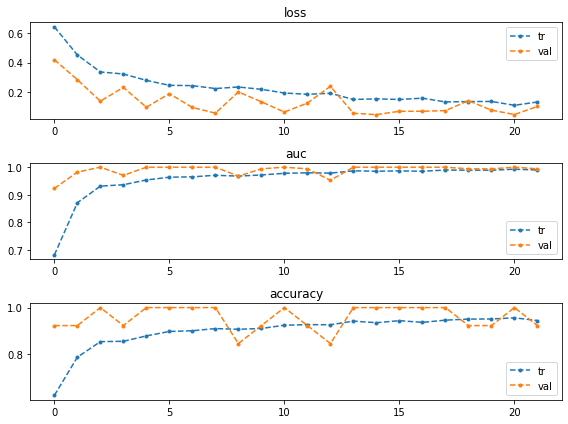

Found 23 validated image filenames belonging to 2 classes.


Found 13 validated image filenames belonging to 2 classes.


In [19]:
oof = np.zeros((len(train),2))
predictions = np.zeros((len(test),2))

learning_history = {}

for seed in SEEDS:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEEDS)
    predictions += predictions_ / len(SEEDS)
    gc.collect()

# Learning Curve

In [20]:
dfs = []
for k,v in learning_history.items():
    df_ = pd.DataFrame(v.history)
    df_["fold"] = k[0]
    df_["seed"] = k[1]
    dfs.append(df_)
    
learning_history_df = pd.concat(dfs)
learning_history_df.to_csv("learning_history_df.csv")
learning_history_df.groupby(["seed","fold"]).agg({"val_loss":min})

val_loss
seed fold          
0    0     0.249524
     1     0.039430
     2     0.035715
     3     0.139129
     4     0.131880
     5     0.123960
     6     0.049685

In [21]:
pd.DataFrame(predictions).to_csv("predictions.csv")
pd.DataFrame(oof).to_csv("oof.csv")

# Evaluation

In [22]:
# test

test_y = pd.get_dummies(test["class"]).values
pred_y = predictions
cr = classification_report(test_y.argmax(1), pred_y.argmax(1))
print(cr)

correct_classified = (test_y.argmax(1) == pred_y.argmax(1)).sum()
total_samples = test_y.shape[0]
print(color_back(
    f"Accuracy: {np.round(correct_classified/total_samples, 2)}, {correct_classified}/{total_samples}\n" \
    f"Crossentropy {np.round(keras.metrics.categorical_crossentropy(test_y, pred_y).numpy().mean(), 4)}",
     255,255,0))


              precision    recall  f1-score   support

           0       1.00      0.92      0.96        13
           1       0.91      1.00      0.95        10

    accuracy                           0.96        23
   macro avg       0.95      0.96      0.96        23
weighted avg       0.96      0.96      0.96        23

Accuracy: 0.96, 22/23
Crossentropy 0.1343
